# General setting

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# started at https://www.kaggle.com/renataghisloti
# %-m pip install --upgrade pip
# %pip install pandas
# %pip install seaborn
# %pip install matplotlib
# %pip install xgboost
# %pip install lightgbm
# %pip install sklearn
# %pip install "tensorflow<2.11"
import time
import numpy as np # yLogLinear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")
import random
import os
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
import xgboost as xg
import lightgbm as lgb
# #https://www.tensorflow.org/install
# # Requires the latest pip
# # !-m pip install --upgrade pip
# # Current stable release for CPU and GPU
# # !pip install tensorflow
# #Testing if tensorflow is installed
import tensorflow as tf 
from tensorflow import keras 
# print('tf.__version__: ', tf.__version__)
# print('__version__: ', keras.__version__)
from sklearn.base import BaseEstimator, TransformerMixin

random.seed(42)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
isInKaggle = not os.environ['PATH'].startswith('c:')#It is local if True ;)

DATA_ROOT = "/kaggle/input/amp-parkinsons-disease-progression-prediction/" if isInKaggle else "C:/Users/praf6/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/kaggleFiles/data/parkinson/"
PREPROCESSED_DATA_ROOT = "/kaggle/input/preprocessed/" if isInKaggle else "C:/Users/praf6/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/kaggleFiles/data/parkinson/"
RESULTS_ROOT = '/kaggle/working/' if isInKaggle else "C:/Users/praf6/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/kaggleFiles/results/parkinson/"

# Input train files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk(DATA_ROOT):
#     for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

u1 = 'updrs_1'; u2 = 'updrs_2'; u3 = 'updrs_3'; u4 = 'updrs_4'
initialModelsObjs = {}; errorModelsObjs = {}

In [2]:
#from https://www.tensorflow.org/install/pip?hl=pt-br#windows-native
# %conda install -c conda-forge cudatoolkit=11.8.0
#....
# # %pip install --upgrade pip
print('tf.__version__: ', tf.__version__)
# %pip install tensorflow-gpu
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

tf.__version__:  2.10.1
Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4979815703116557869
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1734816564
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12830703071371712334
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
#constants
PRED_PREFIX = 'pe'#'pe'#'pr'
outlierProbability = .5; 
dataSubsetsProps = [.25, .50, .75, .25] #proportion of patients to each modeling phase and test phase;
isWithOptimization = {u1:False, u2:False, u3:False, u4:False}; 
isWithPCA = {u1:False, u2: False, u3:False, u4:False}; 
TfBatchSize = 35 if isInKaggle else 10; 
TfVerbose = False if isInKaggle else False;
TfEpochs = 5000 if isInKaggle else 5000; 
TfPatience = 10
nImportantFeatures = {u1:4, u2:4, u3:6, u4:3};#-score=64.7#{u1:20, u2:10, u3:969, u4:10};#[969]*4#[4,2,3,2]#*4#there are 969 predictors;
nPcaComponents = {u1:np.min([20, nImportantFeatures[u1]]), u2:np.min([20, nImportantFeatures[u2]]), 
                  u3:np.min([20, nImportantFeatures[u3]]), u4:np.min([20, nImportantFeatures[u4]])};# 360 from UPDRS-based PCA, None for the max;
myCv = 5 if not isInKaggle else 50;
openMinimalTreshold = -1 #only values greater than openMinimalTreshold are considered in the modeling; 
optMethod = 'GridSearchCV'#'BayesSearchCV'

In [4]:
#Keras and XGBoost Models Architecture Compilation
MODELS_ROOT = "/kaggle/input/"+PRED_PREFIX+'models3/' if isInKaggle else "C:/Users/praf6/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/kaggleFiles/results/parkinson/"+PRED_PREFIX+'Models/'
def getModelName(yModel, eModel = None, targetVar=""):
    type_yModel = type(yModel)
    yModelNm = yModel if type_yModel == str else type_yModel.__name__
    formalism = 'yLog'+yModelNm.replace('Regressor', '').replace('Regression', '').replace('yLog', '')# if type_yModel != str else yModel[u]
    if eModel is not None:
        type_eModel = type(eModel)
        eModelNm = eModel if type_eModel == str else type_eModel.__name__
        formalism += '_e'+eModelNm.replace('Regressor', '').replace('Regression', '')
    if targetVar != "": formalism += ('_'+targetVar)
    return formalism
def getTfAnnModelStructure(targetVar = None, hidden_layer_sizes = (2, 2, 2), 
                          hidden_layer_dropout_rates = (.2, .2, .2), 
                          hidden_layer_activations = ('relu', 'relu', 'relu'),
                          learningRate = 3e-3, 
                          inpute_layer_dropout_rate = .2, 
                          hidden_layer_functions = [keras.layers.Dense]):
    #Model architecture
    tfAnn_reg = keras.models.Sequential(name="TF_ANN")
    multi = 3#due to the outliers columns
    u = targetVar
    input_shape = None
    if str(hidden_layer_functions[0]) == "<class 'keras.layers.core.dense.Dense'>":
        input_shape = (nPcaComponents[u]*multi,) if isWithPCA[u] else (nImportantFeatures[u]*multi,)
    elif str(hidden_layer_functions[0]) == "<class 'keras.layers.rnn.lstm.LSTM'>":
        input_shape = [None, 1]#(1, nPcaComponents[u]*multi, ) if isWithPCA[u] else (1, nImportantFeatures[u]*multi, )#to evolve ;)
    tfAnn_reg.add(keras.layers.InputLayer (name = "input_layer", input_shape =input_shape))
    if inpute_layer_dropout_rate > 0:
        tfAnn_reg.add(keras.layers.Dropout(inpute_layer_dropout_rate))#dropout
    nHiddenLayers = len(hidden_layer_sizes)
    nDropouts = len(hidden_layer_dropout_rates)
    nActivations = len(hidden_layer_activations)
    n_hidden_layer_functions = len(hidden_layer_functions)
    if nHiddenLayers > 1 and nDropouts == 1: 
        hidden_layer_dropout_rates = tuple([hidden_layer_dropout_rates[0]]*nHiddenLayers)
    if nHiddenLayers > 1 and nActivations == 1: 
        hidden_layer_activations = tuple([hidden_layer_activations[0]]*nHiddenLayers)
    if nHiddenLayers > 1 and n_hidden_layer_functions == 1: 
        hidden_layer_functions = tuple([hidden_layer_functions[0]]*nHiddenLayers)
    for i in range(nHiddenLayers):
        if str(hidden_layer_functions[i]) == "<class 'keras.layers.core.dense.Dense'>":
            tfAnn_reg.add(hidden_layer_functions[i](name = ("hidden_layer_" + str(i)), 
                                         units = hidden_layer_sizes[i], 
                                         activation=hidden_layer_activations[i])) # hidden layer # i
            if hidden_layer_dropout_rates[i] > 0:
                tfAnn_reg.add(keras.layers.Dropout(hidden_layer_dropout_rates[i]))
        elif str(hidden_layer_functions[i]) == "<class 'keras.layers.rnn.lstm.LSTM'>":
            return_sequences = True if i < (nHiddenLayers-1) else False
            tfAnn_reg.add(hidden_layer_functions[i](name = ("hidden_layer_" + str(i)), 
                                        units = hidden_layer_sizes[i],
                                        recurrent_dropout = hidden_layer_dropout_rates[i], 
                                        return_sequences = return_sequences))# hidden layer # i

    tfAnn_reg.add(keras.layers.Dense(name = "output_layer", units = 1, activation='sigmoid'))#output layer 'linear'
    optimizer = keras.optimizers.SGD(learning_rate = learningRate) 
    tfAnn_reg.compile(loss = 'mse', optimizer = optimizer, metrics = 'mape')
    return (tfAnn_reg)
class TfRNNRegressor (BaseEstimator, TransformerMixin): 
    def __init__(self, targetVar, phase, hidden_layer_sizes = (2, 2, 2), 
                          hidden_layer_dropout_rates = (.2, .2, .2), 
                        #   hidden_layer_activations = ('relu', 'relu', 'relu'),
                          learningRate = 3e-3, 
                          inpute_layer_dropout_rate = .2):
        self.targetVar = targetVar
        self.phase = phase
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learningRate = learningRate
        self.inpute_layer_dropout_rate = inpute_layer_dropout_rate
        #Model architecture
        self.model = getTfAnnModelStructure(targetVar, hidden_layer_sizes, 
                          hidden_layer_dropout_rates, 
                        #   hidden_layer_activations,
                          learningRate = 3e-3, 
                          inpute_layer_dropout_rate = .2, 
                          hidden_layer_functions = [keras.layers.LSTM])
    def fit(self, X, y, modelName = None): 
        modelNm = modelName if modelName is not None else getModelName(self, targetVar=self.targetVar)#self.targetVar + '_' + self.phase + '_' + type(self).__name__.replace('Regressor', '') 
        path = MODELS_ROOT+modelNm+'.keras'
        start = time.time()
        try:
            self.model = keras.models.load_model(path)
            print('==**** load_model', modelNm, '****==')
        except:
            print('==****', modelNm, '****==')
            early_stopping_cb = keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                            patience = TfPatience, 
                                                            restore_best_weights = True)
            
            # reshape input to be [samples, time steps, features]
            rX = X#np.reshape(X, (X.shape[0], 1, X.shape[1]))#to evolve with this... ;)
            history = self.model.fit(rX, y, epochs=TfEpochs, batch_size=TfBatchSize, validation_split=.2,
                verbose=TfVerbose, callbacks =[early_stopping_cb])
            epochsLastIndex = len(history.epoch)-1
            RMSE_t = np.round(np.sqrt(history.history['loss'][epochsLastIndex]), 3)
            RMSE_v = np.round(np.sqrt(history.history['val_loss'][epochsLastIndex]), 3)
            MAPE_t = np.round(history.history['mape'][epochsLastIndex], 3)
            MAPE_v = np.round(history.history['val_mape'][epochsLastIndex], 3)
            RMSE_v_t = RMSE_v - RMSE_t
            MAPE_v_t = MAPE_v - MAPE_t
            df = pd.DataFrame({'convergenceEpoch':history.epoch[epochsLastIndex], 
                               'RMSE_t':RMSE_t, 'RMSE_v':RMSE_v, 'RMSE_v_t':RMSE_v_t,
                               'MAPE_t':MAPE_t, 'MAPE_v':MAPE_v, 'MAPE_v_t':MAPE_v_t}, index = [0])
            display(df)
            self.model.save(path)
        print('>>> elapsed time:', str(time.time() - start), 'seconds!')
        return self 
    def transform(self, X):  
        return self
    def predict(self, X):
        ret = self.model.predict(X, verbose=False)
        ret = list(np.concatenate(ret, axis=0 ))
        return ret
class TfMLPRegressor (BaseEstimator, TransformerMixin): 
    def __init__(self, targetVar, phase, hidden_layer_sizes = (2, 2, 2), 
                          hidden_layer_dropout_rates = (.2, .2, .2), 
                          hidden_layer_activations = ('relu', 'relu', 'relu'),
                          learningRate = 3e-3, 
                          inpute_layer_dropout_rate = .2):
        self.targetVar = targetVar
        self.phase = phase
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learningRate = learningRate
        self.inpute_layer_dropout_rate = inpute_layer_dropout_rate
        #Model architecture
        self.model = getTfAnnModelStructure(targetVar, hidden_layer_sizes, 
                          hidden_layer_dropout_rates, 
                          hidden_layer_activations,
                          learningRate = 3e-3, 
                          inpute_layer_dropout_rate = .2, 
                          hidden_layer_functions = [keras.layers.Dense])
        

    def fit(self, X, y, modelName = None): 
        modelNm = modelName if modelName is not None else getModelName(self, targetVar=self.targetVar)#self.targetVar + '_' + self.phase + '_' + type(self).__name__.replace('Regressor', '') 
        path = MODELS_ROOT+modelNm+'.keras'
        start = time.time()
        try:
            self.model = keras.models.load_model(path)
            print('==**** load_model', modelNm, '****==')
        except:
            print('==****', modelNm, '****==')
            early_stopping_cb = keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                                patience = TfPatience, 
                                                                restore_best_weights = True)
            history = self.model.fit(X, y, epochs=TfEpochs, batch_size=TfBatchSize, validation_split=.2,
                verbose=TfVerbose, callbacks =[early_stopping_cb])
            epochsLastIndex = len(history.epoch)-1
            RMSE_t = np.round(np.sqrt(history.history['loss'][epochsLastIndex]), 3)
            RMSE_v = np.round(np.sqrt(history.history['val_loss'][epochsLastIndex]), 3)
            MAPE_t = np.round(history.history['mape'][epochsLastIndex], 3)
            MAPE_v = np.round(history.history['val_mape'][epochsLastIndex], 3)
            RMSE_v_t = RMSE_v - RMSE_t
            MAPE_v_t = MAPE_v - MAPE_t
            df = pd.DataFrame({'convergenceEpoch':history.epoch[epochsLastIndex], 
                               'RMSE_t':RMSE_t, 'RMSE_v':RMSE_v, 'RMSE_v_t':RMSE_v_t,
                               'MAPE_t':MAPE_t, 'MAPE_v':MAPE_v, 'MAPE_v_t':MAPE_v_t}, index = [0])
            display(df)
            self.model.save(path)
        print('>>> elapsed time:', str(time.time() - start), 'seconds!')
        return self 
    def transform(self, X):  
        return self
    def predict(self, X):
        ret = self.model.predict(X, verbose=False)
        ret = list(np.concatenate(ret, axis=0 ))
        return ret
class MyXGBRegressor (xg.XGBRegressor):  
    def __init__(self, targetVar = None, colsample_bytree= 1, eta= 0.3, max_depth= 6, n_estimators= 100, 
                 objective='reg:squarederror', seed=0, subsample = 1):
        self.targetVar = targetVar
        self.colsample_bytree= colsample_bytree
        self.eta= eta
        self.max_depth= max_depth
        self.n_estimators= n_estimators
        self.subsample =subsample
        self.objective=objective
        self.seed=seed
        self.model = xg.XGBRegressor(colsample_bytree= colsample_bytree, 
                                     eta= eta, max_depth= max_depth, 
                                     n_estimators= n_estimators, subsample =subsample, 
                                     objective=objective, seed=seed)
    def fit(self, X, y, modelName = None): 
        modelNm = modelName if modelName is not None else getModelName(self, targetVar=self.targetVar)#self.targetVar + '_' + self.phase + '_' + type(self).__name__.replace('Regressor', '') 
        path = MODELS_ROOT+modelNm+'.txt'
        start = time.time()
        try:
            self.model.load_model(path)
            print('==**** load_model', modelNm, '****==')
        except:
            print('==****', modelNm, '****==')
            X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, shuffle=False)
            eval_set = [(X_validation, y_validation)]
            self.model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, early_stopping_rounds=10, 
                        verbose=False)
            self.model.save_model(path)
        print('>>> elapsed time:', str(time.time() - start), 'seconds!')
        return self 
    def transform(self, X):  
        return self
    def predict(self, X):
        ret = self.model.predict(X)#, verbose=False)
        # ret = list(np.concatenate(ret, axis=0 ))
        return ret.tolist()
class MyLGBMRegressor (lgb.LGBMRegressor):  
    def __init__(self, targetVar = None, min_split_gain = 0, 
                 learning_rate= 0.1, 
                 min_child_samples=20, 
                 max_depth= -1, 
                 n_estimators= 100,
                 random_state=0,
                 num_leaves = 31):
        self.targetVar = targetVar
        self.min_split_gain =min_split_gain
        self.learning_rate= learning_rate
        self.min_child_samples=min_child_samples
        self.max_depth= max_depth
        self.n_estimators= n_estimators
        self.random_state=random_state
        self.num_leaves = num_leaves
        
        
        self.model = lgb.LGBMRegressor(min_split_gain =min_split_gain,
        learning_rate= learning_rate,
        min_child_samples=min_child_samples,
        max_depth= max_depth,
        n_estimators= n_estimators,
        random_state=random_state, 
        num_leaves = num_leaves)
    def fit(self, X, y, modelName = None): 
        modelNm = modelName if modelName is not None else getModelName(self, targetVar=self.targetVar)#self.targetVar + '_' + self.phase + '_' + type(self).__name__.replace('Regressor', '') 
        path = MODELS_ROOT+modelNm+'.txt'
        start = time.time()
        try:
            self.model =  lgb.Booster(model_file=path)
            print('==**** load_model', modelNm, '****==')
        except:
            print('==**** fit', modelNm, '****==')
            X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, shuffle=False)
            eval_set = [(X_validation, y_validation)]
            self.model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, early_stopping_rounds=10, 
                        verbose=False)
            self.model.booster_.save_model(path)
        print('>>> elapsed time:', str(time.time() - start), 'seconds!')
        return self 
    def transform(self, X):  
        return self
    def predict(self, X):
        ret = self.model.predict(X)#, verbose=False)
        # ret = list(np.concatenate(ret, axis=0 ))
        return ret.tolist()

In [5]:
#initialModelsObjs
initialModelsObjs['LinearRegression'] = {u1: LinearRegression(fit_intercept = True),
                        u2: LinearRegression(fit_intercept = True),
                        u3: LinearRegression(fit_intercept = True),
                        u4: LinearRegression(fit_intercept = True)}
initialModelsObjs['SVR'] = {u1: SVR(C= 1.5, coef0= 2, degree= 2, epsilon= 0.2, gamma= 0.01, kernel= 'sigmoid'),
                        u2: SVR(C=1, epsilon=.1),
                        u3: SVR(C=1, epsilon=.12, kernel='rbf', gamma = .01),
                        u4: SVR(C=1, epsilon=.11, kernel='rbf', gamma = .01),}
initialModelsObjs['MyLGBMRegressor'] = {u1: MyLGBMRegressor(u1, learning_rate= 0.1, max_depth= -1, n_estimators= 1000),#n_estimators = 100
                        u2: MyLGBMRegressor(u2, min_split_gain = .01, learning_rate= 0.05, min_child_samples=1000, n_estimators = 70),#n_estimators = 70
                        u3: MyLGBMRegressor(u3, min_child_samples=40, n_estimators = 1000),#n_estimators = 50
                        u4: MyLGBMRegressor(u4, min_split_gain = .1, learning_rate= 0.15, min_child_samples=61, n_estimators = 1000),}#n_estimators = 11
initialModelsObjs['MyXGBRegressor'] = {u1: MyXGBRegressor(u1, colsample_bytree= 0.15, eta= 0.01, max_depth= 8, n_estimators= 80),#80),#),
                        u2: MyXGBRegressor(u2, eta= 0.2, n_estimators= 40),#(max_depth= 4, n_estimators= 4),
                        u3: MyXGBRegressor(u3, colsample_bytree= 0.6, eta= 0.45, max_depth= 3, n_estimators= 4),#4),
                        u4: MyXGBRegressor(u4, eta= 0.2, n_estimators= 50),#25(colsample_bytree= 0.35, eta= 0.1, max_depth= 4, n_estimators= 50)),#),
                        }
initialModelsObjs['DecisionTreeRegressor'] = {u1: DecisionTreeRegressor(min_samples_leaf= 100, random_state=0),
                        u2: DecisionTreeRegressor(min_samples_leaf= 20, random_state=0),
                        u3: DecisionTreeRegressor(min_samples_leaf= 20, random_state=0),
                        u4: DecisionTreeRegressor(min_samples_leaf= 20, random_state=0),}
initialModelsObjs['RandomForestRegressor'] = {u1: RandomForestRegressor(random_state=0, min_samples_split= 100, n_estimators= 3),
                        u2: RandomForestRegressor(random_state=0, min_samples_split=80, n_estimators=4),
                        u3: RandomForestRegressor(random_state=0, min_samples_split=100, n_estimators=3),
                        u4: RandomForestRegressor(random_state=0, min_samples_split=100, n_estimators=5),}
initialModelsObjs['TfMLPRegressor'] = {
    u1: TfMLPRegressor(u1, 'initialModel', 
        hidden_layer_sizes = [100, 50, 20, 10, 5], 
        hidden_layer_dropout_rates = [0], 
        hidden_layer_activations = ['relu'],#*5 + ['sigmoid']*3,#sigmoid
        learningRate = 1e-5, inpute_layer_dropout_rate = 0),
    u2: TfMLPRegressor(u2,'initialModel', 
        hidden_layer_sizes = [100, 50, 20, 10, 5], 
        hidden_layer_dropout_rates = [0], 
        hidden_layer_activations = ['relu'],#*5 + ['sigmoid']*3,#sigmoid
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
    u3: TfMLPRegressor(u3,'initialModel', 
        hidden_layer_sizes = [100, 50, 20, 10, 5], 
        hidden_layer_dropout_rates = [0], 
        hidden_layer_activations = ['relu'],#sigmoid
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
    u4: TfMLPRegressor(u4,'initialModel', 
        hidden_layer_sizes = [100, 50, 20, 10, 5], 
        hidden_layer_dropout_rates = [0], 
        hidden_layer_activations = ['relu'],#sigmoid
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
 }
initialModelsObjs['TfRNNRegressor'] = {
    u1: TfRNNRegressor(u1,'initialModel', 
        hidden_layer_sizes = [100, 50, 20, 10, 5, 2], 
        hidden_layer_dropout_rates = [0], 
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
    u2: TfRNNRegressor(u2,'initialModel', 
        hidden_layer_sizes = [100, 50, 20, 10, 5, 3, 2], 
        hidden_layer_dropout_rates = [0], 
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
    u3: TfRNNRegressor(u3,'initialModel', 
        hidden_layer_sizes = [100, 50, 20, 10, 5, 3, 2], 
        hidden_layer_dropout_rates = [0], 
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
    u4: TfRNNRegressor(u4,'initialModel', 
        hidden_layer_sizes = [100, 50, 20, 10, 5, 3, 2], 
        hidden_layer_dropout_rates = [0], 
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
 }

In [6]:
#errorModelsObjs
errorModelsObjs['DecisionTreeRegressor'] = {u1: DecisionTreeRegressor(ccp_alpha= 4.62257081366534e-08, max_depth= 3, min_samples_leaf= 20, min_samples_split= 2, splitter= 'best', random_state=0),
                        u2: DecisionTreeRegressor(ccp_alpha= 4.62257081366534e-08, max_depth= 2, min_samples_leaf= 27, min_samples_split= 2, splitter= 'best', random_state=0),
                        u3: DecisionTreeRegressor(ccp_alpha= 4.62257081366534e-08, max_depth= 2, min_samples_leaf= 27, min_samples_split= 2, splitter= 'best', random_state=0),
                        u4: DecisionTreeRegressor(ccp_alpha= 4.62257081366534e-01, max_depth= 2, min_samples_leaf= 50, min_samples_split= 10, splitter= 'best', random_state=0),}
errorModelsObjs['MyLGBMRegressor'] = {u1: MyLGBMRegressor(learning_rate= 0.1, max_depth= 10, num_leaves = 10, n_estimators= 1000),#n_estimators= 100
                        u2: MyLGBMRegressor(learning_rate= 0.1, max_depth= 3, n_estimators= 5, num_leaves = 1000),#n_estimators= 299
                        u3: MyLGBMRegressor(learning_rate= 0.1, max_depth= 3, n_estimators= 5, num_leaves = 1000),#n_estimators= 299
                        u4: MyLGBMRegressor(learning_rate= 0.1, max_depth= 3, n_estimators= 100, num_leaves = 1000),}#n_estimators= 10
errorModelsObjs['RandomForestRegressor'] = {u1: RandomForestRegressor(random_state=0, min_samples_split= 50, n_estimators= 50),
                        u2: RandomForestRegressor(random_state=0, min_samples_split=100, n_estimators=5),
                        u3: RandomForestRegressor(random_state=0, min_samples_split=30, n_estimators=50),
                        u4: RandomForestRegressor(random_state=0, min_samples_split=100, n_estimators=5),}
errorModelsObjs['MyXGBRegressor'] = {u1: MyXGBRegressor(colsample_bytree= 0.2, eta= 0.01, max_depth= 10, n_estimators= 1000),#100),
                        u2: MyXGBRegressor(max_depth= 5, n_estimators= 1000),#3),
                        u3: MyXGBRegressor(colsample_bytree= 0.05, eta= 0.3, max_depth= 5, subsample = .5, n_estimators= 1000),#10),
                        u4: MyXGBRegressor(colsample_bytree= 0.3, eta= 0.3, max_depth= 5, n_estimators= 1000),#5),
                        }
errorModelsObjs['SVR'] = {u1: SVR(C= 1, epsilon= 0.1, coef0= 2, degree= 2, gamma= 0.2, kernel= 'poly'),
                        u2: SVR(C=1, epsilon=.1),
                        u3: SVR(C= 1.5, epsilon= 0.01, coef0= 2, degree= 2, gamma= 0.01, kernel= 'sigmoid'),
                        u4: SVR(C=1, epsilon=.15, coef0= 3, degree= 3, gamma= 0.1, kernel= 'rbf'),}
errorModelsObjs['MLPRegressor'] = {u1: MLPRegressor(random_state=0, activation='relu', hidden_layer_sizes=(25, 15, 5, 3)),
                         u2: MLPRegressor(random_state=0, activation='relu', hidden_layer_sizes=(25, 15, 5, 3)),
                         u3: MLPRegressor(random_state=0, activation='relu', hidden_layer_sizes=(25, 15, 5, 3)),
                         u4: MLPRegressor(random_state=0, activation='logistic', hidden_layer_sizes=(20, 10, 5, 3, 2)),}
errorModelsObjs['TfMLPRegressor'] = {
    u1: TfMLPRegressor(u1, 'errorModel', 
        hidden_layer_sizes = (100, 50, 40, 30, 20, 10, 5, 3, 2), 
        hidden_layer_dropout_rates = [0], 
        hidden_layer_activations = ['relu'],#*5 + ['sigmoid']*3,#sigmoid
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
    u2: TfMLPRegressor(u2, 'errorModel', 
        hidden_layer_sizes = (100, 60, 40, 30, 20, 10, 5, 3, 2), 
        hidden_layer_dropout_rates = [0], 
        hidden_layer_activations = ['relu'],#*5 + ['sigmoid']*3,#sigmoid
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
    u3: TfMLPRegressor(u3, 'errorModel', 
        hidden_layer_sizes = (100, 50, 40, 30, 20, 10, 5, 3, 2), 
        hidden_layer_dropout_rates = [0], 
        hidden_layer_activations = ['relu'],#sigmoid
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
    u4: TfMLPRegressor(u4, 'errorModel', 
        hidden_layer_sizes = (100, 60, 40, 30, 20, 10, 5, 3, 2), 
        hidden_layer_dropout_rates = [0], 
        hidden_layer_activations = ['relu'],#sigmoid
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
 }
errorModelsObjs['TfRNNRegressor'] = {
    u1: TfRNNRegressor(u1, 'errorModel', 
        hidden_layer_sizes = [100, 50, 40, 30, 20, 10, 5, 3, 2], 
        hidden_layer_dropout_rates = [0], 
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
    u2: TfRNNRegressor(u2, 'errorModel', 
        hidden_layer_sizes = [100, 50, 40, 30, 20, 10, 5, 3, 2], 
        hidden_layer_dropout_rates = [0], 
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
    u3: TfRNNRegressor(u3, 'errorModel', 
        hidden_layer_sizes = [100, 50, 40, 30, 20, 10, 5, 3, 2], 
        hidden_layer_dropout_rates = [0], 
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
    u4: TfRNNRegressor(u4, 'errorModel', 
        hidden_layer_sizes = [100, 50, 40, 30, 20, 10, 5, 3, 2], 
        hidden_layer_dropout_rates = [0], 
        learningRate = 1e-3, inpute_layer_dropout_rate = 0),
 }


In [7]:
#isToRunInitialModels, isToRunErrorModels, isToRunCombinerModels, isToRunXModels
isToRunInitialModels = {
        'LinearRegression':      True,# if isInKaggle else True,
        'SVR':                   True,# if isInKaggle else False,
        'MyLGBMRegressor':       True,# if isInKaggle else False,         
        'MyXGBRegressor':        True,# if isInKaggle else False,
        'DecisionTreeRegressor': True,# if isInKaggle else False, 
        'RandomForestRegressor': True,# if isInKaggle else False,
        'MLPRegressor':          True,# if isInKaggle else False,
        'TfMLPRegressor':        False,# if isInKaggle else False,
        'TfRNNRegressor':        False,# if isInKaggle else False,
        }
isToRunErrorModels = {
        'DecisionTreeRegressor': True,#  if isInKaggle else True, 
        'MyLGBMRegressor':       True,#  if isInKaggle else False, 
        'RandomForestRegressor': True,#  if isInKaggle else False,
        'MyXGBRegressor':        True,#  if isInKaggle else False,
        'SVR':                   True,#  if isInKaggle else False,
        'MLPRegressor':          True,#  if isInKaggle else False,
        'TfMLPRegressor':        True,#  if isInKaggle else False,
        'TfRNNRegressor':        True,#  if isInKaggle else False,
        }
isToRunCombinerModels = {'cSA':  True,#  if isInKaggle else False, 
                         'cMd':  True,#  if isInKaggle else False, 
                         'cMV':  True,#  if isInKaggle else False, 
                         'cRNN': True,#  if isInKaggle else False, 
                         }
isToRunXModels = {'xTransfLinear': True, #xModels[u]['xTransfLinear']= LinearRegression().fit(X=x.values.reshape(-1, 1), y=y)
    'xTransfXg': True, #xModels[u]['xTransfXg']= MyXGBRegressor(objective='reg:squarederror', seed=0).fit(X=x, y=y)
    'xTransfSVR': True,#xModels[u]['xTransfSVR']= MultiOutputRegressor(SVR(verbose=False)).fit(X = x.values.reshape(-1, 1), y = y)
}#Try 'xTransfXg': False, 'xTransfSVR': False ... it achieved the my best public score (60.6)


## Descriptive data analysis

First of all, lets start loading the datasets

In [8]:
tv_proteins = pd.read_csv(DATA_ROOT+'train_proteins.csv')
tv_peptides = pd.read_csv(DATA_ROOT+'train_peptides.csv')
tv_clinical = pd.read_csv(DATA_ROOT+'train_clinical_data.csv')
test_general = pd.read_csv(DATA_ROOT+'example_test_files/test.csv')
test_proteins = pd.read_csv(DATA_ROOT+'example_test_files/test_proteins.csv')
test_peptides = pd.read_csv(DATA_ROOT+'example_test_files/test_peptides.csv')
sample_submission = pd.read_csv(DATA_ROOT+'example_test_files/sample_submission.csv')

In [9]:
#Seeing the datasets shape
print('******** training-validation data ********')
print('tv_proteins: ', tv_proteins.shape)
print('tv_peptides: ', tv_peptides.shape)
print('tv_clinical: ', tv_clinical.shape)

print('******** test data ********')
print('test_general: ', test_general.shape)
print('test_proteins: ', test_proteins.shape)
print('test_peptides: ', test_peptides.shape)
print('sample_submission: ', sample_submission.shape)

******** training-validation data ********
tv_proteins:  (232741, 5)
tv_peptides:  (981834, 6)
tv_clinical:  (2615, 8)
******** test data ********
test_general:  (16, 6)
test_proteins:  (453, 6)
test_peptides:  (2057, 7)
sample_submission:  (64, 3)


In [10]:
#Seeing the columns
print('******** training-validation data ********')
print('tv_proteins: ', tv_proteins.columns)
print('tv_peptides: ', tv_peptides.columns)
print('tv_clinical: ', tv_clinical.columns)
print('******** test data ********')
print('test_general: ', test_general.columns)
print('test_proteins: ', test_proteins.columns)
print('test_peptides: ', test_peptides.columns)
print('sample_submission: ', sample_submission.columns)

******** training-validation data ********
tv_proteins:  Index(['visit_id', 'visit_month', 'patient_id', 'UniProt', 'NPX'], dtype='object')
tv_peptides:  Index(['visit_id', 'visit_month', 'patient_id', 'UniProt', 'Peptide',
       'PeptideAbundance'],
      dtype='object')
tv_clinical:  Index(['visit_id', 'patient_id', 'visit_month', 'updrs_1', 'updrs_2',
       'updrs_3', 'updrs_4', 'upd23b_clinical_state_on_medication'],
      dtype='object')
******** test data ********
test_general:  Index(['visit_id', 'visit_month', 'patient_id', 'updrs_test', 'row_id',
       'group_key'],
      dtype='object')
test_proteins:  Index(['visit_id', 'visit_month', 'patient_id', 'UniProt', 'NPX', 'group_key'], dtype='object')
test_peptides:  Index(['visit_id', 'visit_month', 'patient_id', 'UniProt', 'Peptide',
       'PeptideAbundance', 'group_key'],
      dtype='object')
sample_submission:  Index(['prediction_id', 'rating', 'group_key'], dtype='object')


We can see that the datasets have some shared columns (visit_id, visit_month, patient_id) that we could use to merge the data and also columns that are specific for each dataset. 

In [11]:
#Looking closer to the data info of each dataset
tv_proteins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232741 entries, 0 to 232740
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   visit_id     232741 non-null  object 
 1   visit_month  232741 non-null  int64  
 2   patient_id   232741 non-null  int64  
 3   UniProt      232741 non-null  object 
 4   NPX          232741 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.9+ MB


In [12]:
tv_peptides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981834 entries, 0 to 981833
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   visit_id          981834 non-null  object 
 1   visit_month       981834 non-null  int64  
 2   patient_id        981834 non-null  int64  
 3   UniProt           981834 non-null  object 
 4   Peptide           981834 non-null  object 
 5   PeptideAbundance  981834 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 44.9+ MB


In [13]:
tv_clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2615 non-null   object 
 1   patient_id                           2615 non-null   int64  
 2   visit_month                          2615 non-null   int64  
 3   updrs_1                              2614 non-null   float64
 4   updrs_2                              2613 non-null   float64
 5   updrs_3                              2590 non-null   float64
 6   updrs_4                              1577 non-null   float64
 7   upd23b_clinical_state_on_medication  1288 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 163.6+ KB


We can see that we will be handling a considerable amount of data (mainly in the peptides dataset). The corresponding columns in the three datasets have the same data types and the proteins and peptide datasets do not have null values. The clinical data dataset have some null values, mainly in the 'upd23b_clinical_state_on_medication'. In the next setps we will need to analyze if we will use all the columns and what we will do with null values if it is necessary to use the columns with nulls. 

In [14]:
print('maximal "tv_clinical" number of visits: ', tv_clinical.visit_month.nunique())
print('maximal "tv_peptides" number of visits: ', tv_peptides.visit_month.nunique())
print('maximal "tv_proteins" number of visits: ', tv_proteins.visit_month.nunique())
print('maximal "test_general" number of visits: ', test_general.visit_month.nunique())
print('maximal "test_proteins" number of visits: ', test_proteins.visit_month.nunique())
print('maximal "test_peptides" number of visits: ', test_peptides.visit_month.nunique())

maximal "tv_clinical" number of visits:  17
maximal "tv_peptides" number of visits:  15
maximal "tv_proteins" number of visits:  15
maximal "test_general" number of visits:  2
maximal "test_proteins" number of visits:  2
maximal "test_peptides" number of visits:  2


In [15]:
print('"tv_clinical" visit_month: ', tv_clinical.visit_month.unique())
print('"tv_peptides" visit_month: ', tv_peptides.visit_month.unique())
print('"tv_proteins" visit_month: ', tv_proteins.visit_month.unique())
print('"test_general" visit_month: ', test_general.visit_month.unique())
print('"test_proteins" visit_month: ', test_proteins.visit_month.unique())
print('"test_peptides" visit_month: ', test_peptides.visit_month.unique())

"tv_clinical" visit_month:  [  0   3   6   9  12  18  24  30  36  42  48  54  60  72  84  96 108]
"tv_peptides" visit_month:  [  0   3   6  12  18  24  30  36  48  54  60  72  84  96 108]
"tv_proteins" visit_month:  [  0   3   6  12  18  24  30  36  48  54  60  72  84  96 108]
"test_general" visit_month:  [0 6]
"test_proteins" visit_month:  [0 6]
"test_peptides" visit_month:  [0 6]


The ``visit_monhts`` from ``tv_clinical`` has two months more than ``tv_proteins`` and ``tv_proteins`` (months 9, 42, )

In [16]:
tv_proteins#.groupby(['visit_id'])

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0
...,...,...,...,...,...
232736,58648_108,108,58648,Q9UBX5,27387.8
232737,58648_108,108,58648,Q9UHG2,369437.0
232738,58648_108,108,58648,Q9UKV8,105830.0
232739,58648_108,108,58648,Q9Y646,21257.6


In [17]:
def getQtDf(df, qtVar, qlVar, prefix, qlCats = None, justRead = True, isToSave = False):
    dfQt = None
    if justRead==True:
        dfQt = pd.read_csv(PREPROCESSED_DATA_ROOT+qlVar+qtVar+'.csv')#, index_col=False)
    else:
        if qlCats is None:
            qlCats = df[qlVar].unique()
        qlVarQtColumns = [prefix+qlCat for qlCat in qlCats]
        # prQt
        dfQtColumns = ['visit_id', 'visit_month',	'patient_id'] + qlVarQtColumns#,	UniProt	NPX]
        dfQt = pd.DataFrame(columns=dfQtColumns)
        visit_ids = df['visit_id'].unique()
        n_m = len(visit_ids)
        perc = 0
        cum = 10#%
        print('||', qlVar+qtVar, '|| getQtDf completed: 0%', end='... ')
        for i in range(n_m):#[:5]:
            visit_id = visit_ids[i]
            data = df[df['visit_id']==visit_id].reset_index()
            row = {}
            row['visit_id'] = visit_id; 
            row['visit_month'] = data.loc[0, 'visit_month']
            row['patient_id'] = data.loc[0, 'patient_id']
            for qlVarQtColumn in qlVarQtColumns:
                row[qlVarQtColumn] = 0
            qlValues = data[qlVar]; qtValues = data[qtVar]
            nCases = len(qlValues)
            for j in range(nCases):
                qlValue = qlValues[j]; 
                qtValue = qtValues[j]
                if qlValue not in qlCats:
                    qlValue = 'OTHERS'
                row[prefix+qlValue] = qtValue
            dfQt.loc[i] = row
            # print(visit_id, 'ok!', end=', ')
            perc = round(100*(i/n_m), 0)
            if perc >= cum:
                print(str(perc)+'%', end = '... ')
                cum += cum
        # ret = pd.DataFrame(dfQt, index=range(n_m))
        print(str(perc)+'%!')
        if isToSave:
            dfQt.to_csv(PREPROCESSED_DATA_ROOT+qlVar+qtVar+'.csv', index=False)
    return dfQt

In [18]:
#Proteins: converting quali UniProt vs quanti NPX relationship into quantitative variables
tv_UniProtCatgories = ['OTHERS'] + list(tv_proteins['UniProt'].unique())
# qt_tv_pr = getQtDf(df = tv_proteins, qtVar = 'NPX', qlVar = 'UniProt', 
#                    prefix = 'pr_', qlCats = tv_UniProtCatgories, justRead = True)
qt_tv_pr = pd.read_csv(PREPROCESSED_DATA_ROOT+'UniProt'+'NPX'+'.csv')
qt_tv_pr

,visit_id,visit_month,patient_id,pr_OTHERS,pr_O00391,pr_O00533,pr_O00584,pr_O14498,pr_O14773,pr_O14791,...,pr_Q9Y646,pr_Q9Y6R7,pr_P01594,pr_P02792,pr_P32754,pr_P60174,pr_Q13449,pr_Q99683,pr_Q99829,pr_Q9UKV8
0,55_0,0,55,0,11254.3,732430.0,39585.8,41526.9,31238.00,4202.71,...,23833.70,18953.50,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0
1,1517_0,0,1517,0,11648.9,419015.0,35053.8,0.0,17466.30,2784.40,...,19771.60,14699.50,18356.40,25826.9,124675.0,18494.30,32892.8,90539.1,11373.40,55379.8
2,1923_0,0,1923,0,21361.8,866985.0,32035.1,0.0,13373.10,0.00,...,26346.20,23597.10,0.00,27842.6,75856.4,12385.70,22141.7,93929.3,12141.10,64302.3
3,2660_0,0,2660,0,0.0,579829.0,28259.8,29883.2,19134.10,1884.61,...,25630.00,17990.90,10813.80,0.0,103346.0,14354.80,29919.2,86771.8,0.00,55047.2
4,3636_0,0,3636,0,10887.0,267402.0,11390.4,15696.3,6646.16,2962.85,...,7985.07,8587.01,0.00,0.0,0.0,0.00,20737.9,77076.9,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,58648_96,96,58648,0,0.0,333580.0,30430.4,25850.7,12475.80,2201.56,...,20459.30,18764.10,0.00,20421.4,95941.8,15111.10,23943.2,83223.2,0.00,107253.0
1109,5645_108,108,5645,0,10833.7,478871.0,36319.6,25384.2,44735.60,0.00,...,35301.40,15627.10,0.00,22532.6,49602.0,13260.50,21835.7,112181.0,4834.62,43025.5
1110,12703_108,108,12703,0,13231.2,869905.0,36491.3,26506.5,16815.50,1206.07,...,23710.20,13366.70,6157.04,17132.5,0.0,9417.38,26237.5,79705.9,18307.10,33346.9
1111,55096_108,108,55096,0,0.0,251652.0,25899.0,22491.2,22933.10,3480.20,...,14165.30,0.00,12313.60,15335.2,71745.5,0.00,15534.2,113332.0,22182.90,101061.0


In [19]:
#Peptides: converting quali Peptide vs quanti PeptideAbundance relationship into quantitative variables
tv_peptideCatgories = ['OTHERS'] + list(tv_peptides['Peptide'].unique())
# qt_tv_pe = getQtDf(df = tv_peptides, qtVar = 'PeptideAbundance', qlVar = 'Peptide', 
#                    prefix = 'pe_', qlCats = tv_peptideCatgories, justRead = True)
qt_tv_pe = pd.read_csv(PREPROCESSED_DATA_ROOT+'Peptide'+'PeptideAbundance'+'.csv')
qt_tv_pe

,visit_id,visit_month,patient_id,pe_OTHERS,pe_NEQEQPLGQWHLS,pe_GNPEPTFSWTK,pe_IEIPSSVQQVPTIIK,pe_KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,pe_SMEQNGPGLEYR,pe_TLKIENVSYQDKGNYR,...,pe_QALPQVR,pe_SGNIPAGTTVDTK,pe_RLGMFNIQHC(UniMod_4)K,pe_EPQVYTLPPSRDELTK,pe_PALEDLR,pe_QKVEPLRAELQEGAR,pe_RTHLPEVFLSK,pe_INHC(UniMod_4)RFDEFFSEGC(UniMod_4)APGSKK,pe_EQPPSLTR,pe_AGC(UniMod_4)VAESTAVC(UniMod_4)R
0,55_0,0,55,0,11254.3,102060.0,174185.0,27278.9,30838.7,23216.5,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.00
1,1517_0,0,1517,0,11648.9,63593.4,99566.6,16351.0,15566.0,0.0,...,11373.40,55379.8,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.00
2,1923_0,0,1923,0,21361.8,143149.0,183035.0,40231.7,45931.1,35114.2,...,12141.10,64302.3,527285.0,266736.0,52150.0,2907160.0,63.3693,566170.0,0.0,0.00
3,2660_0,0,2660,0,0.0,62913.2,202217.0,32707.7,27432.2,21862.0,...,0.00,55047.2,698890.0,0.0,26555.1,1647180.0,95.9112,333201.0,16940.5,5493.00
4,3636_0,0,3636,0,10887.0,0.0,93625.6,16141.5,12494.2,11672.1,...,0.00,0.0,578196.0,383650.0,37523.8,2398190.0,90.5350,287937.0,15091.1,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,58648_96,96,58648,0,0.0,48851.6,140747.0,19848.5,13591.1,13006.0,...,0.00,107253.0,597701.0,0.0,53928.9,2748450.0,93.8970,427226.0,12355.4,5514.22
1109,5645_108,108,5645,0,10833.7,32956.1,104886.0,22899.2,27414.0,25197.3,...,4834.62,43025.5,734496.0,849915.0,0.0,2230490.0,105.2230,562398.0,21417.6,5151.99
1110,12703_108,108,12703,0,13231.2,91211.4,295916.0,46211.5,32195.3,30542.7,...,18307.10,33346.9,621727.0,439021.0,14653.4,1293900.0,88.7857,653278.0,0.0,3631.35
1111,55096_108,108,55096,0,0.0,46410.8,78329.5,18586.5,17884.1,13121.9,...,22182.90,101061.0,680508.0,561202.0,59742.5,4115500.0,111.8560,577495.0,0.0,0.00


In [20]:
tv_clinical

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off


In [21]:
#there is no repetition of visit_id in the tv_clinical data
tv_clinical.visit_id.value_counts().describe()

count    2615.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: count, dtype: float64

## Pre-processing part 1

Lets merge the datasets

In [22]:
# train_validation = tv_clinical.merge(qt_tv_pe, on=['visit_id', 'visit_month', 'patient_id'], how='left')
# train_validation = train_validation.merge(qt_tv_pr, on=['visit_id', 'visit_month', 'patient_id'], how='right')
# train_validation.to_csv(DATA_ROOT+'train_validation.csv', index=False)
train_validation = pd.read_csv(PREPROCESSED_DATA_ROOT+'train_validation.csv')
print('************** train_validation ***********')
display(train_validation)


************** train_validation ***********


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,pe_OTHERS,pe_NEQEQPLGQWHLS,...,pr_Q9Y646,pr_Q9Y6R7,pr_P01594,pr_P02792,pr_P32754,pr_P60174,pr_Q13449,pr_Q99683,pr_Q99829,pr_Q9UKV8
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,0.0,11254.3,...,23833.70,18953.50,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0
1,1517_0,1517,0,11.0,6.0,25.0,5.0,On,0.0,11648.9,...,19771.60,14699.50,18356.40,25826.9,124675.0,18494.30,32892.8,90539.1,11373.40,55379.8
2,1923_0,1923,0,2.0,0.0,0.0,NaN,NaN,0.0,21361.8,...,26346.20,23597.10,0.00,27842.6,75856.4,12385.70,22141.7,93929.3,12141.10,64302.3
3,2660_0,2660,0,2.0,0.0,0.0,NaN,NaN,0.0,0.0,...,25630.00,17990.90,10813.80,0.0,103346.0,14354.80,29919.2,86771.8,0.00,55047.2
4,3636_0,3636,0,1.0,2.0,9.0,NaN,NaN,0.0,10887.0,...,7985.07,8587.01,0.00,0.0,0.0,0.00,20737.9,77076.9,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,58648_96,58648,96,7.0,0.0,5.0,NaN,NaN,0.0,0.0,...,20459.30,18764.10,0.00,20421.4,95941.8,15111.10,23943.2,83223.2,0.00,107253.0
1109,5645_108,5645,108,20.0,14.0,34.0,0.0,NaN,0.0,10833.7,...,35301.40,15627.10,0.00,22532.6,49602.0,13260.50,21835.7,112181.0,4834.62,43025.5
1110,12703_108,12703,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23710.20,13366.70,6157.04,17132.5,0.0,9417.38,26237.5,79705.9,18307.10,33346.9
1111,55096_108,55096,108,5.0,6.0,46.0,0.0,Off,0.0,0.0,...,14165.30,0.00,12313.60,15335.2,71745.5,0.00,15534.2,113332.0,22182.90,101061.0


In [23]:
#Reviewing the results of getQtDf with respect to tv_proteins
import random
trashCase = random.sample(tv_proteins.UniProt.unique().tolist(), 1)[0]
print('**************** train_validation ***************')
display(train_validation[['visit_id','pr_'+trashCase]][:6])
print('**************** tv_proteins ***************')
display(tv_proteins[tv_proteins.UniProt==trashCase][['visit_id','UniProt', 'NPX']][:6])

**************** train_validation ***************


,visit_id,pr_Q8NBJ4
0,55_0,29027.7
1,1517_0,23547.3
2,1923_0,44741.3
3,2660_0,30971.2
4,3636_0,10430.5
5,3863_0,30925.6


**************** tv_proteins ***************


,visit_id,UniProt,NPX
196,55_0,Q8NBJ4,29027.7
412,1517_0,Q8NBJ4,23547.3
618,1923_0,Q8NBJ4,44741.3
832,2660_0,Q8NBJ4,30971.2
1035,3636_0,Q8NBJ4,10430.5
1245,3863_0,Q8NBJ4,30925.6


In [24]:
#Reviewing the results of getQtDf with respect to tv_peptides
import random
trashCase = random.sample(tv_peptides.Peptide.unique().tolist(), 1)[0]
print('**************** train_validation ***************')
display(train_validation[['visit_id','pe_'+trashCase]][:6])
print('**************** tv_peptides ***************')
display(tv_peptides[tv_peptides.Peptide==trashCase][['visit_id','Peptide', 'PeptideAbundance']][:6])

**************** train_validation ***************


,visit_id,pe_TMQENSTPRED
0,55_0,28322.80
1,1517_0,14320.00
2,1923_0,9849.71
3,2660_0,13103.20
4,3636_0,13045.00
5,3863_0,18980.50


**************** tv_peptides ***************


,visit_id,Peptide,PeptideAbundance
656,55_0,TMQENSTPRED,28322.80
1575,1517_0,TMQENSTPRED,14320.00
2455,1923_0,TMQENSTPRED,9849.71
3362,2660_0,TMQENSTPRED,13103.20
4253,3636_0,TMQENSTPRED,13045.00
5043,3863_0,TMQENSTPRED,18980.50


In [25]:
#computing test data
def getTestQtDf(test_proteins, test_peptides, test_general, isToPrint = False, isToSave = False):
    #Test Proteins: converting quali UniProt vs quanti NPX relationship into quantitative variables
    qt_test_pr = getQtDf(df = test_proteins, qtVar = 'NPX', qlVar = 'UniProt', 
                    prefix = 'pr_', qlCats = tv_UniProtCatgories, justRead = False, isToSave = False)
    #Test Peptides: converting quali Peptide vs quanti PeptideAbundance relationship into quantitative variables
    qt_test_pe = getQtDf(df = test_peptides, qtVar = 'PeptideAbundance', qlVar = 'Peptide', 
                    prefix = 'pe_', qlCats = tv_peptideCatgories, justRead = False, isToSave = False)
    test = test_general.merge(qt_test_pe, on=['visit_id', 'visit_month', 'patient_id'], how='left')
    test = test.merge(qt_test_pr, on=['visit_id', 'visit_month', 'patient_id'], how='left')
    if isToPrint:
        print('************** qt_test_pr **************')
        display(qt_test_pr.head(3))
        print('************** qt_test_pe **************')
        display(qt_test_pe.head(3))
        print('************** test **************')
        display(test)
    return(test)
test = getTestQtDf(test_proteins, test_peptides, test_general)
display(test)

|| UniProtNPX || getQtDf completed: 0%... 50.0%... 50.0%!
|| PeptidePeptideAbundance || getQtDf completed: 0%... 50.0%... 50.0%!


,visit_id,visit_month,patient_id,updrs_test,row_id,group_key,pe_OTHERS,pe_NEQEQPLGQWHLS,pe_GNPEPTFSWTK,pe_IEIPSSVQQVPTIIK,...,pr_Q9Y646,pr_Q9Y6R7,pr_P01594,pr_P02792,pr_P32754,pr_P60174,pr_Q13449,pr_Q99683,pr_Q99829,pr_Q9UKV8
0,3342_0,0,3342,updrs_1,3342_0_updrs_1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3342_0,0,3342,updrs_2,3342_0_updrs_2,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3342_0,0,3342,updrs_3,3342_0_updrs_3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3342_0,0,3342,updrs_4,3342_0_updrs_4,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50423_0,0,50423,updrs_1,50423_0_updrs_1,0,13624.5,10901.6,51499.4,125492.0,...,38865.3,42920.4,8084.89,27803.6,0.0,19811.30,25876.8,0.0,0.0,72595.0
5,50423_0,0,50423,updrs_2,50423_0_updrs_2,0,13624.5,10901.6,51499.4,125492.0,...,38865.3,42920.4,8084.89,27803.6,0.0,19811.30,25876.8,0.0,0.0,72595.0
6,50423_0,0,50423,updrs_3,50423_0_updrs_3,0,13624.5,10901.6,51499.4,125492.0,...,38865.3,42920.4,8084.89,27803.6,0.0,19811.30,25876.8,0.0,0.0,72595.0
7,50423_0,0,50423,updrs_4,50423_0_updrs_4,0,13624.5,10901.6,51499.4,125492.0,...,38865.3,42920.4,8084.89,27803.6,0.0,19811.30,25876.8,0.0,0.0,72595.0
8,3342_6,6,3342,updrs_1,3342_6_updrs_1,6,21728.2,14564.0,96318.4,182527.0,...,51473.3,14624.5,0.00,17495.2,86222.4,7252.54,45426.9,98810.7,0.0,64411.5
9,3342_6,6,3342,updrs_2,3342_6_updrs_2,6,21728.2,14564.0,96318.4,182527.0,...,51473.3,14624.5,0.00,17495.2,86222.4,7252.54,45426.9,98810.7,0.0,64411.5


As said by the owners, there are peptides in the test set that are absent in the train-validation set...:
As there is no machine learning regarding these 'new' peptides, they nust be neglected by the predictors

In [26]:
print("*********** train_validation *********")
display(train_validation[['pr_OTHERS', 'pe_OTHERS']].describe())
print("*********** test *********")
display(test[['pr_OTHERS', 'pe_OTHERS']].describe())

*********** train_validation *********


,pr_OTHERS,pe_OTHERS
count,1113.0,1068.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


*********** test *********


,pr_OTHERS,pe_OTHERS
count,8.000000,8.000000
mean,14667.450000,17676.350000
std,500.259593,4331.609852
min,14199.500000,13624.500000
25%,14199.500000,13624.500000
50%,14667.450000,17676.350000
75%,15135.400000,21728.200000
max,15135.400000,21728.200000


In [27]:
print('test.patient_id.unique():', test.patient_id.unique())
print('train_validation.patient_id.unique():', train_validation.patient_id.unique())

test.patient_id.unique(): [ 3342 50423]
train_validation.patient_id.unique(): [   55  1517  1923  2660  3636  3863  4161  4172  5027  5178  5645  5742
  6054  6211  7051  7117  7568  7832  8699 10053 10174 10541 10715 10718
 11459 11686 11928 12516 12636 12703 12755 13368 13618 13968 14035 14124
 14242 14450 14811 15009 15504 15590 16238 16347 16566 16574 17154 17414
 17727 18183 18204 18553 18560 19088 20212 20216 20352 20404 20664 20791
 21126 21537 21729 22126 22623 23192 23244 23391 23636 24278 24690 24820
 24911 25562 25739 25750 25827 25911 26005 26104 26210 26809 27079 27300
 27464 27468 27715 27971 28327 28342 28818 29313 29417 30119 30155 30416
 30894 30951 31121 31154 31693 33548 33558 34182 35231 35465 35477 35675
 35696 36797 37312 37566 38419 39144 40022 40200 40340 40751 40874 40967
 41444 41617 41628 41871 41883 41930 42003 42385 42579 44001 44154 44682
 45161 45181 46837 47103 47513 47881 48780 48928 49239 49672 49683 49995
 50611 50907 51243 51879 51893 51899 52266 531

The ``patient_id`` 3342 and 50423 are used for testing... These ids are absent in the training set... ;( 

In [28]:
print(np.where(train_validation.patient_id.unique()==3342))
print(np.where(train_validation.patient_id.unique()==50423))

(array([], dtype=int64),)
(array([], dtype=int64),)


In [29]:
train_validation.nunique()

visit_id       1113
patient_id      248
visit_month      15
updrs_1          30
updrs_2          29
               ... 
pr_P60174       728
pr_Q13449       909
pr_Q99683       930
pr_Q99829       490
pr_Q9UKV8       908
Length: 1205, dtype: int64

In [30]:
print('train_validation.columns', train_validation.columns)
print('test.columns', test.columns)

train_validation.columns Index(['visit_id', 'patient_id', 'visit_month', 'updrs_1', 'updrs_2',
       'updrs_3', 'updrs_4', 'upd23b_clinical_state_on_medication',
       'pe_OTHERS', 'pe_NEQEQPLGQWHLS',
       ...
       'pr_Q9Y646', 'pr_Q9Y6R7', 'pr_P01594', 'pr_P02792', 'pr_P32754',
       'pr_P60174', 'pr_Q13449', 'pr_Q99683', 'pr_Q99829', 'pr_Q9UKV8'],
      dtype='object', length=1205)
test.columns Index(['visit_id', 'visit_month', 'patient_id', 'updrs_test', 'row_id',
       'group_key', 'pe_OTHERS', 'pe_NEQEQPLGQWHLS', 'pe_GNPEPTFSWTK',
       'pe_IEIPSSVQQVPTIIK',
       ...
       'pr_Q9Y646', 'pr_Q9Y6R7', 'pr_P01594', 'pr_P02792', 'pr_P32754',
       'pr_P60174', 'pr_Q13449', 'pr_Q99683', 'pr_Q99829', 'pr_Q9UKV8'],
      dtype='object', length=1203)


In [31]:
sample_submission

,prediction_id,rating,group_key
0,3342_0_updrs_1_plus_0_months,0,0
1,3342_0_updrs_1_plus_6_months,0,0
2,3342_0_updrs_1_plus_12_months,0,0
3,3342_0_updrs_1_plus_24_months,0,0
4,3342_0_updrs_2_plus_0_months,0,0
...,...,...,...
59,50423_6_updrs_3_plus_24_months,0,6
60,50423_6_updrs_4_plus_0_months,0,6
61,50423_6_updrs_4_plus_6_months,0,6
62,50423_6_updrs_4_plus_12_months,0,6


## Exploratory analysis

Now that we already know the data structure, let's extract some insights from it. 

In [32]:
train_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113 entries, 0 to 1112
Columns: 1205 entries, visit_id to pr_Q9UKV8
dtypes: float64(1200), int64(3), object(2)
memory usage: 10.2+ MB


One can see that there are missing values for each target variable (``updrs_1``, ..., ``updrs_4``). In the present study these missing values are not imputed. Actually, the respective rows are removed from the study, leadiong to a data set for each target variable:

### Data sets split for train and validation

In [33]:
import random
random.seed(0)
patient_ids = train_validation['patient_id'].unique().tolist()
train = {}
nDataSubsets = len(dataSubsetsProps); 
ns = [0]*nDataSubsets
nPatients = len(patient_ids)
random_ids = random.sample(patient_ids, nPatients)
previous_n = 0
for i in range(nDataSubsets):
    ns[i] = round(nPatients*dataSubsetsProps[i])
    train[i] = train_validation[train_validation.patient_id.isin(random_ids[previous_n:ns[i]+previous_n])]
    train[i] = train[i].sort_values(by=['visit_month', 'patient_id'], ascending=True)
    if np.sum(dataSubsetsProps) == 1 or i==2:
        previous_n += ns[i]
    # validation = train_validation[train_validation.patient_id.isin(random_ids[n:])]
    print('******** train[' + str(i)+ ']********')
    print('n =', ns[i])
    display(train[i])
    # print('******** validation ********')
    # display(validation)

******** train[0]********
n = 62


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,pe_OTHERS,pe_NEQEQPLGQWHLS,...,pr_Q9Y646,pr_Q9Y6R7,pr_P01594,pr_P02792,pr_P32754,pr_P60174,pr_Q13449,pr_Q99683,pr_Q99829,pr_Q9UKV8
3,2660_0,2660,0,2.0,0.0,0.0,NaN,NaN,0.0,0.00,...,25630.00,17990.90,10813.8,0.0,103346.0,14354.80,29919.2,86771.8,0.00,55047.2
10,5645_0,5645,0,12.0,7.0,17.0,NaN,NaN,0.0,9846.73,...,36819.80,9909.75,13213.6,21397.1,0.0,15232.80,33817.0,101296.0,0.00,31557.5
15,7117_0,7117,0,4.0,0.0,0.0,NaN,NaN,0.0,13711.90,...,18153.60,17462.30,10157.8,0.0,65700.5,11172.40,19074.9,134405.0,8461.66,66846.6
18,8699_0,8699,0,17.0,13.0,11.0,4.0,On,0.0,7361.28,...,27225.50,5919.37,11223.6,13717.9,141333.0,12081.40,19046.3,114112.0,0.00,96959.7
23,10718_0,10718,0,0.0,0.0,5.0,0.0,NaN,0.0,9563.38,...,9302.63,35146.50,8182.5,0.0,57119.7,9142.39,0.0,101382.0,0.00,38579.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,55302_84,55302,84,5.0,1.0,0.0,NaN,NaN,0.0,11224.40,...,21214.00,21865.90,13112.1,0.0,0.0,0.00,21108.4,0.0,13767.50,67897.2
1103,60803_84,60803,84,6.0,14.0,50.0,4.0,Off,0.0,0.00,...,11177.70,29317.60,11191.4,0.0,0.0,0.00,14436.9,89037.2,23960.20,0.0
1104,62723_84,62723,84,7.0,3.0,6.0,3.0,On,0.0,0.00,...,16386.80,18170.70,12412.7,12128.6,68599.6,15936.80,22384.1,132596.0,0.00,61303.5
1107,5645_96,5645,96,19.0,15.0,22.0,4.0,NaN,0.0,10280.30,...,34339.40,6425.50,0.0,24058.9,63314.6,14075.70,28276.0,101322.0,0.00,45740.5


******** train[1]********
n = 124


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,pe_OTHERS,pe_NEQEQPLGQWHLS,...,pr_Q9Y646,pr_Q9Y6R7,pr_P01594,pr_P02792,pr_P32754,pr_P60174,pr_Q13449,pr_Q99683,pr_Q99829,pr_Q9UKV8
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,0.0,11254.30,...,23833.7,18953.50,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0
3,2660_0,2660,0,2.0,0.0,0.0,NaN,NaN,0.0,0.00,...,25630.0,17990.90,10813.80,0.0,103346.0,14354.80,29919.2,86771.8,0.00,55047.2
8,5027_0,5027,0,1.0,0.0,0.0,NaN,NaN,0.0,8105.91,...,30896.1,22426.00,6194.78,16159.8,76661.9,9159.06,0.0,113743.0,7342.17,94585.3
9,5178_0,5178,0,9.0,1.0,3.0,NaN,NaN,0.0,10887.70,...,21498.0,16701.50,13680.20,12486.4,75896.3,14671.20,24107.2,111732.0,0.00,0.0
10,5645_0,5645,0,12.0,7.0,17.0,NaN,NaN,0.0,9846.73,...,36819.8,9909.75,13213.60,21397.1,0.0,15232.80,33817.0,101296.0,0.00,31557.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,55302_84,55302,84,5.0,1.0,0.0,NaN,NaN,0.0,11224.40,...,21214.0,21865.90,13112.10,0.0,0.0,0.00,21108.4,0.0,13767.50,67897.2
1103,60803_84,60803,84,6.0,14.0,50.0,4.0,Off,0.0,0.00,...,11177.7,29317.60,11191.40,0.0,0.0,0.00,14436.9,89037.2,23960.20,0.0
1104,62723_84,62723,84,7.0,3.0,6.0,3.0,On,0.0,0.00,...,16386.8,18170.70,12412.70,12128.6,68599.6,15936.80,22384.1,132596.0,0.00,61303.5
1107,5645_96,5645,96,19.0,15.0,22.0,4.0,NaN,0.0,10280.30,...,34339.4,6425.50,0.00,24058.9,63314.6,14075.70,28276.0,101322.0,0.00,45740.5


******** train[2]********
n = 186


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,pe_OTHERS,pe_NEQEQPLGQWHLS,...,pr_Q9Y646,pr_Q9Y6R7,pr_P01594,pr_P02792,pr_P32754,pr_P60174,pr_Q13449,pr_Q99683,pr_Q99829,pr_Q9UKV8
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,0.0,11254.3,...,23833.70,18953.50,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,1923_0,1923,0,2.0,0.0,0.0,NaN,NaN,0.0,21361.8,...,26346.20,23597.10,0.00,27842.6,75856.4,12385.7,22141.7,93929.3,12141.10,64302.3
3,2660_0,2660,0,2.0,0.0,0.0,NaN,NaN,0.0,0.0,...,25630.00,17990.90,10813.80,0.0,103346.0,14354.8,29919.2,86771.8,0.00,55047.2
4,3636_0,3636,0,1.0,2.0,9.0,NaN,NaN,0.0,10887.0,...,7985.07,8587.01,0.00,0.0,0.0,0.0,20737.9,77076.9,0.00,0.0
5,3863_0,3863,0,8.0,13.0,36.0,4.0,On,0.0,12407.6,...,18345.30,50924.90,16292.70,21645.2,0.0,16571.8,42688.4,99451.6,0.00,89187.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,62792_84,62792,84,2.0,5.0,21.0,3.0,On,0.0,16232.1,...,14575.20,47608.80,10412.60,31210.1,0.0,19568.1,70932.3,0.0,22517.30,83978.4
1106,64674_84,64674,84,11.0,15.0,45.0,4.0,Off,0.0,0.0,...,10287.70,13848.20,9236.78,14833.4,0.0,0.0,0.0,95869.6,0.00,62217.5
1107,5645_96,5645,96,19.0,15.0,22.0,4.0,NaN,0.0,10280.3,...,34339.40,6425.50,0.00,24058.9,63314.6,14075.7,28276.0,101322.0,0.00,45740.5
1109,5645_108,5645,108,20.0,14.0,34.0,0.0,NaN,0.0,10833.7,...,35301.40,15627.10,0.00,22532.6,49602.0,13260.5,21835.7,112181.0,4834.62,43025.5


******** train[3]********
n = 62


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,pe_OTHERS,pe_NEQEQPLGQWHLS,...,pr_Q9Y646,pr_Q9Y6R7,pr_P01594,pr_P02792,pr_P32754,pr_P60174,pr_Q13449,pr_Q99683,pr_Q99829,pr_Q9UKV8
1,1517_0,1517,0,11.0,6.0,25.0,5.0,On,0.0,11648.90,...,19771.6,14699.5,18356.40,25826.90,124675.0,18494.30,32892.8,90539.1,11373.4,55379.8
6,4161_0,4161,0,6.0,1.0,0.0,NaN,NaN,0.0,12336.20,...,13029.4,35091.0,6034.31,9192.71,0.0,0.00,48356.8,0.0,18232.9,67290.7
13,6211_0,6211,0,5.0,11.0,9.0,NaN,NaN,0.0,0.00,...,13859.9,13141.6,9663.33,16639.30,0.0,0.00,12413.1,67635.3,12250.7,35214.0
19,10053_0,10053,0,3.0,0.0,13.0,0.0,NaN,0.0,9104.27,...,0.0,19017.4,0.00,0.00,0.0,0.00,0.0,0.0,0.0,65900.0
29,12703_0,12703,0,3.0,2.0,0.0,NaN,NaN,0.0,16829.90,...,27603.3,16240.3,0.00,19592.40,0.0,21097.20,0.0,94748.8,15680.0,49363.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,58648_84,58648,84,7.0,0.0,6.0,NaN,NaN,0.0,0.00,...,19129.3,23783.1,0.00,0.00,0.0,0.00,0.0,0.0,0.0,96167.9
1102,59550_84,59550,84,26.0,20.0,41.0,9.0,Off,0.0,9452.83,...,21771.8,0.0,0.00,13457.40,148097.0,22354.50,18635.0,101693.0,0.0,57518.4
1108,58648_96,58648,96,7.0,0.0,5.0,NaN,NaN,0.0,0.00,...,20459.3,18764.1,0.00,20421.40,95941.8,15111.10,23943.2,83223.2,0.0,107253.0
1110,12703_108,12703,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23710.2,13366.7,6157.04,17132.50,0.0,9417.38,26237.5,79705.9,18307.1,33346.9


In [34]:
targetVars = [u1, u4, u2, u3]
# variables types
quantiVars = {}
for u in targetVars:
    quantiVars[u] = ['visit_month']
    if PRED_PREFIX == 'pe':
        quantiVars[u] += ['pe_'+pe for pe in tv_peptideCatgories]; quantiVars[u].remove('pe_OTHERS')
    elif PRED_PREFIX == 'pr':
        quantiVars[u] += ['pr_'+pr for pr in tv_UniProtCatgories]; quantiVars[u].remove('pr_OTHERS')
quantiVars[u1][:10]

['visit_month',
 'pe_NEQEQPLGQWHLS',
 'pe_GNPEPTFSWTK',
 'pe_IEIPSSVQQVPTIIK',
 'pe_KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK',
 'pe_SMEQNGPGLEYR',
 'pe_TLKIENVSYQDKGNYR',
 'pe_VIAVNEVGR',
 'pe_VMTPAVYAPYDVK',
 'pe_VNGSPVDNHPFAGDVVFPR']

### Feature engineering

In [35]:
# plt.figure(figsize=(8, 5));
# color = 'RdYlGn';
# sns.heatmap(train[0][targetVars].corr(),annot=True, linewidth=.5, cmap=color);
display(train[0][targetVars].corr())

,updrs_1,updrs_4,updrs_2,updrs_3
updrs_1,1.000000,0.340652,0.677203,0.530942
updrs_4,0.340652,1.000000,0.322587,0.106877
updrs_2,0.677203,0.322587,1.000000,0.776420
updrs_3,0.530942,0.106877,0.776420,1.000000


In [36]:
#ranked peptides (all, plus visit_month and eventually some target)
quantiVars = {}
if PRED_PREFIX == 'pe':
  quantiVars[u1]= ['visit_month',
    'pe_SSFVAPLEK',
    'pe_WYEIEKIPTTFENGR',
    'pe_VGYVSGWGR',
    'pe_AQTTVTC(UniMod_4)MENGWSPTPR',
    'pe_VPMMSDPK',
    'pe_QQTHMLDVMQDHFSR',
    'pe_IPLNDLFR',
    'pe_FTEC(UniMod_4)C(UniMod_4)QAADK',
    'pe_PPTSAHGNVAEGETKPDPDVTER',
    'pe_LSPLGEEMR',
    'pe_ISYGNDALMPSLTETK',
    'pe_LLDNWDSVTSTFSK',
    'pe_AQGFTEDTIVFLPQTDK',
    'pe_C(UniMod_4)PNPPVQENFDVNKYLGR',
    'pe_SLDFTELDVAAEK',
    'pe_NLNEKDYELLC(UniMod_4)LDGTR',
    'pe_GYHLNEEGTR',
    'pe_TGTTGQSGAESGTTEPSAR',
    'pe_LMVELHNLYR',
    'pe_FQNALLVR',
    'pe_HQTVPQNTGGKNPDPWAK',
    'pe_HVLFGTVGVPEHTYR',
    'pe_AGDFLEANYMNLQR',
    'pe_ADQVC(UniMod_4)INLR',
    'pe_NLQPASEYTVSLVAIKGNQESPK',
    'pe_QWAGLVEK',
    'pe_FMQAVTGWK',
    'pe_ESAYLYAR',
    'pe_FSPATHPSEGLEENYC(UniMod_4)RNPDNDPQGPWC(UniMod_4)YTTDPEKR',
    'pe_MVQEQC(UniMod_4)C(UniMod_4)HSQLEELHC(UniMod_4)ATGISLANEQDR',
    'pe_ATFGC(UniMod_4)HDGYSLDGPEEIEC(UniMod_4)TK',
    'pe_TGDEITYQC(UniMod_4)R',
    'pe_ASYGVKPR',
    'pe_C(UniMod_4)LVEKGDVAFVKHQTVPQNTGGK',
    'pe_YSLTYIYTGLSK',
    'pe_EQLSLLDRFTEDAKR',
    'pe_LVDKFLEDVKK',
    'pe_GEVQAMLGQSTEELR',
    'pe_DKLAAC(UniMod_4)LEGNC(UniMod_4)AEGLGTNYR',
    'pe_DNWVFC(UniMod_4)GGK',
    'pe_SC(UniMod_4)ESNSPFPVHPGTAEC(UniMod_4)C(UniMod_4)TK',
    'pe_SGLSTGWTQLSK',
    'pe_IYLYTLNDNAR',
    'pe_NRDHDTFLAVR',
    'pe_VTTVASHTSDSDVPSGVTEVVVK',
    'pe_ILGQQVPYATK',
    'pe_ADLSGITGAR',
    'pe_HYDGSYSTFGER',
    'pe_LEDMEQALSPSVFK',
    'pe_IPTTFENGR',
    'pe_WC(UniMod_4)AVSEHEATK',
    'pe_DIPMNPMC(UniMod_4)IYR',
    'pe_TVQAVLTVPK',
    'pe_SC(UniMod_4)DIPVFMNAR',
    'pe_LVFFAEDVGSNK',
    'pe_APEAQVSVQPNFQQDK',
    'pe_NPC(UniMod_4)QDPYILTPENR',
    'pe_SMEQNGPGLEYR',
    'pe_LVGGPMDASVEEEGVRR',
    'pe_ALEYIENLR',
    'pe_MMAVAADTLQR',
    'pe_VTSIQDWVQK',
    'pe_C(UniMod_4)REILSVDC(UniMod_4)STNNPSQAK',
    'pe_SGINC(UniMod_4)PIQK',
    'pe_VKSPELQAEAK',
    'pe_HPNVFGFC(UniMod_4)R',
    'pe_VTGVVLFR',
    'pe_KLINDYVK',
    'pe_AKAYLEEEC(UniMod_4)PATLRK',
    'pe_YIETDPANR',
    'pe_GIVEEC(UniMod_4)C(UniMod_4)FR',
    'pe_WELALGR',
    'pe_NILTSNNIDVK',
    'pe_HTFMGVVSLGSPSGEVSHPR',
    'pe_QGVNDNEEGFFSAR',
    'pe_LSPIYNLVPVK',
    'pe_TPENYPNAGLTMNYC(UniMod_4)R',
    'pe_VASYGVKPR',
    'pe_HGSPVDIC(UniMod_4)TAKPR',
    'pe_KSQPMGLWR',
    'pe_EVGPTNADPVC(UniMod_4)LAK',
    'pe_TC(UniMod_4)VADESAENC(UniMod_4)DKSLHTLFGDK',
    'pe_LAAAVSNFGYDLYR',
    'pe_DDNPNLPR',
    'pe_VSPTDC(UniMod_4)SAVEPEAEK',
    'pe_LSKELQAAQAR',
    'pe_ISHELDSASSEVN',
    'pe_ALANSLAC(UniMod_4)QGK',
    'pe_LGPGMADIC(UniMod_4)K',
    'pe_TPSAAYLWVGTGASEAEK',
    'pe_VDSGNDVTDIADDGC(UniMod_4)PKPPEIAHGYVEHSVR',
    'pe_QELSEAEQATR',
    'pe_ALYLQYTDETFR',
    'pe_WQEEMELYR',
    'pe_QRQEELC(UniMod_4)LAR',
    'pe_C(UniMod_4)LAFEC(UniMod_4)PENYR',
    'pe_TALASGGVLDASGDYR',
    'pe_M(UniMod_35)LTPEHVFIHPGWK',
    'pe_M(UniMod_35)TVTDQVNC(UniMod_4)PK',
    'pe_SGSDEVQVGQQR',
    'pe_EGDMLTLFDGDGPSAR',
    'pe_DMPASEDLQDLQK',
    'pe_VHTEC(UniMod_4)C(UniMod_4)HGDLLEC(UniMod_4)ADDRADLAK',
    'pe_KLYDYC(UniMod_4)DVPQC(UniMod_4)AAPSFDC(UniMod_4)GKPQVEPK',
    'pe_LEGQEEEEDNRDSSMK',
    'pe_KPALEDLR',
    'pe_DYFMPC(UniMod_4)PGR',
    'pe_SIAQYWLGC(UniMod_4)PAPGHL',
    'pe_FNALQYLR',
    'pe_AKWEMPFDPQDTHQSR',
    'pe_SLAELGGHLDQQVEEFRR',
    'pe_SELEEQLTPVAEETR',
    'pe_LLPAQLPAEKEVGPPLPQEAVPLQK',
    'pe_LLELTGPK',
    'pe_DDKETC(UniMod_4)FAEEGKK',
    'pe_ATWSGAVLAGR',
    'pe_AGKEPGLQIWR',
    'pe_TPLGDTTHTC(UniMod_4)PR',
    'pe_KEC(UniMod_4)C(UniMod_4)EKPLLEK',
    'pe_DEPPQSPWDR',
    'pe_GGTLGTPQTGSENDALYEYLR',
    'pe_SPMYSIITPNILR',
    'pe_NSWGEEWGMGGYVK',
    'pe_FSC(UniMod_4)MC(UniMod_4)PQGYQVVR',
    'pe_AYQGVAAPFPK',
    'pe_YGQTIRPIC(UniMod_4)LPC(UniMod_4)TEGTTR',
    'pe_ALEQDLPVNIK',
    'pe_VLEPTLK',
    'pe_IVSSAMEPDREYHFGQAVR',
    'pe_VEPYGENFNK',
    'pe_KMTVTDQVNC(UniMod_4)PK',
    'pe_DLLFRDDTVC(UniMod_4)LAK',
    'pe_YGLDSDLSC(UniMod_4)K',
    'pe_ATVVYQGER',
    'pe_SNSSMHITDC(UniMod_4)R',
    'pe_DQTVSDNELQEM(UniMod_35)SNQGSK',
    'pe_MELERPGGNEITR',
    'pe_YYWGGQYTWDMAK',
    'pe_HQPQEFPTYVEPTNDEIC(UniMod_4)EAFRKDPK',
    'pe_DSGRDYVSQFEGSALGK',
    'pe_HPNSPLDEENLTQENQDR',
    'pe_DQPFTILYR',
    'pe_PIVTSPYQIHFTK',
    'pe_DSGFQMNQLR',
    'pe_SC(UniMod_4)VGETTESTQC(UniMod_4)EDEELEHLR',
    'pe_GWVTDGFSSLK',
    'pe_C(UniMod_4)MC(UniMod_4)PAENPGC(UniMod_4)R',
    'pe_NEQEQPLGQWHLS',
    'pe_DFADIPNLR',
    'pe_LC(UniMod_4)TVATLR',
    'pe_EGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVK',
    'pe_QHMDSDSSPSSSSTYC(UniMod_4)NQMMR',
    'pe_FLVNLVK',
    'pe_THLPEVFLSK',
    'pe_VAAGAFQGLR',
    'pe_LC(UniMod_4)QDLGPGAFR',
    'pe_LC(UniMod_4)MGSGLNLC(UniMod_4)EPNNK',
    'pe_FLPSYQAVEYMR',
    'pe_TSLEDFYLDEER',
    'pe_MASGAANVVGPK',
    'pe_TEGDGVYTLNNEK',
    'pe_LKDDEVAQLKK',
    'pe_LAARLEALKENGGAR',
    'pe_SNAQGIDLNR',
    'pe_TAKDALSSVQESQVAQQAR',
    'pe_SNLDEDIIAEENIVSR',
    'pe_THLAPYSDELR',
    'pe_AVC(UniMod_4)SQEAMTGPC(UniMod_4)R',
    'pe_NWGLGGHAFC(UniMod_4)R',
    'pe_VDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSK',
    'pe_TYLGNALVC(UniMod_4)TC(UniMod_4)YGGSR',
    'pe_VTAAPQSVC(UniMod_4)ALR',
    'pe_TFTC(UniMod_4)TAAYPESK',
    'pe_QKPDGVFQEDAPVIHQEMIGGLR',
    'pe_HGGLYHENMR',
    'pe_FVEGLPINDFSR',
    'pe_DLGEENFK',
    'pe_MYLGYEYVTAIR',
    'pe_FMETVAEK',
    'pe_KC(UniMod_4)SYTEDAQC(UniMod_4)IDGTIEVPK',
    'pe_TPC(UniMod_4)TVSC(UniMod_4)NIPVVSGKEC(UniMod_4)EEIIR',
    'pe_DTINLLDQR',
    'pe_VTEIWQEVMQR',
    'pe_TQVNTQAEQLRR',
    'pe_LLDSLPSDTR',
    'pe_KTLLSNLEEAK',
    'pe_VMDKYTFELSR',
    'pe_LGADM(UniMod_35)EDVC(UniMod_4)GR',
    'pe_LRTEGDGVYTLNNEK',
    'pe_IQPSGGTNINEALLR',
    'pe_SILENLR',
    'pe_TSESGELHGLTTEEEFVEGIYK',
    'pe_LVGYLDR',
    'pe_TMQALPYSTVGNSNNYLHLSVLR',
    'pe_YTTEIIK',
    'pe_ADRDQYELLC(UniMod_4)LDNTR',
    'pe_NSLFEYQK',
    'pe_RLYGSEAFATDFQDSAAAK',
    'pe_ITGYIIK',
    'pe_NILTSNNIDVKK',
    'pe_SPVDIC(UniMod_4)TAKPR',
    'pe_SASDLTWDNLK',
    'pe_AQPVQVAEGSEPDGFWEALGGK',
    'pe_EPTMYGEILSPNYPQAYPSEVEK',
    'pe_GSPSGEVSHPR',
    'pe_AGLLRPDYALLGHR',
    'pe_VRQGQGQSEPGEYEQR',
    'pe_TLLSNLEEAK',
    'pe_LEGEAC(UniMod_4)GVYTPR',
    'pe_VSEADSSNADWVTK',
    'pe_PALEDLR',
    'pe_LGMDGYR',
    'pe_SDVVYTDWKK',
    'pe_LC(UniMod_4)MAALK',
    'pe_DGGFC(UniMod_4)EVC(UniMod_4)K',
    'pe_ASLVPMEHC(UniMod_4)ITR',
    'pe_SRYPVC(UniMod_4)GSDGTTYPSGC(UniMod_4)QLR',
    'pe_AIGYLNTGYQR',
    'pe_AATVGSLAGQPLQER',
    'pe_YLGEEYVK',
    'pe_GLVSWGNIPC(UniMod_4)GSK',
    'pe_DWHGVPGQVDAAMAGR',
    'pe_IASFSQNC(UniMod_4)DIYPGKDFVQPPTK',
    'pe_SLHTLFGDK',
    'pe_DC(UniMod_4)GSVDGVIKEVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK',
    'pe_DAC(UniMod_4)GC(UniMod_4)C(UniMod_4)PMC(UniMod_4)AR',
    'pe_WEAEPVYVQR',
    'pe_C(UniMod_4)C(UniMod_4)ESASEDC(UniMod_4)MAK',
    'pe_SLAAAAGKQELAK',
    'pe_GMADQDGLKPTIDKPSEDSPPLEMLGPR',
    'pe_ALTDMPQMR',
    'pe_LFDSDPITVTVPVEVSR',
    'pe_KVEQAVETEPEPELR',
    'pe_ADDKETC(UniMod_4)FAEEGKK',
    'pe_GYPGVQAPEDLEWER',
    'pe_KQELSEAEQATR',
    'pe_SDVMYTDWK',
    'pe_GMFNIQHC(UniMod_4)K',
    'pe_LVWEEAMSR',
    'pe_FSGSLLGGK',
    'pe_MDASLGNLFAR',
    'pe_LYHSEAFTVNFGDTEEAKK',
    'pe_SLGEC(UniMod_4)C(UniMod_4)DVEDSTTC(UniMod_4)FNAK',
    'pe_IC(UniMod_4)LEDNVLMSGVK',
    'pe_KPAEDEWGK',
    'pe_YVMLPVADQDQC(UniMod_4)IR',
    'pe_ILTC(UniMod_4)M(UniMod_35)QGMEEIR',
    'pe_TNFDNDIALVR',
    'pe_AVSEKEVDSGNDIYGNPIKR',
    'pe_LLEVPEGR',
    'pe_LVGGPMDASVEEEGVR',
    'pe_VEHSDLSFSK',
    'pe_SPVGVQPILNEHTFC(UniMod_4)AGMSK',
    'pe_VAVVQYSGTGQQRPER',
    'pe_KREEAPSLRPAPPPISGGGYR',
    'pe_GLPAPIEK',
    'pe_IAPQLSTEELVSLGEK',
    'pe_C(UniMod_4)LKDGAGDVAFVK',
    'pe_VTIPTDLIASSGDIIK',
    'pe_FLC(UniMod_4)TGGVSPYADPNTC(UniMod_4)R',
    'pe_C(UniMod_4)LVEKGDVAFVK',
    'pe_LLRDPADASEAHESSSR',
    'pe_AIQLTYNPDESSKPNMIDAATLK',
    'pe_ARAEAQEAEDQQAR',
    'pe_LGPLVEQGR',
    'pe_C(UniMod_4)NLLAEK',
    'pe_EAEEHQETQC(UniMod_4)LR',
    'pe_LQSLFDSPDFSK',
    'pe_ALFLETEQLK',
    'pe_VLLDGVQNPR',
    'pe_LATVGELQAAWR',
    'pe_SVPMVPPGIK',
    'pe_GGSTSYGTGSETESPR',
    'pe_ITTTSPWMFPSR',
    'pe_EVVEEAENGR',
    'pe_SFNRGEC(UniMod_4)',
    'pe_KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK',
    'pe_MTVTDQVNC(UniMod_4)PK',
    'pe_IMNGEADAMSLDGGFVYIAGK',
    'pe_KTLLSNLEEAKK',
    'pe_LSINTHPSQKPLSITVR',
    'pe_SYELTQPPSVSVSPGQTAR',
    'pe_C(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK',
    'pe_NLAVSQVVHK',
    'pe_VPEARPNSMVVEHPEFLK',
    'pe_QLKEHAVEGDC(UniMod_4)DFQLLKLDGK',
    'pe_YNSQNQSNNQFVLYR',
    'pe_HNC(UniMod_4)MENSIC(UniMod_4)R',
    'pe_AAVYHHFISDGVR',
    'pe_GVALADFNR',
    'pe_LEPYADQLR',
    'pe_NFPSPVDAAFR',
    'pe_LEAGDHPVELLAR',
    'pe_KLC(UniMod_4)MAALK',
    'pe_ANRPFLVFIR',
    'pe_GSPAINVAVHVFR',
    'pe_C(UniMod_4)QC(UniMod_4)DELC(UniMod_4)SYYQSC(UniMod_4)C(UniMod_4)TDYTAEC(UniMod_4)KPQVTR',
    'pe_EVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK',
    'pe_YGLVTYATYPK',
    'pe_LAVTTHGLPC(UniMod_4)LAWASAQAK',
    'pe_GINVALANGK',
    'pe_YVGGQEHFAHLLILR',
    'pe_SC(UniMod_4)DTPPPC(UniMod_4)PR',
    'pe_LEPGQQEEYYR',
    'pe_AADDTWEPFASGK',
    'pe_TPC(UniMod_4)QQELDQVLER',
    'pe_ATEHLSTLSEK',
    'pe_GEAGAPGEEDIQGPTK',
    'pe_KVESELIKPINPR',
    'pe_TFISPIK',
    'pe_LQDLYSIVR',
    'pe_ELSSFIDKGQELC(UniMod_4)ADYSENTFTEYKK',
    'pe_DNC(UniMod_4)C(UniMod_4)ILDER',
    'pe_WSRPQAPITGYR',
    'pe_SRGPGAPC(UniMod_4)QDVDEC(UniMod_4)AR',
    'pe_VHKEDDGVPVIC(UniMod_4)QVEHPAVTGNLQTQR',
    'pe_DTSC(UniMod_4)VNPPTVQNAYIVSR',
    'pe_YWGVASFLQK',
    'pe_FAEQDAK',
    'pe_QALPQVR',
    'pe_ANAGKPKDPTFIPAPIQAK',
    'pe_SKEFQLFSSPHGK',
    'pe_GQEDASPDRFSNTDYAVGYMLR',
    'pe_EQLTPLIK',
    'pe_LGEVNTYAGDLQK',
    'pe_MGNFPWQVFTNIHGR',
    'pe_DQTVSDNELQEMSNQGSK',
    'pe_LSYEGEVTK',
    'pe_FTQVTPTSLSAQWTPPNVQLTGYR',
    'pe_NPDGDVGGPWC(UniMod_4)YTTNPR',
    'pe_KAADDTWEPFASGK',
    'pe_DGLKYHYLIR',
    'pe_FKDLGEENFK',
    'pe_EIQNAVNGVK',
    'pe_GDKVWVYPPEKK',
    'pe_SETKDLLFRDDTVC(UniMod_4)LAK',
    'pe_HTSVQTTSSGSGPFTDVR',
    'pe_LGMFNIQHC(UniMod_4)K',
    'pe_VPFDAATLHTSTAMAAQHGMDDDGTGQK',
    'pe_AYLEEEC(UniMod_4)PATLRK',
    'pe_LNMHMNVQNGKWDSDPSGTK',
    'pe_SVIPSDGPSVAC(UniMod_4)VK',
    'pe_TQVNTQAEQLR',
    'pe_RPDSLQHVLLPVLDR',
    'pe_AELQC(UniMod_4)PQPAA',
    'pe_TNTNVNC(UniMod_4)PIEC(UniMod_4)FMPLDVQADREDSRE',
    'pe_LAPLAEDVR',
    'pe_NSKFEDC(UniMod_4)C(UniMod_4)QEK',
    'pe_M(UniMod_35)ADEAGSEADHEGTHSTKR',
    'pe_KVTYTSQEDLVEKK',
    'pe_ADSGEGDFLAEGGGVR',
    'pe_MPC(UniMod_4)AELVREPGC(UniMod_4)GC(UniMod_4)C(UniMod_4)SVC(UniMod_4)AR',
    'pe_LVPPMEEDYPQFGSPK',
    'pe_IGDTWSK',
    'pe_DC(UniMod_4)SLPYATESK',
    'pe_DLLLPQPDLR',
    'pe_VLNQELR',
    'pe_DKETC(UniMod_4)FAEEGKK',
    'pe_TQSSLVPALTDFVR',
    'pe_EIVLTQSPATLSLSPGER',
    'pe_LGADMEDVC(UniMod_4)GR',
    'pe_VC(UniMod_4)PFAGILENGAVR',
    'pe_YHDRDVWKPEPC(UniMod_4)R',
    'pe_AGAAAGGPGVSGVC(UniMod_4)VC(UniMod_4)K',
    'pe_NTGIIC(UniMod_4)TIGPASR',
    'pe_LGNQEPGGQTALK',
    'pe_EFQLFSSPHGK',
    'pe_C(UniMod_4)TTPPPSSGPTYQC(UniMod_4)LK',
    'pe_NTFAEVTGLSPGVTYYFK',
    'pe_APLIPMEHC(UniMod_4)TTR',
    'pe_ESLQQMAEVTR',
    'pe_SSGQWQTPGATR',
    'pe_KPVDEYKDC(UniMod_4)HLAQVPSHTVVAR',
    'pe_C(UniMod_4)AEENC(UniMod_4)FIQK',
    'pe_GAAPPKQEFLDIEDP',
    'pe_SYLSMVGSC(UniMod_4)C(UniMod_4)TSASPTVC(UniMod_4)FLKER',
    'pe_VYAC(UniMod_4)EVTHQGLSSPVTK',
    'pe_EYC(UniMod_4)GVPGDGDEELLR',
    'pe_LYGSEAFATDFQDSAAAK',
    'pe_LLEELVR',
    'pe_GIYGTISR',
    'pe_LSELIQPLPLER',
    'pe_GSQTQSHPDLGTEGC(UniMod_4)WDQLSAPR',
    'pe_RTPITVVK',
    'pe_IPIEDGSGEVVLSRK',
    'pe_THPHFVIPYR',
    'pe_APHGPGLIYR',
    'pe_AQAGANTRPC(UniMod_4)PS',
    'pe_SYTITGLQPGTDYK',
    'pe_YVM(UniMod_35)LPVADQDQC(UniMod_4)IR',
    'pe_VNGSPVDNHPFAGDVVFPR',
    'pe_FLATTPNSLLVSWQPPR',
    'pe_LKC(UniMod_4)DEWSVNSVGK',
    'pe_M(UniMod_35)VQEQC(UniMod_4)C(UniMod_4)HSQLEELHC(UniMod_4)ATGISLANEQDR',
    'pe_TLKIENVSYQDKGNYR',
    'pe_LHLDYIGPC(UniMod_4)K',
    'pe_NANTFISPQQR',
    'pe_C(UniMod_4)STSSLLEAC(UniMod_4)TFR',
    'pe_YPNC(UniMod_4)AYR',
    'pe_KPVEEYANC(UniMod_4)HLAR',
    'pe_LLC(UniMod_4)QC(UniMod_4)LGFGSGHFR',
    'pe_HQFLLTGDTQGR',
    'pe_RQEC(UniMod_4)SIPVC(UniMod_4)GQDQVTVAMTPR',
    'pe_LEEQAQQIR',
    'pe_GLSAEPGWQAK',
    'pe_HYEGSTVPEK',
    'pe_TFYEPGEEITYSC(UniMod_4)KPGYVSR',
    'pe_SGIEC(UniMod_4)QLWR',
    'pe_EAEEETTNDNGVLVLEPARK',
    'pe_RGEQC(UniMod_4)VDIDEC(UniMod_4)TIPPYC(UniMod_4)HQR',
    'pe_VQPYLDDFQKK',
    'pe_RELDESLQVAER',
    'pe_AYLEEEC(UniMod_4)PATLR',
    'pe_IFFYDSENPPASEVLR',
    'pe_YLFLNGNK',
    'pe_TM(UniMod_35)LLQPAGSLGSYSYR',
    'pe_MC(UniMod_4)VDVNEC(UniMod_4)QR',
    'pe_LPYTASSGLMAPR',
    'pe_DLLFKDSAHGFLK',
    'pe_KVPQVSTPTLVEVSR',
    'pe_SLAPYAQDTQEK',
    'pe_FEHC(UniMod_4)NFNDVTTR',
    'pe_NQEQVSPLTLLK',
    'pe_TFYSC(UniMod_4)TTEGR',
    'pe_EDSLEAGLPLQVR',
    'pe_SNSSM(UniMod_35)HITDC(UniMod_4)R',
    'pe_RGYQLSDVDGVTC(UniMod_4)EDIDEC(UniMod_4)ALPTGGHIC(UniMod_4)SYR',
    'pe_DSGEGDFLAEGGGVR',
    'pe_DGWSAQPTC(UniMod_4)IK',
    'pe_GAQTLYVPNC(UniMod_4)DHR',
    'pe_KATEDEGSEQKIPEATNR',
    'pe_SPAINVAVHVFR',
    'pe_TDASDVKPC(UniMod_4)',
    'pe_TC(UniMod_4)VADESAENC(UniMod_4)DK',
    'pe_VIAVNEVGR',
    'pe_EVVSLTEAC(UniMod_4)C(UniMod_4)AEGADPDC(UniMod_4)YDTR',
    'pe_YIVSGTPTFVPYLIK',
    'pe_NIGEFC(UniMod_4)GK',
    'pe_ASHEEVEGLVEK',
    'pe_FSGTWYAMAK',
    'pe_LFAC(UniMod_4)SNK',
    'pe_FSEEAC(UniMod_4)AVLTSPTFEAC(UniMod_4)HR',
    'pe_GYQLSDVDGVTC(UniMod_4)EDIDEC(UniMod_4)ALPTGGHIC(UniMod_4)SYR',
    'pe_GSPAINVAVHVFRK',
    'pe_EGQEC(UniMod_4)GVYTPNC(UniMod_4)APGLQC(UniMod_4)HPPKDDEAPLR',
    'pe_AEAQEAEDQQAR',
    'pe_IYISGMAPR',
    'pe_GEVQAMLGQSTEELRVR',
    'pe_TVVQPSVGAAAGPVVPPC(UniMod_4)PGR',
    'pe_SEGSSVNLSPPLEQC(UniMod_4)VPDRGQQYQGR',
    'pe_LSITGTYDLK',
    'pe_ALMSPAGMLR',
    'pe_DRLDEVKEQVAEVR',
    'pe_EVQPVELPNC(UniMod_4)NLVK',
    'pe_SSALDMENFR',
    'pe_C(UniMod_4)C(UniMod_4)ESASEDC(UniMod_4)MAKELPEHTVK',
    'pe_DVRDYFMPC(UniMod_4)PGR',
    'pe_VPVAVQGEDTVQSLTQGDGVAK',
    'pe_SPFEQHIK',
    'pe_HTFM(UniMod_35)GVVSLGSPSGEVSHPR',
    'pe_TVFGTEPDMIR',
    'pe_QTALVELVK',
    'pe_NFGYTLR',
    'pe_EIGELYLPK',
    'pe_KLVGYLDR',
    'pe_SPQGLGAFTPVVR',
    'pe_AYKSELEEQLTPVAEETR',
    'pe_VVEQMC(UniMod_4)ITQYER',
    'pe_TASDFITK',
    'pe_TLYSSSPR',
    'pe_TTPEPC(UniMod_4)ELDDEDFR',
    'pe_QSGLYFIKPLK',
    'pe_MC(UniMod_4)PQLQQYEMHGPEGLR',
    'pe_LLC(UniMod_4)GLLAER',
    'pe_LDIDSPPITAR',
    'pe_GVASLFAGR',
    'pe_ASVGQDSPEPR',
    'pe_EWVAIESDSVQPVPR',
    'pe_AVLPTGDVIGDSAK',
    'pe_IGADFLAR',
    'pe_SSGLVSNAPGVQIR',
    'pe_LTASAPGYLAITK',
    'pe_C(UniMod_4)TSTGWIPAPR',
    'pe_ADDLGKGGNEESTKTGNAGSR',
    'pe_LVNEVTEFAK',
    'pe_SIVVSPILIPENQR',
    'pe_FSC(UniMod_4)FQEEAPQPHYQLR',
    'pe_IVQIYKDLLR',
    'pe_GGETSEMYLIQPDSSVKPYR',
    'pe_ELDLNSVLLK',
    'pe_AIPVTQYLK',
    'pe_VGGVQSLGGTGALR',
    'pe_YYTYLIMNK',
    'pe_ELDESLQVAER',
    'pe_QPSSAFAAFVK',
    'pe_DVLLEAC(UniMod_4)C(UniMod_4)ADGHR',
    'pe_ALDFAVGEYNK',
    'pe_HSTIFENLANK',
    'pe_FSALEVDETYVPK',
    'pe_DASGVTFTWTPSSGK',
    'pe_LADGGATNQGRVEIFYR',
    'pe_RVWELSK',
    'pe_LPPTSAHGNVAEGETKPDPDVTER',
    'pe_TLVVHEKADDLGKGGNEESTK',
    'pe_SNVSDAVAQSTR',
    'pe_TKKQELSEAEQATR',
    'pe_LFGGNFAHQASVAR',
    'pe_VRGGEGTGYFVDFSVR',
    'pe_EGVQKEDIPPADLSDQVPDTESETR',
    'pe_HQPQEFPTYVEPTNDEIC(UniMod_4)EAFRK',
    'pe_TGYYFDGISR',
    'pe_YIFHNFMER',
    'pe_VGFYESDVMGR',
    'pe_SASDLTWDNLKGK',
    'pe_LQSIGTENTEENRR',
    'pe_SLPSEASEQYLTK',
    'pe_SVPPSASHVAPTETFTYEWTVPK',
    'pe_ITYGETGGNSPVQEFTVPGSK',
    'pe_RLEAGDHPVELLAR',
    'pe_GC(UniMod_4)PTEEGC(UniMod_4)GER',
    'pe_THLGEALAPLSK',
    'pe_AANEVSSADVK',
    'pe_ATLGPAVRPLPWQR',
    'pe_VKDISEVVTPR',
    'pe_QKVEPLRAELQEGAR',
    'pe_HKVYAC(UniMod_4)EVTHQGLSSPVTK',
    'pe_LTPLYELVK',
    'pe_LQPLDFKENAEQSR',
    'pe_DYVSQFEGSALGK',
    'pe_ATEDEGSEQKIPEATNR',
    'pe_EKLQDEDLGFL',
    'pe_FLENEDR',
    'pe_TSPVDEKALQDQLVLVAAK',
    'pe_HVEPGEPLAPSPQEPQAVGR',
    'pe_RIPIEDGSGEVVLSRK',
    'pe_NPDPWAK',
    'pe_LVAYYTLIGASGQR',
    'pe_IALVITDGR',
    'pe_GKRPYQEGTPC(UniMod_4)SQC(UniMod_4)PSGYHC(UniMod_4)K',
    'pe_SASLHLPK',
    'pe_ALGISPFHEHAEVVFTANDSGPRR',
    'pe_GNQWVGYDDQESVK',
    'pe_DVC(UniMod_4)KNYAEAK',
    'pe_TMLLQPAGSLGSYSYR',
    'pe_TEHLSTLSEK',
    'pe_LLIYDASK',
    'pe_VLTPTQVK',
    'pe_AGALNSNDAFVLK',
    'pe_SVIPSDGPSVAC(UniMod_4)VKK',
    'pe_ALSIGFETC(UniMod_4)R',
    'pe_TINPAVDHC(UniMod_4)C(UniMod_4)K',
    'pe_AGLQVYNK',
    'pe_LYGSEAFATDFQDSAAAKK',
    'pe_ISC(UniMod_4)TIANR',
    'pe_C(UniMod_4)C(UniMod_4)TESLVNR',
    'pe_ELSSFIDKGQELC(UniMod_4)ADYSENTFTEYK',
    'pe_VQPYLDDFQK',
    'pe_IPVIEPSVPELVVKPGATVTLR',
    'pe_ALGISPFHEHAEVVFTANDSGPR',
    'pe_FYVHNDIFR',
    'pe_NPDSSTTGPWC(UniMod_4)YTTDPTVR',
    'pe_NSLESYAFNMK',
    'pe_C(UniMod_4)RDQLPYIC(UniMod_4)QFGIV',
    'pe_VVVNFAPTIQEIK',
    'pe_MYYSAVDPTKDIFTGLIGPM(UniMod_35)K',
    'pe_VLLDQLR',
    'pe_VAHQLQALR',
    'pe_SLEDLQLTHNKITK',
    'pe_SFQTGLFTAAR',
    'pe_PTLVEVSR',
    'pe_TTPPVLDSDGSFFLYSR',
    'pe_FNKNNEGTYYSPNYNPQSR',
    'pe_VSEADIQR',
    'pe_SC(UniMod_4)DNPYIPNGDYSPLR',
    'pe_FLENEDRR',
    'pe_IVSSAM(UniMod_35)EPDREYHFGQAVR',
    'pe_C(UniMod_4)KPVNTFVHEPLVDVQNVC(UniMod_4)FQEK',
    'pe_YKAAFTEC(UniMod_4)C(UniMod_4)QAADK',
    'pe_WSSTSPHRPR',
    'pe_TKEEYGHSEVVEYYC(UniMod_4)NPR',
    'pe_TLEAQLTPR',
    'pe_NFPPSQDASGDLYTTSSQLTLPATQC(UniMod_4)LAGK',
    'pe_AESPEVC(UniMod_4)FNEESPK',
    'pe_DTDTGALLFIGK',
    'pe_LHDRNTYEKYLGEEYVK',
    'pe_C(UniMod_4)VNHYGGYLC(UniMod_4)LPK',
    'pe_AIGAVPLIQGEYMIPC(UniMod_4)EK',
    'pe_SLNNQIETLLTPEGSR',
    'pe_ASNLESGVPSR',
    'pe_KASYLDC(UniMod_4)IR',
    'pe_LVGGPM(UniMod_35)DASVEEEGVRR',
    'pe_YQC(UniMod_4)YC(UniMod_4)YGR',
    'pe_VMTPAVYAPYDVK',
    'pe_EALQGVGDMGR',
    'pe_EVPLNTIIFMGR',
    'pe_ALVQQMEQLR',
    'pe_MKYWGVASFLQK',
    'pe_SC(UniMod_4)C(UniMod_4)EEQNKVNC(UniMod_4)LQTR',
    'pe_SWFEPLVEDM(UniMod_35)QR',
    'pe_C(UniMod_4)FSGQC(UniMod_4)ISK',
    'pe_KYLYEIAR',
    'pe_THLAPYSDELRQR',
    'pe_DALSSVQESQVAQQAR',
    'pe_NVVYTC(UniMod_4)NEGYSLIGNPVAR',
    'pe_LLAGDHPIDLLLR',
    'pe_ILGPLSYSK',
    'pe_NVDGVNYASITR',
    'pe_LC(UniMod_4)MGSGLNLC(UniMod_4)EPNNKEGYYGYTGAFR',
    'pe_ETYGEMADC(UniMod_4)C(UniMod_4)AK',
    'pe_VNHVTLSQPK',
    'pe_LGPLVEQGRVR',
    'pe_DC(UniMod_4)HLAQVPSHTVVAR',
    'pe_NLREGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVK',
    'pe_ILLQGTPVAQMTEDAVDAER',
    'pe_KSPELQAEAK',
    'pe_KLVPFATELHER',
    'pe_FSVVYAK',
    'pe_DSGFQM(UniMod_35)NQLR',
    'pe_IEEELGDEAR',
    'pe_VFSNGADLSGVTEEAPLK',
    'pe_QYTDSTFRVPVER',
    'pe_DGGFC(UniMod_4)EVC(UniMod_4)KK',
    'pe_SVLGQLGITK',
    'pe_AATGEC(UniMod_4)TATVGKR',
    'pe_LKEDAVSAAFK',
    'pe_QVVAGLNFR',
    'pe_STNLHDYGMLLPC(UniMod_4)GIDK',
    'pe_QINDYVEKGTQGK',
    'pe_FIYGGC(UniMod_4)GGNR',
    'pe_FDGILGMAYPR',
    'pe_HLDSVLQQLQTEVYR',
    'pe_ISLPESLK',
    'pe_LGVRPSQGGEAPR',
    'pe_QLEWGLER',
    'pe_RLEGQEEEEDNRDSSMK',
    'pe_LSNENHGIAQR',
    'pe_QFTSSTSYNR',
    'pe_C(UniMod_4)APFFYGGC(UniMod_4)GGNR',
    'pe_QQETAAAETETR',
    'pe_TFTLLDPK',
    'pe_KLSENTDFLAPGVSSFTDSNQQESITK',
    'pe_QGIPFFGQVR',
    'pe_ILEVVNQIQDEER',
    'pe_DQC(UniMod_4)QVDSQC(UniMod_4)PGQMK',
    'pe_YANC(UniMod_4)HLAR',
    'pe_HPDEAAFFDTASTGK',
    'pe_VYC(UniMod_4)DMNTENGGWTVIQNR',
    'pe_YPSLSIHGIEGAFDEPGTK',
    'pe_GMDSC(UniMod_4)KGDSGGAFAVQDPNDKTK',
    'pe_LIVHNGYC(UniMod_4)DGR',
    'pe_MFTTAPDQVDKEDEDFQESNK',
    'pe_VSTLPAITLK',
    'pe_TTPPVLDSDGSFFLYSK',
    'pe_KVLLDGVQNPR',
    'pe_QHVVYGPWNLPQSSYSHLTR',
    'pe_AAFTEC(UniMod_4)C(UniMod_4)QAADK',
    'pe_AGLAASLAGPHSIVGR',
    'pe_TEIDKPSQMQVTDVQDNSISVK',
    'pe_QTQVSVLPEGGETPLFK',
    'pe_IKPVFIEDANFGR',
    'pe_QLNEINYEDHK',
    'pe_VKDLATVYVDVLK',
    'pe_IC(UniMod_4)VGC(UniMod_4)PR',
    'pe_QTHQPPAPNSLIR',
    'pe_LLIYDASNR',
    'pe_KNM(UniMod_35)FEFLK',
    'pe_AQTTVTC(UniMod_4)M(UniMod_35)ENGWSPTPR',
    'pe_GSGGLNLGNFFASR',
    'pe_VTEPISAESGEQVER',
    'pe_EIVMTQSPATLSVSPGER',
    'pe_C(UniMod_4)LPVTAPENGK',
    'pe_ALQDQLVLVAAK',
    'pe_TYETTLEK',
    'pe_IGDQWDKQHDMGHMMR',
    'pe_TSAHGNVAEGETKPDPDVTER',
    'pe_IDQNVEELKGR',
    'pe_IEC(UniMod_4)VSAETTEDC(UniMod_4)IAK',
    'pe_AVISPGFDVFAK',
    'pe_SFPTYC(UniMod_4)QQK',
    'pe_FM(UniMod_35)ETVAEK',
    'pe_GSFAC(UniMod_4)QC(UniMod_4)PPGYQK',
    'pe_AKPALEDLR',
    'pe_WYFDVTEGK',
    'pe_RVDTVDPPYPR',
    'pe_LRTEGDGVYTLNNEKQWINK',
    'pe_WKNFPSPVDAAFR',
    'pe_QKWEAEPVYVQR',
    'pe_FQPTLLTLPR',
    'pe_WLPSSSPVTGYR',
    'pe_QQTEWQSGQR',
    'pe_ATEDEGSEQKIPEATNRR',
    'pe_NNEGTYYSPNYNPQSR',
    'pe_SPELQAEAK',
    'pe_QNC(UniMod_4)ELFEQLGEYK',
    'pe_LSSWVLLM(UniMod_35)K',
    'pe_M(UniMod_35)C(UniMod_4)PQLQQYEMHGPEGLR',
    'pe_FDEFFSEGC(UniMod_4)APGSKK',
    'pe_KSASDLTWDNLK',
    'pe_FNKPFVFLM(UniMod_35)IEQNTK',
    'pe_FTNIGPDTMR',
    'pe_FTILDSQGK',
    'pe_FTDSENVC(UniMod_4)QER',
    'pe_MPYEC(UniMod_4)GPSLDVC(UniMod_4)AQDER',
    'pe_MNFRPGVLSSR',
    'pe_DVQLVESGGGLVKPGGSLR',
    'pe_RNTEILTGSWSDQTYPEGTQAIYK',
    'pe_C(UniMod_4)VC(UniMod_4)PVSNAMC(UniMod_4)R',
    'pe_LRENELTYYC(UniMod_4)C(UniMod_4)K',
    'pe_KAEEEHLGILGPQLHADVGDKVK',
    'pe_GC(UniMod_4)SFLPDPYQK',
    'pe_KTSLEDFYLDEER',
    'pe_GALQNIIPASTGAAK',
    'pe_GLGEISAASEFK',
    'pe_ADDKETC(UniMod_4)FAEEGK',
    'pe_SKVPPPRDFHINLFR',
    'pe_GSLVAPDR',
    'pe_TELLPGDRDNLAIQTR',
    'pe_GLETSLAEC(UniMod_4)TFTK',
    'pe_GYTQQLAFR',
    'pe_VDNALQSGNSQESVTEQDSK',
    'pe_GATLALTQVTPQDER',
    'pe_SGELEQEEER',
    'pe_QTVSWAVTPK',
    'pe_IPIEDGSGEVVLSR',
    'pe_ATVNPSAPR',
    'pe_ASYLDC(UniMod_4)IR',
    'pe_LKC(UniMod_4)DEWSVNSVGKIEC(UniMod_4)VSAETTEDC(UniMod_4)IAK',
    'pe_EC(UniMod_4)EEIIR',
    'pe_LQAEAFQAR',
    'pe_AGC(UniMod_4)VAESTAVC(UniMod_4)R',
    'pe_NFPPSQDASGDLYTTSSQLTLPATQC(UniMod_4)PDGK',
    'pe_DTVIKPLLVEPEGLEK',
    'pe_RYIETDPANRDR',
    'pe_NSVIKVPMMNSK',
    'pe_KQTALVELVK',
    'pe_RTHLPEVFLSK',
    'pe_YLQEIYNSNNQK',
    'pe_IYISGMAPRPSLAK',
    'pe_M(UniMod_35)YLGYEYVTAIR',
    'pe_HQPQEFPTYVEPTNDEIC(UniMod_4)EAFR',
    'pe_QHM(UniMod_35)DSDSSPSSSSTYC(UniMod_4)NQMMR',
    'pe_LC(UniMod_4)DNLSTK',
    'pe_C(UniMod_4)DSSPDSAEDVRK',
    'pe_LVDGKGVPIPNKVIFIR',
    'pe_EPQVYTLPPSRDELTK',
    'pe_AFPALTSLDLSDNPGLGER',
    'pe_HLSLLTTLSNR',
    'pe_ELLESYIDGR',
    'pe_RLPIGSYF',
    'pe_EFTRPEEIIFLR',
    'pe_LYQQHGAGLFDVTR',
    'pe_LAAC(UniMod_4)GPPPVAPPAAVAAVAGGAR',
    'pe_LINDYVK',
    'pe_QAPGQGLEWMGR',
    'pe_TPSGLYLGTC(UniMod_4)ER',
    'pe_TM(UniMod_35)QENSTPRED',
    'pe_KC(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK',
    'pe_LSYTC(UniMod_4)EGGFR',
    'pe_LRENELTYYC(UniMod_4)C(UniMod_4)KK',
    'pe_QEPERNEC(UniMod_4)FLQHKDDNPNLPR',
    'pe_VTIKPAPETEKRPQDAK',
    'pe_KLSSWVLLM(UniMod_35)K',
    'pe_VHVSEEGTEPEAMLQVLGPKPALPAGTEDTAKEDAANR',
    'pe_ALSSEWKPEIR',
    'pe_DPTFIPAPIQAK',
    'pe_NKPLFFADK',
    'pe_FVVTDGGITR',
    'pe_YYC(UniMod_4)FQGNQFLR',
    'pe_QINDYVEK',
    'pe_STGGISVPGPMGPSGPR',
    'pe_ASQSVSSYLAWYQQKPGQAPR',
    'pe_C(UniMod_4)SYTEDAQC(UniMod_4)IDGTIEVPK',
    'pe_HGPGLIYR',
    'pe_SEALAVDGAGKPGAEEAQDPEGK',
    'pe_YPGPQAEGDSEGLSQGLVDREK',
    'pe_ELQQAVLHMEQR',
    'pe_LYEQLSGK',
    'pe_GATTSPGVYELSSR',
    'pe_FQSVFTVTR',
    'pe_ALPGTPVASSQPR',
    'pe_SDDKVTLEER',
    'pe_HYTNPSQDVTVPC(UniMod_4)PVPPPPPC(UniMod_4)C(UniMod_4)HPR',
    'pe_C(UniMod_4)VDVDEC(UniMod_4)APPAEPC(UniMod_4)GK',
    'pe_IEIPSSVQQVPTIIK',
    'pe_IC(UniMod_4)ANVFC(UniMod_4)GAGR',
    'pe_YGFIEGHVVIPR',
    'pe_IWDVVEK',
    'pe_TGAQELLR',
    'pe_NKFDPSLTQR',
    'pe_WSGQTAIC(UniMod_4)DNGAGYC(UniMod_4)SNPGIPIGTR',
    'pe_VTLTC(UniMod_4)VAPLSGVDFQLR',
    'pe_C(UniMod_4)PNPPVQENFDVNK',
    'pe_LLIYGATSR',
    'pe_C(UniMod_4)FLAFTQTK',
    'pe_ASEGGFTATGQR',
    'pe_SGNIPAGTTVDTK',
    'pe_YFIDFVAR',
    'pe_VC(UniMod_4)SQYAAYGEK',
    'pe_KIYPTVNC(UniMod_4)QPLGMISLMK',
    'pe_MATLYSR',
    'pe_NILDRQDPPSVVVTSHQAPGEK',
    'pe_SSQGGSLPSEEK',
    'pe_ITSWMEPIVK',
    'pe_GPSVFPLAPSSK',
    'pe_GSESGIFTNTK',
    'pe_IHWESASLLR',
    'pe_ISASAEELR',
    'pe_FFLC(UniMod_4)QVAGDAK',
    'pe_GRTC(UniMod_4)PKPDDLPFSTVVPLK',
    'pe_C(UniMod_4)LAFEC(UniMod_4)PENYRR',
    'pe_VEKPTADAEAYVFTPNMIC(UniMod_4)AGGEK',
    'pe_IFSFDGKDVLR',
    'pe_IDQTVEELRR',
    'pe_VFSNGADLSGVTEEAPLKLSK',
    'pe_LDEVKEQVAEVR',
    'pe_VMPIC(UniMod_4)LPSKDYAEVGR',
    'pe_GEAAGAVQELAR',
    'pe_TSTDLQVLAAR',
    'pe_NGFYPATR',
    'pe_YVNKEIQNAVNGVK',
    'pe_KFPSGTFEQVSQLVK',
    'pe_GRPGPQPWC(UniMod_4)ATTPNFDQDQR',
    'pe_GQSISVTSIRPC(UniMod_4)AAETQ',
    'pe_AQC(UniMod_4)GGGLLGVR',
    'pe_SLGSPSGEVSHPR',
    'pe_NSPLDEENLTQENQDR',
    'pe_LETPDFQLFK',
    'pe_TPEVTC(UniMod_4)VVVDVSHEDPEVK',
    'pe_NIINSDGGPYVC(UniMod_4)R',
    'pe_AKLEEQAQQIR',
    'pe_FYNQVSTPLLR',
    'pe_M(UniMod_35)ELERPGGNEITR',
    'pe_FAALDNEEEDK',
    'pe_TPLTATLSK',
    'pe_TPLPPTSAHGNVAEGETKPDPDVTER',
    'pe_KLGQSLDC(UniMod_4)NAEVYVVPWEK',
    'pe_TMSEVGGSVEDLIAK',
    'pe_C(UniMod_4)LVNLIEK',
    'pe_VFNTPEGVPSAPSSLK',
    'pe_TLLSNLEEAKK',
    'pe_SEYPSIK',
    'pe_VLDLSC(UniMod_4)NR',
    'pe_C(UniMod_4)YTAVVPLVYGGETK',
    'pe_AVDTWSWGER',
    'pe_DLEDETLWVEER',
    'pe_SSNTYTLTDVRR',
    'pe_YLYEIAR',
    'pe_DLATVYVDVLK',
    'pe_ASGSPEPAISWFR',
    'pe_ETLLQDFR',
    'pe_IIGYVISNQQITPGPAYSNR',
    'pe_LSSWVLLMK',
    'pe_KQINDYVEK',
    'pe_FSGSNSGNTATLTISR',
    'pe_YAMVYGYNAAYNR',
    'pe_SEGLLAC(UniMod_4)GTNAR',
    'pe_RPGGEPSPEGTTGQSYNQYSQR',
    'pe_EQWPQC(UniMod_4)PTIK',
    'pe_SDVVYTDWK',
    'pe_NTEILTGSWSDQTYPEGTQAIYK',
    'pe_STTPDITGYR',
    'pe_KLSSWVLLMK',
    'pe_SC(UniMod_4)SPELQQK',
    'pe_TMQENSTPRED',
    'pe_EHVAHLLFLR',
    'pe_C(UniMod_4)PFPSRPDNGFVNYPAKPTLYYK',
    'pe_TFHEASEDC(UniMod_4)ISR',
    'pe_VAPDEHPILLTEAPLNPK',
    'pe_GYC(UniMod_4)APGMEC(UniMod_4)VK',
    'pe_LVYPSC(UniMod_4)EEK',
    'pe_VHTEC(UniMod_4)C(UniMod_4)HGDLLEC(UniMod_4)ADDR',
    'pe_LSSGLVTAALYGR',
    'pe_SDVMYTDWKK',
    'pe_MADEAGSEADHEGTHSTKR',
    'pe_TATSEYQTFFNPR',
    'pe_EDC(UniMod_4)NELPPRR',
    'pe_RLGMFNIQHC(UniMod_4)K',
    'pe_HSIFTPETNPR',
    'pe_LVMGIPTFGR',
    'pe_TPVSDRVTK',
    'pe_GEC(UniMod_4)WC(UniMod_4)VNPNTGK',
    'pe_SGIPIVTSPYQIHFTK',
    'pe_RPC(UniMod_4)FSALEVDETYVPK',
    'pe_GAQTQTEEEMTR',
    'pe_VFAVSHGR',
    'pe_SC(UniMod_4)DKTHTC(UniMod_4)PPC(UniMod_4)PAPELLGGPSVFLFPPKPK',
    'pe_LSPEDYTLK',
    'pe_VFQEPLFYEAPR',
    'pe_C(UniMod_4)C(UniMod_4)AAADPHEC(UniMod_4)YAK',
    'pe_MDYPKQTQVSVLPEGGETPLFK',
    'pe_AVVFLEPQWYR',
    'pe_IIGYTPDLDPETVDDAFAR',
    'pe_TVAAPSVFIFPPSDEQLK',
    'pe_LDELRDEGK',
    'pe_ESLSSYWESAK',
    'pe_INHC(UniMod_4)RFDEFFSEGC(UniMod_4)APGSKK',
    'pe_GAYPLSIEPIGVR',
    'pe_IEKVEHSDLSFSK',
    'pe_GNSYFMVEVK',
    'pe_LALLVDTVGPR',
    'pe_QALNTDYLDSDYQR',
    'pe_VYTVDLGR',
    'pe_SGEATDGARPQALPEPMQESK',
    'pe_QC(UniMod_4)VPTEPC(UniMod_4)EDAEDDC(UniMod_4)GNDFQC(UniMod_4)STGR',
    'pe_GLYDVVSVLR',
    'pe_GDFSSANNRDNTYNR',
    'pe_TVAAC(UniMod_4)NLPIVR',
    'pe_HRLEDMEQALSPSVFK',
    'pe_NLHGDGIALWYTR',
    'pe_QDGSVDFGR',
    'pe_GLEFLSVPSTYYK',
    'pe_PNHAVVTR',
    'pe_HGTC(UniMod_4)AAQVDALNSQKK',
    'pe_VQAAVGTSAAPVPSDNH',
    'pe_QQLVETHMAR',
    'pe_VVEESELAR',
    'pe_M(UniMod_35)ASGAANVVGPK',
    'pe_QIGSVYR',
    'pe_DSGVPDRFSGSGSGTDFTLK',
    'pe_DGAGDVAFVK',
    'pe_LGQSLDC(UniMod_4)NAEVYVVPWEK',
    'pe_EPGLC(UniMod_4)TWQSLR',
    'pe_KYFIDFVAR',
    'pe_EQPPSLTR',
    'pe_LAVYQAGAR',
    'pe_QYNVGPSVSKYPLR',
    'pe_ILAGSADSEGVAAPR',
    'pe_AVGDKLPEC(UniMod_4)EADDGC(UniMod_4)PKPPEIAHGYVEHSVR',
    'pe_VHVSEEGTEPEAMLQVLGPKPALPAGTEDTAKEDAANRK',
    'pe_VPQVSTPTLVEVSR',
    'pe_SLGNVIMVC(UniMod_4)R',
    'pe_C(UniMod_4)LAPLEGAR',
    'pe_IC(UniMod_4)LEDNVLM(UniMod_35)SGVK',
    'pe_KDSGFQMNQLR',
    'pe_KGGETSEMYLIQPDSSVKPYR',
    'pe_GNPEPTFSWTK',
    'pe_EILSVDC(UniMod_4)STNNPSQAK',
    'pe_VDGALC(UniMod_4)MEK',
    'pe_FLNVLSPR',
    'pe_VLSIAQAHSPAFSC(UniMod_4)EQVR',
    'pe_INENTGSVSVTR',
    'pe_ISLPESLKR',
    'pe_AVVVHAGEDDLGR',
    'pe_LGC(UniMod_4)SLNQNSVPDIHGVEAPAR',
    'pe_SGSAHEYSSSPDDAIFQSLAR',
    'pe_WGYC(UniMod_4)LEPK',
    'pe_SIDVAC(UniMod_4)HPGYALPK',
    'pe_HGNVAEGETKPDPDVTER',
    'pe_EGYYGYTGAFR',
    'pe_AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K',
    'pe_C(UniMod_4)IIEVLSNALSK',
    'pe_ATTVTGTPC(UniMod_4)QDWAAQEPHR',
    'pe_VEPLRAELQEGAR',
    'pe_SLEDQVEMLR',
    'pe_KQINDYVEKGTQGK',
    'pe_FDEFFSEGC(UniMod_4)APGSK',
    'pe_DQGNQEQDPNISNGEEEEEKEPGEVGTHNDNQER',
    'pe_LAC(UniMod_4)C(UniMod_4)VVGVC(UniMod_4)GPGLWER',
    'pe_STSSFPC(UniMod_4)PAGHFNGFR',
    'pe_QSTNAYPDLR',
    'pe_KC(UniMod_4)STSSLLEAC(UniMod_4)TFR',
    'pe_AEFAEVSK',
    'pe_KDSGFQM(UniMod_35)NQLR',
    'pe_LIADLGSTSITNLGFR',
    'pe_SSPVVIDASTAIDAPSNLR',
    'pe_SSNLIILEEHLK',
    'pe_FTFEYSR',
    'pe_VPEEDLKR']
  quantiVars[u2]= ['visit_month', u1, u4, 
    'pe_LKC(UniMod_4)DEWSVNSVGK',
    'pe_SSFVAPLEK',
    'pe_AYKSELEEQLTPVAEETR',
    'pe_LMVELHNLYR',
    'pe_VPMMSDPK',
    'pe_AYQGVAAPFPK',
    'pe_DKLAAC(UniMod_4)LEGNC(UniMod_4)AEGLGTNYR',
    'pe_SILENLR',
    'pe_HTFMGVVSLGSPSGEVSHPR',
    'pe_FMQAVTGWK',
    'pe_FNALQYLR',
    'pe_QQTHMLDVMQDHFSR',
    'pe_YGLVTYATYPK',
    'pe_TTPEPC(UniMod_4)ELDDEDFR',
    'pe_TGTTGQSGAESGTTEPSAR',
    'pe_WELALGR',
    'pe_SC(UniMod_4)ESNSPFPVHPGTAEC(UniMod_4)C(UniMod_4)TK',
    'pe_TKEEYGHSEVVEYYC(UniMod_4)NPR',
    'pe_GRTC(UniMod_4)PKPDDLPFSTVVPLK',
    'pe_LGNQEPGGQTALK',
    'pe_HPNVFGFC(UniMod_4)R',
    'pe_ATTVTGTPC(UniMod_4)QDWAAQEPHR',
    'pe_THLAPYSDELR',
    'pe_EWVAIESDSVQPVPR',
    'pe_SYELTQPPSVSVSPGQTAR',
    'pe_IPLNDLFR',
    'pe_SKEFQLFSSPHGK',
    'pe_NILTSNNIDVK',
    'pe_PPTSAHGNVAEGETKPDPDVTER',
    'pe_TATSEYQTFFNPR',
    'pe_RIPIEDGSGEVVLSRK',
    'pe_ALQDQLVLVAAK',
    'pe_GLYDVVSVLR',
    'pe_TVQAVLTVPK',
    'pe_LIVHNGYC(UniMod_4)DGR',
    'pe_EYC(UniMod_4)GVPGDGDEELLR',
    'pe_PIVTSPYQIHFTK',
    'pe_ESAYLYAR',
    'pe_LC(UniMod_4)MGSGLNLC(UniMod_4)EPNNK',
    'pe_KVEQAVETEPEPELR',
    'pe_AVSEKEVDSGNDIYGNPIKR',
    'pe_QWAGLVEK',
    'pe_DVRDYFMPC(UniMod_4)PGR',
    'pe_SMEQNGPGLEYR',
    'pe_LSPIYNLVPVK',
    'pe_FMETVAEK',
    'pe_LEPYADQLR',
    'pe_C(UniMod_4)RDQLPYIC(UniMod_4)QFGIV',
    'pe_HYDGSYSTFGER',
    'pe_LLDNWDSVTSTFSK',
    'pe_YGLDSDLSC(UniMod_4)K',
    'pe_ALEQDLPVNIK',
    'pe_NRDHDTFLAVR',
    'pe_MASGAANVVGPK',
    'pe_EGDMLTLFDGDGPSAR',
    'pe_RLEGQEEEEDNRDSSMK',
    'pe_VTTVASHTSDSDVPSGVTEVVVK',
    'pe_IPTTFENGR',
    'pe_TPSAAYLWVGTGASEAEK',
    'pe_AKLEEQAQQIR',
    'pe_WYEIEKIPTTFENGR',
    'pe_TMQENSTPRED',
    'pe_AGAAAGGPGVSGVC(UniMod_4)VC(UniMod_4)K',
    'pe_KEC(UniMod_4)C(UniMod_4)EKPLLEK',
    'pe_TGDEITYQC(UniMod_4)R',
    'pe_LEGQEEEEDNRDSSMK',
    'pe_MDASLGNLFAR',
    'pe_IPIEDGSGEVVLSRK',
    'pe_DYVSQFEGSALGK',
    'pe_GC(UniMod_4)SFLPDPYQK',
    'pe_IASFSQNC(UniMod_4)DIYPGKDFVQPPTK',
    'pe_LLIYGATSR',
    'pe_TLLSNLEEAK',
    'pe_VRQGQGQSEPGEYEQR',
    'pe_SEALAVDGAGKPGAEEAQDPEGK',
    'pe_EGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVK',
    'pe_VLEPTLK',
    'pe_AADDTWEPFASGK',
    'pe_VAAGAFQGLR',
    'pe_NLQPASEYTVSLVAIKGNQESPK',
    'pe_HQTVPQNTGGKNPDPWAK',
    'pe_NWGLGGHAFC(UniMod_4)R',
    'pe_SVIPSDGPSVAC(UniMod_4)VK',
    'pe_AGALNSNDAFVLK',
    'pe_SNAQGIDLNR',
    'pe_KTSLEDFYLDEER',
    'pe_GPSVFPLAPSSK',
    'pe_GEAAGAVQELAR',
    'pe_ATWSGAVLAGR',
    'pe_QNC(UniMod_4)ELFEQLGEYK',
    'pe_LGMFNIQHC(UniMod_4)K',
    'pe_LQAEAFQAR',
    'pe_KLSENTDFLAPGVSSFTDSNQQESITK',
    'pe_YPNC(UniMod_4)AYR',
    'pe_LGADMEDVC(UniMod_4)GR',
    'pe_SDVVYTDWKK',
    'pe_KVPQVSTPTLVEVSR',
    'pe_YLYEIAR',
    'pe_ATVVYQGER',
    'pe_C(UniMod_4)REILSVDC(UniMod_4)STNNPSQAK',
    'pe_SETKDLLFRDDTVC(UniMod_4)LAK',
    'pe_DLLFKDSAHGFLK',
    'pe_NIGEFC(UniMod_4)GK',
    'pe_TDASDVKPC(UniMod_4)',
    'pe_GMFNIQHC(UniMod_4)K',
    'pe_TPENYPNAGLTMNYC(UniMod_4)R',
    'pe_WKNFPSPVDAAFR',
    'pe_KC(UniMod_4)SYTEDAQC(UniMod_4)IDGTIEVPK',
    'pe_HQPQEFPTYVEPTNDEIC(UniMod_4)EAFR',
    'pe_AQTTVTC(UniMod_4)MENGWSPTPR',
    'pe_HQPQEFPTYVEPTNDEIC(UniMod_4)EAFRKDPK',
    'pe_FSGSNSGNTATLTISR',
    'pe_DQTVSDNELQEM(UniMod_35)SNQGSK',
    'pe_LSSGLVTAALYGR',
    'pe_ITTTSPWMFPSR',
    'pe_SYLSMVGSC(UniMod_4)C(UniMod_4)TSASPTVC(UniMod_4)FLKER',
    'pe_DTSC(UniMod_4)VNPPTVQNAYIVSR',
    'pe_SVPPSASHVAPTETFTYEWTVPK',
    'pe_PALEDLR',
    'pe_LEDMEQALSPSVFK',
    'pe_AYLEEEC(UniMod_4)PATLRK',
    'pe_DQTVSDNELQEMSNQGSK',
    'pe_FSGTWYAMAK',
    'pe_AIGAVPLIQGEYMIPC(UniMod_4)EK',
    'pe_KAEEEHLGILGPQLHADVGDKVK',
    'pe_GYQLSDVDGVTC(UniMod_4)EDIDEC(UniMod_4)ALPTGGHIC(UniMod_4)SYR',
    'pe_YVM(UniMod_35)LPVADQDQC(UniMod_4)IR',
    'pe_FTNIGPDTMR',
    'pe_AGKEPGLQIWR',
    'pe_TNTNVNC(UniMod_4)PIEC(UniMod_4)FMPLDVQADREDSRE',
    'pe_YTTEIIK',
    'pe_IC(UniMod_4)LEDNVLMSGVK',
    'pe_FDEFFSEGC(UniMod_4)APGSKK',
    'pe_AVISPGFDVFAK',
    'pe_KC(UniMod_4)STSSLLEAC(UniMod_4)TFR',
    'pe_C(UniMod_4)MC(UniMod_4)PAENPGC(UniMod_4)R',
    'pe_GYHLNEEGTR',
    'pe_AKWEMPFDPQDTHQSR',
    'pe_LGEVNTYAGDLQK',
    'pe_LDEVKEQVAEVR',
    'pe_KLGQSLDC(UniMod_4)NAEVYVVPWEK',
    'pe_VMTPAVYAPYDVK',
    'pe_SLPSEASEQYLTK',
    'pe_FSALEVDETYVPK',
    'pe_EALQGVGDMGR',
    'pe_C(UniMod_4)LVNLIEK',
    'pe_ADDKETC(UniMod_4)FAEEGK',
    'pe_TQVNTQAEQLRR',
    'pe_TFTC(UniMod_4)TAAYPESK',
    'pe_KSASDLTWDNLK',
    'pe_TMQALPYSTVGNSNNYLHLSVLR',
    'pe_KFPSGTFEQVSQLVK',
    'pe_LAC(UniMod_4)C(UniMod_4)VVGVC(UniMod_4)GPGLWER',
    'pe_VEHSDLSFSK',
    'pe_KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK',
    'pe_TYETTLEK',
    'pe_VAVVQYSGTGQQRPER',
    'pe_YYC(UniMod_4)FQGNQFLR',
    'pe_MELERPGGNEITR',
    'pe_EQLSLLDRFTEDAKR',
    'pe_VSTLPAITLK',
    'pe_YPGPQAEGDSEGLSQGLVDREK',
    'pe_AKPALEDLR',
    'pe_HNC(UniMod_4)MENSIC(UniMod_4)R',
    'pe_AIPVTQYLK',
    'pe_YYWGGQYTWDMAK',
    'pe_SIAQYWLGC(UniMod_4)PAPGHL',
    'pe_TFYEPGEEITYSC(UniMod_4)KPGYVSR',
    'pe_MVQEQC(UniMod_4)C(UniMod_4)HSQLEELHC(UniMod_4)ATGISLANEQDR',
    'pe_LYGSEAFATDFQDSAAAK',
    'pe_VVEESELAR',
    'pe_KTLLSNLEEAK',
    'pe_DFADIPNLR',
    'pe_IPIEDGSGEVVLSR',
    'pe_QHVVYGPWNLPQSSYSHLTR',
    'pe_FYVHNDIFR',
    'pe_GAYPLSIEPIGVR',
    'pe_NQEQVSPLTLLK',
    'pe_KNM(UniMod_35)FEFLK',
    'pe_DYFMPC(UniMod_4)PGR',
    'pe_LLDSLPSDTR',
    'pe_C(UniMod_4)PNPPVQENFDVNK',
    'pe_LC(UniMod_4)MGSGLNLC(UniMod_4)EPNNKEGYYGYTGAFR',
    'pe_LPPTSAHGNVAEGETKPDPDVTER',
    'pe_QHM(UniMod_35)DSDSSPSSSSTYC(UniMod_4)NQMMR',
    'pe_LYGSEAFATDFQDSAAAKK',
    'pe_KVTYTSQEDLVEKK',
    'pe_HLDSVLQQLQTEVYR',
    'pe_SPVGVQPILNEHTFC(UniMod_4)AGMSK',
    'pe_ELSSFIDKGQELC(UniMod_4)ADYSENTFTEYKK',
    'pe_DTDTGALLFIGK',
    'pe_AGDFLEANYMNLQR',
    'pe_C(UniMod_4)LAFEC(UniMod_4)PENYR',
    'pe_NILTSNNIDVKK',
    'pe_NLREGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVK',
    'pe_TPSGLYLGTC(UniMod_4)ER',
    'pe_C(UniMod_4)STSSLLEAC(UniMod_4)TFR',
    'pe_C(UniMod_4)NLLAEK',
    'pe_SC(UniMod_4)VGETTESTQC(UniMod_4)EDEELEHLR',
    'pe_KASYLDC(UniMod_4)IR',
    'pe_AKAYLEEEC(UniMod_4)PATLRK',
    'pe_QELSEAEQATR',
    'pe_M(UniMod_35)ASGAANVVGPK',
    'pe_SASLHLPK',
    'pe_DC(UniMod_4)GSVDGVIKEVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK',
    'pe_LVNEVTEFAK',
    'pe_FSC(UniMod_4)MC(UniMod_4)PQGYQVVR',
    'pe_LSINTHPSQKPLSITVR',
    'pe_LVDKFLEDVKK',
    'pe_SC(UniMod_4)DKTHTC(UniMod_4)PPC(UniMod_4)PAPELLGGPSVFLFPPKPK',
    'pe_GYTQQLAFR',
    'pe_TPC(UniMod_4)QQELDQVLER',
    'pe_FSVVYAK',
    'pe_TQSSLVPALTDFVR',
    'pe_VMPIC(UniMod_4)LPSKDYAEVGR',
    'pe_SEYPSIK',
    'pe_AVC(UniMod_4)SQEAMTGPC(UniMod_4)R',
    'pe_LVFFAEDVGSNK',
    'pe_GGTLGTPQTGSENDALYEYLR',
    'pe_IEEELGDEAR',
    'pe_GATTSPGVYELSSR',
    'pe_FLENEDR',
    'pe_SDVMYTDWK',
    'pe_YSLTYIYTGLSK',
    'pe_WLPSSSPVTGYR',
    'pe_NSLFEYQK',
    'pe_ATFGC(UniMod_4)HDGYSLDGPEEIEC(UniMod_4)TK',
    'pe_AGLLRPDYALLGHR',
    'pe_GVASLFAGR',
    'pe_LSELIQPLPLER',
    'pe_VC(UniMod_4)PFAGILENGAVR',
    'pe_TM(UniMod_35)QENSTPRED',
    'pe_QQETAAAETETR',
    'pe_ALGISPFHEHAEVVFTANDSGPR',
    'pe_KQELSEAEQATR',
    'pe_C(UniMod_4)SYTEDAQC(UniMod_4)IDGTIEVPK',
    'pe_VDNALQSGNSQESVTEQDSK',
    'pe_FSEEAC(UniMod_4)AVLTSPTFEAC(UniMod_4)HR',
    'pe_VDSGNDVTDIADDGC(UniMod_4)PKPPEIAHGYVEHSVR',
    'pe_DQC(UniMod_4)QVDSQC(UniMod_4)PGQMK',
    'pe_C(UniMod_4)FSGQC(UniMod_4)ISK',
    'pe_MMAVAADTLQR',
    'pe_QKPDGVFQEDAPVIHQEMIGGLR',
    'pe_VGFYESDVMGR',
    'pe_INHC(UniMod_4)RFDEFFSEGC(UniMod_4)APGSKK',
    'pe_GSPAINVAVHVFRK',
    'pe_IFFYDSENPPASEVLR',
    'pe_TFISPIK',
    'pe_KPALEDLR',
    'pe_ELDESLQVAER',
    'pe_QSGLYFIKPLK',
    'pe_QLKEHAVEGDC(UniMod_4)DFQLLKLDGK',
    'pe_VVEQMC(UniMod_4)ITQYER',
    'pe_NLNEKDYELLC(UniMod_4)LDGTR',
    'pe_KLC(UniMod_4)MAALK',
    'pe_SGLSTGWTQLSK',
    'pe_KDSGFQMNQLR',
    'pe_WSSTSPHRPR',
    'pe_FSGSLLGGK',
    'pe_AESPEVC(UniMod_4)FNEESPK',
    'pe_TSAHGNVAEGETKPDPDVTER',
    'pe_DEPPQSPWDR',
    'pe_DVC(UniMod_4)KNYAEAK',
    'pe_FVEGLPINDFSR',
    'pe_GIVEEC(UniMod_4)C(UniMod_4)FR',
    'pe_MKYWGVASFLQK',
    'pe_LLEVPEGR',
    'pe_SEGSSVNLSPPLEQC(UniMod_4)VPDRGQQYQGR',
    'pe_ASEGGFTATGQR',
    'pe_DSGFQM(UniMod_35)NQLR',
    'pe_LEGEAC(UniMod_4)GVYTPR',
    'pe_DNWVFC(UniMod_4)GGK',
    'pe_ADDKETC(UniMod_4)FAEEGKK',
    'pe_GSPSGEVSHPR',
    'pe_LLAGDHPIDLLLR',
    'pe_KQTALVELVK',
    'pe_VSPTDC(UniMod_4)SAVEPEAEK',
    'pe_RQEC(UniMod_4)SIPVC(UniMod_4)GQDQVTVAMTPR',
    'pe_GGSTSYGTGSETESPR',
    'pe_VEKPTADAEAYVFTPNMIC(UniMod_4)AGGEK',
    'pe_TAKDALSSVQESQVAQQAR',
    'pe_LYHSEAFTVNFGDTEEAKK',
    'pe_LIADLGSTSITNLGFR',
    'pe_FQSVFTVTR',
    'pe_DGWSAQPTC(UniMod_4)IK',
    'pe_RELDESLQVAER',
    'pe_THPHFVIPYR',
    'pe_IKPVFIEDANFGR',
    'pe_KIYPTVNC(UniMod_4)QPLGMISLMK',
    'pe_SC(UniMod_4)DIPVFMNAR',
    'pe_ALGISPFHEHAEVVFTANDSGPRR',
    'pe_IYLYTLNDNAR',
    'pe_M(UniMod_35)LTPEHVFIHPGWK',
    'pe_ADSGEGDFLAEGGGVR',
    'pe_KGGETSEMYLIQPDSSVKPYR',
    'pe_LPYTASSGLMAPR',
    'pe_AIGYLNTGYQR',
    'pe_TFYSC(UniMod_4)TTEGR',
    'pe_ATLGPAVRPLPWQR',
    'pe_LLRDPADASEAHESSSR',
    'pe_LHLDYIGPC(UniMod_4)K',
    'pe_RVWELSK',
    'pe_YLQEIYNSNNQK',
    'pe_HTSVQTTSSGSGPFTDVR',
    'pe_LYEQLSGK',
    'pe_ILEVVNQIQDEER',
    'pe_TNFDNDIALVR',
    'pe_C(UniMod_4)PNPPVQENFDVNKYLGR',
    'pe_HGPGLIYR',
    'pe_IVSSAM(UniMod_35)EPDREYHFGQAVR',
    'pe_IQPSGGTNINEALLR',
    'pe_ILGQQVPYATK',
    'pe_LLPAQLPAEKEVGPPLPQEAVPLQK',
    'pe_SDVMYTDWKK',
    'pe_KTLLSNLEEAKK',
    'pe_ALEYIENLR',
    'pe_ALVQQMEQLR',
    'pe_LVGYLDR',
    'pe_C(UniMod_4)LAFEC(UniMod_4)PENYRR',
    'pe_NSKFEDC(UniMod_4)C(UniMod_4)QEK',
    'pe_C(UniMod_4)LVEKGDVAFVKHQTVPQNTGGK',
    'pe_GLSAEPGWQAK',
    'pe_ELLESYIDGR',
    'pe_KPVDEYKDC(UniMod_4)HLAQVPSHTVVAR',
    'pe_EAEEETTNDNGVLVLEPARK',
    'pe_AATGEC(UniMod_4)TATVGKR',
    'pe_TMLLQPAGSLGSYSYR',
    'pe_VEPYGENFNK',
    'pe_ELQQAVLHMEQR',
    'pe_GQEDASPDRFSNTDYAVGYMLR',
    'pe_VDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSK',
    'pe_QGVNDNEEGFFSAR',
    'pe_SC(UniMod_4)DNPYIPNGDYSPLR',
    'pe_LVMGIPTFGR',
    'pe_KYLYEIAR',
    'pe_GQSISVTSIRPC(UniMod_4)AAETQ',
    'pe_DLGEENFK',
    'pe_TPC(UniMod_4)TVSC(UniMod_4)NIPVVSGKEC(UniMod_4)EEIIR',
    'pe_RGYQLSDVDGVTC(UniMod_4)EDIDEC(UniMod_4)ALPTGGHIC(UniMod_4)SYR',
    'pe_APEAQVSVQPNFQQDK',
    'pe_LAAC(UniMod_4)GPPPVAPPAAVAAVAGGAR',
    'pe_VASYGVKPR',
    'pe_AVDTWSWGER',
    'pe_LQDLYSIVR',
    'pe_VKDISEVVTPR',
    'pe_FLPSYQAVEYMR',
    'pe_LAVTTHGLPC(UniMod_4)LAWASAQAK',
    'pe_ADQVC(UniMod_4)INLR',
    'pe_DQPFTILYR',
    'pe_TLKIENVSYQDKGNYR',
    'pe_EAEEHQETQC(UniMod_4)LR',
    'pe_MPC(UniMod_4)AELVREPGC(UniMod_4)GC(UniMod_4)C(UniMod_4)SVC(UniMod_4)AR',
    'pe_VKSPELQAEAK',
    'pe_LQPLDFKENAEQSR',
    'pe_VGYVSGWGR',
    'pe_SIVVSPILIPENQR',
    'pe_TVAAC(UniMod_4)NLPIVR',
    'pe_YQC(UniMod_4)YC(UniMod_4)YGR',
    'pe_NVDGVNYASITR',
    'pe_VFAVSHGR',
    'pe_SLAPYAQDTQEK',
    'pe_SGINC(UniMod_4)PIQK',
    'pe_FIYGGC(UniMod_4)GGNR',
    'pe_DGGFC(UniMod_4)EVC(UniMod_4)K',
    'pe_SSNLIILEEHLK',
    'pe_SLAAAAGKQELAK',
    'pe_SRYPVC(UniMod_4)GSDGTTYPSGC(UniMod_4)QLR',
    'pe_HKVYAC(UniMod_4)EVTHQGLSSPVTK',
    'pe_DLLLPQPDLR',
    'pe_QRQEELC(UniMod_4)LAR',
    'pe_ASYGVKPR',
    'pe_AGC(UniMod_4)VAESTAVC(UniMod_4)R',
    'pe_PTLVEVSR',
    'pe_RTPITVVK',
    'pe_SLDFTELDVAAEK',
    'pe_ADLSGITGAR',
    'pe_ISLPESLKR',
    'pe_SLGSPSGEVSHPR',
    'pe_TKKQELSEAEQATR',
    'pe_TQVNTQAEQLR',
    'pe_AEAQEAEDQQAR',
    'pe_VMDKYTFELSR',
    'pe_SPMYSIITPNILR',
    'pe_VGGVQSLGGTGALR',
    'pe_TLVVHEKADDLGKGGNEESTK',
    'pe_GINVALANGK',
    'pe_KPAEDEWGK',
    'pe_RPDSLQHVLLPVLDR',
    'pe_VLNQELR',
    'pe_ELSSFIDKGQELC(UniMod_4)ADYSENTFTEYK',
    'pe_DWHGVPGQVDAAMAGR',
    'pe_HYEGSTVPEK',
    'pe_TPLGDTTHTC(UniMod_4)PR',
    'pe_EFQLFSSPHGK',
    'pe_GSFAC(UniMod_4)QC(UniMod_4)PPGYQK',
    'pe_LDELRDEGK',
    'pe_VTEPISAESGEQVER',
    'pe_LVGGPMDASVEEEGVR',
    'pe_IPVIEPSVPELVVKPGATVTLR',
    'pe_VVVNFAPTIQEIK',
    'pe_KLVPFATELHER',
    'pe_ILLQGTPVAQMTEDAVDAER',
    'pe_IYISGMAPRPSLAK',
    'pe_LQSLFDSPDFSK',
    'pe_LVPPMEEDYPQFGSPK',
    'pe_STNLHDYGMLLPC(UniMod_4)GIDK',
    'pe_RYIETDPANRDR',
    'pe_SRGPGAPC(UniMod_4)QDVDEC(UniMod_4)AR',
    'pe_SVLGQLGITK',
    'pe_LEAGDHPVELLAR',
    'pe_DLATVYVDVLK',
    'pe_FDGILGMAYPR',
    'pe_AAFTEC(UniMod_4)C(UniMod_4)QAADK',
    'pe_EPTMYGEILSPNYPQAYPSEVEK',
    'pe_C(UniMod_4)DSSPDSAEDVRK',
    'pe_IIGYVISNQQITPGPAYSNR',
    'pe_ADRDQYELLC(UniMod_4)LDNTR',
    'pe_GSLVAPDR',
    'pe_FQNALLVR',
    'pe_EKLQDEDLGFL',
    'pe_TYLGNALVC(UniMod_4)TC(UniMod_4)YGGSR',
    'pe_TLEAQLTPR',
    'pe_AVVVHAGEDDLGR',
    'pe_SASDLTWDNLK',
    'pe_RLEAGDHPVELLAR',
    'pe_NKFDPSLTQR',
    'pe_YIFHNFMER',
    'pe_VLLDQLR',
    'pe_KAADDTWEPFASGK',
    'pe_VNGSPVDNHPFAGDVVFPR',
    'pe_SFNRGEC(UniMod_4)',
    'pe_SDDKVTLEER',
    'pe_DLLFRDDTVC(UniMod_4)LAK',
    'pe_M(UniMod_35)TVTDQVNC(UniMod_4)PK',
    'pe_LSSWVLLM(UniMod_35)K',
    'pe_TINPAVDHC(UniMod_4)C(UniMod_4)K',
    'pe_QC(UniMod_4)VPTEPC(UniMod_4)EDAEDDC(UniMod_4)GNDFQC(UniMod_4)STGR',
    'pe_AAVYHHFISDGVR',
    'pe_NNEGTYYSPNYNPQSR',
    'pe_ANAGKPKDPTFIPAPIQAK',
    'pe_LKEDAVSAAFK',
    'pe_EVVEEAENGR',
    'pe_HPNSPLDEENLTQENQDR',
    'pe_YGQTIRPIC(UniMod_4)LPC(UniMod_4)TEGTTR',
    'pe_C(UniMod_4)VNHYGGYLC(UniMod_4)LPK',
    'pe_EPGLC(UniMod_4)TWQSLR',
    'pe_THLPEVFLSK',
    'pe_RLPIGSYF',
    'pe_NKPLFFADK',
    'pe_TGAQELLR',
    'pe_MGNFPWQVFTNIHGR',
    'pe_NFPPSQDASGDLYTTSSQLTLPATQC(UniMod_4)PDGK',
    'pe_NFGYTLR',
    'pe_LGPLVEQGRVR',
    'pe_ALYLQYTDETFR',
    'pe_IEC(UniMod_4)VSAETTEDC(UniMod_4)IAK',
    'pe_ITYGETGGNSPVQEFTVPGSK',
    'pe_M(UniMod_35)YLGYEYVTAIR',
    'pe_TEHLSTLSEK',
    'pe_NFPPSQDASGDLYTTSSQLTLPATQC(UniMod_4)LAGK',
    'pe_SGIEC(UniMod_4)QLWR',
    'pe_TEGDGVYTLNNEK',
    'pe_LGADM(UniMod_35)EDVC(UniMod_4)GR',
    'pe_LKC(UniMod_4)DEWSVNSVGKIEC(UniMod_4)VSAETTEDC(UniMod_4)IAK',
    'pe_NPDGDVGGPWC(UniMod_4)YTTNPR',
    'pe_ALSIGFETC(UniMod_4)R',
    'pe_WSGQTAIC(UniMod_4)DNGAGYC(UniMod_4)SNPGIPIGTR',
    'pe_GMDSC(UniMod_4)KGDSGGAFAVQDPNDKTK',
    'pe_HVEPGEPLAPSPQEPQAVGR',
    'pe_FLNVLSPR',
    'pe_DRLDEVKEQVAEVR',
    'pe_C(UniMod_4)C(UniMod_4)ESASEDC(UniMod_4)MAKELPEHTVK',
    'pe_ALANSLAC(UniMod_4)QGK',
    'pe_GNQWVGYDDQESVK',
    'pe_SC(UniMod_4)C(UniMod_4)EEQNKVNC(UniMod_4)LQTR',
    'pe_VLLDGVQNPR',
    'pe_SFPTYC(UniMod_4)QQK',
    'pe_LC(UniMod_4)TVATLR',
    'pe_GEAGAPGEEDIQGPTK',
    'pe_VHTEC(UniMod_4)C(UniMod_4)HGDLLEC(UniMod_4)ADDRADLAK',
    'pe_NPDPWAK',
    'pe_DIPMNPMC(UniMod_4)IYR',
    'pe_KQINDYVEK',
    'pe_GAQTLYVPNC(UniMod_4)DHR',
    'pe_ASYLDC(UniMod_4)IR',
    'pe_EIVLTQSPATLSLSPGER',
    'pe_GAAPPKQEFLDIEDP',
    'pe_GSQTQSHPDLGTEGC(UniMod_4)WDQLSAPR',
    'pe_HQFLLTGDTQGR',
    'pe_C(UniMod_4)LKDGAGDVAFVK',
    'pe_QSTNAYPDLR',
    'pe_RGEQC(UniMod_4)VDIDEC(UniMod_4)TIPPYC(UniMod_4)HQR',
    'pe_EILSVDC(UniMod_4)STNNPSQAK',
    'pe_ALTDMPQMR',
    'pe_RLGMFNIQHC(UniMod_4)K',
    'pe_ISLPESLK',
    'pe_VFNTPEGVPSAPSSLK',
    'pe_IMNGEADAMSLDGGFVYIAGK',
    'pe_KATEDEGSEQKIPEATNR',
    'pe_HLSLLTTLSNR',
    'pe_EC(UniMod_4)EEIIR',
    'pe_AQGFTEDTIVFLPQTDK',
    'pe_SSALDMENFR',
    'pe_TPLTATLSK',
    'pe_LVGGPMDASVEEEGVRR',
    'pe_MFTTAPDQVDKEDEDFQESNK',
    'pe_NPC(UniMod_4)QDPYILTPENR',
    'pe_ILTC(UniMod_4)M(UniMod_35)QGMEEIR',
    'pe_FLATTPNSLLVSWQPPR',
    'pe_NTEILTGSWSDQTYPEGTQAIYK',
    'pe_KYFIDFVAR',
    'pe_DC(UniMod_4)SLPYATESK',
    'pe_APLIPMEHC(UniMod_4)TTR',
    'pe_SLHTLFGDK',
    'pe_GDFSSANNRDNTYNR',
    'pe_HGSPVDIC(UniMod_4)TAKPR',
    'pe_NFPSPVDAAFR',
    'pe_M(UniMod_35)C(UniMod_4)PQLQQYEMHGPEGLR',
    'pe_LFDSDPITVTVPVEVSR',
    'pe_TALASGGVLDASGDYR',
    'pe_YLGEEYVK',
    'pe_IIGYTPDLDPETVDDAFAR',
    'pe_FSC(UniMod_4)FQEEAPQPHYQLR',
    'pe_DASGVTFTWTPSSGK',
    'pe_LGC(UniMod_4)SLNQNSVPDIHGVEAPAR',
    'pe_LLC(UniMod_4)QC(UniMod_4)LGFGSGHFR',
    'pe_GLETSLAEC(UniMod_4)TFTK',
    'pe_HRLEDMEQALSPSVFK',
    'pe_LINDYVK',
    'pe_GLPAPIEK',
    'pe_LETPDFQLFK',
    'pe_HTFM(UniMod_35)GVVSLGSPSGEVSHPR',
    'pe_HGGLYHENMR',
    'pe_NANTFISPQQR',
    'pe_RLYGSEAFATDFQDSAAAK',
    'pe_LRENELTYYC(UniMod_4)C(UniMod_4)K',
    'pe_LC(UniMod_4)MAALK',
    'pe_C(UniMod_4)IIEVLSNALSK',
    'pe_SPELQAEAK',
    'pe_ATEDEGSEQKIPEATNR',
    'pe_ASVGQDSPEPR',
    'pe_LSPLGEEMR',
    'pe_FVVTDGGITR',
    'pe_MDYPKQTQVSVLPEGGETPLFK',
    'pe_DVQLVESGGGLVKPGGSLR',
    'pe_TSLEDFYLDEER',
    'pe_LHDRNTYEKYLGEEYVK',
    'pe_TFHEASEDC(UniMod_4)ISR',
    'pe_WC(UniMod_4)AVSEHEATK',
    'pe_VIAVNEVGR',
    'pe_SPVDIC(UniMod_4)TAKPR',
    'pe_STGGISVPGPMGPSGPR',
    'pe_FQPTLLTLPR',
    'pe_NLAVSQVVHK',
    'pe_GVALADFNR',
    'pe_DC(UniMod_4)HLAQVPSHTVVAR',
    'pe_LTPLYELVK',
    'pe_VLDLSC(UniMod_4)NR',
    'pe_TTPPVLDSDGSFFLYSK',
    'pe_MTVTDQVNC(UniMod_4)PK',
    'pe_QAPGQGLEWMGR',
    'pe_IGADFLAR',
    'pe_VTAAPQSVC(UniMod_4)ALR',
    'pe_C(UniMod_4)C(UniMod_4)TESLVNR',
    'pe_VLSIAQAHSPAFSC(UniMod_4)EQVR',
    'pe_FM(UniMod_35)ETVAEK',
    'pe_EVGPTNADPVC(UniMod_4)LAK',
    'pe_LAPLAEDVR',
    'pe_LGPGMADIC(UniMod_4)K',
    'pe_TFTLLDPK',
    'pe_SGSAHEYSSSPDDAIFQSLAR',
    'pe_VDGALC(UniMod_4)MEK',
    'pe_WGYC(UniMod_4)LEPK',
    'pe_LADGGATNQGRVEIFYR',
    'pe_SC(UniMod_4)DTPPPC(UniMod_4)PR',
    'pe_SELEEQLTPVAEETR',
    'pe_EGVQKEDIPPADLSDQVPDTESETR',
    'pe_GKRPYQEGTPC(UniMod_4)SQC(UniMod_4)PSGYHC(UniMod_4)K',
    'pe_QVVAGLNFR',
    'pe_C(UniMod_4)LPVTAPENGK',
    'pe_ADDLGKGGNEESTKTGNAGSR',
    'pe_C(UniMod_4)KPVNTFVHEPLVDVQNVC(UniMod_4)FQEK',
    'pe_DLEDETLWVEER',
    'pe_NSPLDEENLTQENQDR',
    'pe_VPEARPNSMVVEHPEFLK',
    'pe_C(UniMod_4)C(UniMod_4)ESASEDC(UniMod_4)MAK',
    'pe_LGQSLDC(UniMod_4)NAEVYVVPWEK',
    'pe_ISYGNDALMPSLTETK',
    'pe_YAMVYGYNAAYNR',
    'pe_LKDDEVAQLKK',
    'pe_SLEDLQLTHNKITK',
    'pe_AQAGANTRPC(UniMod_4)PS',
    'pe_LSPEDYTLK',
    'pe_SGELEQEEER',
    'pe_DDNPNLPR',
    'pe_DVLLEAC(UniMod_4)C(UniMod_4)ADGHR',
    'pe_LLIYDASK',
    'pe_VTSIQDWVQK',
    'pe_QTQVSVLPEGGETPLFK',
    'pe_SLGNVIMVC(UniMod_4)R',
    'pe_SSNTYTLTDVRR',
    'pe_LQSIGTENTEENRR',
    'pe_IFSFDGKDVLR',
    'pe_EVPLNTIIFMGR',
    'pe_NTGIIC(UniMod_4)TIGPASR',
    'pe_SLAELGGHLDQQVEEFRR',
    'pe_EDSLEAGLPLQVR',
    'pe_HVLFGTVGVPEHTYR',
    'pe_QPSSAFAAFVK',
    'pe_FLC(UniMod_4)TGGVSPYADPNTC(UniMod_4)R',
    'pe_MADEAGSEADHEGTHSTKR',
    'pe_EIQNAVNGVK',
    'pe_SSPVVIDASTAIDAPSNLR',
    'pe_QFTSSTSYNR',
    'pe_HGTC(UniMod_4)AAQVDALNSQKK',
    'pe_GNPEPTFSWTK',
    'pe_YWGVASFLQK',
    'pe_TPEVTC(UniMod_4)VVVDVSHEDPEVK',
    'pe_MYLGYEYVTAIR',
    'pe_YIETDPANR',
    'pe_FLVNLVK',
    'pe_TPVSDRVTK',
    'pe_SNLDEDIIAEENIVSR',
    'pe_ASHEEVEGLVEK',
    'pe_IHWESASLLR',
    'pe_LYQQHGAGLFDVTR',
    'pe_AGLAASLAGPHSIVGR',
    'pe_NSVIKVPMMNSK',
    'pe_QLEWGLER',
    'pe_SEGLLAC(UniMod_4)GTNAR',
    'pe_AANEVSSADVK',
    'pe_YVMLPVADQDQC(UniMod_4)IR',
    'pe_AATVGSLAGQPLQER',
    'pe_ISC(UniMod_4)TIANR',
    'pe_IYISGMAPR',
    'pe_TM(UniMod_35)LLQPAGSLGSYSYR',
    'pe_GRPGPQPWC(UniMod_4)ATTPNFDQDQR',
    'pe_LFGGNFAHQASVAR',
    'pe_VYTVDLGR',
    'pe_LAARLEALKENGGAR',
    'pe_FSPATHPSEGLEENYC(UniMod_4)RNPDNDPQGPWC(UniMod_4)YTTDPEKR',
    'pe_QGIPFFGQVR',
    'pe_ARAEAQEAEDQQAR',
    'pe_AFPALTSLDLSDNPGLGER',
    'pe_EQLTPLIK',
    'pe_LNMHMNVQNGKWDSDPSGTK',
    'pe_DSGFQMNQLR',
    'pe_WEAEPVYVQR',
    'pe_TMSEVGGSVEDLIAK',
    'pe_FNKPFVFLM(UniMod_35)IEQNTK',
    'pe_LGPLVEQGR',
    'pe_VYC(UniMod_4)DMNTENGGWTVIQNR',
    'pe_QQTEWQSGQR',
    'pe_KDSGFQM(UniMod_35)NQLR',
    'pe_NEQEQPLGQWHLS',
    'pe_YVGGQEHFAHLLILR',
    'pe_WQEEMELYR',
    'pe_IGDTWSK',
    'pe_QALPQVR',
    'pe_LLIYDASNR',
    'pe_EVVSLTEAC(UniMod_4)C(UniMod_4)AEGADPDC(UniMod_4)YDTR',
    'pe_IALVITDGR',
    'pe_QQLVETHMAR',
    'pe_QINDYVEKGTQGK',
    'pe_C(UniMod_4)QC(UniMod_4)DELC(UniMod_4)SYYQSC(UniMod_4)C(UniMod_4)TDYTAEC(UniMod_4)KPQVTR',
    'pe_STSSFPC(UniMod_4)PAGHFNGFR',
    'pe_VLTPTQVK',
    'pe_VAPDEHPILLTEAPLNPK',
    'pe_EGQEC(UniMod_4)GVYTPNC(UniMod_4)APGLQC(UniMod_4)HPPKDDEAPLR',
    'pe_DSGVPDRFSGSGSGTDFTLK',
    'pe_IEIPSSVQQVPTIIK',
    'pe_MYYSAVDPTKDIFTGLIGPM(UniMod_35)K',
    'pe_SPAINVAVHVFR',
    'pe_AELQC(UniMod_4)PQPAA',
    'pe_VKDLATVYVDVLK',
    'pe_VSEADIQR',
    'pe_GYC(UniMod_4)APGMEC(UniMod_4)VK',
    'pe_VHTEC(UniMod_4)C(UniMod_4)HGDLLEC(UniMod_4)ADDR',
    'pe_ATEHLSTLSEK',
    'pe_NPDSSTTGPWC(UniMod_4)YTTDPTVR',
    'pe_TLLSNLEEAKK',
    'pe_AQC(UniMod_4)GGGLLGVR',
    'pe_SYTITGLQPGTDYK',
    'pe_VTIKPAPETEKRPQDAK',
    'pe_C(UniMod_4)C(UniMod_4)AAADPHEC(UniMod_4)YAK',
    'pe_FTILDSQGK',
    'pe_VQAAVGTSAAPVPSDNH',
    'pe_C(UniMod_4)AEENC(UniMod_4)FIQK',
    'pe_YIVSGTPTFVPYLIK',
    'pe_LVGGPM(UniMod_35)DASVEEEGVRR',
    'pe_IC(UniMod_4)ANVFC(UniMod_4)GAGR',
    'pe_SPFEQHIK',
    'pe_FLENEDRR',
    'pe_HGNVAEGETKPDPDVTER',
    'pe_DTINLLDQR',
    'pe_AQPVQVAEGSEPDGFWEALGGK',
    'pe_SLGEC(UniMod_4)C(UniMod_4)DVEDSTTC(UniMod_4)FNAK',
    'pe_EFTRPEEIIFLR',
    'pe_SIDVAC(UniMod_4)HPGYALPK',
    'pe_FAEQDAK',
    'pe_IEKVEHSDLSFSK',
    'pe_QINDYVEK',
    'pe_VNHVTLSQPK',
    'pe_LLEELVR',
    'pe_LLC(UniMod_4)GLLAER',
    'pe_VQPYLDDFQKK',
    'pe_C(UniMod_4)TTPPPSSGPTYQC(UniMod_4)LK',
    'pe_C(UniMod_4)TSTGWIPAPR',
    'pe_SASDLTWDNLKGK',
    'pe_GYPGVQAPEDLEWER',
    'pe_RVDTVDPPYPR',
    'pe_LGMDGYR',
    'pe_KREEAPSLRPAPPPISGGGYR',
    'pe_EPQVYTLPPSRDELTK',
    'pe_TELLPGDRDNLAIQTR',
    'pe_M(UniMod_35)ADEAGSEADHEGTHSTKR',
    'pe_TSESGELHGLTTEEEFVEGIYK',
    'pe_ITGYIIK',
    'pe_SPQGLGAFTPVVR',
    'pe_DDKETC(UniMod_4)FAEEGKK',
    'pe_IDQTVEELRR',
    'pe_HSTIFENLANK',
    'pe_AGLQVYNK',
    'pe_AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K',
    'pe_ASLVPMEHC(UniMod_4)ITR',
    'pe_HSIFTPETNPR',
    'pe_YNSQNQSNNQFVLYR',
    'pe_KLVGYLDR',
    'pe_AQTTVTC(UniMod_4)M(UniMod_35)ENGWSPTPR',
    'pe_AVLPTGDVIGDSAK',
    'pe_DQGNQEQDPNISNGEEEEEKEPGEVGTHNDNQER',
    'pe_GSPAINVAVHVFR',
    'pe_IC(UniMod_4)LEDNVLM(UniMod_35)SGVK',
    'pe_IVQIYKDLLR',
    'pe_ETLLQDFR',
    'pe_VTEIWQEVMQR',
    'pe_SSQGGSLPSEEK',
    'pe_HQPQEFPTYVEPTNDEIC(UniMod_4)EAFRK',
    'pe_RNTEILTGSWSDQTYPEGTQAIYK',
    'pe_YYTYLIMNK',
    'pe_DTVIKPLLVEPEGLEK',
    'pe_QDGSVDFGR',
    'pe_DGAGDVAFVK',
    'pe_KVLLDGVQNPR',
    'pe_DALSSVQESQVAQQAR',
    'pe_C(UniMod_4)VC(UniMod_4)PVSNAMC(UniMod_4)R',
    'pe_VHVSEEGTEPEAMLQVLGPKPALPAGTEDTAKEDAANR',
    'pe_TASDFITK',
    'pe_TC(UniMod_4)VADESAENC(UniMod_4)DK',
    'pe_SFQTGLFTAAR',
    'pe_M(UniMod_35)VQEQC(UniMod_4)C(UniMod_4)HSQLEELHC(UniMod_4)ATGISLANEQDR',
    'pe_ATEDEGSEQKIPEATNRR',
    'pe_HYTNPSQDVTVPC(UniMod_4)PVPPPPPC(UniMod_4)C(UniMod_4)HPR',
    'pe_ALMSPAGMLR',
    'pe_GLEFLSVPSTYYK',
    'pe_AIQLTYNPDESSKPNMIDAATLK',
    'pe_TPLPPTSAHGNVAEGETKPDPDVTER',
    'pe_DMPASEDLQDLQK',
    'pe_LSYTC(UniMod_4)EGGFR',
    'pe_THLAPYSDELRQR',
    'pe_NIINSDGGPYVC(UniMod_4)R',
    'pe_QALNTDYLDSDYQR',
    'pe_YGFIEGHVVIPR',
    'pe_ASGSPEPAISWFR',
    'pe_VPEEDLKR',
    'pe_LSITGTYDLK',
    'pe_ALPGTPVASSQPR',
    'pe_LTASAPGYLAITK',
    'pe_EQPPSLTR',
    'pe_FTFEYSR',
    'pe_SSGLVSNAPGVQIR',
    'pe_FTEC(UniMod_4)C(UniMod_4)QAADK',
    'pe_QYNVGPSVSKYPLR',
    'pe_VPFDAATLHTSTAMAAQHGMDDDGTGQK',
    'pe_VTIPTDLIASSGDIIK',
    'pe_TVVQPSVGAAAGPVVPPC(UniMod_4)PGR',
    'pe_TTPPVLDSDGSFFLYSR',
    'pe_C(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK',
    'pe_LATVGELQAAWR',
    'pe_FDEFFSEGC(UniMod_4)APGSK',
    'pe_KQINDYVEKGTQGK',
    'pe_LSSWVLLMK',
    'pe_LSYEGEVTK',
    'pe_DNC(UniMod_4)C(UniMod_4)ILDER',
    'pe_ASQSVSSYLAWYQQKPGQAPR',
    'pe_LRTEGDGVYTLNNEK',
    'pe_GDKVWVYPPEKK',
    'pe_QKVEPLRAELQEGAR',
    'pe_LSKELQAAQAR',
    'pe_SKVPPPRDFHINLFR',
    'pe_DAC(UniMod_4)GC(UniMod_4)C(UniMod_4)PMC(UniMod_4)AR',
    'pe_FAALDNEEEDK',
    'pe_MC(UniMod_4)PQLQQYEMHGPEGLR',
    'pe_MNFRPGVLSSR',
    'pe_LGVRPSQGGEAPR',
    'pe_LSNENHGIAQR',
    'pe_DSGRDYVSQFEGSALGK',
    'pe_QKWEAEPVYVQR',
    'pe_MATLYSR',
    'pe_WSRPQAPITGYR',
    'pe_C(UniMod_4)LVEKGDVAFVK',
    'pe_VFSNGADLSGVTEEAPLKLSK',
    'pe_INENTGSVSVTR',
    'pe_SC(UniMod_4)SPELQQK',
    'pe_LEPGQQEEYYR',
    'pe_KSQPMGLWR',
    'pe_GNSYFMVEVK',
    'pe_RPGGEPSPEGTTGQSYNQYSQR',
    'pe_VEPLRAELQEGAR',
    'pe_YKAAFTEC(UniMod_4)C(UniMod_4)QAADK',
    'pe_FTDSENVC(UniMod_4)QER',
    'pe_LVYPSC(UniMod_4)EEK',
    'pe_NILDRQDPPSVVVTSHQAPGEK',
    'pe_FTQVTPTSLSAQWTPPNVQLTGYR',
    'pe_SNSSMHITDC(UniMod_4)R',
    'pe_MC(UniMod_4)VDVNEC(UniMod_4)QR',
    'pe_TC(UniMod_4)VADESAENC(UniMod_4)DKSLHTLFGDK',
    'pe_WYFDVTEGK',
    'pe_ELDLNSVLLK',
    'pe_LLELTGPK',
    'pe_AEFAEVSK',
    'pe_SDVVYTDWK',
    'pe_FFLC(UniMod_4)QVAGDAK',
    'pe_PNHAVVTR',
    'pe_ETYGEMADC(UniMod_4)C(UniMod_4)AK',
    'pe_KLYDYC(UniMod_4)DVPQC(UniMod_4)AAPSFDC(UniMod_4)GKPQVEPK',
    'pe_LAAAVSNFGYDLYR',
    'pe_C(UniMod_4)APFFYGGC(UniMod_4)GGNR',
    'pe_TSTDLQVLAAR',
    'pe_GATLALTQVTPQDER',
    'pe_IGDQWDKQHDMGHMMR',
    'pe_FKDLGEENFK',
    'pe_ILGPLSYSK',
    'pe_NTFAEVTGLSPGVTYYFK',
    'pe_C(UniMod_4)YTAVVPLVYGGETK',
    'pe_TSPVDEKALQDQLVLVAAK',
    'pe_SNSSM(UniMod_35)HITDC(UniMod_4)R',
    'pe_TLYSSSPR',
    'pe_ILAGSADSEGVAAPR',
    'pe_ALSSEWKPEIR',
    'pe_AVVFLEPQWYR',
    'pe_SVIPSDGPSVAC(UniMod_4)VKK',
    'pe_LC(UniMod_4)DNLSTK',
    'pe_NSLESYAFNMK',
    'pe_EGYYGYTGAFR',
    'pe_LC(UniMod_4)QDLGPGAFR',
    'pe_GLVSWGNIPC(UniMod_4)GSK',
    'pe_QTHQPPAPNSLIR',
    'pe_LVAYYTLIGASGQR',
    'pe_GAQTQTEEEMTR',
    'pe_VAHQLQALR',
    'pe_STTPDITGYR',
    'pe_YHDRDVWKPEPC(UniMod_4)R',
    'pe_EHVAHLLFLR',
    'pe_LAVYQAGAR',
    'pe_ATVNPSAPR',
    'pe_M(UniMod_35)ELERPGGNEITR',
    'pe_EQWPQC(UniMod_4)PTIK',
    'pe_IAPQLSTEELVSLGEK',
    'pe_C(UniMod_4)LAPLEGAR',
    'pe_KC(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK',
    'pe_RTHLPEVFLSK',
    'pe_LEEQAQQIR',
    'pe_GWVTDGFSSLK',
    'pe_ASNLESGVPSR',
    'pe_YANC(UniMod_4)HLAR',
    'pe_LFAC(UniMod_4)SNK',
    'pe_DPTFIPAPIQAK',
    'pe_VSEADSSNADWVTK',
    'pe_C(UniMod_4)PFPSRPDNGFVNYPAKPTLYYK',
    'pe_ALFLETEQLK',
    'pe_LALLVDTVGPR',
    'pe_THLGEALAPLSK',
    'pe_LVDGKGVPIPNKVIFIR',
    'pe_KLSSWVLLMK',
    'pe_DGLKYHYLIR',
    'pe_TGYYFDGISR',
    'pe_GIYGTISR',
    'pe_GC(UniMod_4)PTEEGC(UniMod_4)GER',
    'pe_NLHGDGIALWYTR',
    'pe_MPYEC(UniMod_4)GPSLDVC(UniMod_4)AQDER',
    'pe_APHGPGLIYR',
    'pe_KLSSWVLLM(UniMod_35)K',
    'pe_GALQNIIPASTGAAK',
    'pe_RPC(UniMod_4)FSALEVDETYVPK',
    'pe_SGSDEVQVGQQR',
    'pe_IVSSAMEPDREYHFGQAVR',
    'pe_SLNNQIETLLTPEGSR',
    'pe_VPQVSTPTLVEVSR',
    'pe_ESLSSYWESAK',
    'pe_SLEDQVEMLR',
    'pe_VHKEDDGVPVIC(UniMod_4)QVEHPAVTGNLQTQR',
    'pe_HPDEAAFFDTASTGK',
    'pe_ALDFAVGEYNK',
    'pe_GEC(UniMod_4)WC(UniMod_4)VNPNTGK',
    'pe_VQPYLDDFQK',
    'pe_GLGEISAASEFK',
    'pe_GEVQAMLGQSTEELR',
    'pe_SNVSDAVAQSTR',
    'pe_FNKNNEGTYYSPNYNPQSR',
    'pe_VHVSEEGTEPEAMLQVLGPKPALPAGTEDTAKEDAANRK',
    'pe_SVPMVPPGIK',
    'pe_QTVSWAVTPK',
    'pe_YLFLNGNK',
    'pe_LDIDSPPITAR',
    'pe_QEPERNEC(UniMod_4)FLQHKDDNPNLPR',
    'pe_VRGGEGTGYFVDFSVR',
    'pe_VC(UniMod_4)SQYAAYGEK',
    'pe_ITSWMEPIVK',
    'pe_TVFGTEPDMIR',
    'pe_DGGFC(UniMod_4)EVC(UniMod_4)KK',
    'pe_NGFYPATR',
    'pe_SGEATDGARPQALPEPMQESK',
    'pe_QYTDSTFRVPVER',
    'pe_QTALVELVK',
    'pe_EVQPVELPNC(UniMod_4)NLVK',
    'pe_DSGEGDFLAEGGGVR',
    'pe_VTGVVLFR',
    'pe_NVVYTC(UniMod_4)NEGYSLIGNPVAR',
    'pe_YVNKEIQNAVNGVK',
    'pe_C(UniMod_4)FLAFTQTK',
    'pe_LRENELTYYC(UniMod_4)C(UniMod_4)KK',
    'pe_VTLTC(UniMod_4)VAPLSGVDFQLR',
    'pe_GEVQAMLGQSTEELRVR',
    'pe_GSGGLNLGNFFASR',
    'pe_DKETC(UniMod_4)FAEEGKK',
    'pe_EDC(UniMod_4)NELPPRR',
    'pe_QIGSVYR',
    'pe_KLINDYVK',
    'pe_FYNQVSTPLLR',
    'pe_TVAAPSVFIFPPSDEQLK',
    'pe_AVGDKLPEC(UniMod_4)EADDGC(UniMod_4)PKPPEIAHGYVEHSVR',
    'pe_SWFEPLVEDM(UniMod_35)QR',
    'pe_FEHC(UniMod_4)NFNDVTTR',
    'pe_SSGQWQTPGATR',
    'pe_EVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK',
    'pe_GSESGIFTNTK',
    'pe_C(UniMod_4)VDVDEC(UniMod_4)APPAEPC(UniMod_4)GK',
    'pe_KVESELIKPINPR',
    'pe_SGNIPAGTTVDTK',
    'pe_IDQNVEELKGR',
    'pe_IWDVVEK',
    'pe_VYAC(UniMod_4)EVTHQGLSSPVTK',
    'pe_VFSNGADLSGVTEEAPLK',
    'pe_EIVMTQSPATLSVSPGER',
    'pe_KPVEEYANC(UniMod_4)HLAR',
    'pe_TEIDKPSQMQVTDVQDNSISVK',
    'pe_ISHELDSASSEVN',
    'pe_YPSLSIHGIEGAFDEPGTK',
    'pe_ISASAEELR',
    'pe_EIGELYLPK',
    'pe_VPVAVQGEDTVQSLTQGDGVAK',
    'pe_KMTVTDQVNC(UniMod_4)PK',
    'pe_NSWGEEWGMGGYVK',
    'pe_QLNEINYEDHK',
    'pe_YFIDFVAR',
    'pe_LRTEGDGVYTLNNEKQWINK',
    'pe_LVWEEAMSR',
    'pe_IC(UniMod_4)VGC(UniMod_4)PR',
    'pe_GMADQDGLKPTIDKPSEDSPPLEMLGPR',
    'pe_GGETSEMYLIQPDSSVKPYR',
    'pe_ESLQQMAEVTR',
    'pe_SGIPIVTSPYQIHFTK',
    'pe_ANRPFLVFIR',
    'pe_KSPELQAEAK',
    'pe_QHMDSDSSPSSSSTYC(UniMod_4)NQMMR',
    'pe_AYLEEEC(UniMod_4)PATLR',
    'pe_VFQEPLFYEAPR']
  quantiVars[u3]= ['visit_month', u1, u2, u4, 
    'pe_AYQGVAAPFPK',
    'pe_PIVTSPYQIHFTK',
    'pe_SILENLR',
    'pe_SNAQGIDLNR',
    'pe_LIVHNGYC(UniMod_4)DGR',
    'pe_GGSTSYGTGSETESPR',
    'pe_GAYPLSIEPIGVR',
    'pe_SMEQNGPGLEYR',
    'pe_EWVAIESDSVQPVPR',
    'pe_TTPEPC(UniMod_4)ELDDEDFR',
    'pe_TGTTGQSGAESGTTEPSAR',
    'pe_TATSEYQTFFNPR',
    'pe_HTFMGVVSLGSPSGEVSHPR',
    'pe_NRDHDTFLAVR',
    'pe_SKEFQLFSSPHGK',
    'pe_FMQAVTGWK',
    'pe_VEHSDLSFSK',
    'pe_KEC(UniMod_4)C(UniMod_4)EKPLLEK',
    'pe_FSGSNSGNTATLTISR',
    'pe_C(UniMod_4)PNPPVQENFDVNK',
    'pe_AVC(UniMod_4)SQEAMTGPC(UniMod_4)R',
    'pe_IPIEDGSGEVVLSRK',
    'pe_WKNFPSPVDAAFR',
    'pe_LKC(UniMod_4)DEWSVNSVGK',
    'pe_IYLYTLNDNAR',
    'pe_NILTSNNIDVK',
    'pe_SETKDLLFRDDTVC(UniMod_4)LAK',
    'pe_YPNC(UniMod_4)AYR',
    'pe_TGDEITYQC(UniMod_4)R',
    'pe_MPC(UniMod_4)AELVREPGC(UniMod_4)GC(UniMod_4)C(UniMod_4)SVC(UniMod_4)AR',
    'pe_C(UniMod_4)LVEKGDVAFVKHQTVPQNTGGK',
    'pe_SDVMYTDWKK',
    'pe_GRTC(UniMod_4)PKPDDLPFSTVVPLK',
    'pe_AESPEVC(UniMod_4)FNEESPK',
    'pe_KLC(UniMod_4)MAALK',
    'pe_LEPYADQLR',
    'pe_WYEIEKIPTTFENGR',
    'pe_HYDGSYSTFGER',
    'pe_MDYPKQTQVSVLPEGGETPLFK',
    'pe_RLYGSEAFATDFQDSAAAK',
    'pe_SSPVVIDASTAIDAPSNLR',
    'pe_GSPSGEVSHPR',
    'pe_EQLSLLDRFTEDAKR',
    'pe_SYELTQPPSVSVSPGQTAR',
    'pe_RLEGQEEEEDNRDSSMK',
    'pe_EIVLTQSPATLSLSPGER',
    'pe_GSLVAPDR',
    'pe_LC(UniMod_4)MGSGLNLC(UniMod_4)EPNNK',
    'pe_TKEEYGHSEVVEYYC(UniMod_4)NPR',
    'pe_ALVQQMEQLR',
    'pe_SDDKVTLEER',
    'pe_SC(UniMod_4)ESNSPFPVHPGTAEC(UniMod_4)C(UniMod_4)TK',
    'pe_WSGQTAIC(UniMod_4)DNGAGYC(UniMod_4)SNPGIPIGTR',
    'pe_TNTNVNC(UniMod_4)PIEC(UniMod_4)FMPLDVQADREDSRE',
    'pe_VAAGAFQGLR',
    'pe_WELALGR',
    'pe_ATVVYQGER',
    'pe_VMTPAVYAPYDVK',
    'pe_ILAGSADSEGVAAPR',
    'pe_TQVNTQAEQLRR',
    'pe_APLIPMEHC(UniMod_4)TTR',
    'pe_MDASLGNLFAR',
    'pe_YPGPQAEGDSEGLSQGLVDREK',
    'pe_ESAYLYAR',
    'pe_EYC(UniMod_4)GVPGDGDEELLR',
    'pe_SLDFTELDVAAEK',
    'pe_KATEDEGSEQKIPEATNR',
    'pe_HKVYAC(UniMod_4)EVTHQGLSSPVTK',
    'pe_ELSSFIDKGQELC(UniMod_4)ADYSENTFTEYKK',
    'pe_ISHELDSASSEVN',
    'pe_KLGQSLDC(UniMod_4)NAEVYVVPWEK',
    'pe_IYISGMAPR',
    'pe_LLRDPADASEAHESSSR',
    'pe_DSGRDYVSQFEGSALGK',
    'pe_TFHEASEDC(UniMod_4)ISR',
    'pe_GATTSPGVYELSSR',
    'pe_FMETVAEK',
    'pe_C(UniMod_4)REILSVDC(UniMod_4)STNNPSQAK',
    'pe_HQTVPQNTGGKNPDPWAK',
    'pe_SSFVAPLEK',
    'pe_IFSFDGKDVLR',
    'pe_QNC(UniMod_4)ELFEQLGEYK',
    'pe_RELDESLQVAER',
    'pe_EGDMLTLFDGDGPSAR',
    'pe_HGPGLIYR',
    'pe_PPTSAHGNVAEGETKPDPDVTER',
    'pe_IEC(UniMod_4)VSAETTEDC(UniMod_4)IAK',
    'pe_GEAAGAVQELAR',
    'pe_SC(UniMod_4)DKTHTC(UniMod_4)PPC(UniMod_4)PAPELLGGPSVFLFPPKPK',
    'pe_IEEELGDEAR',
    'pe_AYKSELEEQLTPVAEETR',
    'pe_DQTVSDNELQEMSNQGSK',
    'pe_SC(UniMod_4)DIPVFMNAR',
    'pe_DLLFKDSAHGFLK',
    'pe_GLYDVVSVLR',
    'pe_LGNQEPGGQTALK',
    'pe_SEALAVDGAGKPGAEEAQDPEGK',
    'pe_AGAAAGGPGVSGVC(UniMod_4)VC(UniMod_4)K',
    'pe_ASYLDC(UniMod_4)IR',
    'pe_IPLNDLFR',
    'pe_TEHLSTLSEK',
    'pe_TPENYPNAGLTMNYC(UniMod_4)R',
    'pe_DKLAAC(UniMod_4)LEGNC(UniMod_4)AEGLGTNYR',
    'pe_VIAVNEVGR',
    'pe_AEAQEAEDQQAR',
    'pe_VKDISEVVTPR',
    'pe_LLIYGATSR',
    'pe_VAVVQYSGTGQQRPER',
    'pe_SVIPSDGPSVAC(UniMod_4)VK',
    'pe_LSPIYNLVPVK',
    'pe_VGYVSGWGR',
    'pe_TC(UniMod_4)VADESAENC(UniMod_4)DKSLHTLFGDK',
    'pe_GINVALANGK',
    'pe_EGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVK',
    'pe_FLC(UniMod_4)TGGVSPYADPNTC(UniMod_4)R',
    'pe_VPVAVQGEDTVQSLTQGDGVAK',
    'pe_C(UniMod_4)LVNLIEK',
    'pe_LGADMEDVC(UniMod_4)GR',
    'pe_NLQPASEYTVSLVAIKGNQESPK',
    'pe_GMFNIQHC(UniMod_4)K',
    'pe_LEGQEEEEDNRDSSMK',
    'pe_HPNVFGFC(UniMod_4)R',
    'pe_ATTVTGTPC(UniMod_4)QDWAAQEPHR',
    'pe_VTTVASHTSDSDVPSGVTEVVVK',
    'pe_KGGETSEMYLIQPDSSVKPYR',
    'pe_KC(UniMod_4)STSSLLEAC(UniMod_4)TFR',
    'pe_SDVVYTDWKK',
    'pe_TFYEPGEEITYSC(UniMod_4)KPGYVSR',
    'pe_LRENELTYYC(UniMod_4)C(UniMod_4)K',
    'pe_FVEGLPINDFSR',
    'pe_SVPPSASHVAPTETFTYEWTVPK',
    'pe_LQPLDFKENAEQSR',
    'pe_SNSSMHITDC(UniMod_4)R',
    'pe_DYVSQFEGSALGK',
    'pe_ATWSGAVLAGR',
    'pe_GDKVWVYPPEKK',
    'pe_VFNTPEGVPSAPSSLK',
    'pe_NWGLGGHAFC(UniMod_4)R',
    'pe_C(UniMod_4)RDQLPYIC(UniMod_4)QFGIV',
    'pe_AIGAVPLIQGEYMIPC(UniMod_4)EK',
    'pe_LFGGNFAHQASVAR',
    'pe_FDEFFSEGC(UniMod_4)APGSKK',
    'pe_ALDFAVGEYNK',
    'pe_LHLDYIGPC(UniMod_4)K',
    'pe_YVMLPVADQDQC(UniMod_4)IR',
    'pe_YYC(UniMod_4)FQGNQFLR',
    'pe_AVVVHAGEDDLGR',
    'pe_TPSAAYLWVGTGASEAEK',
    'pe_YGLVTYATYPK',
    'pe_GYHLNEEGTR',
    'pe_LPPTSAHGNVAEGETKPDPDVTER',
    'pe_GC(UniMod_4)SFLPDPYQK',
    'pe_TSTDLQVLAAR',
    'pe_VEKPTADAEAYVFTPNMIC(UniMod_4)AGGEK',
    'pe_TMQENSTPRED',
    'pe_LSSGLVTAALYGR',
    'pe_NNEGTYYSPNYNPQSR',
    'pe_VHTEC(UniMod_4)C(UniMod_4)HGDLLEC(UniMod_4)ADDRADLAK',
    'pe_KVTYTSQEDLVEKK',
    'pe_TVAAC(UniMod_4)NLPIVR',
    'pe_QQETAAAETETR',
    'pe_AKLEEQAQQIR',
    'pe_EVQPVELPNC(UniMod_4)NLVK',
    'pe_HQPQEFPTYVEPTNDEIC(UniMod_4)EAFR',
    'pe_AADDTWEPFASGK',
    'pe_KFPSGTFEQVSQLVK',
    'pe_IPIEDGSGEVVLSR',
    'pe_SGIEC(UniMod_4)QLWR',
    'pe_GYPGVQAPEDLEWER',
    'pe_SPQGLGAFTPVVR',
    'pe_IPTTFENGR',
    'pe_LGMDGYR',
    'pe_GSPAINVAVHVFRK',
    'pe_IASFSQNC(UniMod_4)DIYPGKDFVQPPTK',
    'pe_TPC(UniMod_4)QQELDQVLER',
    'pe_TYETTLEK',
    'pe_C(UniMod_4)DSSPDSAEDVRK',
    'pe_MNFRPGVLSSR',
    'pe_MC(UniMod_4)PQLQQYEMHGPEGLR',
    'pe_NILTSNNIDVKK',
    'pe_SGELEQEEER',
    'pe_RPC(UniMod_4)FSALEVDETYVPK',
    'pe_YVM(UniMod_35)LPVADQDQC(UniMod_4)IR',
    'pe_EIQNAVNGVK',
    'pe_LFAC(UniMod_4)SNK',
    'pe_NFPPSQDASGDLYTTSSQLTLPATQC(UniMod_4)PDGK',
    'pe_C(UniMod_4)STSSLLEAC(UniMod_4)TFR',
    'pe_KTLLSNLEEAKK',
    'pe_IMNGEADAMSLDGGFVYIAGK',
    'pe_LVAYYTLIGASGQR',
    'pe_YWGVASFLQK',
    'pe_C(UniMod_4)C(UniMod_4)ESASEDC(UniMod_4)MAK',
    'pe_SASDLTWDNLK',
    'pe_LGPLVEQGR',
    'pe_KLSENTDFLAPGVSSFTDSNQQESITK',
    'pe_AVISPGFDVFAK',
    'pe_VSPTDC(UniMod_4)SAVEPEAEK',
    'pe_AVSEKEVDSGNDIYGNPIKR',
    'pe_QQTHMLDVMQDHFSR',
    'pe_QSGLYFIKPLK',
    'pe_QPSSAFAAFVK',
    'pe_LSPLGEEMR',
    'pe_RTPITVVK',
    'pe_NIGEFC(UniMod_4)GK',
    'pe_M(UniMod_35)ASGAANVVGPK',
    'pe_KVPQVSTPTLVEVSR',
    'pe_DEPPQSPWDR',
    'pe_NTFAEVTGLSPGVTYYFK',
    'pe_LHDRNTYEKYLGEEYVK',
    'pe_QKPDGVFQEDAPVIHQEMIGGLR',
    'pe_IDQTVEELRR',
    'pe_MVQEQC(UniMod_4)C(UniMod_4)HSQLEELHC(UniMod_4)ATGISLANEQDR',
    'pe_DGAGDVAFVK',
    'pe_ALEYIENLR',
    'pe_LRTEGDGVYTLNNEK',
    'pe_TASDFITK',
    'pe_QVVAGLNFR',
    'pe_TMQALPYSTVGNSNNYLHLSVLR',
    'pe_YTTEIIK',
    'pe_FLENEDRR',
    'pe_AQGFTEDTIVFLPQTDK',
    'pe_VDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSK',
    'pe_MASGAANVVGPK',
    'pe_TTPPVLDSDGSFFLYSR',
    'pe_VPMMSDPK',
    'pe_LINDYVK',
    'pe_C(UniMod_4)LAFEC(UniMod_4)PENYR',
    'pe_GYQLSDVDGVTC(UniMod_4)EDIDEC(UniMod_4)ALPTGGHIC(UniMod_4)SYR',
    'pe_YGLDSDLSC(UniMod_4)K',
    'pe_AGKEPGLQIWR',
    'pe_NKFDPSLTQR',
    'pe_IPVIEPSVPELVVKPGATVTLR',
    'pe_AYLEEEC(UniMod_4)PATLRK',
    'pe_LIADLGSTSITNLGFR',
    'pe_VLLDGVQNPR',
    'pe_VHKEDDGVPVIC(UniMod_4)QVEHPAVTGNLQTQR',
    'pe_VRQGQGQSEPGEYEQR',
    'pe_AANEVSSADVK',
    'pe_ALGISPFHEHAEVVFTANDSGPR',
    'pe_FTILDSQGK',
    'pe_YIETDPANR',
    'pe_IVSSAMEPDREYHFGQAVR',
    'pe_IKPVFIEDANFGR',
    'pe_HVEPGEPLAPSPQEPQAVGR',
    'pe_FDGILGMAYPR',
    'pe_AIQLTYNPDESSKPNMIDAATLK',
    'pe_EGYYGYTGAFR',
    'pe_LDEVKEQVAEVR',
    'pe_LVNEVTEFAK',
    'pe_TVQAVLTVPK',
    'pe_DRLDEVKEQVAEVR',
    'pe_TKKQELSEAEQATR',
    'pe_DSGFQM(UniMod_35)NQLR',
    'pe_LVGYLDR',
    'pe_GEAGAPGEEDIQGPTK',
    'pe_VMPIC(UniMod_4)LPSKDYAEVGR',
    'pe_LYHSEAFTVNFGDTEEAKK',
    'pe_AATVGSLAGQPLQER',
    'pe_FSC(UniMod_4)MC(UniMod_4)PQGYQVVR',
    'pe_VMDKYTFELSR',
    'pe_HVLFGTVGVPEHTYR',
    'pe_TINPAVDHC(UniMod_4)C(UniMod_4)K',
    'pe_NLHGDGIALWYTR',
    'pe_LQAEAFQAR',
    'pe_RYIETDPANRDR',
    'pe_GKRPYQEGTPC(UniMod_4)SQC(UniMod_4)PSGYHC(UniMod_4)K',
    'pe_TTPPVLDSDGSFFLYSK',
    'pe_EKLQDEDLGFL',
    'pe_ASEGGFTATGQR',
    'pe_LVFFAEDVGSNK',
    'pe_LYEQLSGK',
    'pe_IFFYDSENPPASEVLR',
    'pe_RGEQC(UniMod_4)VDIDEC(UniMod_4)TIPPYC(UniMod_4)HQR',
    'pe_SPVDIC(UniMod_4)TAKPR',
    'pe_TQVNTQAEQLR',
    'pe_YYWGGQYTWDMAK',
    'pe_KDSGFQM(UniMod_35)NQLR',
    'pe_PNHAVVTR',
    'pe_MC(UniMod_4)VDVNEC(UniMod_4)QR',
    'pe_IGADFLAR',
    'pe_NSKFEDC(UniMod_4)C(UniMod_4)QEK',
    'pe_EPTMYGEILSPNYPQAYPSEVEK',
    'pe_KLSSWVLLM(UniMod_35)K',
    'pe_SLGSPSGEVSHPR',
    'pe_FLNVLSPR',
    'pe_HTFM(UniMod_35)GVVSLGSPSGEVSHPR',
    'pe_DGGFC(UniMod_4)EVC(UniMod_4)KK',
    'pe_VGFYESDVMGR',
    'pe_ISASAEELR',
    'pe_GAQTQTEEEMTR',
    'pe_SLAELGGHLDQQVEEFRR',
    'pe_QELSEAEQATR',
    'pe_MMAVAADTLQR',
    'pe_LSYTC(UniMod_4)EGGFR',
    'pe_M(UniMod_35)VQEQC(UniMod_4)C(UniMod_4)HSQLEELHC(UniMod_4)ATGISLANEQDR',
    'pe_SSNTYTLTDVRR',
    'pe_FYNQVSTPLLR',
    'pe_MATLYSR',
    'pe_VKDLATVYVDVLK',
    'pe_LMVELHNLYR',
    'pe_DVRDYFMPC(UniMod_4)PGR',
    'pe_ASLVPMEHC(UniMod_4)ITR',
    'pe_LEAGDHPVELLAR',
    'pe_FFLC(UniMod_4)QVAGDAK',
    'pe_DASGVTFTWTPSSGK',
    'pe_LAPLAEDVR',
    'pe_SGINC(UniMod_4)PIQK',
    'pe_LGEVNTYAGDLQK',
    'pe_MKYWGVASFLQK',
    'pe_ALEQDLPVNIK',
    'pe_SYLSMVGSC(UniMod_4)C(UniMod_4)TSASPTVC(UniMod_4)FLKER',
    'pe_ELDLNSVLLK',
    'pe_NVDGVNYASITR',
    'pe_QTALVELVK',
    'pe_FSEEAC(UniMod_4)AVLTSPTFEAC(UniMod_4)HR',
    'pe_VC(UniMod_4)SQYAAYGEK',
    'pe_SC(UniMod_4)SPELQQK',
    'pe_LLDSLPSDTR',
    'pe_DTINLLDQR',
    'pe_VHVSEEGTEPEAMLQVLGPKPALPAGTEDTAKEDAANR',
    'pe_WYFDVTEGK',
    'pe_FEHC(UniMod_4)NFNDVTTR',
    'pe_KAEEEHLGILGPQLHADVGDKVK',
    'pe_VYTVDLGR',
    'pe_KLVPFATELHER',
    'pe_VTAAPQSVC(UniMod_4)ALR',
    'pe_MGNFPWQVFTNIHGR',
    'pe_LC(UniMod_4)MGSGLNLC(UniMod_4)EPNNKEGYYGYTGAFR',
    'pe_TLEAQLTPR',
    'pe_SSGQWQTPGATR',
    'pe_C(UniMod_4)SYTEDAQC(UniMod_4)IDGTIEVPK',
    'pe_NPC(UniMod_4)QDPYILTPENR',
    'pe_SLHTLFGDK',
    'pe_C(UniMod_4)C(UniMod_4)ESASEDC(UniMod_4)MAKELPEHTVK',
    'pe_AQAGANTRPC(UniMod_4)PS',
    'pe_ARAEAQEAEDQQAR',
    'pe_C(UniMod_4)VC(UniMod_4)PVSNAMC(UniMod_4)R',
    'pe_KLINDYVK',
    'pe_NFPSPVDAAFR',
    'pe_TDASDVKPC(UniMod_4)',
    'pe_VKSPELQAEAK',
    'pe_VC(UniMod_4)PFAGILENGAVR',
    'pe_DLGEENFK',
    'pe_DLLLPQPDLR',
    'pe_MELERPGGNEITR',
    'pe_QIGSVYR',
    'pe_NFGYTLR',
    'pe_SGNIPAGTTVDTK',
    'pe_GNSYFMVEVK',
    'pe_LNMHMNVQNGKWDSDPSGTK',
    'pe_FQPTLLTLPR',
    'pe_SLAPYAQDTQEK',
    'pe_EVGPTNADPVC(UniMod_4)LAK',
    'pe_ALQDQLVLVAAK',
    'pe_KSQPMGLWR',
    'pe_VYC(UniMod_4)DMNTENGGWTVIQNR',
    'pe_VNHVTLSQPK',
    'pe_VHTEC(UniMod_4)C(UniMod_4)HGDLLEC(UniMod_4)ADDR',
    'pe_LLC(UniMod_4)QC(UniMod_4)LGFGSGHFR',
    'pe_SRYPVC(UniMod_4)GSDGTTYPSGC(UniMod_4)QLR',
    'pe_DNWVFC(UniMod_4)GGK',
    'pe_VVEESELAR',
    'pe_FDEFFSEGC(UniMod_4)APGSK',
    'pe_ANRPFLVFIR',
    'pe_DTDTGALLFIGK',
    'pe_DVQLVESGGGLVKPGGSLR',
    'pe_VPEEDLKR',
    'pe_DQC(UniMod_4)QVDSQC(UniMod_4)PGQMK',
    'pe_IIGYTPDLDPETVDDAFAR',
    'pe_C(UniMod_4)AEENC(UniMod_4)FIQK',
    'pe_HTSVQTTSSGSGPFTDVR',
    'pe_LVGGPMDASVEEEGVR',
    'pe_TPVSDRVTK',
    'pe_NILDRQDPPSVVVTSHQAPGEK',
    'pe_ILLQGTPVAQMTEDAVDAER',
    'pe_YLQEIYNSNNQK',
    'pe_DAC(UniMod_4)GC(UniMod_4)C(UniMod_4)PMC(UniMod_4)AR',
    'pe_TM(UniMod_35)QENSTPRED',
    'pe_LGC(UniMod_4)SLNQNSVPDIHGVEAPAR',
    'pe_ASQSVSSYLAWYQQKPGQAPR',
    'pe_LLIYDASK',
    'pe_AVDTWSWGER',
    'pe_VLDLSC(UniMod_4)NR',
    'pe_SELEEQLTPVAEETR',
    'pe_VTSIQDWVQK',
    'pe_KVESELIKPINPR',
    'pe_STSSFPC(UniMod_4)PAGHFNGFR',
    'pe_HQFLLTGDTQGR',
    'pe_YIFHNFMER',
    'pe_NSLFEYQK',
    'pe_LDIDSPPITAR',
    'pe_LSSWVLLM(UniMod_35)K',
    'pe_LLPAQLPAEKEVGPPLPQEAVPLQK',
    'pe_LYGSEAFATDFQDSAAAKK',
    'pe_QEPERNEC(UniMod_4)FLQHKDDNPNLPR',
    'pe_YLGEEYVK',
    'pe_WSSTSPHRPR',
    'pe_TPC(UniMod_4)TVSC(UniMod_4)NIPVVSGKEC(UniMod_4)EEIIR',
    'pe_LATVGELQAAWR',
    'pe_NKPLFFADK',
    'pe_LSINTHPSQKPLSITVR',
    'pe_YGQTIRPIC(UniMod_4)LPC(UniMod_4)TEGTTR',
    'pe_HLDSVLQQLQTEVYR',
    'pe_VSEADSSNADWVTK',
    'pe_DIPMNPMC(UniMod_4)IYR',
    'pe_VFAVSHGR',
    'pe_ISLPESLK',
    'pe_VEPYGENFNK',
    'pe_LAARLEALKENGGAR',
    'pe_SNSSM(UniMod_35)HITDC(UniMod_4)R',
    'pe_LPYTASSGLMAPR',
    'pe_ILTC(UniMod_4)M(UniMod_35)QGMEEIR',
    'pe_KVLLDGVQNPR',
    'pe_EPGLC(UniMod_4)TWQSLR',
    'pe_NVVYTC(UniMod_4)NEGYSLIGNPVAR',
    'pe_KMTVTDQVNC(UniMod_4)PK',
    'pe_RLPIGSYF',
    'pe_AIPVTQYLK',
    'pe_TPEVTC(UniMod_4)VVVDVSHEDPEVK',
    'pe_EGQEC(UniMod_4)GVYTPNC(UniMod_4)APGLQC(UniMod_4)HPPKDDEAPLR',
    'pe_GEVQAMLGQSTEELR',
    'pe_HSTIFENLANK',
    'pe_QHM(UniMod_35)DSDSSPSSSSTYC(UniMod_4)NQMMR',
    'pe_ATEDEGSEQKIPEATNRR',
    'pe_LRENELTYYC(UniMod_4)C(UniMod_4)KK',
    'pe_ELQQAVLHMEQR',
    'pe_SGEATDGARPQALPEPMQESK',
    'pe_EVVEEAENGR',
    'pe_ADDKETC(UniMod_4)FAEEGKK',
    'pe_VAHQLQALR',
    'pe_VPFDAATLHTSTAMAAQHGMDDDGTGQK',
    'pe_EQWPQC(UniMod_4)PTIK',
    'pe_LAVTTHGLPC(UniMod_4)LAWASAQAK',
    'pe_TQSSLVPALTDFVR',
    'pe_AGC(UniMod_4)VAESTAVC(UniMod_4)R',
    'pe_HPDEAAFFDTASTGK',
    'pe_GLSAEPGWQAK',
    'pe_GRPGPQPWC(UniMod_4)ATTPNFDQDQR',
    'pe_DC(UniMod_4)GSVDGVIKEVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK',
    'pe_QINDYVEKGTQGK',
    'pe_FNALQYLR',
    'pe_VDGALC(UniMod_4)MEK',
    'pe_EQLTPLIK',
    'pe_SNLDEDIIAEENIVSR',
    'pe_SYTITGLQPGTDYK',
    'pe_LLAGDHPIDLLLR',
    'pe_AKWEMPFDPQDTHQSR',
    'pe_HGSPVDIC(UniMod_4)TAKPR',
    'pe_FSALEVDETYVPK',
    'pe_KVEQAVETEPEPELR',
    'pe_NLNEKDYELLC(UniMod_4)LDGTR',
    'pe_TELLPGDRDNLAIQTR',
    'pe_C(UniMod_4)MC(UniMod_4)PAENPGC(UniMod_4)R',
    'pe_FM(UniMod_35)ETVAEK',
    'pe_VLLDQLR',
    'pe_LQDLYSIVR',
    'pe_LTPLYELVK',
    'pe_KDSGFQMNQLR',
    'pe_VTIPTDLIASSGDIIK',
    'pe_STNLHDYGMLLPC(UniMod_4)GIDK',
    'pe_LEDMEQALSPSVFK',
    'pe_KPAEDEWGK',
    'pe_GMDSC(UniMod_4)KGDSGGAFAVQDPNDKTK',
    'pe_TGYYFDGISR',
    'pe_AQTTVTC(UniMod_4)MENGWSPTPR',
    'pe_VLEPTLK',
    'pe_C(UniMod_4)NLLAEK',
    'pe_DYFMPC(UniMod_4)PGR',
    'pe_C(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK',
    'pe_FAEQDAK',
    'pe_SGIPIVTSPYQIHFTK',
    'pe_LSPEDYTLK',
    'pe_INHC(UniMod_4)RFDEFFSEGC(UniMod_4)APGSKK',
    'pe_TC(UniMod_4)VADESAENC(UniMod_4)DK',
    'pe_FSGTWYAMAK',
    'pe_KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK',
    'pe_RNTEILTGSWSDQTYPEGTQAIYK',
    'pe_WQEEMELYR',
    'pe_KLVGYLDR',
    'pe_TLYSSSPR',
    'pe_LADGGATNQGRVEIFYR',
    'pe_FIYGGC(UniMod_4)GGNR',
    'pe_PTLVEVSR',
    'pe_TSAHGNVAEGETKPDPDVTER',
    'pe_DFADIPNLR',
    'pe_ALTDMPQMR',
    'pe_KSASDLTWDNLK',
    'pe_EFQLFSSPHGK',
    'pe_SLEDLQLTHNKITK',
    'pe_FYVHNDIFR',
    'pe_GSESGIFTNTK',
    'pe_GNPEPTFSWTK',
    'pe_NSWGEEWGMGGYVK',
    'pe_IIGYVISNQQITPGPAYSNR',
    'pe_NSPLDEENLTQENQDR',
    'pe_NPDGDVGGPWC(UniMod_4)YTTNPR',
    'pe_LSNENHGIAQR',
    'pe_EILSVDC(UniMod_4)STNNPSQAK',
    'pe_LAAAVSNFGYDLYR',
    'pe_THLGEALAPLSK',
    'pe_VLNQELR',
    'pe_M(UniMod_35)ELERPGGNEITR',
    'pe_LSYEGEVTK',
    'pe_FSVVYAK',
    'pe_TYLGNALVC(UniMod_4)TC(UniMod_4)YGGSR',
    'pe_MYLGYEYVTAIR',
    'pe_KQTALVELVK',
    'pe_YGFIEGHVVIPR',
    'pe_YKAAFTEC(UniMod_4)C(UniMod_4)QAADK',
    'pe_FTDSENVC(UniMod_4)QER',
    'pe_GSFAC(UniMod_4)QC(UniMod_4)PPGYQK',
    'pe_DC(UniMod_4)HLAQVPSHTVVAR',
    'pe_AVLPTGDVIGDSAK',
    'pe_ADDKETC(UniMod_4)FAEEGK',
    'pe_FNKNNEGTYYSPNYNPQSR',
    'pe_IGDTWSK',
    'pe_FSGSLLGGK',
    'pe_LEEQAQQIR',
    'pe_LEGEAC(UniMod_4)GVYTPR',
    'pe_SFNRGEC(UniMod_4)',
    'pe_RPDSLQHVLLPVLDR',
    'pe_ADQVC(UniMod_4)INLR',
    'pe_YIVSGTPTFVPYLIK',
    'pe_QFTSSTSYNR',
    'pe_AEFAEVSK',
    'pe_SC(UniMod_4)C(UniMod_4)EEQNKVNC(UniMod_4)LQTR',
    'pe_C(UniMod_4)C(UniMod_4)AAADPHEC(UniMod_4)YAK',
    'pe_ALSSEWKPEIR',
    'pe_AGALNSNDAFVLK',
    'pe_QWAGLVEK',
    'pe_FTNIGPDTMR',
    'pe_DGWSAQPTC(UniMod_4)IK',
    'pe_NANTFISPQQR',
    'pe_LGADM(UniMod_35)EDVC(UniMod_4)GR',
    'pe_GEC(UniMod_4)WC(UniMod_4)VNPNTGK',
    'pe_IYISGMAPRPSLAK',
    'pe_WC(UniMod_4)AVSEHEATK',
    'pe_C(UniMod_4)C(UniMod_4)TESLVNR',
    'pe_IAPQLSTEELVSLGEK',
    'pe_QQTEWQSGQR',
    'pe_EIGELYLPK',
    'pe_ITTTSPWMFPSR',
    'pe_LQSLFDSPDFSK',
    'pe_KC(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK',
    'pe_AGDFLEANYMNLQR',
    'pe_M(UniMod_35)TVTDQVNC(UniMod_4)PK',
    'pe_GQSISVTSIRPC(UniMod_4)AAETQ',
    'pe_WEAEPVYVQR',
    'pe_FTQVTPTSLSAQWTPPNVQLTGYR',
    'pe_GVASLFAGR',
    'pe_AGLQVYNK',
    'pe_KTSLEDFYLDEER',
    'pe_SGSAHEYSSSPDDAIFQSLAR',
    'pe_VQPYLDDFQK',
    'pe_QINDYVEK',
    'pe_ANAGKPKDPTFIPAPIQAK',
    'pe_IEIPSSVQQVPTIIK',
    'pe_VYAC(UniMod_4)EVTHQGLSSPVTK',
    'pe_NSVIKVPMMNSK',
    'pe_DQPFTILYR',
    'pe_KPVEEYANC(UniMod_4)HLAR',
    'pe_THLAPYSDELRQR',
    'pe_C(UniMod_4)QC(UniMod_4)DELC(UniMod_4)SYYQSC(UniMod_4)C(UniMod_4)TDYTAEC(UniMod_4)KPQVTR',
    'pe_ATEDEGSEQKIPEATNR',
    'pe_LVDKFLEDVKK',
    'pe_FVVTDGGITR',
    'pe_SWFEPLVEDM(UniMod_35)QR',
    'pe_RGYQLSDVDGVTC(UniMod_4)EDIDEC(UniMod_4)ALPTGGHIC(UniMod_4)SYR',
    'pe_QQLVETHMAR',
    'pe_IALVITDGR',
    'pe_HPNSPLDEENLTQENQDR',
    'pe_LTASAPGYLAITK',
    'pe_EGVQKEDIPPADLSDQVPDTESETR',
    'pe_IQPSGGTNINEALLR',
    'pe_LGPGMADIC(UniMod_4)K',
    'pe_KQELSEAEQATR',
    'pe_EAEEHQETQC(UniMod_4)LR',
    'pe_GIVEEC(UniMod_4)C(UniMod_4)FR',
    'pe_SC(UniMod_4)DNPYIPNGDYSPLR',
    'pe_TVFGTEPDMIR',
    'pe_SSQGGSLPSEEK',
    'pe_KSPELQAEAK',
    'pe_NLREGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVK',
    'pe_DSGVPDRFSGSGSGTDFTLK',
    'pe_LLDNWDSVTSTFSK',
    'pe_ELDESLQVAER',
    'pe_EALQGVGDMGR',
    'pe_C(UniMod_4)PFPSRPDNGFVNYPAKPTLYYK',
    'pe_EAEEETTNDNGVLVLEPARK',
    'pe_SLPSEASEQYLTK',
    'pe_MADEAGSEADHEGTHSTKR',
    'pe_NIINSDGGPYVC(UniMod_4)R',
    'pe_VDSGNDVTDIADDGC(UniMod_4)PKPPEIAHGYVEHSVR',
    'pe_AGLAASLAGPHSIVGR',
    'pe_GIYGTISR',
    'pe_QTHQPPAPNSLIR',
    'pe_LGQSLDC(UniMod_4)NAEVYVVPWEK',
    'pe_GVALADFNR',
    'pe_TLKIENVSYQDKGNYR',
    'pe_VSTLPAITLK',
    'pe_SIAQYWLGC(UniMod_4)PAPGHL',
    'pe_C(UniMod_4)FSGQC(UniMod_4)ISK',
    'pe_ISLPESLKR',
    'pe_MYYSAVDPTKDIFTGLIGPM(UniMod_35)K',
    'pe_YANC(UniMod_4)HLAR',
    'pe_GYTQQLAFR',
    'pe_SLGEC(UniMod_4)C(UniMod_4)DVEDSTTC(UniMod_4)FNAK',
    'pe_TNFDNDIALVR',
    'pe_LSKELQAAQAR',
    'pe_SLAAAAGKQELAK',
    'pe_FLVNLVK',
    'pe_YVGGQEHFAHLLILR',
    'pe_KTLLSNLEEAK',
    'pe_KYFIDFVAR',
    'pe_YPSLSIHGIEGAFDEPGTK',
    'pe_QDGSVDFGR',
    'pe_LVGGPM(UniMod_35)DASVEEEGVRR',
    'pe_GAAPPKQEFLDIEDP',
    'pe_VTGVVLFR',
    'pe_VTEPISAESGEQVER',
    'pe_NFPPSQDASGDLYTTSSQLTLPATQC(UniMod_4)LAGK',
    'pe_TPLPPTSAHGNVAEGETKPDPDVTER',
    'pe_RQEC(UniMod_4)SIPVC(UniMod_4)GQDQVTVAMTPR',
    'pe_FTFEYSR',
    'pe_LEPGQQEEYYR',
    'pe_LDELRDEGK',
    'pe_ETYGEMADC(UniMod_4)C(UniMod_4)AK',
    'pe_FKDLGEENFK',
    'pe_LETPDFQLFK',
    'pe_EPQVYTLPPSRDELTK',
    'pe_TFTLLDPK',
    'pe_SASDLTWDNLKGK',
    'pe_VRGGEGTGYFVDFSVR',
    'pe_SKVPPPRDFHINLFR',
    'pe_MTVTDQVNC(UniMod_4)PK',
    'pe_QAPGQGLEWMGR',
    'pe_NPDPWAK',
    'pe_TSESGELHGLTTEEEFVEGIYK',
    'pe_RLGMFNIQHC(UniMod_4)K',
    'pe_FLENEDR',
    'pe_TALASGGVLDASGDYR',
    'pe_HRLEDMEQALSPSVFK',
    'pe_EVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK',
    'pe_TMSEVGGSVEDLIAK',
    'pe_VAPDEHPILLTEAPLNPK',
    'pe_C(UniMod_4)TTPPPSSGPTYQC(UniMod_4)LK',
    'pe_DTSC(UniMod_4)VNPPTVQNAYIVSR',
    'pe_VTIKPAPETEKRPQDAK',
    'pe_QRQEELC(UniMod_4)LAR',
    'pe_SGLSTGWTQLSK',
    'pe_SIVVSPILIPENQR',
    'pe_ASYGVKPR',
    'pe_TEGDGVYTLNNEK',
    'pe_NTGIIC(UniMod_4)TIGPASR',
    'pe_AATGEC(UniMod_4)TATVGKR',
    'pe_ISC(UniMod_4)TIANR',
    'pe_ALSIGFETC(UniMod_4)R',
    'pe_KNM(UniMod_35)FEFLK',
    'pe_AKPALEDLR',
    'pe_IVSSAM(UniMod_35)EPDREYHFGQAVR',
    'pe_GLEFLSVPSTYYK',
    'pe_GLGEISAASEFK',
    'pe_SPMYSIITPNILR',
    'pe_SEYPSIK',
    'pe_VTEIWQEVMQR',
    'pe_SASLHLPK',
    'pe_ILGPLSYSK',
    'pe_SEGSSVNLSPPLEQC(UniMod_4)VPDRGQQYQGR',
    'pe_AAVYHHFISDGVR',
    'pe_LKEDAVSAAFK',
    'pe_QHVVYGPWNLPQSSYSHLTR',
    'pe_ATLGPAVRPLPWQR',
    'pe_ADLSGITGAR',
    'pe_C(UniMod_4)FLAFTQTK',
    'pe_ITGYIIK',
    'pe_SRGPGAPC(UniMod_4)QDVDEC(UniMod_4)AR',
    'pe_VDNALQSGNSQESVTEQDSK',
    'pe_QGVNDNEEGFFSAR',
    'pe_YLYEIAR',
    'pe_LGPLVEQGRVR',
    'pe_KPVDEYKDC(UniMod_4)HLAQVPSHTVVAR',
    'pe_SVLGQLGITK',
    'pe_THLAPYSDELR',
    'pe_DALSSVQESQVAQQAR',
    'pe_SIDVAC(UniMod_4)HPGYALPK',
    'pe_LVWEEAMSR',
    'pe_HQPQEFPTYVEPTNDEIC(UniMod_4)EAFRK',
    'pe_VLTPTQVK',
    'pe_ELLESYIDGR',
    'pe_QTQVSVLPEGGETPLFK',
    'pe_C(UniMod_4)IIEVLSNALSK',
    'pe_C(UniMod_4)LKDGAGDVAFVK',
    'pe_RVWELSK',
    'pe_SLGNVIMVC(UniMod_4)R',
    'pe_GSPAINVAVHVFR',
    'pe_WGYC(UniMod_4)LEPK',
    'pe_QKWEAEPVYVQR',
    'pe_FQSVFTVTR',
    'pe_HYEGSTVPEK',
    'pe_LKC(UniMod_4)DEWSVNSVGKIEC(UniMod_4)VSAETTEDC(UniMod_4)IAK',
    'pe_KLYDYC(UniMod_4)DVPQC(UniMod_4)AAPSFDC(UniMod_4)GKPQVEPK',
    'pe_GYC(UniMod_4)APGMEC(UniMod_4)VK',
    'pe_DDNPNLPR',
    'pe_AGLLRPDYALLGHR',
    'pe_TLVVHEKADDLGKGGNEESTK',
    'pe_LYQQHGAGLFDVTR',
    'pe_C(UniMod_4)APFFYGGC(UniMod_4)GGNR',
    'pe_TFISPIK',
    'pe_LC(UniMod_4)MAALK',
    'pe_C(UniMod_4)PNPPVQENFDVNKYLGR',
    'pe_ETLLQDFR',
    'pe_VSEADIQR',
    'pe_GSGGLNLGNFFASR',
    'pe_SC(UniMod_4)VGETTESTQC(UniMod_4)EDEELEHLR',
    'pe_C(UniMod_4)YTAVVPLVYGGETK',
    'pe_ALYLQYTDETFR',
    'pe_SSALDMENFR',
    'pe_LALLVDTVGPR',
    'pe_LSELIQPLPLER',
    'pe_HLSLLTTLSNR',
    'pe_IC(UniMod_4)LEDNVLMSGVK',
    'pe_EC(UniMod_4)EEIIR',
    'pe_GWVTDGFSSLK',
    'pe_THPHFVIPYR',
    'pe_LVPPMEEDYPQFGSPK',
    'pe_IDQNVEELKGR',
    'pe_C(UniMod_4)LAFEC(UniMod_4)PENYRR',
    'pe_GC(UniMod_4)PTEEGC(UniMod_4)GER',
    'pe_QALNTDYLDSDYQR',
    'pe_KREEAPSLRPAPPPISGGGYR',
    'pe_VQPYLDDFQKK',
    'pe_GGETSEMYLIQPDSSVKPYR',
    'pe_TMLLQPAGSLGSYSYR',
    'pe_LQSIGTENTEENRR',
    'pe_DTVIKPLLVEPEGLEK',
    'pe_GDFSSANNRDNTYNR',
    'pe_SPAINVAVHVFR',
    'pe_QSTNAYPDLR',
    'pe_VFQEPLFYEAPR',
    'pe_QYNVGPSVSKYPLR',
    'pe_VVVNFAPTIQEIK',
    'pe_LAVYQAGAR',
    'pe_HQPQEFPTYVEPTNDEIC(UniMod_4)EAFRKDPK',
    'pe_SNVSDAVAQSTR',
    'pe_ASNLESGVPSR',
    'pe_YFIDFVAR',
    'pe_TSPVDEKALQDQLVLVAAK',
    'pe_ASGSPEPAISWFR',
    'pe_FLATTPNSLLVSWQPPR',
    'pe_ATFGC(UniMod_4)HDGYSLDGPEEIEC(UniMod_4)TK',
    'pe_DQGNQEQDPNISNGEEEEEKEPGEVGTHNDNQER',
    'pe_HSIFTPETNPR',
    'pe_ILGQQVPYATK',
    'pe_AQTTVTC(UniMod_4)M(UniMod_35)ENGWSPTPR',
    'pe_QGIPFFGQVR',
    'pe_TAKDALSSVQESQVAQQAR',
    'pe_DPTFIPAPIQAK',
    'pe_STGGISVPGPMGPSGPR',
    'pe_KQINDYVEK',
    'pe_ALGISPFHEHAEVVFTANDSGPRR',
    'pe_GNQWVGYDDQESVK',
    'pe_LGVRPSQGGEAPR',
    'pe_ELSSFIDKGQELC(UniMod_4)ADYSENTFTEYK',
    'pe_VFSNGADLSGVTEEAPLKLSK',
    'pe_LLIYDASNR',
    'pe_TLLSNLEEAK',
    'pe_SVPMVPPGIK',
    'pe_LGMFNIQHC(UniMod_4)K',
    'pe_FLPSYQAVEYMR',
    'pe_YQC(UniMod_4)YC(UniMod_4)YGR',
    'pe_RPGGEPSPEGTTGQSYNQYSQR',
    'pe_GLPAPIEK',
    'pe_FNKPFVFLM(UniMod_35)IEQNTK',
    'pe_DKETC(UniMod_4)FAEEGKK',
    'pe_HNC(UniMod_4)MENSIC(UniMod_4)R',
    'pe_C(UniMod_4)VNHYGGYLC(UniMod_4)LPK',
    'pe_C(UniMod_4)LVEKGDVAFVK',
    'pe_LVDGKGVPIPNKVIFIR',
    'pe_VGGVQSLGGTGALR',
    'pe_ATVNPSAPR',
    'pe_C(UniMod_4)LAPLEGAR',
    'pe_TFTC(UniMod_4)TAAYPESK',
    'pe_ITYGETGGNSPVQEFTVPGSK',
    'pe_THLPEVFLSK',
    'pe_ASHEEVEGLVEK',
    'pe_AVVFLEPQWYR',
    'pe_STTPDITGYR',
    'pe_YVNKEIQNAVNGVK',
    'pe_HGGLYHENMR',
    'pe_SC(UniMod_4)DTPPPC(UniMod_4)PR',
    'pe_DSGEGDFLAEGGGVR',
    'pe_IEKVEHSDLSFSK',
    'pe_FAALDNEEEDK',
    'pe_GQEDASPDRFSNTDYAVGYMLR',
    'pe_C(UniMod_4)LPVTAPENGK',
    'pe_LFDSDPITVTVPVEVSR',
    'pe_RTHLPEVFLSK',
    'pe_LLEVPEGR',
    'pe_ALPGTPVASSQPR',
    'pe_QLEWGLER',
    'pe_AVGDKLPEC(UniMod_4)EADDGC(UniMod_4)PKPPEIAHGYVEHSVR',
    'pe_LLC(UniMod_4)GLLAER',
    'pe_DLLFRDDTVC(UniMod_4)LAK',
    'pe_QKVEPLRAELQEGAR',
    'pe_TM(UniMod_35)LLQPAGSLGSYSYR',
    'pe_TSLEDFYLDEER',
    'pe_VVEQMC(UniMod_4)ITQYER',
    'pe_AQC(UniMod_4)GGGLLGVR',
    'pe_QTVSWAVTPK',
    'pe_DLEDETLWVEER',
    'pe_WLPSSSPVTGYR',
    'pe_VHVSEEGTEPEAMLQVLGPKPALPAGTEDTAKEDAANRK',
    'pe_INENTGSVSVTR',
    'pe_SPELQAEAK',
    'pe_DLATVYVDVLK',
    'pe_KC(UniMod_4)SYTEDAQC(UniMod_4)IDGTIEVPK',
    'pe_NSLESYAFNMK',
    'pe_LVMGIPTFGR',
    'pe_QYTDSTFRVPVER',
    'pe_SLEDQVEMLR',
    'pe_AIGYLNTGYQR',
    'pe_M(UniMod_35)C(UniMod_4)PQLQQYEMHGPEGLR',
    'pe_LSSWVLLMK',
    'pe_YLFLNGNK',
    'pe_YNSQNQSNNQFVLYR',
    'pe_M(UniMod_35)ADEAGSEADHEGTHSTKR',
    'pe_DNC(UniMod_4)C(UniMod_4)ILDER',
    'pe_RLEAGDHPVELLAR',
    'pe_QLNEINYEDHK',
    'pe_DVLLEAC(UniMod_4)C(UniMod_4)ADGHR',
    'pe_VFSNGADLSGVTEEAPLK',
    'pe_KPALEDLR',
    'pe_QALPQVR',
    'pe_LLEELVR',
    'pe_SSNLIILEEHLK',
    'pe_GPSVFPLAPSSK',
    'pe_NPDSSTTGPWC(UniMod_4)YTTDPTVR',
    'pe_LC(UniMod_4)TVATLR',
    'pe_IC(UniMod_4)VGC(UniMod_4)PR',
    'pe_SEGLLAC(UniMod_4)GTNAR',
    'pe_GLETSLAEC(UniMod_4)TFTK',
    'pe_SVIPSDGPSVAC(UniMod_4)VKK',
    'pe_ADSGEGDFLAEGGGVR',
    'pe_GAQTLYVPNC(UniMod_4)DHR',
    'pe_AYLEEEC(UniMod_4)PATLR',
    'pe_YSLTYIYTGLSK',
    'pe_YHDRDVWKPEPC(UniMod_4)R',
    'pe_WSRPQAPITGYR',
    'pe_ATEHLSTLSEK',
    'pe_TGAQELLR',
    'pe_LKDDEVAQLKK',
    'pe_DDKETC(UniMod_4)FAEEGKK',
    'pe_VTLTC(UniMod_4)VAPLSGVDFQLR',
    'pe_C(UniMod_4)KPVNTFVHEPLVDVQNVC(UniMod_4)FQEK',
    'pe_ADDLGKGGNEESTKTGNAGSR',
    'pe_LAC(UniMod_4)C(UniMod_4)VVGVC(UniMod_4)GPGLWER',
    'pe_NGFYPATR',
    'pe_ISYGNDALMPSLTETK',
    'pe_QLKEHAVEGDC(UniMod_4)DFQLLKLDGK',
    'pe_YAMVYGYNAAYNR',
    'pe_SLNNQIETLLTPEGSR',
    'pe_EDSLEAGLPLQVR',
    'pe_AKAYLEEEC(UniMod_4)PATLRK',
    'pe_SDVVYTDWK',
    'pe_LAAC(UniMod_4)GPPPVAPPAAVAAVAGGAR',
    'pe_LRTEGDGVYTLNNEKQWINK',
    'pe_LLELTGPK',
    'pe_DMPASEDLQDLQK',
    'pe_TEIDKPSQMQVTDVQDNSISVK',
    'pe_DVC(UniMod_4)KNYAEAK',
    'pe_ALMSPAGMLR',
    'pe_HYTNPSQDVTVPC(UniMod_4)PVPPPPPC(UniMod_4)C(UniMod_4)HPR',
    'pe_PALEDLR',
    'pe_ALFLETEQLK',
    'pe_ESLSSYWESAK',
    'pe_APEAQVSVQPNFQQDK',
    'pe_VQAAVGTSAAPVPSDNH',
    'pe_AELQC(UniMod_4)PQPAA',
    'pe_EIVMTQSPATLSVSPGER',
    'pe_IC(UniMod_4)ANVFC(UniMod_4)GAGR',
    'pe_SPFEQHIK',
    'pe_KQINDYVEKGTQGK',
    'pe_IVQIYKDLLR',
    'pe_GATLALTQVTPQDER',
    'pe_GMADQDGLKPTIDKPSEDSPPLEMLGPR',
    'pe_AQPVQVAEGSEPDGFWEALGGK',
    'pe_ADRDQYELLC(UniMod_4)LDNTR',
    'pe_SSGLVSNAPGVQIR',
    'pe_C(UniMod_4)TSTGWIPAPR',
    'pe_MPYEC(UniMod_4)GPSLDVC(UniMod_4)AQDER',
    'pe_QHMDSDSSPSSSSTYC(UniMod_4)NQMMR',
    'pe_NQEQVSPLTLLK',
    'pe_EQPPSLTR',
    'pe_LC(UniMod_4)QDLGPGAFR',
    'pe_DGGFC(UniMod_4)EVC(UniMod_4)K',
    'pe_AFPALTSLDLSDNPGLGER',
    'pe_TLLSNLEEAKK',
    'pe_M(UniMod_35)LTPEHVFIHPGWK',
    'pe_C(UniMod_4)VDVDEC(UniMod_4)APPAEPC(UniMod_4)GK',
    'pe_FSC(UniMod_4)FQEEAPQPHYQLR',
    'pe_DSGFQMNQLR',
    'pe_HGNVAEGETKPDPDVTER',
    'pe_EFTRPEEIIFLR',
    'pe_DC(UniMod_4)SLPYATESK',
    'pe_ITSWMEPIVK',
    'pe_KAADDTWEPFASGK',
    'pe_SPVGVQPILNEHTFC(UniMod_4)AGMSK',
    'pe_SFPTYC(UniMod_4)QQK',
    'pe_EVPLNTIIFMGR',
    'pe_NLAVSQVVHK',
    'pe_YYTYLIMNK',
    'pe_EDC(UniMod_4)NELPPRR',
    'pe_TFYSC(UniMod_4)TTEGR',
    'pe_LSITGTYDLK',
    'pe_TVAAPSVFIFPPSDEQLK',
    'pe_IWDVVEK',
    'pe_AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K',
    'pe_GLVSWGNIPC(UniMod_4)GSK',
    'pe_SFQTGLFTAAR',
    'pe_KIYPTVNC(UniMod_4)QPLGMISLMK',
    'pe_ASVGQDSPEPR',
    'pe_VEPLRAELQEGAR',
    'pe_VASYGVKPR',
    'pe_GEVQAMLGQSTEELRVR',
    'pe_DWHGVPGQVDAAMAGR',
    'pe_EHVAHLLFLR',
    'pe_MFTTAPDQVDKEDEDFQESNK',
    'pe_APHGPGLIYR',
    'pe_TPSGLYLGTC(UniMod_4)ER',
    'pe_TVVQPSVGAAAGPVVPPC(UniMod_4)PGR',
    'pe_AAFTEC(UniMod_4)C(UniMod_4)QAADK',
    'pe_M(UniMod_35)YLGYEYVTAIR',
    'pe_RIPIEDGSGEVVLSRK',
    'pe_GALQNIIPASTGAAK',
    'pe_TPLGDTTHTC(UniMod_4)PR',
    'pe_VPEARPNSMVVEHPEFLK',
    'pe_VLSIAQAHSPAFSC(UniMod_4)EQVR',
    'pe_ALANSLAC(UniMod_4)QGK',
    'pe_GSQTQSHPDLGTEGC(UniMod_4)WDQLSAPR',
    'pe_RVDTVDPPYPR',
    'pe_SGSDEVQVGQQR',
    'pe_LVGGPMDASVEEEGVRR',
    'pe_ILEVVNQIQDEER',
    'pe_LYGSEAFATDFQDSAAAK',
    'pe_FQNALLVR',
    'pe_GGTLGTPQTGSENDALYEYLR',
    'pe_HGTC(UniMod_4)AAQVDALNSQKK',
    'pe_KLSSWVLLMK',
    'pe_VPQVSTPTLVEVSR',
    'pe_DQTVSDNELQEM(UniMod_35)SNQGSK',
    'pe_LVYPSC(UniMod_4)EEK',
    'pe_ESLQQMAEVTR',
    'pe_IGDQWDKQHDMGHMMR',
    'pe_SDVMYTDWK',
    'pe_LC(UniMod_4)DNLSTK',
    'pe_IHWESASLLR',
    'pe_NTEILTGSWSDQTYPEGTQAIYK',
    'pe_VNGSPVDNHPFAGDVVFPR',
    'pe_FSPATHPSEGLEENYC(UniMod_4)RNPDNDPQGPWC(UniMod_4)YTTDPEKR',
    'pe_KYLYEIAR',
    'pe_KASYLDC(UniMod_4)IR',
    'pe_IC(UniMod_4)LEDNVLM(UniMod_35)SGVK',
    'pe_TPLTATLSK',
    'pe_FTEC(UniMod_4)C(UniMod_4)QAADK',
    'pe_EVVSLTEAC(UniMod_4)C(UniMod_4)AEGADPDC(UniMod_4)YDTR',
    'pe_NEQEQPLGQWHLS',
    'pe_QC(UniMod_4)VPTEPC(UniMod_4)EDAEDDC(UniMod_4)GNDFQC(UniMod_4)STGR',
    'pe_DGLKYHYLIR']
  quantiVars[u4]= ['visit_month', u1, 
  'pe_STNLHDYGMLLPC(UniMod_4)GIDK',
  'pe_TDASDVKPC(UniMod_4)',
  'pe_SSNTYTLTDVRR',
  'pe_C(UniMod_4)FSGQC(UniMod_4)ISK',
  'pe_IVSSAM(UniMod_35)EPDREYHFGQAVR',
  'pe_VGGVQSLGGTGALR',
  'pe_DLLFKDSAHGFLK',
  'pe_DLEDETLWVEER',
  'pe_TMQALPYSTVGNSNNYLHLSVLR',
  'pe_VTEPISAESGEQVER',
  'pe_LFDSDPITVTVPVEVSR',
  'pe_NILDRQDPPSVVVTSHQAPGEK',
  'pe_SSALDMENFR',
  'pe_VSEADIQR',
  'pe_TINPAVDHC(UniMod_4)C(UniMod_4)K',
  'pe_LEPGQQEEYYR',
  'pe_EPQVYTLPPSRDELTK',
  'pe_ITTTSPWMFPSR',
  'pe_KSPELQAEAK',
  'pe_LKC(UniMod_4)DEWSVNSVGKIEC(UniMod_4)VSAETTEDC(UniMod_4)IAK',
  'pe_LDEVKEQVAEVR',
  'pe_C(UniMod_4)TSTGWIPAPR',
  'pe_KLINDYVK',
  'pe_FTQVTPTSLSAQWTPPNVQLTGYR',
  'pe_C(UniMod_4)APFFYGGC(UniMod_4)GGNR',
  'pe_SLAAAAGKQELAK',
  'pe_NSLESYAFNMK',
  'pe_AEFAEVSK',
  'pe_TALASGGVLDASGDYR',
  'pe_TEIDKPSQMQVTDVQDNSISVK',
  'pe_SVIPSDGPSVAC(UniMod_4)VK',
  'pe_IYISGMAPR',
  'pe_YTTEIIK',
  'pe_NANTFISPQQR',
  'pe_STTPDITGYR',
  'pe_RTHLPEVFLSK',
  'pe_LC(UniMod_4)MGSGLNLC(UniMod_4)EPNNKEGYYGYTGAFR',
  'pe_EVQPVELPNC(UniMod_4)NLVK',
  'pe_YIFHNFMER',
  'pe_ESLSSYWESAK',
  'pe_LQPLDFKENAEQSR',
  'pe_AGDFLEANYMNLQR',
  'pe_SLAELGGHLDQQVEEFRR',
  'pe_HSIFTPETNPR',
  'pe_NPDPWAK',
  'pe_C(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK',
  'pe_LYGSEAFATDFQDSAAAKK',
  'pe_TLLSNLEEAKK',
  'pe_RPC(UniMod_4)FSALEVDETYVPK',
  'pe_MYLGYEYVTAIR',
  'pe_MMAVAADTLQR',
  'pe_KDSGFQM(UniMod_35)NQLR',
  'pe_ALMSPAGMLR',
  'pe_SYLSMVGSC(UniMod_4)C(UniMod_4)TSASPTVC(UniMod_4)FLKER',
  'pe_TSLEDFYLDEER',
  'pe_GIYGTISR',
  'pe_LYQQHGAGLFDVTR',
  'pe_TVQAVLTVPK',
  'pe_IKPVFIEDANFGR',
  'pe_LGC(UniMod_4)SLNQNSVPDIHGVEAPAR',
  'pe_GQSISVTSIRPC(UniMod_4)AAETQ',
  'pe_RYIETDPANRDR',
  'pe_QSGLYFIKPLK',
  'pe_VDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSK',
  'pe_DPTFIPAPIQAK',
  'pe_FSGTWYAMAK',
  'pe_TELLPGDRDNLAIQTR',
  'pe_APEAQVSVQPNFQQDK',
  'pe_YQC(UniMod_4)YC(UniMod_4)YGR',
  'pe_LSNENHGIAQR',
  'pe_TNTNVNC(UniMod_4)PIEC(UniMod_4)FMPLDVQADREDSRE',
  'pe_LQSLFDSPDFSK',
  'pe_VFSNGADLSGVTEEAPLKLSK',
  'pe_GRPGPQPWC(UniMod_4)ATTPNFDQDQR',
  'pe_AIPVTQYLK',
  'pe_FSEEAC(UniMod_4)AVLTSPTFEAC(UniMod_4)HR',
  'pe_ILGPLSYSK',
  'pe_QYTDSTFRVPVER',
  'pe_DLGEENFK',
  'pe_ADDKETC(UniMod_4)FAEEGK',
  'pe_GC(UniMod_4)PTEEGC(UniMod_4)GER',
  'pe_KDSGFQMNQLR',
  'pe_WLPSSSPVTGYR',
  'pe_SPQGLGAFTPVVR',
  'pe_IEKVEHSDLSFSK',
  'pe_C(UniMod_4)REILSVDC(UniMod_4)STNNPSQAK',
  'pe_MYYSAVDPTKDIFTGLIGPM(UniMod_35)K',
  'pe_ADQVC(UniMod_4)INLR',
  'pe_LETPDFQLFK',
  'pe_DALSSVQESQVAQQAR',
  'pe_ALYLQYTDETFR',
  'pe_SASDLTWDNLKGK',
  'pe_QALPQVR',
  'pe_SC(UniMod_4)DTPPPC(UniMod_4)PR',
  'pe_NSLFEYQK',
  'pe_EDC(UniMod_4)NELPPRR',
  'pe_FVEGLPINDFSR',
  'pe_DVC(UniMod_4)KNYAEAK',
  'pe_TLYSSSPR',
  'pe_KIYPTVNC(UniMod_4)QPLGMISLMK',
  'pe_LLEVPEGR',
  'pe_NSVIKVPMMNSK',
  'pe_LGQSLDC(UniMod_4)NAEVYVVPWEK',
  'pe_C(UniMod_4)C(UniMod_4)AAADPHEC(UniMod_4)YAK',
  'pe_TGAQELLR',
  'pe_HQFLLTGDTQGR',
  'pe_GWVTDGFSSLK',
  'pe_SGSAHEYSSSPDDAIFQSLAR',
  'pe_GVASLFAGR',
  'pe_FM(UniMod_35)ETVAEK',
  'pe_IPLNDLFR',
  'pe_LKDDEVAQLKK',
  'pe_WSRPQAPITGYR',
  'pe_VNHVTLSQPK',
  'pe_NILTSNNIDVK',
  'pe_AVISPGFDVFAK',
  'pe_C(UniMod_4)AEENC(UniMod_4)FIQK',
  'pe_VDNALQSGNSQESVTEQDSK',
  'pe_TSAHGNVAEGETKPDPDVTER',
  'pe_IGADFLAR',
  'pe_NLNEKDYELLC(UniMod_4)LDGTR',
  'pe_SGELEQEEER',
  'pe_VTSIQDWVQK',
  'pe_DRLDEVKEQVAEVR',
  'pe_SIAQYWLGC(UniMod_4)PAPGHL',
  'pe_STGGISVPGPMGPSGPR',
  'pe_TKKQELSEAEQATR',
  'pe_GSGGLNLGNFFASR',
  'pe_SKVPPPRDFHINLFR',
  'pe_GSFAC(UniMod_4)QC(UniMod_4)PPGYQK',
  'pe_FNKPFVFLM(UniMod_35)IEQNTK',
  'pe_SYTITGLQPGTDYK',
  'pe_LEDMEQALSPSVFK',
  'pe_TKEEYGHSEVVEYYC(UniMod_4)NPR',
  'pe_HGGLYHENMR',
  'pe_DSGFQMNQLR',
  'pe_GVALADFNR',
  'pe_EQWPQC(UniMod_4)PTIK',
  'pe_YGLDSDLSC(UniMod_4)K',
  'pe_LVPPMEEDYPQFGSPK',
  'pe_LAVTTHGLPC(UniMod_4)LAWASAQAK',
  'pe_WSGQTAIC(UniMod_4)DNGAGYC(UniMod_4)SNPGIPIGTR',
  'pe_EGVQKEDIPPADLSDQVPDTESETR',
  'pe_FEHC(UniMod_4)NFNDVTTR',
  'pe_LLIYDASNR',
  'pe_HYTNPSQDVTVPC(UniMod_4)PVPPPPPC(UniMod_4)C(UniMod_4)HPR',
  'pe_AYLEEEC(UniMod_4)PATLR',
  'pe_SDVVYTDWKK',
  'pe_LAC(UniMod_4)C(UniMod_4)VVGVC(UniMod_4)GPGLWER',
  'pe_FLNVLSPR',
  'pe_ALPGTPVASSQPR',
  'pe_LEPYADQLR',
  'pe_FSALEVDETYVPK',
  'pe_GSPAINVAVHVFRK',
  'pe_AESPEVC(UniMod_4)FNEESPK',
  'pe_FLENEDRR',
  'pe_SVIPSDGPSVAC(UniMod_4)VKK',
  'pe_DKETC(UniMod_4)FAEEGKK',
  'pe_KPAEDEWGK',
  'pe_WQEEMELYR',
  'pe_GMDSC(UniMod_4)KGDSGGAFAVQDPNDKTK',
  'pe_LC(UniMod_4)MAALK',
  'pe_QINDYVEK',
  'pe_GSESGIFTNTK',
  'pe_EPGLC(UniMod_4)TWQSLR',
  'pe_KYFIDFVAR',
  'pe_NVDGVNYASITR',
  'pe_SC(UniMod_4)C(UniMod_4)EEQNKVNC(UniMod_4)LQTR',
  'pe_GLPAPIEK',
  'pe_DAC(UniMod_4)GC(UniMod_4)C(UniMod_4)PMC(UniMod_4)AR',
  'pe_IGDQWDKQHDMGHMMR',
  'pe_QQLVETHMAR',
  'pe_GSPAINVAVHVFR',
  'pe_NSPLDEENLTQENQDR',
  'pe_LVDGKGVPIPNKVIFIR',
  'pe_LSSGLVTAALYGR',
  'pe_EIVMTQSPATLSVSPGER',
  'pe_IGDTWSK',
  'pe_IEEELGDEAR',
  'pe_HKVYAC(UniMod_4)EVTHQGLSSPVTK',
  'pe_VDSGNDVTDIADDGC(UniMod_4)PKPPEIAHGYVEHSVR',
  'pe_C(UniMod_4)C(UniMod_4)TESLVNR',
  'pe_LC(UniMod_4)TVATLR',
  'pe_TVAAC(UniMod_4)NLPIVR',
  'pe_C(UniMod_4)TTPPPSSGPTYQC(UniMod_4)LK',
  'pe_C(UniMod_4)QC(UniMod_4)DELC(UniMod_4)SYYQSC(UniMod_4)C(UniMod_4)TDYTAEC(UniMod_4)KPQVTR',
  'pe_FTNIGPDTMR',
  'pe_DTDTGALLFIGK',
  'pe_RVWELSK',
  'pe_VLSIAQAHSPAFSC(UniMod_4)EQVR',
  'pe_VEPYGENFNK',
  'pe_ASNLESGVPSR',
  'pe_TPLTATLSK',
  'pe_VYTVDLGR',
  'pe_APHGPGLIYR',
  'pe_TPC(UniMod_4)TVSC(UniMod_4)NIPVVSGKEC(UniMod_4)EEIIR',
  'pe_EAEEETTNDNGVLVLEPARK',
  'pe_SSQGGSLPSEEK',
  'pe_KTLLSNLEEAK',
  'pe_LVWEEAMSR',
  'pe_EQLSLLDRFTEDAKR',
  'pe_GSLVAPDR',
  'pe_C(UniMod_4)LPVTAPENGK',
  'pe_ILTC(UniMod_4)M(UniMod_35)QGMEEIR',
  'pe_M(UniMod_35)ASGAANVVGPK',
  'pe_KYLYEIAR',
  'pe_DDNPNLPR',
  'pe_C(UniMod_4)VDVDEC(UniMod_4)APPAEPC(UniMod_4)GK',
  'pe_DTVIKPLLVEPEGLEK',
  'pe_SSPVVIDASTAIDAPSNLR',
  'pe_SNSSMHITDC(UniMod_4)R',
  'pe_TQSSLVPALTDFVR',
  'pe_TSESGELHGLTTEEEFVEGIYK',
  'pe_LGNQEPGGQTALK',
  'pe_VHVSEEGTEPEAMLQVLGPKPALPAGTEDTAKEDAANRK',
  'pe_TC(UniMod_4)VADESAENC(UniMod_4)DK',
  'pe_LLDNWDSVTSTFSK',
  'pe_GATLALTQVTPQDER',
  'pe_YPSLSIHGIEGAFDEPGTK',
  'pe_GYTQQLAFR',
  'pe_GINVALANGK',
  'pe_ATWSGAVLAGR',
  'pe_MTVTDQVNC(UniMod_4)PK',
  'pe_AKPALEDLR',
  'pe_WYFDVTEGK',
  'pe_SMEQNGPGLEYR',
  'pe_SNLDEDIIAEENIVSR',
  'pe_ELLESYIDGR',
  'pe_M(UniMod_35)ADEAGSEADHEGTHSTKR',
  'pe_FLATTPNSLLVSWQPPR',
  'pe_AEAQEAEDQQAR',
  'pe_LEGQEEEEDNRDSSMK',
  'pe_GMADQDGLKPTIDKPSEDSPPLEMLGPR',
  'pe_YIVSGTPTFVPYLIK',
  'pe_MATLYSR',
  'pe_PTLVEVSR',
  'pe_GYPGVQAPEDLEWER',
  'pe_KSASDLTWDNLK',
  'pe_LGVRPSQGGEAPR',
  'pe_LNMHMNVQNGKWDSDPSGTK',
  'pe_EIVLTQSPATLSLSPGER',
  'pe_DTINLLDQR',
  'pe_AQGFTEDTIVFLPQTDK',
  'pe_VPEARPNSMVVEHPEFLK',
  'pe_KQINDYVEK',
  'pe_LGEVNTYAGDLQK',
  'pe_LDELRDEGK',
  'pe_KGGETSEMYLIQPDSSVKPYR',
  'pe_TQVNTQAEQLR',
  'pe_AKWEMPFDPQDTHQSR',
  'pe_IEIPSSVQQVPTIIK',
  'pe_EVPLNTIIFMGR',
  'pe_LGPGMADIC(UniMod_4)K',
  'pe_GNQWVGYDDQESVK',
  'pe_DVQLVESGGGLVKPGGSLR',
  'pe_DQPFTILYR',
  'pe_VHTEC(UniMod_4)C(UniMod_4)HGDLLEC(UniMod_4)ADDR',
  'pe_TM(UniMod_35)LLQPAGSLGSYSYR',
  'pe_EGDMLTLFDGDGPSAR',
  'pe_ATEDEGSEQKIPEATNRR',
  'pe_LYEQLSGK',
  'pe_ISLPESLKR',
  'pe_EILSVDC(UniMod_4)STNNPSQAK',
  'pe_NFPPSQDASGDLYTTSSQLTLPATQC(UniMod_4)PDGK',
  'pe_SKEFQLFSSPHGK',
  'pe_VTLTC(UniMod_4)VAPLSGVDFQLR',
  'pe_LSPLGEEMR',
  'pe_SPVDIC(UniMod_4)TAKPR',
  'pe_SVPMVPPGIK',
  'pe_TPSGLYLGTC(UniMod_4)ER',
  'pe_HRLEDMEQALSPSVFK',
  'pe_FSPATHPSEGLEENYC(UniMod_4)RNPDNDPQGPWC(UniMod_4)YTTDPEKR',
  'pe_HTFMGVVSLGSPSGEVSHPR',
  'pe_TFYEPGEEITYSC(UniMod_4)KPGYVSR',
  'pe_LIADLGSTSITNLGFR',
  'pe_VRQGQGQSEPGEYEQR',
  'pe_M(UniMod_35)VQEQC(UniMod_4)C(UniMod_4)HSQLEELHC(UniMod_4)ATGISLANEQDR',
  'pe_HLSLLTTLSNR',
  'pe_GEVQAMLGQSTEELRVR',
  'pe_FQNALLVR',
  'pe_FTFEYSR',
  'pe_NKFDPSLTQR',
  'pe_NLREGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVK',
  'pe_KVEQAVETEPEPELR',
  'pe_VMPIC(UniMod_4)LPSKDYAEVGR',
  'pe_AATGEC(UniMod_4)TATVGKR',
  'pe_RNTEILTGSWSDQTYPEGTQAIYK',
  'pe_LSPIYNLVPVK',
  'pe_GKRPYQEGTPC(UniMod_4)SQC(UniMod_4)PSGYHC(UniMod_4)K',
  'pe_QKPDGVFQEDAPVIHQEMIGGLR',
  'pe_GSPSGEVSHPR',
  'pe_M(UniMod_35)C(UniMod_4)PQLQQYEMHGPEGLR',
  'pe_IPVIEPSVPELVVKPGATVTLR',
  'pe_SGLSTGWTQLSK',
  'pe_KLYDYC(UniMod_4)DVPQC(UniMod_4)AAPSFDC(UniMod_4)GKPQVEPK',
  'pe_C(UniMod_4)SYTEDAQC(UniMod_4)IDGTIEVPK',
  'pe_SPVGVQPILNEHTFC(UniMod_4)AGMSK',
  'pe_DDKETC(UniMod_4)FAEEGKK',
  'pe_KLSENTDFLAPGVSSFTDSNQQESITK',
  'pe_VLTPTQVK',
  'pe_SNAQGIDLNR',
  'pe_YYWGGQYTWDMAK',
  'pe_TYLGNALVC(UniMod_4)TC(UniMod_4)YGGSR',
  'pe_SLGNVIMVC(UniMod_4)R',
  'pe_ALQDQLVLVAAK',
  'pe_QNC(UniMod_4)ELFEQLGEYK',
  'pe_SILENLR',
  'pe_AYQGVAAPFPK',
  'pe_SEYPSIK',
  'pe_IVSSAMEPDREYHFGQAVR',
  'pe_YHDRDVWKPEPC(UniMod_4)R',
  'pe_EFTRPEEIIFLR',
  'pe_RPGGEPSPEGTTGQSYNQYSQR',
  'pe_SFNRGEC(UniMod_4)',
  'pe_MNFRPGVLSSR',
  'pe_TEGDGVYTLNNEK',
  'pe_GNSYFMVEVK',
  'pe_AELQC(UniMod_4)PQPAA',
  'pe_LFAC(UniMod_4)SNK',
  'pe_RLYGSEAFATDFQDSAAAK',
  'pe_DSGVPDRFSGSGSGTDFTLK',
  'pe_IYISGMAPRPSLAK',
  'pe_EVGPTNADPVC(UniMod_4)LAK',
  'pe_YFIDFVAR',
  'pe_GYHLNEEGTR',
  'pe_KAEEEHLGILGPQLHADVGDKVK',
  'pe_QGIPFFGQVR',
  'pe_QHVVYGPWNLPQSSYSHLTR',
  'pe_QVVAGLNFR',
  'pe_LRTEGDGVYTLNNEK',
  'pe_LINDYVK',
  'pe_ELSSFIDKGQELC(UniMod_4)ADYSENTFTEYK',
  'pe_ADDLGKGGNEESTKTGNAGSR',
  'pe_VEKPTADAEAYVFTPNMIC(UniMod_4)AGGEK',
  'pe_YVMLPVADQDQC(UniMod_4)IR',
  'pe_NLAVSQVVHK',
  'pe_LC(UniMod_4)QDLGPGAFR',
  'pe_VLLDGVQNPR',
  'pe_LSSWVLLMK',
  'pe_ALSSEWKPEIR',
  'pe_NFGYTLR',
  'pe_KVTYTSQEDLVEKK',
  'pe_WEAEPVYVQR',
  'pe_EIGELYLPK',
  'pe_FDEFFSEGC(UniMod_4)APGSK',
  'pe_ATFGC(UniMod_4)HDGYSLDGPEEIEC(UniMod_4)TK',
  'pe_SGIPIVTSPYQIHFTK',
  'pe_EVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK',
  'pe_GLETSLAEC(UniMod_4)TFTK',
  'pe_EWVAIESDSVQPVPR',
  'pe_TLKIENVSYQDKGNYR',
  'pe_AVSEKEVDSGNDIYGNPIKR',
  'pe_HGPGLIYR',
  'pe_SLGSPSGEVSHPR',
  'pe_GLYDVVSVLR',
  'pe_ILEVVNQIQDEER',
  'pe_LKEDAVSAAFK',
  'pe_IPIEDGSGEVVLSRK',
  'pe_YYTYLIMNK',
  'pe_KEC(UniMod_4)C(UniMod_4)EKPLLEK',
  'pe_HLDSVLQQLQTEVYR',
  'pe_GYC(UniMod_4)APGMEC(UniMod_4)VK',
  'pe_ITSWMEPIVK',
  'pe_GAYPLSIEPIGVR',
  'pe_YLGEEYVK',
  'pe_VAAGAFQGLR',
  'pe_VYAC(UniMod_4)EVTHQGLSSPVTK',
  'pe_KLGQSLDC(UniMod_4)NAEVYVVPWEK',
  'pe_DC(UniMod_4)HLAQVPSHTVVAR',
  'pe_KSQPMGLWR',
  'pe_HTFM(UniMod_35)GVVSLGSPSGEVSHPR',
  'pe_FTDSENVC(UniMod_4)QER',
  'pe_AANEVSSADVK',
  'pe_VQPYLDDFQKK',
  'pe_C(UniMod_4)STSSLLEAC(UniMod_4)TFR',
  'pe_ESLQQMAEVTR',
  'pe_VSEADSSNADWVTK',
  'pe_ASLVPMEHC(UniMod_4)ITR',
  'pe_EQPPSLTR',
  'pe_KPALEDLR',
  'pe_KC(UniMod_4)STSSLLEAC(UniMod_4)TFR',
  'pe_IWDVVEK',
  'pe_SFQTGLFTAAR',
  'pe_EPTMYGEILSPNYPQAYPSEVEK',
  'pe_FAALDNEEEDK',
  'pe_PPTSAHGNVAEGETKPDPDVTER',
  'pe_LGADMEDVC(UniMod_4)GR',
  'pe_HQTVPQNTGGKNPDPWAK',
  'pe_TTPPVLDSDGSFFLYSK',
  'pe_RPDSLQHVLLPVLDR',
  'pe_ASQSVSSYLAWYQQKPGQAPR',
  'pe_GNPEPTFSWTK',
  'pe_LMVELHNLYR',
  'pe_QLEWGLER',
  'pe_DGGFC(UniMod_4)EVC(UniMod_4)K',
  'pe_LLDSLPSDTR',
  'pe_VRGGEGTGYFVDFSVR',
  'pe_C(UniMod_4)VC(UniMod_4)PVSNAMC(UniMod_4)R',
  'pe_LGPLVEQGRVR',
  'pe_TLVVHEKADDLGKGGNEESTK',
  'pe_QTVSWAVTPK',
  'pe_SC(UniMod_4)ESNSPFPVHPGTAEC(UniMod_4)C(UniMod_4)TK',
  'pe_GLEFLSVPSTYYK',
  'pe_HPNSPLDEENLTQENQDR',
  'pe_LC(UniMod_4)DNLSTK',
  'pe_KTSLEDFYLDEER',
  'pe_HVLFGTVGVPEHTYR',
  'pe_QTALVELVK',
  'pe_WGYC(UniMod_4)LEPK',
  'pe_SVPPSASHVAPTETFTYEWTVPK',
  'pe_AIGAVPLIQGEYMIPC(UniMod_4)EK',
  'pe_KNM(UniMod_35)FEFLK',
  'pe_DEPPQSPWDR',
  'pe_SEALAVDGAGKPGAEEAQDPEGK',
  'pe_SC(UniMod_4)DKTHTC(UniMod_4)PPC(UniMod_4)PAPELLGGPSVFLFPPKPK',
  'pe_GSQTQSHPDLGTEGC(UniMod_4)WDQLSAPR',
  'pe_EGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVK',
  'pe_AGLLRPDYALLGHR',
  'pe_QYNVGPSVSKYPLR',
  'pe_DGGFC(UniMod_4)EVC(UniMod_4)KK',
  'pe_LVYPSC(UniMod_4)EEK',
  'pe_SLPSEASEQYLTK',
  'pe_VFQEPLFYEAPR',
  'pe_EAEEHQETQC(UniMod_4)LR',
  'pe_MC(UniMod_4)PQLQQYEMHGPEGLR',
  'pe_NNEGTYYSPNYNPQSR',
  'pe_DNWVFC(UniMod_4)GGK',
  'pe_ALTDMPQMR',
  'pe_MVQEQC(UniMod_4)C(UniMod_4)HSQLEELHC(UniMod_4)ATGISLANEQDR',
  'pe_LLAGDHPIDLLLR',
  'pe_TTPPVLDSDGSFFLYSR',
  'pe_DC(UniMod_4)GSVDGVIKEVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK',
  'pe_QAPGQGLEWMGR',
  'pe_C(UniMod_4)LAPLEGAR',
  'pe_RLEGQEEEEDNRDSSMK',
  'pe_VTIPTDLIASSGDIIK',
  'pe_LAVYQAGAR',
  'pe_THLGEALAPLSK',
  'pe_DVRDYFMPC(UniMod_4)PGR',
  'pe_AVC(UniMod_4)SQEAMTGPC(UniMod_4)R',
  'pe_AIGYLNTGYQR',
  'pe_QQETAAAETETR',
  'pe_TPLPPTSAHGNVAEGETKPDPDVTER',
  'pe_TMLLQPAGSLGSYSYR',
  'pe_GALQNIIPASTGAAK',
  'pe_SGINC(UniMod_4)PIQK',
  'pe_HYEGSTVPEK',
  'pe_AVLPTGDVIGDSAK',
  'pe_ANAGKPKDPTFIPAPIQAK',
  'pe_HGSPVDIC(UniMod_4)TAKPR',
  'pe_M(UniMod_35)LTPEHVFIHPGWK',
  'pe_ITYGETGGNSPVQEFTVPGSK',
  'pe_TPEVTC(UniMod_4)VVVDVSHEDPEVK',
  'pe_DLLLPQPDLR',
  'pe_TVVQPSVGAAAGPVVPPC(UniMod_4)PGR',
  'pe_YKAAFTEC(UniMod_4)C(UniMod_4)QAADK',
  'pe_MASGAANVVGPK',
  'pe_VVEESELAR',
  'pe_YPGPQAEGDSEGLSQGLVDREK',
  'pe_VHVSEEGTEPEAMLQVLGPKPALPAGTEDTAKEDAANR',
  'pe_THLAPYSDELRQR',
  'pe_WC(UniMod_4)AVSEHEATK',
  'pe_RLPIGSYF',
  'pe_HYDGSYSTFGER',
  'pe_ADRDQYELLC(UniMod_4)LDNTR',
  'pe_SC(UniMod_4)DIPVFMNAR',
  'pe_MPC(UniMod_4)AELVREPGC(UniMod_4)GC(UniMod_4)C(UniMod_4)SVC(UniMod_4)AR',
  'pe_DQGNQEQDPNISNGEEEEEKEPGEVGTHNDNQER',
  'pe_NFPPSQDASGDLYTTSSQLTLPATQC(UniMod_4)LAGK',
  'pe_QIGSVYR',
  'pe_MELERPGGNEITR',
  'pe_SYELTQPPSVSVSPGQTAR',
  'pe_C(UniMod_4)LAFEC(UniMod_4)PENYRR',
  'pe_VTIKPAPETEKRPQDAK',
  'pe_FLC(UniMod_4)TGGVSPYADPNTC(UniMod_4)R',
  'pe_APLIPMEHC(UniMod_4)TTR',
  'pe_NTEILTGSWSDQTYPEGTQAIYK',
  'pe_YVNKEIQNAVNGVK',
  'pe_MGNFPWQVFTNIHGR',
  'pe_DYVSQFEGSALGK',
  'pe_GMFNIQHC(UniMod_4)K',
  'pe_LGMDGYR',
  'pe_TSPVDEKALQDQLVLVAAK',
  'pe_QTQVSVLPEGGETPLFK',
  'pe_DWHGVPGQVDAAMAGR',
  'pe_IC(UniMod_4)LEDNVLM(UniMod_35)SGVK',
  'pe_VNGSPVDNHPFAGDVVFPR',
  'pe_LRENELTYYC(UniMod_4)C(UniMod_4)KK',
  'pe_KTLLSNLEEAKK',
  'pe_VHTEC(UniMod_4)C(UniMod_4)HGDLLEC(UniMod_4)ADDRADLAK',
  'pe_DLATVYVDVLK',
  'pe_TC(UniMod_4)VADESAENC(UniMod_4)DKSLHTLFGDK',
  'pe_SGIEC(UniMod_4)QLWR',
  'pe_VKDISEVVTPR',
  'pe_VHKEDDGVPVIC(UniMod_4)QVEHPAVTGNLQTQR',
  'pe_SC(UniMod_4)VGETTESTQC(UniMod_4)EDEELEHLR',
  'pe_SSNLIILEEHLK',
  'pe_KLC(UniMod_4)MAALK',
  'pe_VFAVSHGR',
  'pe_C(UniMod_4)PNPPVQENFDVNK',
  'pe_TLEAQLTPR',
  'pe_TYETTLEK',
  'pe_VPEEDLKR',
  'pe_DGAGDVAFVK',
  'pe_GQEDASPDRFSNTDYAVGYMLR',
  'pe_INHC(UniMod_4)RFDEFFSEGC(UniMod_4)APGSKK',
  'pe_NLQPASEYTVSLVAIKGNQESPK',
  'pe_RGEQC(UniMod_4)VDIDEC(UniMod_4)TIPPYC(UniMod_4)HQR',
  'pe_C(UniMod_4)PNPPVQENFDVNKYLGR',
  'pe_YGFIEGHVVIPR',
  'pe_IHWESASLLR',
  'pe_TGDEITYQC(UniMod_4)R',
  'pe_EGYYGYTGAFR',
  'pe_SASDLTWDNLK',
  'pe_DFADIPNLR',
  'pe_TASDFITK',
  'pe_GDFSSANNRDNTYNR',
  'pe_ELDLNSVLLK',
  'pe_AQTTVTC(UniMod_4)MENGWSPTPR',
  'pe_ISYGNDALMPSLTETK',
  'pe_RLGMFNIQHC(UniMod_4)K',
  'pe_QALNTDYLDSDYQR',
  'pe_QLKEHAVEGDC(UniMod_4)DFQLLKLDGK',
  'pe_ISC(UniMod_4)TIANR',
  'pe_VAVVQYSGTGQQRPER',
  'pe_LSITGTYDLK',
  'pe_SLAPYAQDTQEK',
  'pe_ELQQAVLHMEQR',
  'pe_HGTC(UniMod_4)AAQVDALNSQKK',
  'pe_NIGEFC(UniMod_4)GK',
  'pe_TQVNTQAEQLRR',
  'pe_AQC(UniMod_4)GGGLLGVR',
  'pe_QQTHMLDVMQDHFSR',
  'pe_MC(UniMod_4)VDVNEC(UniMod_4)QR',
  'pe_DASGVTFTWTPSSGK',
  'pe_QSTNAYPDLR',
  'pe_NIINSDGGPYVC(UniMod_4)R',
  'pe_AAFTEC(UniMod_4)C(UniMod_4)QAADK',
  'pe_AIQLTYNPDESSKPNMIDAATLK',
  'pe_DQTVSDNELQEMSNQGSK',
  'pe_ITGYIIK',
  'pe_QLNEINYEDHK',
  'pe_TMQENSTPRED',
  'pe_IALVITDGR',
  'pe_SC(UniMod_4)DNPYIPNGDYSPLR',
  'pe_FLVNLVK',
  'pe_C(UniMod_4)IIEVLSNALSK',
  'pe_AYKSELEEQLTPVAEETR',
  'pe_LLEELVR',
  'pe_SDDKVTLEER',
  'pe_AGC(UniMod_4)VAESTAVC(UniMod_4)R',
  'pe_AGLAASLAGPHSIVGR',
  'pe_FIYGGC(UniMod_4)GGNR',
  'pe_LADGGATNQGRVEIFYR',
  'pe_LSKELQAAQAR',
  'pe_QKWEAEPVYVQR',
  'pe_TFTLLDPK',
  'pe_ALVQQMEQLR',
  'pe_GGTLGTPQTGSENDALYEYLR',
  'pe_FFLC(UniMod_4)QVAGDAK',
  'pe_LYHSEAFTVNFGDTEEAKK',
  'pe_SIVVSPILIPENQR',
  'pe_LRENELTYYC(UniMod_4)C(UniMod_4)K',
  'pe_LLIYGATSR',
  'pe_IDQTVEELRR',
  'pe_TFYSC(UniMod_4)TTEGR',
  'pe_NSKFEDC(UniMod_4)C(UniMod_4)QEK',
  'pe_C(UniMod_4)LVNLIEK',
  'pe_VPVAVQGEDTVQSLTQGDGVAK',
  'pe_FTILDSQGK',
  'pe_ILLQGTPVAQMTEDAVDAER',
  'pe_ASGSPEPAISWFR',
  'pe_LVDKFLEDVKK',
  'pe_TSTDLQVLAAR',
  'pe_IIGYTPDLDPETVDDAFAR',
  'pe_IPTTFENGR',
  'pe_VC(UniMod_4)PFAGILENGAVR',
  'pe_TTPEPC(UniMod_4)ELDDEDFR',
  'pe_YLFLNGNK',
  'pe_ATEHLSTLSEK',
  'pe_SDVMYTDWK',
  'pe_TPC(UniMod_4)QQELDQVLER',
  'pe_VDGALC(UniMod_4)MEK',
  'pe_DVLLEAC(UniMod_4)C(UniMod_4)ADGHR',
  'pe_EHVAHLLFLR',
  'pe_MPYEC(UniMod_4)GPSLDVC(UniMod_4)AQDER',
  'pe_SLHTLFGDK',
  'pe_QHMDSDSSPSSSSTYC(UniMod_4)NQMMR',
  'pe_KC(UniMod_4)SYTEDAQC(UniMod_4)IDGTIEVPK',
  'pe_LALLVDTVGPR',
  'pe_LEAGDHPVELLAR',
  'pe_TVFGTEPDMIR',
  'pe_C(UniMod_4)KPVNTFVHEPLVDVQNVC(UniMod_4)FQEK',
  'pe_INENTGSVSVTR',
  'pe_DSGEGDFLAEGGGVR',
  'pe_NTGIIC(UniMod_4)TIGPASR',
  'pe_LLC(UniMod_4)GLLAER',
  'pe_ADLSGITGAR',
  'pe_VEPLRAELQEGAR',
  'pe_LQAEAFQAR',
  'pe_AVVVHAGEDDLGR',
  'pe_EC(UniMod_4)EEIIR',
  'pe_TPLGDTTHTC(UniMod_4)PR',
  'pe_KAADDTWEPFASGK',
  'pe_FNALQYLR',
  'pe_SELEEQLTPVAEETR',
  'pe_KQELSEAEQATR',
  'pe_LFGGNFAHQASVAR',
  'pe_SGSDEVQVGQQR',
  'pe_TM(UniMod_35)QENSTPRED',
  'pe_KLSSWVLLMK',
  'pe_SDVVYTDWK',
  'pe_AQPVQVAEGSEPDGFWEALGGK',
  'pe_QWAGLVEK',
  'pe_C(UniMod_4)PFPSRPDNGFVNYPAKPTLYYK',
  'pe_NGFYPATR',
  'pe_KVESELIKPINPR',
  'pe_QTHQPPAPNSLIR',
  'pe_VKSPELQAEAK',
  'pe_GGETSEMYLIQPDSSVKPYR',
  'pe_HQPQEFPTYVEPTNDEIC(UniMod_4)EAFRKDPK',
  'pe_LQDLYSIVR',
  'pe_QINDYVEKGTQGK',
  'pe_VMTPAVYAPYDVK',
  'pe_EGQEC(UniMod_4)GVYTPNC(UniMod_4)APGLQC(UniMod_4)HPPKDDEAPLR',
  'pe_HQPQEFPTYVEPTNDEIC(UniMod_4)EAFRK',
  'pe_C(UniMod_4)LVEKGDVAFVKHQTVPQNTGGK',
  'pe_ALGISPFHEHAEVVFTANDSGPRR',
  'pe_FDGILGMAYPR',
  'pe_LSELIQPLPLER',
  'pe_MADEAGSEADHEGTHSTKR',
  'pe_PNHAVVTR',
  'pe_LYGSEAFATDFQDSAAAK',
  'pe_LVGYLDR',
  'pe_M(UniMod_35)ELERPGGNEITR',
  'pe_TGYYFDGISR',
  'pe_PIVTSPYQIHFTK',
  'pe_ALDFAVGEYNK',
  'pe_AQTTVTC(UniMod_4)M(UniMod_35)ENGWSPTPR',
  'pe_HTSVQTTSSGSGPFTDVR',
  'pe_DGLKYHYLIR',
  'pe_VTTVASHTSDSDVPSGVTEVVVK',
  'pe_QELSEAEQATR',
  'pe_FSGSNSGNTATLTISR',
  'pe_YSLTYIYTGLSK',
  'pe_LAPLAEDVR',
  'pe_PALEDLR',
  'pe_AKAYLEEEC(UniMod_4)PATLRK',
  'pe_GEAGAPGEEDIQGPTK',
  'pe_QHM(UniMod_35)DSDSSPSSSSTYC(UniMod_4)NQMMR',
  'pe_KMTVTDQVNC(UniMod_4)PK',
  'pe_RLEAGDHPVELLAR',
  'pe_KLSSWVLLM(UniMod_35)K',
  'pe_ANRPFLVFIR',
  'pe_KLVGYLDR',
  'pe_KQTALVELVK',
  'pe_ADSGEGDFLAEGGGVR',
  'pe_SASLHLPK',
  'pe_C(UniMod_4)FLAFTQTK',
  'pe_LKC(UniMod_4)DEWSVNSVGK',
  'pe_VPQVSTPTLVEVSR',
  'pe_FMETVAEK',
  'pe_GYQLSDVDGVTC(UniMod_4)EDIDEC(UniMod_4)ALPTGGHIC(UniMod_4)SYR',
  'pe_SSFVAPLEK',
  'pe_C(UniMod_4)LVEKGDVAFVK',
  'pe_IC(UniMod_4)ANVFC(UniMod_4)GAGR',
  'pe_TFISPIK',
  'pe_HVEPGEPLAPSPQEPQAVGR',
  'pe_AQAGANTRPC(UniMod_4)PS',
  'pe_ELDESLQVAER',
  'pe_HQPQEFPTYVEPTNDEIC(UniMod_4)EAFR',
  'pe_DLLFRDDTVC(UniMod_4)LAK',
  'pe_QC(UniMod_4)VPTEPC(UniMod_4)EDAEDDC(UniMod_4)GNDFQC(UniMod_4)STGR',
  'pe_VFNTPEGVPSAPSSLK',
  'pe_VLEPTLK',
  'pe_C(UniMod_4)LAFEC(UniMod_4)PENYR',
  'pe_ASEGGFTATGQR',
  'pe_LVFFAEDVGSNK',
  'pe_ATEDEGSEQKIPEATNR',
  'pe_SLDFTELDVAAEK',
  'pe_LSPEDYTLK',
  'pe_ILGQQVPYATK',
  'pe_TVAAPSVFIFPPSDEQLK',
  'pe_KVLLDGVQNPR',
  'pe_NPC(UniMod_4)QDPYILTPENR',
  'pe_DMPASEDLQDLQK',
  'pe_ATTVTGTPC(UniMod_4)QDWAAQEPHR',
  'pe_LAAAVSNFGYDLYR',
  'pe_IQPSGGTNINEALLR',
  'pe_MFTTAPDQVDKEDEDFQESNK',
  'pe_SPELQAEAK',
  'pe_NLHGDGIALWYTR',
  'pe_AKLEEQAQQIR',
  'pe_GEC(UniMod_4)WC(UniMod_4)VNPNTGK',
  'pe_C(UniMod_4)C(UniMod_4)ESASEDC(UniMod_4)MAKELPEHTVK',
  'pe_LLRDPADASEAHESSSR',
  'pe_KC(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK',
  'pe_ETYGEMADC(UniMod_4)C(UniMod_4)AK',
  'pe_FLENEDR',
  'pe_VPMMSDPK',
  'pe_QKVEPLRAELQEGAR',
  'pe_KASYLDC(UniMod_4)IR',
  'pe_ALFLETEQLK',
  'pe_VASYGVKPR',
  'pe_TLLSNLEEAK',
  'pe_ADDKETC(UniMod_4)FAEEGKK',
  'pe_HNC(UniMod_4)MENSIC(UniMod_4)R',
  'pe_YVGGQEHFAHLLILR',
  'pe_LIVHNGYC(UniMod_4)DGR',
  'pe_LHDRNTYEKYLGEEYVK',
  'pe_GATTSPGVYELSSR',
  'pe_VC(UniMod_4)SQYAAYGEK',
  'pe_TPENYPNAGLTMNYC(UniMod_4)R',
  'pe_GIVEEC(UniMod_4)C(UniMod_4)FR',
  'pe_LPPTSAHGNVAEGETKPDPDVTER',
  'pe_AAVYHHFISDGVR',
  'pe_SLGEC(UniMod_4)C(UniMod_4)DVEDSTTC(UniMod_4)FNAK',
  'pe_FYVHNDIFR',
  'pe_GEAAGAVQELAR',
  'pe_DKLAAC(UniMod_4)LEGNC(UniMod_4)AEGLGTNYR',
  'pe_VYC(UniMod_4)DMNTENGGWTVIQNR',
  'pe_SRYPVC(UniMod_4)GSDGTTYPSGC(UniMod_4)QLR',
  'pe_ATVNPSAPR',
  'pe_LAARLEALKENGGAR',
  'pe_NPDGDVGGPWC(UniMod_4)YTTNPR',
  'pe_AYLEEEC(UniMod_4)PATLRK',
  'pe_NPDSSTTGPWC(UniMod_4)YTTDPTVR',
  'pe_NSWGEEWGMGGYVK',
  'pe_DIPMNPMC(UniMod_4)IYR',
  'pe_VAHQLQALR',
  'pe_ALEYIENLR',
  'pe_LTPLYELVK',
  'pe_KREEAPSLRPAPPPISGGGYR',
  'pe_QFTSSTSYNR',
  'pe_ESAYLYAR',
  'pe_ALANSLAC(UniMod_4)QGK',
  'pe_FAEQDAK',
  'pe_KVPQVSTPTLVEVSR',
  'pe_LVGGPMDASVEEEGVRR',
  'pe_VTGVVLFR',
  'pe_VSPTDC(UniMod_4)SAVEPEAEK',
  'pe_ALGISPFHEHAEVVFTANDSGPR',
  'pe_FDEFFSEGC(UniMod_4)APGSKK',
  'pe_YGQTIRPIC(UniMod_4)LPC(UniMod_4)TEGTTR',
  'pe_LQSIGTENTEENRR',
  'pe_AVDTWSWGER',
  'pe_QGVNDNEEGFFSAR',
  'pe_TEHLSTLSEK',
  'pe_AGALNSNDAFVLK',
  'pe_KFPSGTFEQVSQLVK',
  'pe_VQPYLDDFQK',
  'pe_VTAAPQSVC(UniMod_4)ALR',
  'pe_DC(UniMod_4)SLPYATESK',
  'pe_IEC(UniMod_4)VSAETTEDC(UniMod_4)IAK',
  'pe_TATSEYQTFFNPR',
  'pe_TMSEVGGSVEDLIAK',
  'pe_FTEC(UniMod_4)C(UniMod_4)QAADK',
  'pe_QRQEELC(UniMod_4)LAR',
  'pe_VVVNFAPTIQEIK',
  'pe_SIDVAC(UniMod_4)HPGYALPK',
  'pe_SNVSDAVAQSTR',
  'pe_FSC(UniMod_4)MC(UniMod_4)PQGYQVVR',
  'pe_VGYVSGWGR',
  'pe_HGNVAEGETKPDPDVTER',
  'pe_QEPERNEC(UniMod_4)FLQHKDDNPNLPR',
  'pe_LLIYDASK',
  'pe_LGADM(UniMod_35)EDVC(UniMod_4)GR',
  'pe_C(UniMod_4)MC(UniMod_4)PAENPGC(UniMod_4)R',
  'pe_SEGSSVNLSPPLEQC(UniMod_4)VPDRGQQYQGR',
  'pe_KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK',
  'pe_VMDKYTFELSR',
  'pe_IPIEDGSGEVVLSR',
  'pe_VPFDAATLHTSTAMAAQHGMDDDGTGQK',
  'pe_LATVGELQAAWR',
  'pe_VLNQELR',
  'pe_FQSVFTVTR',
  'pe_LLPAQLPAEKEVGPPLPQEAVPLQK',
  'pe_GAQTQTEEEMTR',
  'pe_ILAGSADSEGVAAPR',
  'pe_TAKDALSSVQESQVAQQAR',
  'pe_VLDLSC(UniMod_4)NR',
  'pe_GLSAEPGWQAK',
  'pe_HPDEAAFFDTASTGK',
  'pe_YVM(UniMod_35)LPVADQDQC(UniMod_4)IR',
  'pe_SDVMYTDWKK',
  'pe_DTSC(UniMod_4)VNPPTVQNAYIVSR',
  'pe_AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K',
  'pe_LTASAPGYLAITK',
  'pe_NILTSNNIDVKK',
  'pe_AADDTWEPFASGK',
  'pe_SPMYSIITPNILR',
  'pe_LSYTC(UniMod_4)EGGFR',
  'pe_WSSTSPHRPR',
  'pe_C(UniMod_4)DSSPDSAEDVRK',
  'pe_RTPITVVK',
  'pe_RVDTVDPPYPR',
  'pe_THPHFVIPYR',
  'pe_GAQTLYVPNC(UniMod_4)DHR',
  'pe_SC(UniMod_4)SPELQQK',
  'pe_SSGQWQTPGATR',
  'pe_VVEQMC(UniMod_4)ITQYER',
  'pe_RIPIEDGSGEVVLSRK',
  'pe_LVGGPMDASVEEEGVR',
  'pe_GAAPPKQEFLDIEDP',
  'pe_IC(UniMod_4)LEDNVLMSGVK',
  'pe_ASVGQDSPEPR',
  'pe_GDKVWVYPPEKK',
  'pe_SFPTYC(UniMod_4)QQK',
  'pe_IMNGEADAMSLDGGFVYIAGK',
  'pe_C(UniMod_4)C(UniMod_4)ESASEDC(UniMod_4)MAK',
  'pe_LC(UniMod_4)MGSGLNLC(UniMod_4)EPNNK',
  'pe_NEQEQPLGQWHLS',
  'pe_FQPTLLTLPR',
  'pe_IVQIYKDLLR',
  'pe_QPSSAFAAFVK',
  'pe_SGNIPAGTTVDTK',
  'pe_LLC(UniMod_4)QC(UniMod_4)LGFGSGHFR',
  'pe_EVVSLTEAC(UniMod_4)C(UniMod_4)AEGADPDC(UniMod_4)YDTR',
  'pe_ATLGPAVRPLPWQR',
  'pe_M(UniMod_35)YLGYEYVTAIR',
  'pe_VEHSDLSFSK',
  'pe_ASYGVKPR',
  'pe_IFFYDSENPPASEVLR',
  'pe_KLVPFATELHER',
  'pe_FSGSLLGGK',
  'pe_ASHEEVEGLVEK',
  'pe_NWGLGGHAFC(UniMod_4)R',
  'pe_QQTEWQSGQR',
  'pe_DYFMPC(UniMod_4)PGR',
  'pe_LVNEVTEFAK',
  'pe_VQAAVGTSAAPVPSDNH',
  'pe_NKPLFFADK',
  'pe_MKYWGVASFLQK',
  'pe_SGEATDGARPQALPEPMQESK',
  'pe_IFSFDGKDVLR',
  'pe_ALEQDLPVNIK',
  'pe_ISLPESLK',
  'pe_LEEQAQQIR',
  'pe_FSC(UniMod_4)FQEEAPQPHYQLR',
  'pe_LLELTGPK',
  'pe_VLLDQLR',
  'pe_FSVVYAK',
  'pe_SRGPGAPC(UniMod_4)QDVDEC(UniMod_4)AR',
  'pe_NVVYTC(UniMod_4)NEGYSLIGNPVAR',
  'pe_IC(UniMod_4)VGC(UniMod_4)PR',
  'pe_ETLLQDFR',
  'pe_AGKEPGLQIWR',
  'pe_VIAVNEVGR',
  'pe_VSTLPAITLK',
  'pe_LGPLVEQGR',
  'pe_TGTTGQSGAESGTTEPSAR',
  'pe_SSGLVSNAPGVQIR',
  'pe_KPVEEYANC(UniMod_4)HLAR',
  'pe_AFPALTSLDLSDNPGLGER',
  'pe_SNSSM(UniMod_35)HITDC(UniMod_4)R',
  'pe_TFTC(UniMod_4)TAAYPESK',
  'pe_EQLTPLIK',
  'pe_YLYEIAR',
  'pe_LVMGIPTFGR',
  'pe_SPAINVAVHVFR',
  'pe_FLPSYQAVEYMR',
  'pe_IASFSQNC(UniMod_4)DIYPGKDFVQPPTK',
  'pe_LVAYYTLIGASGQR',
  'pe_DQC(UniMod_4)QVDSQC(UniMod_4)PGQMK',
  'pe_YGLVTYATYPK',
  'pe_DGWSAQPTC(UniMod_4)IK',
  'pe_EIQNAVNGVK',
  'pe_SETKDLLFRDDTVC(UniMod_4)LAK',
  'pe_KATEDEGSEQKIPEATNR',
  'pe_QDGSVDFGR',
  'pe_GRTC(UniMod_4)PKPDDLPFSTVVPLK',
  'pe_VGFYESDVMGR',
  'pe_RGYQLSDVDGVTC(UniMod_4)EDIDEC(UniMod_4)ALPTGGHIC(UniMod_4)SYR',
  'pe_WYEIEKIPTTFENGR',
  'pe_MDYPKQTQVSVLPEGGETPLFK',
  'pe_GPSVFPLAPSSK',
  'pe_HPNVFGFC(UniMod_4)R',
  'pe_AVGDKLPEC(UniMod_4)EADDGC(UniMod_4)PKPPEIAHGYVEHSVR',
  'pe_STSSFPC(UniMod_4)PAGHFNGFR',
  'pe_LEGEAC(UniMod_4)GVYTPR',
  'pe_VTEIWQEVMQR',
  'pe_GLGEISAASEFK',
  'pe_YANC(UniMod_4)HLAR',
  'pe_YLQEIYNSNNQK',
  'pe_SEGLLAC(UniMod_4)GTNAR',
  'pe_C(UniMod_4)LKDGAGDVAFVK',
  'pe_WKNFPSPVDAAFR',
  'pe_YAMVYGYNAAYNR',
  'pe_NRDHDTFLAVR',
  'pe_EVVEEAENGR',
  'pe_TFHEASEDC(UniMod_4)ISR',
  'pe_ARAEAQEAEDQQAR',
  'pe_FKDLGEENFK',
  'pe_ELSSFIDKGQELC(UniMod_4)ADYSENTFTEYKK',
  'pe_YYC(UniMod_4)FQGNQFLR',
  'pe_YPNC(UniMod_4)AYR',
  'pe_KPVDEYKDC(UniMod_4)HLAQVPSHTVVAR',
  'pe_MDASLGNLFAR',
  'pe_IDQNVEELKGR',
  'pe_C(UniMod_4)RDQLPYIC(UniMod_4)QFGIV',
  'pe_NQEQVSPLTLLK',
  'pe_EYC(UniMod_4)GVPGDGDEELLR',
  'pe_EDSLEAGLPLQVR',
  'pe_FYNQVSTPLLR',
  'pe_GC(UniMod_4)SFLPDPYQK',
  'pe_ISHELDSASSEVN',
  'pe_LSINTHPSQKPLSITVR',
  'pe_LRTEGDGVYTLNNEKQWINK',
  'pe_LAAC(UniMod_4)GPPPVAPPAAVAAVAGGAR',
  'pe_LDIDSPPITAR',
  'pe_LGMFNIQHC(UniMod_4)K',
  'pe_RQEC(UniMod_4)SIPVC(UniMod_4)GQDQVTVAMTPR',
  'pe_FMQAVTGWK',
  'pe_YNSQNQSNNQFVLYR',
  'pe_WELALGR',
  'pe_IAPQLSTEELVSLGEK',
  'pe_AGAAAGGPGVSGVC(UniMod_4)VC(UniMod_4)K',
  'pe_SLNNQIETLLTPEGSR',
  'pe_EFQLFSSPHGK',
  'pe_C(UniMod_4)YTAVVPLVYGGETK',
  'pe_DNC(UniMod_4)C(UniMod_4)ILDER',
  'pe_SWFEPLVEDM(UniMod_35)QR',
  'pe_FVVTDGGITR',
  'pe_IIGYVISNQQITPGPAYSNR',
  'pe_VKDLATVYVDVLK',
  'pe_M(UniMod_35)TVTDQVNC(UniMod_4)PK',
  'pe_DSGRDYVSQFEGSALGK',
  'pe_TNFDNDIALVR',
  'pe_VAPDEHPILLTEAPLNPK',
  'pe_AATVGSLAGQPLQER',
  'pe_LHLDYIGPC(UniMod_4)K',
  'pe_HSTIFENLANK',
  'pe_THLPEVFLSK',
  'pe_EKLQDEDLGFL',
  'pe_GLVSWGNIPC(UniMod_4)GSK',
  'pe_SLEDLQLTHNKITK',
  'pe_DSGFQM(UniMod_35)NQLR',
  'pe_RELDESLQVAER',
  'pe_AVVFLEPQWYR',
  'pe_NFPSPVDAAFR',
  'pe_SPFEQHIK',
  'pe_LSSWVLLM(UniMod_35)K',
  'pe_ISASAEELR',
  'pe_IYLYTLNDNAR',
  'pe_GGSTSYGTGSETESPR',
  'pe_THLAPYSDELR',
  'pe_YWGVASFLQK',
  'pe_LPYTASSGLMAPR',
  'pe_KQINDYVEKGTQGK',
  'pe_SLEDQVEMLR',
  'pe_YIETDPANR',
  'pe_ASYLDC(UniMod_4)IR',
  'pe_ATVVYQGER',
  'pe_SVLGQLGITK',
  'pe_LVGGPM(UniMod_35)DASVEEEGVRR',
  'pe_FNKNNEGTYYSPNYNPQSR',
  'pe_EALQGVGDMGR',
  'pe_TPSAAYLWVGTGASEAEK',
  'pe_ALSIGFETC(UniMod_4)R',
  'pe_C(UniMod_4)VNHYGGYLC(UniMod_4)LPK',
  'pe_NTFAEVTGLSPGVTYYFK',
  'pe_VFSNGADLSGVTEEAPLK',
  'pe_AGLQVYNK',
  'pe_DQTVSDNELQEM(UniMod_35)SNQGSK',
  'pe_C(UniMod_4)NLLAEK',
  'pe_LSYEGEVTK',
  'pe_TPVSDRVTK',
  'pe_GEVQAMLGQSTEELR']
elif PRED_PREFIX == 'pr':
  # prVars = ['visit_month'] + [var for var in train_validation.columns if 'pr_' in var]
  # prVars.remove('pr_OTHERS')
  quantiVars[u1]=   ['visit_month', 
  'pr_P10643',
  'pr_P39060',
  'pr_P35542',
  'pr_Q14624',
  'pr_Q96PD5',
  'pr_P02751',
  'pr_P01857',
  'pr_P07602',
  'pr_Q96KN2',
  'pr_P36222',
  'pr_P02787',
  'pr_P01011',
  'pr_P02774',
  'pr_O15240',
  'pr_Q14118',
  'pr_P04156',
  'pr_P43652',
  'pr_P20774',
  'pr_Q16270',
  'pr_P02753',
  'pr_P01621',
  'pr_P08294',
  'pr_P14618',
  'pr_P13521',
  'pr_Q08380',
  'pr_P02765',
  'pr_Q16610',
  'pr_P01876',
  'pr_P01024',
  'pr_P01834',
  'pr_P05060',
  'pr_P00746',
  'pr_P04075',
  'pr_P05452',
  'pr_Q12805',
  'pr_Q9UHG2',
  'pr_P54289',
  'pr_P01877',
  'pr_P01859',
  'pr_P24592',
  'pr_P10451',
  'pr_Q14508',
  'pr_P02649',
  'pr_P49908',
  'pr_Q8NBJ4',
  'pr_P02768',
  'pr_P17174',
  'pr_P13473',
  'pr_P13591',
  'pr_P07225',
  'pr_Q7Z5P9',
  'pr_P25311',
  'pr_O00584',
  'pr_P05546',
  'pr_P08493',
  'pr_P01019',
  'pr_O60888',
  'pr_P05090',
  'pr_P43251',
  'pr_P07195',
  'pr_Q12841',
  'pr_Q99829',
  'pr_P09104',
  'pr_P04216',
  'pr_P13987',
  'pr_P01861',
  'pr_Q96S96',
  'pr_P61916',
  'pr_P07998',
  'pr_P08133',
  'pr_P01033',
  'pr_O14498',
  'pr_P08697',
  'pr_P04433',
  'pr_P01009',
  'pr_P04217',
  'pr_P07858',
  'pr_P08123',
  'pr_P00441',
  'pr_O14791',
  'pr_P00738',
  'pr_P02749',
  'pr_P07333',
  'pr_Q14515',
  'pr_P07339',
  'pr_P06396',
  'pr_Q8IWV7',
  'pr_P23142',
  'pr_P07711',
  'pr_P14314',
  'pr_P00747',
  'pr_P80748',
  'pr_O00533',
  'pr_P00734',
  'pr_P18065',
  'pr_P02766',
  'pr_P61769',
  'pr_O43505',
  'pr_P10645',
  'pr_P61626',
  'pr_O00391',
  'pr_P00450',
  'pr_P02760',
  'pr_P05155',
  'pr_P27169',
  'pr_P05408',
  'pr_P19652',
  'pr_P16152',
  'pr_Q13283',
  'pr_Q99969',
  'pr_P02652',
  'pr_P19021',
  'pr_P01034',
  'pr_P36980',
  'pr_Q8N2S1',
  'pr_P41222',
  'pr_P01591',
  'pr_P01594',
  'pr_Q7Z3B1',
  'pr_P06681',
  'pr_P08603',
  'pr_Q9Y646',
  'pr_P01042',
  'pr_Q06481',
  'pr_P06454',
  'pr_Q13740',
  'pr_Q9UKV8',
  'pr_Q8NE71',
  'pr_P04275',
  'pr_P19823',
  'pr_P02675',
  'pr_P16870',
  'pr_P49588',
  'pr_P02747',
  'pr_Q92520',
  'pr_P01717',
  'pr_P05067',
  'pr_O15394',
  'pr_P02748',
  'pr_P01344',
  'pr_Q13332',
  'pr_P06727',
  'pr_P23083',
  'pr_Q99683',
  'pr_P01023',
  'pr_P02792',
  'pr_Q13449',
  'pr_P00748',
  'pr_Q12907',
  'pr_Q99674',
  'pr_Q9NYU2',
  'pr_Q96BZ4',
  'pr_P60174',
  'pr_P06310',
  'pr_Q99832',
  'pr_P01031',
  'pr_P09871',
  'pr_P05156',
  'pr_P04004',
  'pr_P02655',
  'pr_Q6UX71',
  'pr_P32754',
  'pr_Q9Y6R7',
  'pr_P02763',
  'pr_P98160',
  'pr_P10909',
  'pr_P02671',
  'pr_P19827',
  'pr_O75326',
  'pr_P40925',
  'pr_P08637',
  'pr_P11142',
  'pr_Q9HDC9',
  'pr_P01860',
  'pr_P30086',
  'pr_P16035',
  'pr_P61278',
  'pr_P02656',
  'pr_P20933',
  'pr_P04196',
  'pr_P51884',
  'pr_P00751',
  'pr_P08253',
  'pr_Q562R1',
  'pr_P17936',
  'pr_Q92876',
  'pr_P04406',
  'pr_P02647',
  'pr_P04180',
  'pr_P31997',
  'pr_O14773',
  'pr_P02790',
  'pr_P55290',
  'pr_Q9NQ79',
  'pr_Q6UXD5',
  'pr_P02679',
  'pr_P43121',
  'pr_Q02818',
  'pr_Q13451',
  'pr_O75144',
  'pr_Q9BY67',
  'pr_Q99435',
  'pr_Q9UBR2',
  'pr_P13611',
  'pr_Q15904',
  'pr_P14174',
  'pr_P01833',
  'pr_P04211',
  'pr_P04207',
  'pr_P12109',
  'pr_P36955',
  'pr_O94919',
  'pr_P08571',
  'pr_P01608',
  'pr_P13671',
  'pr_P01008',
  'pr_P02750',
  'pr_P09486',
  'pr_P01780',
  'pr_Q9UNU6',
  'pr_P02452',
  'pr_Q9UBX5',
  'pr_P11277',
  'pr_P16070',
  'pr_P00736',
  'pr_Q92823',
  'pr_Q6UXB8']#list(prVars)
  quantiVars[u2]= ['visit_month', u1, u4, 
  'pr_P39060',
  'pr_P10645',
  'pr_P10643',
  'pr_P36955',
  'pr_P13591',
  'pr_P02751',
  'pr_Q16270',
  'pr_P54289',
  'pr_P01857',
  'pr_P07602',
  'pr_P07858',
  'pr_P08571',
  'pr_Q96PD5',
  'pr_P02768',
  'pr_P02765',
  'pr_P02787',
  'pr_P01834',
  'pr_Q14624',
  'pr_P01621',
  'pr_P09871',
  'pr_P02750',
  'pr_P00734',
  'pr_Q92520',
  'pr_P02774',
  'pr_P10909',
  'pr_P05452',
  'pr_P08603',
  'pr_O00584',
  'pr_P43652',
  'pr_Q12907',
  'pr_P04216',
  'pr_P01019',
  'pr_P07333',
  'pr_P02649',
  'pr_P06681',
  'pr_Q9Y6R7',
  'pr_Q6UXB8',
  'pr_P35542',
  'pr_P00751',
  'pr_P80748',
  'pr_P02748',
  'pr_P18065',
  'pr_P08493',
  'pr_P01034',
  'pr_Q9UBX5',
  'pr_P02790',
  'pr_Q12805',
  'pr_P02763',
  'pr_P24592',
  'pr_Q08380',
  'pr_Q14515',
  'pr_P20933',
  'pr_Q9NQ79',
  'pr_P05067',
  'pr_P13987',
  'pr_Q13740',
  'pr_P36222',
  'pr_O00533',
  'pr_Q99674',
  'pr_P17936',
  'pr_P01344',
  'pr_P11277',
  'pr_Q9Y646',
  'pr_P00746',
  'pr_P23142',
  'pr_P04075',
  'pr_P17174',
  'pr_P61769',
  'pr_P04180',
  'pr_Q92823',
  'pr_P05546',
  'pr_P49588',
  'pr_Q7Z3B1',
  'pr_P01011',
  'pr_P02760',
  'pr_P16035',
  'pr_P07998',
  'pr_Q7Z5P9',
  'pr_P02766',
  'pr_P01008',
  'pr_P98160',
  'pr_Q99683',
  'pr_P08133',
  'pr_P04211',
  'pr_P49908',
  'pr_O14773',
  'pr_P01024',
  'pr_O14498',
  'pr_P19823',
  'pr_Q96S96',
  'pr_P04156',
  'pr_Q13449',
  'pr_P14314',
  'pr_P04433',
  'pr_Q8IWV7',
  'pr_P05060',
  'pr_O14791',
  'pr_Q16610',
  'pr_P04196',
  'pr_Q562R1',
  'pr_Q06481',
  'pr_O15240',
  'pr_P01023',
  'pr_P11142',
  'pr_Q02818',
  'pr_P01717',
  'pr_Q9UNU6',
  'pr_P06310',
  'pr_P07225',
  'pr_P31997',
  'pr_Q14508',
  'pr_P01009',
  'pr_P02679',
  'pr_P02656',
  'pr_P05090',
  'pr_P61626',
  'pr_P08697',
  'pr_Q6UX71',
  'pr_P01859',
  'pr_P06396',
  'pr_P02675',
  'pr_P08253',
  'pr_Q13451',
  'pr_P02647',
  'pr_Q12841',
  'pr_P16070',
  'pr_Q8NBJ4',
  'pr_Q92876',
  'pr_O75144',
  'pr_P00450',
  'pr_P36980',
  'pr_P14618',
  'pr_P01861',
  'pr_P02655',
  'pr_P14174',
  'pr_P00441',
  'pr_Q9UHG2',
  'pr_P09104',
  'pr_P04004',
  'pr_P43121',
  'pr_O15394',
  'pr_O60888',
  'pr_Q8N2S1',
  'pr_P55290',
  'pr_P00738',
  'pr_Q6UXD5',
  'pr_P00747',
  'pr_P02652',
  'pr_P12109',
  'pr_P13521',
  'pr_Q96KN2',
  'pr_Q9NYU2',
  'pr_P13671',
  'pr_P01031',
  'pr_O00391',
  'pr_Q9HDC9',
  'pr_P04207',
  'pr_P06454',
  'pr_P04406',
  'pr_Q96BZ4',
  'pr_P01033',
  'pr_Q13283',
  'pr_P02749',
  'pr_P07339',
  'pr_Q99969',
  'pr_P02747',
  'pr_Q99435',
  'pr_P08123',
  'pr_P02452',
  'pr_P19021',
  'pr_P61278',
  'pr_P32754',
  'pr_P01877',
  'pr_P09486',
  'pr_P01591',
  'pr_P16870',
  'pr_P30086',
  'pr_P00736',
  'pr_Q9UBR2',
  'pr_Q99832',
  'pr_O94919',
  'pr_P60174',
  'pr_P16152',
  'pr_Q14118',
  'pr_P01594',
  'pr_Q9UKV8',
  'pr_P25311',
  'pr_P41222',
  'pr_P07195',
  'pr_P43251',
  'pr_P08637',
  'pr_P01876',
  'pr_P05408',
  'pr_Q15904',
  'pr_P06727',
  'pr_P19652',
  'pr_P01042',
  'pr_P02671',
  'pr_P01780',
  'pr_P51884',
  'pr_Q99829',
  'pr_P00748',
  'pr_P20774',
  'pr_P04275',
  'pr_P27169',
  'pr_P13473',
  'pr_O75326',
  'pr_P61916',
  'pr_P01833',
  'pr_P02792',
  'pr_P08294',
  'pr_P01860',
  'pr_Q8NE71',
  'pr_P05155',
  'pr_P02753',
  'pr_P10451',
  'pr_P13611',
  'pr_P23083',
  'pr_P01608',
  'pr_P40925',
  'pr_Q9BY67',
  'pr_O43505',
  'pr_P07711',
  'pr_P05156',
  'pr_P19827',
  'pr_P04217',
  'pr_Q13332']#list(prVars)#, 
  quantiVars[u3]= ['visit_month', u1, u2, u4,
  'pr_P54289',
  'pr_P01857',
  'pr_Q12907',
  'pr_P10643',
  'pr_Q96PD5',
  'pr_P05452',
  'pr_P10909',
  'pr_P05060',
  'pr_Q92823',
  'pr_P02675',
  'pr_Q8N2S1',
  'pr_P39060',
  'pr_P41222',
  'pr_P00746',
  'pr_P01024',
  'pr_P61916',
  'pr_O00533',
  'pr_P13521',
  'pr_Q14624',
  'pr_P02647',
  'pr_P16035',
  'pr_Q14515',
  'pr_P02774',
  'pr_P02765',
  'pr_P02649',
  'pr_Q96KN2',
  'pr_P02751',
  'pr_P00747',
  'pr_Q96S96',
  'pr_P04433',
  'pr_P02787',
  'pr_P61769',
  'pr_Q9UHG2',
  'pr_P00734',
  'pr_P06396',
  'pr_P04216',
  'pr_Q9Y646',
  'pr_P07602',
  'pr_P13473',
  'pr_P08571',
  'pr_P06727',
  'pr_Q7Z3B1',
  'pr_Q16270',
  'pr_O15240',
  'pr_P16870',
  'pr_P01344',
  'pr_Q06481',
  'pr_O15394',
  'pr_P02679',
  'pr_Q12805',
  'pr_P13591',
  'pr_P49588',
  'pr_Q14118',
  'pr_P35542',
  'pr_P01834',
  'pr_P02748',
  'pr_P01011',
  'pr_P00450',
  'pr_P08603',
  'pr_Q02818',
  'pr_P02749',
  'pr_P12109',
  'pr_P25311',
  'pr_P01621',
  'pr_Q6UXB8',
  'pr_P14174',
  'pr_P98160',
  'pr_P05155',
  'pr_P07998',
  'pr_Q13283',
  'pr_Q9UBX5',
  'pr_Q92520',
  'pr_P02768',
  'pr_P00441',
  'pr_Q9BY67',
  'pr_P23142',
  'pr_P60174',
  'pr_P01877',
  'pr_P00736',
  'pr_P05408',
  'pr_P36222',
  'pr_P16152',
  'pr_P01019',
  'pr_P07711',
  'pr_P04406',
  'pr_P07858',
  'pr_P36955',
  'pr_P55290',
  'pr_P43121',
  'pr_P06454',
  'pr_P01608',
  'pr_Q6UXD5',
  'pr_O00584',
  'pr_P01594',
  'pr_P30086',
  'pr_P04156',
  'pr_P04217',
  'pr_P08697',
  'pr_P19021',
  'pr_P19827',
  'pr_P02656',
  'pr_Q99683',
  'pr_O00391',
  'pr_P05067',
  'pr_P02750',
  'pr_P01031',
  'pr_O14791',
  'pr_P08493',
  'pr_O75144',
  'pr_Q9NQ79',
  'pr_P40925',
  'pr_P01780',
  'pr_Q9Y6R7',
  'pr_P31997',
  'pr_P08123',
  'pr_Q9NYU2',
  'pr_P20933',
  'pr_P04196',
  'pr_Q96BZ4',
  'pr_P01034',
  'pr_P80748',
  'pr_P10451',
  'pr_Q99969',
  'pr_Q8NE71',
  'pr_P49908',
  'pr_P04211',
  'pr_Q16610',
  'pr_Q13449',
  'pr_P24592',
  'pr_P01023',
  'pr_P08253',
  'pr_Q99832',
  'pr_P00751',
  'pr_P13611',
  'pr_Q9UNU6',
  'pr_Q9UBR2',
  'pr_Q13332',
  'pr_P09486',
  'pr_P02747',
  'pr_O14773',
  'pr_P06681',
  'pr_P02760',
  'pr_Q8IWV7',
  'pr_P27169',
  'pr_P11277',
  'pr_P01717',
  'pr_Q12841',
  'pr_P19823',
  'pr_Q99435',
  'pr_P01859',
  'pr_P04207',
  'pr_P14618',
  'pr_P32754',
  'pr_P06310',
  'pr_O94919',
  'pr_Q6UX71',
  'pr_P02790',
  'pr_P07333',
  'pr_O14498',
  'pr_O43505',
  'pr_Q7Z5P9',
  'pr_P08294',
  'pr_P23083',
  'pr_P01042',
  'pr_P10645',
  'pr_Q562R1',
  'pr_P05090',
  'pr_Q14508',
  'pr_P02753',
  'pr_P11142',
  'pr_P07195',
  'pr_Q8NBJ4',
  'pr_P02766',
  'pr_Q92876',
  'pr_P01591',
  'pr_P13987',
  'pr_P00738',
  'pr_O75326',
  'pr_P01876',
  'pr_P02655',
  'pr_P20774',
  'pr_P02763',
  'pr_P36980',
  'pr_Q13451',
  'pr_P04004',
  'pr_P43652',
  'pr_P18065',
  'pr_Q13740',
  'pr_P02671',
  'pr_P01860',
  'pr_Q9UKV8',
  'pr_P02652',
  'pr_Q9HDC9',
  'pr_P09871',
  'pr_P61626',
  'pr_P07339',
  'pr_P01009',
  'pr_P14314',
  'pr_P09104',
  'pr_P04275',
  'pr_Q15904',
  'pr_P01833',
  'pr_P02452',
  'pr_P13671',
  'pr_P01008',
  'pr_P02792',
  'pr_P61278',
  'pr_Q99829',
  'pr_O60888',
  'pr_P19652',
  'pr_P16070',
  'pr_Q08380',
  'pr_Q99674',
  'pr_P04180',
  'pr_P05546',
  'pr_P17174',
  'pr_P07225',
  'pr_P05156',
  'pr_P01861',
  'pr_P17936',
  'pr_P00748',
  'pr_P08133',
  'pr_P51884',
  'pr_P08637',
  'pr_P43251',
  'pr_P01033',
  'pr_P04075']                   #list(prVars)#
  quantiVars[u4]= ['visit_month', u1, 
  'pr_P07333',
  'pr_O00584',
  'pr_P98160',
  'pr_P00748',
  'pr_P01621',
  'pr_P05408',
  'pr_P36980',
  'pr_P00751',
  'pr_P04196',
  'pr_P14618',
  'pr_O00391',
  'pr_O14498',
  'pr_P09104',
  'pr_Q12841',
  'pr_P11142',
  'pr_Q6UX71',
  'pr_P07858',
  'pr_P02656',
  'pr_P14174',
  'pr_Q6UXD5',
  'pr_P05067',
  'pr_P01876',
  'pr_P30086',
  'pr_P43251',
  'pr_P02649',
  'pr_P05546',
  'pr_P13987',
  'pr_P00441',
  'pr_P27169',
  'pr_P02647',
  'pr_Q562R1',
  'pr_P10451',
  'pr_P04207',
  'pr_P01861',
  'pr_P02675',
  'pr_O60888',
  'pr_P05155',
  'pr_Q13449',
  'pr_P04075',
  'pr_P17936',
  'pr_Q14118',
  'pr_P01024',
  'pr_Q8NBJ4',
  'pr_P25311',
  'pr_P36955',
  'pr_Q15904',
  'pr_Q9UHG2',
  'pr_Q8IWV7',
  'pr_O15394',
  'pr_Q13283',
  'pr_P01834',
  'pr_Q13740',
  'pr_P02792',
  'pr_Q8NE71',
  'pr_P02763',
  'pr_Q9NYU2',
  'pr_P01780',
  'pr_P13611',
  'pr_P02749',
  'pr_P02452',
  'pr_P01033',
  'pr_P00747',
  'pr_P43121',
  'pr_O75326',
  'pr_P10645',
  'pr_P08253',
  'pr_P04217',
  'pr_Q16610',
  'pr_P01860',
  'pr_P13671',
  'pr_Q9UBX5',
  'pr_P32754',
  'pr_P07225',
  'pr_P06727',
  'pr_P23142',
  'pr_P39060',
  'pr_Q7Z3B1',
  'pr_Q96BZ4',
  'pr_P36222',
  'pr_Q6UXB8',
  'pr_O75144',
  'pr_P08571',
  'pr_P54289',
  'pr_P16035',
  'pr_P02787',
  'pr_P19021',
  'pr_P18065',
  'pr_P01594',
  'pr_P02766',
  'pr_P02768',
  'pr_P60174',
  'pr_Q8N2S1',
  'pr_Q06481',
  'pr_P07602',
  'pr_Q96KN2',
  'pr_P20933',
  'pr_P01859',
  'pr_P19652',
  'pr_P41222',
  'pr_P49908',
  'pr_P08133',
  'pr_P01717',
  'pr_P01591',
  'pr_P09486',
  'pr_P19823',
  'pr_P08493',
  'pr_Q9NQ79',
  'pr_Q9BY67',
  'pr_Q92823',
  'pr_P19827',
  'pr_P02750',
  'pr_P01608',
  'pr_P13473',
  'pr_P01031',
  'pr_P04211',
  'pr_P31997',
  'pr_P00738',
  'pr_P04156',
  'pr_P01833',
  'pr_P02655',
  'pr_P09871',
  'pr_P00736',
  'pr_P04406',
  'pr_P02652',
  'pr_P01344',
  'pr_P24592',
  'pr_P08294',
  'pr_P13591',
  'pr_Q7Z5P9',
  'pr_P02765',
  'pr_Q92520',
  'pr_Q92876',
  'pr_P01857',
  'pr_P16070',
  'pr_P10643',
  'pr_Q9UNU6',
  'pr_P05156',
  'pr_P06310',
  'pr_Q12805',
  'pr_P16870',
  'pr_P20774',
  'pr_Q16270',
  'pr_P01042',
  'pr_Q99435',
  'pr_P07998',
  'pr_P01023',
  'pr_P23083',
  'pr_P17174',
  'pr_Q9Y646',
  'pr_Q99829',
  'pr_P61626',
  'pr_P51884',
  'pr_P02679',
  'pr_P07195',
  'pr_P14314',
  'pr_Q14515',
  'pr_P02760',
  'pr_P06454',
  'pr_P49588',
  'pr_P61916',
  'pr_P10909',
  'pr_P04004',
  'pr_P01019',
  'pr_P05452',
  'pr_P01034',
  'pr_P12109',
  'pr_P40925',
  'pr_P00746',
  'pr_P04433',
  'pr_Q96S96',
  'pr_P43652',
  'pr_P04216',
  'pr_Q08380',
  'pr_P08603',
  'pr_O00533',
  'pr_P02671',
  'pr_P02748',
  'pr_P08637',
  'pr_P00734',
  'pr_O43505',
  'pr_P02747',
  'pr_P01008',
  'pr_P13521',
  'pr_Q99683',
  'pr_P16152',
  'pr_P00450',
  'pr_P07339',
  'pr_P07711',
  'pr_Q12907',
  'pr_Q99969',
  'pr_P02774',
  'pr_P06396',
  'pr_Q96PD5',
  'pr_P06681',
  'pr_P05090',
  'pr_P01011',
  'pr_P35542',
  'pr_O94919',
  'pr_P61769',
  'pr_Q99674',
  'pr_Q9Y6R7',
  'pr_P80748',
  'pr_P02753',
  'pr_P05060',
  'pr_Q9HDC9',
  'pr_P01877',
  'pr_O15240',
  'pr_P04275',
  'pr_Q9UBR2',
  'pr_P02751',
  'pr_P55290',
  'pr_P61278',
  'pr_P01009',
  'pr_P08697',
  'pr_O14773',
  'pr_Q99832',
  'pr_P08123',
  'pr_P04180',
  'pr_P02790',
  'pr_P11277',
  'pr_Q9UKV8',
  'pr_O14791',
  'pr_Q13332',
  'pr_Q13451',
  'pr_Q14624',
  'pr_Q02818',
  'pr_Q14508']#list(prVars)#,  
   

In [37]:
# Separating promising/interesting/important pr and/or pe features (according to the UPDRS log-linear models)
for u in targetVars:
    quantiVars[u] = quantiVars[u][:nImportantFeatures[u]]
    print('quantiVars', u, quantiVars[u])

quantiVars updrs_1 ['visit_month', 'pe_SSFVAPLEK', 'pe_WYEIEKIPTTFENGR', 'pe_VGYVSGWGR']
quantiVars updrs_4 ['visit_month', 'updrs_1', 'pe_STNLHDYGMLLPC(UniMod_4)GIDK']
quantiVars updrs_2 ['visit_month', 'updrs_1', 'updrs_4', 'pe_LKC(UniMod_4)DEWSVNSVGK']
quantiVars updrs_3 ['visit_month', 'updrs_1', 'updrs_2', 'updrs_4', 'pe_AYQGVAAPFPK', 'pe_PIVTSPYQIHFTK']


In [38]:
#defining the training and validation data per UPDRS
theoreticalMax = {u1: 13*4, #nQuestions*4 (4 is the maximum grade per question)
                  u2: 13*4, 
                  u3: 18*4 + 3*5,#the quantity after sum is uncertain to me
                  u4: 6*4};
ltheoreticalMax = {}
 
t_ = {}# dictionaries for train and validation, per target
for u in targetVars:
    ltheoreticalMax[u] = np.log1p(theoreticalMax[u])
    t_[u] = {}
    for i in range(nDataSubsets):
        t_[u][i] = train[i][quantiVars[u]+[u]].dropna(subset=[u])
        if i < nDataSubsets-1:#the last sample of the partition is complete
            t_[u][i] = t_[u][i][t_[u][i][u]>openMinimalTreshold]
        t_[u][i]['l'+u] = np.log1p(t_[u][i][u])/ltheoreticalMax[u]  # converting to log(1+x)


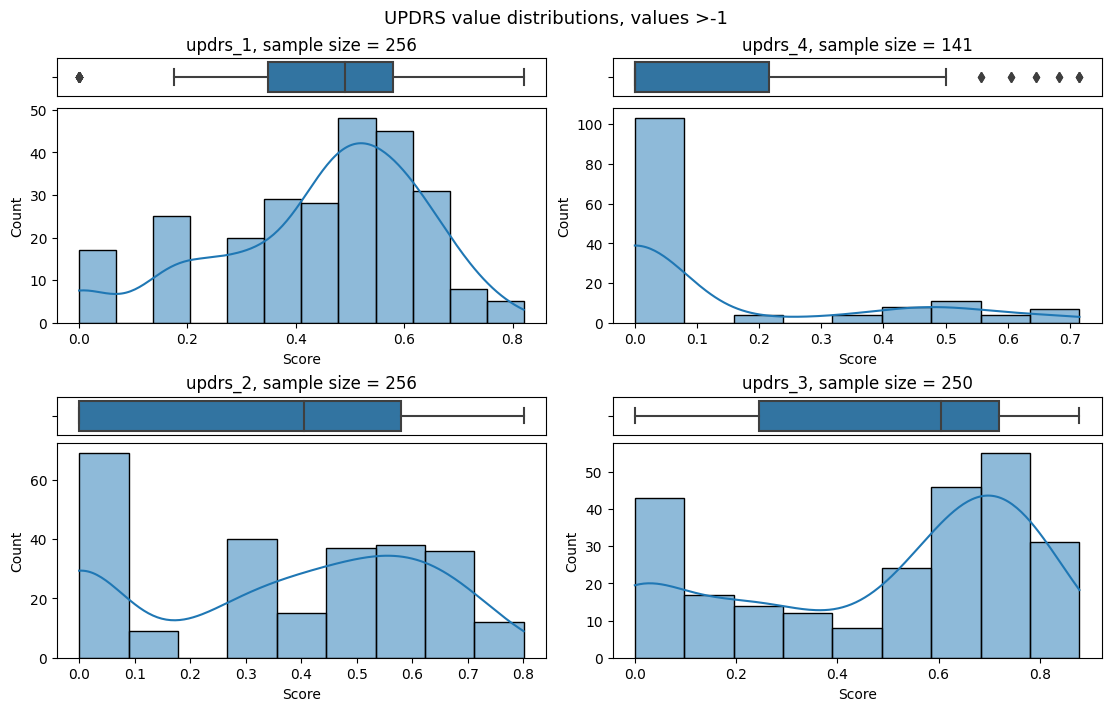

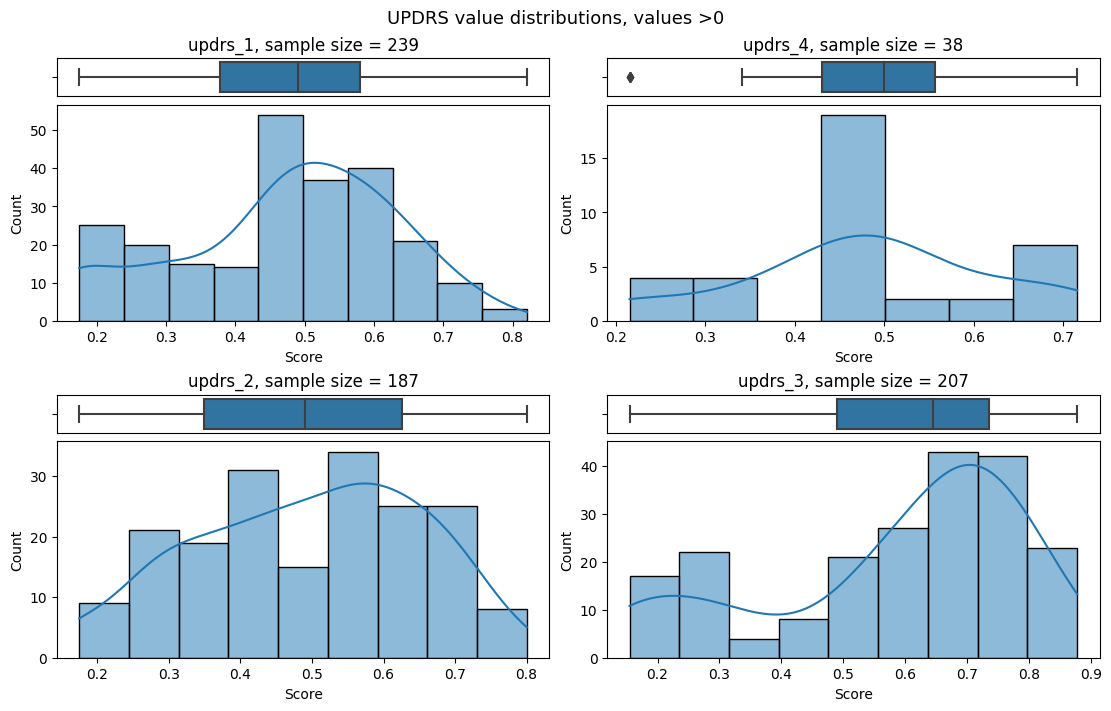

In [39]:
#plotTargets from https://www.kaggle.com/code/adityarahul/eda-linearregression
import seaborn as sns
import matplotlib.pyplot as plt

def plotTargets(minmalTreshold = 0, logScale = False):
    # colors = ["green", "yellow", "orange"]
    # sns.set_palette(sns.color_palette(colors))
    f, axes = plt.subplots(4, 2, layout="constrained",
                            gridspec_kw={"height_ratios": (.15, .85, .15, .85)}, figsize=(11, 7))
    f.suptitle('UPDRS value distributions, values >'+str(minmalTreshold), fontsize=13)
    for i in [0,2]:
        for j in [0,1]:#range(len(targetVars)):
            u = targetVars[i+j]
            data = pd.concat([t_[u][k] for k in range(1)])#range(len(targetVars))
            subData = data[data[u]>minmalTreshold]# if isWithoutZero else data
            x = subData['l'+u] if logScale else subData[u]
            splot = sns.boxplot(ax=axes[i][j], x=x)
            splot.axes.get_xaxis().set_visible(False)
            splot.set_title(u+', sample size = '+str(len(subData)))
            splot = sns.histplot(ax=axes[i+1][j], x=x, kde=True, alpha=0.5, ec='black')
            splot.set_xlabel('Score')
            splot.set_ylabel('Count')
            # splot.set_title(u)
    plt.show()
plotTargets(minmalTreshold = -1, logScale = True)
plotTargets(minmalTreshold = 0, logScale = True)

In [40]:
for u in targetVars:
    for i in range(nDataSubsets):
        print('********************* train', u, 'paritiion', str(i),' *********************')
        print(t_[u][i].info())
        # print('********************* validation', u, '*********************')
        # print(v_[u].info())

********************* train updrs_1 paritiion 0  *********************
<class 'pandas.core.frame.DataFrame'>
Index: 256 entries, 3 to 1109
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   visit_month         256 non-null    int64  
 1   pe_SSFVAPLEK        256 non-null    float64
 2   pe_WYEIEKIPTTFENGR  256 non-null    float64
 3   pe_VGYVSGWGR        256 non-null    float64
 4   updrs_1             256 non-null    float64
 5   lupdrs_1            256 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 14.0 KB
None
********************* train updrs_1 paritiion 1  *********************
<class 'pandas.core.frame.DataFrame'>
Index: 509 entries, 0 to 1109
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   visit_month         509 non-null    int64  
 1   pe_SSFVAPLEK        509 non-null    float64
 2   pe_WYEIEK

In [41]:
for u in targetVars:
    for i in range(nDataSubsets):
        print('********************* train', u, 'paritiion', str(i),' *********************')
        # print('number of patients: ', t_[u].patient_id.nunique())
        try: 
            print('maximal number of visits: ', t_[u][i].visit_month.nunique())#in the original tv_clinical there were 17 visits...
        except:
            print('maximal number of visits not found: This UPDRS is dependent of a time-dependent UPDRS')
        # print('number of proteins: ', t_[u].UniProt.nunique())
        # print('number of pepitides in the training set: ', t_[u][i].Peptide.nunique())
        # print('**************', u, ' validation **************')
        # print('number of patients: ', t_[u].patient_id.nunique())
        # print('maximal number of visits: ', v_[u].visit_month.nunique())#in the original tv_clinical there were 17 visits...
        # print('number of proteins: ', v_[u].UniProt.nunique())
        # print('number of pepitides in the training set: ', v_[u].Peptide.nunique())


********************* train updrs_1 paritiion 0  *********************
maximal number of visits:  13
********************* train updrs_1 paritiion 1  *********************
maximal number of visits:  14
********************* train updrs_1 paritiion 2  *********************
maximal number of visits:  15
********************* train updrs_1 paritiion 3  *********************
maximal number of visits:  13
********************* train updrs_4 paritiion 0  *********************
maximal number of visits:  13
********************* train updrs_4 paritiion 1  *********************
maximal number of visits:  13
********************* train updrs_4 paritiion 2  *********************
maximal number of visits:  14
********************* train updrs_4 paritiion 3  *********************
maximal number of visits:  9
********************* train updrs_2 paritiion 0  *********************
maximal number of visits:  13
********************* train updrs_2 paritiion 1  *********************
maximal number of vis

In [42]:
#Verifying how much missing values we have in each column per dependent variable data set
for u in targetVars:
    for i in range(nDataSubsets):
        print('********************* missing values in the train', u, 'paritiion', str(i),' *********************')
        print(t_[u][i].isnull().sum().value_counts())


********************* missing values in the train updrs_1 paritiion 0  *********************
0    6
Name: count, dtype: int64
********************* missing values in the train updrs_1 paritiion 1  *********************
0    6
Name: count, dtype: int64
********************* missing values in the train updrs_1 paritiion 2  *********************
0    6
Name: count, dtype: int64
********************* missing values in the train updrs_1 paritiion 3  *********************
0    6
Name: count, dtype: int64
********************* missing values in the train updrs_4 paritiion 0  *********************
0    5
Name: count, dtype: int64
********************* missing values in the train updrs_4 paritiion 1  *********************
0    5
Name: count, dtype: int64
********************* missing values in the train updrs_4 paritiion 2  *********************
0    5
Name: count, dtype: int64
********************* missing values in the train updrs_4 paritiion 3  *********************
0    5
Name: count, dtype

In [43]:
#separating target and features
x_t = {}; y_t= {}; #x_v= {}; y_v= {}; #X and Y variables per updrs
for u in targetVars:
    x_t[u] = {}; y_t[u]= {};
    for i in range(nDataSubsets):
        x_t[u][i] = t_[u][i][quantiVars[u]]#, v_[u][quantiVars[u]]
        y_t[u][i] = t_[u][i][[u, 'l'+u]]#, v_[u][[u, 'l'+u]]


In [44]:
display(x_t[u2][0])
display(y_t[u2][0])

,visit_month,updrs_1,updrs_4,pe_LKC(UniMod_4)DEWSVNSVGK
3,0,2.0,NaN,84839.5
10,0,12.0,NaN,118653.0
15,0,4.0,NaN,91353.8
18,0,17.0,4.0,117532.0
23,0,0.0,0.0,100367.0
...,...,...,...,...
1100,84,5.0,NaN,127780.0
1103,84,6.0,4.0,54681.5
1104,84,7.0,3.0,74387.2
1107,96,19.0,4.0,103172.0


,updrs_2,lupdrs_2
3,0.0,0.000000
10,7.0,0.523750
15,0.0,0.000000
18,13.0,0.664701
23,0.0,0.000000
...,...,...
1100,1.0,0.174583
1103,14.0,0.682078
1104,3.0,0.349167
1107,15.0,0.698334


In [45]:
#sample sizes per target
for u in targetVars:
    print(u, 'sample size =', len(y_t[u][0]))

updrs_1 sample size = 256
updrs_4 sample size = 141
updrs_2 sample size = 256
updrs_3 sample size = 250


# Regression
[Reference: Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. O'Reilly Media. 2019](https://universidadefe957-my.sharepoint.com/:b:/g/personal/paulo_firmino_ufca_edu_br/Ec_UL4nCLQRGnFpftnOkv5ABrePEllnHLR7rrqPreAvn6A?e=RFGcMB)

In [46]:
t_[u2][0].columns

Index(['visit_month', 'updrs_1', 'updrs_4', 'pe_LKC(UniMod_4)DEWSVNSVGK',
       'updrs_2', 'lupdrs_2'],
      dtype='object')

## Preprocessing

In [47]:
#Verifying the observed min and max per target variable
for u in targetVars:
    for i in range(nDataSubsets):
        print('**************', u, ' train', i, '**************')
        print('observed min=', t_[u][i][u].min())    
        print('observed max=', t_[u][i][u].max())
        print('theoretical min=', 0)    
        print('theoretical max=', theoreticalMax[u])
        print('logp1 theoretical max=', ltheoreticalMax[u])
        # print('**************', u, ' validation **************')
        # print('observed min=', v_[u][u].min())    
        # print('observed max=', v_[u][u].max())


************** updrs_1  train 0 **************
observed min= 0.0
observed max= 25.0
theoretical min= 0
theoretical max= 52
logp1 theoretical max= 3.970291913552122
************** updrs_1  train 1 **************
observed min= 0.0
observed max= 28.0
theoretical min= 0
theoretical max= 52
logp1 theoretical max= 3.970291913552122
************** updrs_1  train 2 **************
observed min= 0.0
observed max= 33.0
theoretical min= 0
theoretical max= 52
logp1 theoretical max= 3.970291913552122
************** updrs_1  train 3 **************
observed min= 0.0
observed max= 27.0
theoretical min= 0
theoretical max= 52
logp1 theoretical max= 3.970291913552122
************** updrs_4  train 0 **************
observed min= 0.0
observed max= 9.0
theoretical min= 0
theoretical max= 24
logp1 theoretical max= 3.2188758248682006
************** updrs_4  train 1 **************
observed min= 0.0
observed max= 13.0
theoretical min= 0
theoretical max= 24
logp1 theoretical max= 3.2188758248682006
************** 

In [48]:
display(t_[u3][3])

,visit_month,updrs_1,updrs_2,updrs_4,pe_AYQGVAAPFPK,pe_PIVTSPYQIHFTK,updrs_3,lupdrs_3
1,0,11.0,6.0,5.0,85981.8,43751.5,25.0,0.727686
6,0,6.0,1.0,NaN,162856.0,26253.2,0.0,0.000000
13,0,5.0,11.0,NaN,38683.9,47951.8,9.0,0.514276
19,0,3.0,0.0,0.0,49714.9,39944.5,13.0,0.589426
29,0,3.0,2.0,NaN,183544.0,62797.9,0.0,0.000000
...,...,...,...,...,...,...,...,...
1097,84,4.0,0.0,NaN,99535.7,42343.1,0.0,0.000000
1101,84,7.0,0.0,NaN,105973.0,40332.4,6.0,0.434613
1102,84,26.0,20.0,9.0,110732.0,52524.5,41.0,0.834798
1108,96,7.0,0.0,NaN,72729.4,58225.8,5.0,0.400184


### Pipelines for aggregating inputation, standasdization, one-hot enconding, and PCA

In [49]:
#!pip install --upgrade scikit-learn

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # , MinMaxScaler
# from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

from scipy.stats import norm
from sklearn.compose import ColumnTransformer
class OutlierComputation (BaseEstimator, TransformerMixin): #inspired on Geron 
    def __init__(self, z = 2, outProb = None):
        self.z = z
        self.outProb = outProb
        if outProb is None:
            self.qLower = -np.abs(z)
            self.qUpper = -self.qLower#dist.ppf(1-prLower)
        else:
            dist = norm(loc = 0, scale = 1)#Omega_X = {x\in R}
            prLower = outProb if outProb <= .5 else 1 - outProb 
            prLower = prLower/2
            self.qLower = dist.ppf(prLower)
            self.qUpper = -self.qLower#dist.ppf(1-prLower)

    def fit(self, X, y = None): 
        return self 
    def transform(self, X):  
        isUpperOutlier =  (X > self.qUpper).astype(int)      
        isLowerOutlier =  (X < self.qLower).astype(int)
        ret = np.concatenate((X, isLowerOutlier, isUpperOutlier), axis=1)      
        return ret

quantiPipeline = {}; fullPipeline =  {}
for u in targetVars:
    if isWithPCA[u]:
        quantiPipeline[u] = Pipeline([('Imputer', SimpleImputer(strategy="constant", fill_value=0, add_indicator=False)),
                            ('Log1p', FunctionTransformer(func=np.log1p, validate=True)),
                            ('Std_scaler_1', StandardScaler()),
                            ('PCA', PCA(n_components=nPcaComponents[u])),
                            ('Std_scaler_2', StandardScaler()),
                            ('Outliers', OutlierComputation(outProb=outlierProbability)),
                            ('Std_scaler_3', StandardScaler()),
                            ])
    else:
        quantiPipeline[u] = Pipeline([('Imputer', SimpleImputer(strategy="constant", fill_value=0, add_indicator=False)),
                        ('Log1p', FunctionTransformer(func=np.log1p, validate=True)),
                        ('Std_scaler_1', StandardScaler()),
                        ('Outliers', OutlierComputation(outProb=outlierProbability)),
                        ('Std_scaler_2', StandardScaler()),#undo the comment
                        ])
    # print('**********************', u, 'Transformer **********************')
    fullPipeline[u] = ColumnTransformer([("qt", quantiPipeline[u], quantiVars[u])]) 
fullPipeline[u1]                        


ColumnTransformer(transformers=[('qt',
                                 Pipeline(steps=[('Imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('Log1p',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('Std_scaler_1',
                                                  StandardScaler()),
                                                 ('Outliers',
                                                  OutlierComputation(outProb=0.5)),
                                                 ('Std_scaler_2',
                                                  StandardScaler())]),
                                 ['visit_month', 'pe_SSFVAPLEK',
                                  'pe_WYEIEKIPTTFENGR', 'pe_VGYVSGWGR'])])

In [51]:
x_tTransf = {}
for u in targetVars:
    x_tTransf[u] = {}
    colNames = x_t[u][0].columns if not isWithPCA[u] else ['C'+str(i) for i in range(nPcaComponents[u])]  
    colNames = list(colNames)
    colNames_outliers = [x+'_isLowerOutlier' for x in colNames] + [x+'_isUpperOutlier' for x in colNames] 
    colNames += colNames_outliers
    x_tTransf[u][0] = pd.DataFrame(fullPipeline[u].fit_transform(x_t[u][0]), columns = colNames)
    for i in range(1, nDataSubsets):
        # print('**********************', u, 'partition', str(i), 'fit_transform **********************')
        x_tTransf[u][i] = pd.DataFrame(fullPipeline[u].transform(x_t[u][i]), columns = colNames)

In [52]:
x_tTransf[u2][0]#.describe()

,visit_month,updrs_1,updrs_4,pe_LKC(UniMod_4)DEWSVNSVGK,visit_month_isLowerOutlier,updrs_1_isLowerOutlier,updrs_4_isLowerOutlier,pe_LKC(UniMod_4)DEWSVNSVGK_isLowerOutlier,visit_month_isUpperOutlier,updrs_1_isUpperOutlier,updrs_4_isUpperOutlier,pe_LKC(UniMod_4)DEWSVNSVGK_isUpperOutlier
0,-1.838066,-0.870083,-0.398639,0.069047,2.055356,1.768907,0.0,-0.249481,-0.565321,-0.637647,-0.417507,0.0
1,-1.838066,1.058096,-0.398639,0.254136,2.055356,-0.565321,0.0,-0.249481,-0.565321,1.568266,-0.417507,0.0
2,-1.838066,-0.198366,-0.398639,0.109867,2.055356,-0.565321,0.0,-0.249481,-0.565321,-0.637647,-0.417507,0.0
3,-1.838066,1.486015,2.390022,0.248898,2.055356,-0.565321,0.0,-0.249481,-0.565321,1.568266,2.395171,0.0
4,-1.838066,-2.314718,-0.398639,0.161785,2.055356,1.768907,0.0,-0.249481,-0.565321,-0.637647,-0.417507,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
251,1.251116,0.041380,-0.398639,0.295027,-0.486534,-0.565321,0.0,-0.249481,1.768907,-0.637647,-0.417507,0.0
252,1.251116,0.244082,2.390022,-0.173313,-0.486534,-0.565321,0.0,-0.249481,1.768907,-0.637647,2.395171,0.0
253,1.251116,0.419671,2.003383,-0.003499,-0.486534,-0.565321,0.0,-0.249481,1.768907,-0.637647,2.395171,0.0
254,1.342943,1.624560,2.390022,0.176994,-0.486534,-0.565321,0.0,-0.249481,1.768907,1.568266,2.395171,0.0


In [53]:
#PCA
#from https://medium.com/@andymdc31/using-pca-in-a-machine-learning-pipeline-b6fe3492b1b9
def performPCAstudy():#just for nPcaComponents = None
    for u in targetVars:
        if isWithPCA[u]:
            print('************** PCA', u, '************')#, pd.DataFrame(X_pca, columns = ['C_'+str(i) for i in range(X_pca.shape[1])]))
            pca = fullPipeline[u].transformers_[0][1].steps[3][1]
            # X_pca = pca.fit_transform(x_tTransf[u])
            total_explained_variance = pca.explained_variance_ratio_.cumsum()
            # n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
            # n_to_reach_95 = len(total_explained_variance) - n_over_95 + 1
            print('Number features: {}\tTotal Variance Explained: {}'.format(nPcaComponents[u], total_explained_variance))

            n_pcs= pca.components_.shape[0]
            initial_feature_names = x_t[u][0].columns
            most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
            most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
            # zipped_feats = zip(most_important_names, pipe.steps[2][1].feature_importances_)
            # zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
            # features, importances = zip(*zipped_feats)
            top_features = most_important_names[:np.min([n_pcs, 5])]
            top_importances = most_important[:np.min([n_pcs, 5])]
            plt.title('Feature Importance')
            plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
            plt.yticks(range(len(top_importances)), top_features)
            plt.xlabel('Relative Importance')
            plt.show()    
performPCAstudy()

In [54]:
# print(fullPipeline[targetVars[0]].get_feature_names_out()[:10])
x_t[targetVars[0]][3]

,visit_month,pe_SSFVAPLEK,pe_WYEIEKIPTTFENGR,pe_VGYVSGWGR
1,0,98083.6,718404.0,905784.00
6,0,128860.0,2257530.0,794554.00
13,0,67152.8,867466.0,994121.00
19,0,95513.6,723167.0,949242.00
29,0,113592.0,1251920.0,482242.00
...,...,...,...,...
1097,84,132624.0,1341530.0,315593.00
1101,84,114594.0,0.0,2511.66
1102,84,142305.0,888803.0,237633.00
1108,96,69628.6,1222590.0,460030.00


In [55]:
x_tTransf[u3][3]

,visit_month,updrs_1,updrs_2,updrs_4,pe_AYQGVAAPFPK,pe_PIVTSPYQIHFTK,visit_month_isLowerOutlier,updrs_1_isLowerOutlier,updrs_2_isLowerOutlier,updrs_4_isLowerOutlier,pe_AYQGVAAPFPK_isLowerOutlier,pe_PIVTSPYQIHFTK_isLowerOutlier,visit_month_isUpperOutlier,updrs_1_isUpperOutlier,updrs_2_isUpperOutlier,updrs_4_isUpperOutlier,pe_AYQGVAAPFPK_isUpperOutlier,pe_PIVTSPYQIHFTK_isUpperOutlier
0,-1.817347,0.946639,0.506379,2.669672,0.167926,0.216632,2.025350,-0.561951,-0.667148,0.0,-0.598912,-0.234206,-0.782881,1.572330,-0.711354,2.361980,-0.580429,0.0
1,-1.817347,0.235557,-0.719133,-0.404165,1.352551,0.003200,2.025350,-0.561951,1.498917,0.0,-0.598912,-0.234206,-0.782881,-0.635999,-0.711354,-0.423374,1.722862,0.0
2,-1.817347,0.032191,1.033651,-0.404165,-1.313396,0.254941,2.025350,-0.561951,-0.667148,0.0,1.669694,-0.234206,-0.782881,-0.635999,1.405770,-0.423374,-0.580429,0.0
3,-1.817347,-0.502727,-1.397202,-0.404165,-0.848105,0.178589,2.025350,-0.561951,1.498917,0.0,1.669694,-0.234206,-0.782881,-0.635999,-0.711354,-0.423374,-0.580429,0.0
4,-1.817347,-0.502727,-0.322488,-0.404165,1.574346,0.367657,2.025350,-0.561951,-0.667148,0.0,-0.598912,-0.234206,-0.782881,-0.635999,-0.711354,-0.423374,1.722862,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,1.248497,-0.208340,-1.397202,-0.404165,0.439411,0.202959,-0.493742,-0.561951,1.498917,0.0,-0.598912,-0.234206,1.277333,-0.635999,-0.711354,-0.423374,-0.580429,0.0
287,1.248497,0.411721,-1.397202,-0.404165,0.555638,0.182628,-0.493742,-0.561951,1.498917,0.0,-0.598912,-0.234206,1.277333,-0.635999,-0.711354,-0.423374,-0.580429,0.0
288,1.248497,2.016474,1.581094,3.546015,0.637111,0.293004,-0.493742,-0.561951,-0.667148,0.0,-0.598912,-0.234206,1.277333,1.572330,1.405770,2.361980,-0.580429,0.0
289,1.339631,0.411721,-1.397202,-0.404165,-0.142523,0.336067,-0.493742,-0.561951,1.498917,0.0,-0.598912,-0.234206,1.277333,-0.635999,-0.711354,-0.423374,-0.580429,0.0


### Prelminaries

In [56]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, \
     r2_score, mean_absolute_percentage_error

#predictions
def getLogPrediction(yModel, x, eModel = None):
    x_initialModels = None
    try:
        x_initialModels = x if 'Comb' in type(yModel).__name__ else x[['visit_month']] 
    except:
        x_initialModels = x
    y_pred = yModel.predict(x_initialModels) #if type(yModel).__name__ != 'TfMLPRegressor' else yModel.predict(x, verbose=False)   
    if eModel is not None:
        nPreds = len(y_pred)
        e_pred = eModel.predict(x)
        for i in range(nPreds):
            y_pred[i] += e_pred[i]
    return y_pred
def getPrediction(targetVar, y_logPredictions):
    nPreds = len(y_logPredictions)
    y_pred = [0]*nPreds
    for i in range(nPreds):
        y_pred[i] = np.expm1(y_logPredictions[i]*ltheoreticalMax[u])
        y_pred[i] = np.round(y_pred[i])
        if y_pred[i] > theoreticalMax[targetVar]:
           y_pred[i] = theoreticalMax[targetVar]
        elif y_pred[i] < 0:
            y_pred[i] = 0
    return y_pred

# models performance
def SMAPE(target, forecast):
    if not all([isinstance(target, np.ndarray), isinstance(forecast, np.ndarray)]):
        target, forecast = np.array(target)+1, np.array(forecast)+1
    SAPE = np.abs(target - forecast) / ((np.abs(forecast) + np.abs(target))/2)
    SAPE[np.isnan(SAPE)] = 0  # in the case of target=forecast=0
    return round(100*np.mean(SAPE), 4)

models_target = []; models_label = []
models_r2_t = []; models_r2_v = []
models_rmse_t = []; models_rmse_v = []
models_rmsle_t = []; models_rmsle_v = []
models_mae_t = []; models_mae_v = []
models_mape_t = []; models_mape_v = []
models_smape_t = []; models_smape_v = []; models_smape_dif_vt = []
best_yModels = {}
yLogPredictions = {}; e_yLogPredictions = {}; logSingleModelsObjs = {}
# ySingleModelsNms = {}
for u in targetVars:
    best_yModels[u] = {'yModelObj':None, 'eModelObj':None, 'modelNm':'??', 
                     'smape_t':None, 'smape_v':10**10, 'smape_dif_vt': None, 'smape_vPdiff': 10**10}
    yLogPredictions[u] = {}; e_yLogPredictions[u] = {}; 
    logSingleModelsObjs[u] = {}
    for i in range(nDataSubsets):
        yLogPredictions[u][i] = pd.DataFrame(y_t[u][i]['l'+u])#{'df_t': pd.DataFrame(y_t[u]['l'+u]), 'df_v': pd.DataFrame(y_v[u]['l'+u])}
        e_yLogPredictions[u][i] = pd.DataFrame(index = y_t[u][i].index)#{'df_t': pd.DataFrame(index = y_t[u].index), 'df_v': pd.DataFrame(index = y_v[u].index)}
        # display(e_yLogPredictions[u]['df_t'])


In [57]:
def computePerformanceMeasures(yModel, phase, x_t, y_t, eModel = None, nDigits = 3, printResults = True):
    for u in targetVars:
        # print('************************', u, '************************')
        formalism = getModelName(yModel[u], eModel[u], targetVar="")
        # type_yModel = type(yModel[u])
        # formalism = 'yLog'+type_yModel.__name__.replace('Regressor', '').replace('Regression', '')# if type_yModel != str else yModel[u]
        # if eModel[u] is not None:
        #     formalism += '_e'+type(eModel[u]).__name__.replace('Regressor', '').replace('Regression', '')

        y_tLogPred = getLogPrediction(yModel = yModel[u], x = x_t[u][phase], eModel=eModel[u])# if type_yModel != str else yLogPredictions[u][phase][yModel[u]].values
        y_vLogPred = getLogPrediction(yModel = yModel[u], x = x_t[u][3], eModel=eModel[u])# if type_yModel =! str else yLogPredictions[u][3][yModel[u]].values
        e_y_tLogPred = y_t[u][phase]['l'+u] - y_tLogPred
        e_y_vLogPred = y_t[u][3]['l'+u] - y_vLogPred
        e_yLogPredictions[u][phase][formalism] = e_y_tLogPred
        e_yLogPredictions[u][3][formalism] = e_y_vLogPred
        # if type_yModel != str:
        yLogPredictions[u][phase][formalism] = y_tLogPred
        yLogPredictions[u][3][formalism] = y_vLogPred
        if phase < 2:
            yLogPredictions[u][phase+1][formalism] = getLogPrediction(yModel = yModel[u], x = x_t[u][phase+1], eModel=eModel[u])
            e_yLogPredictions[u][phase+1][formalism] = y_t[u][phase+1]['l'+u] - getLogPrediction(yModel = yModel[u], x = x_t[u][phase+1], eModel=eModel[u])
        formalism += ('_'+u)
        logSingleModelsObjs[u][formalism] = {'yModel':yModel[u], 'eModel':eModel[u]}
        models_target.append(u)
        models_label.append(formalism)
        y_tPred = getPrediction(targetVar = u, y_logPredictions = y_tLogPred)
        y_vPred = getPrediction(targetVar = u, y_logPredictions = y_vLogPred)
        y_tTrue = y_t[u][phase][u]
        y_vTrue = y_t[u][3][u]
        models_r2_t.append(round(r2_score(y_true=y_tTrue, y_pred=y_tPred), nDigits))
        models_r2_v.append(round(r2_score(y_true=y_vTrue, y_pred=y_vPred),  nDigits))
        models_rmse_t.append(round(mean_squared_error(y_true=y_tTrue, y_pred=y_tPred, squared=False), nDigits))
        models_rmse_v.append(round(mean_squared_error(y_true=y_vTrue, y_pred=y_vPred, squared=False), nDigits))
        # models_rmsle_t.append(float(format(
        #     mean_squared_log_error(y_true=y_train_origin, y_pred=y_train_predict, squared=False), '.2g')))
        # models_rmsle_v.append(float(format(
        #     mean_squared_log_error(y_true=y_valid_origin, y_pred=y_valid_predict, squared=False), '.2g')))
        models_mae_t.append(round(mean_absolute_error(y_true=y_tTrue, y_pred=y_tPred), nDigits))
        mae_v = round(mean_absolute_error(y_true=y_vTrue, y_pred=y_vPred), nDigits)
        models_mae_v.append(mae_v)
        models_mape_t.append(round(mean_absolute_percentage_error(y_true=y_tTrue, y_pred=y_tPred), nDigits))
        models_mape_v.append(round(mean_absolute_percentage_error(y_true=y_vTrue, y_pred=y_vPred), nDigits))
        smape_t = round(SMAPE(y_tTrue, y_tPred), nDigits)
        smape_v = round(SMAPE(y_vTrue, y_vPred), nDigits)
        smape_dif_vt = round(smape_v - smape_t, nDigits)
        smape_vPdiff = smape_v + smape_dif_vt
        models_smape_t.append(smape_t)
        models_smape_v.append(smape_v)
        models_smape_dif_vt.append(smape_dif_vt)
        if smape_vPdiff < best_yModels[u]['smape_vPdiff']:
            best_yModels[u] = {'yModelObj':yModel[u], 'eModelObj':eModel[u], 
                             'modelNm':formalism, 'smape_t':smape_t, 'smape_v':smape_v, 
                             'smape_dif_vt': smape_dif_vt, 'smape_vPdiff': smape_vPdiff}
    if printResults:    
        df = pd.DataFrame({'target':models_target,
                           'model': models_label,
                        #    'mape-t': models_mape_t,
                        #    'mape-v': models_mape_v,
                        'smape_t': models_smape_t,
                        'smape_v': models_smape_v,#}
                        #    'rmsle-t': models_rmsle_t,
                        #    'rmsle-v': models_rmsle_v,
                        #    'r2-t': models_r2_t,
                        #    'r2-v': models_r2_v}  # ,
                        #    'rmse-t': models_rmse_t,
                        #    'rmse-v': models_rmse_v,
                            # 'mae-t': models_mae_t,
                            # 'mae-v': models_mae_v
                        
                        'smape_dif_vt':models_smape_dif_vt}
                        )
        print(" *********** Best models via SMAPE in the validation set *********** ")
        lbestModel = []; lsmape_t = []; lsmape_v = []; lsmape_dif_vt = []
        for u in targetVars:
            lbestModel.append(best_yModels[u]['modelNm'])
            lsmape_t.append(best_yModels[u]['smape_t'])
            lsmape_v.append(best_yModels[u]['smape_v'])
            lsmape_dif_vt.append(best_yModels[u]['smape_dif_vt'])
            # print('bestModel:', best_yModels[u]['modelNm'], ', smape_t:', best_yModels[u]['smape_t']
            #       , ', smape_v:', best_yModels[u]['smape_v']
            #       , ', smape_dif_vt:', best_yModels[u]['smape_dif_vt'])
        dfOpt = pd.DataFrame.from_dict({'bestModel': lbestModel, 'smape_t':lsmape_t,
                'smape_v': lsmape_v, 'smape_dif_vt':lsmape_dif_vt})
        dfOpt = dfOpt.sort_values(by=["smape_v", 'smape_dif_vt', 'smape_t'], ascending=True)
        display(dfOpt)
        dfOpt.to_csv(RESULTS_ROOT+'bestModelsPerformance.csv', sep='\t', index=False)
        print(" *********** Rank via SMAPE in the validation set *********** ")
        df = df.sort_values(by=['target', "smape_v", 'smape_dif_vt', 'smape_t'], ascending=True)
        display(df)
        df.to_csv(RESULTS_ROOT+'modelsPerformance.csv', sep='\t', index=False)
    # return(df.sort_values(by=["mae-v", 'mae-t'], ascending=True))


In [58]:
# probabilistic optimization via BayesSearchCV and GridSearchCV
#https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f
# %pip install scikit-optimize
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV 
# import tensorflow as tf 
from tensorflow import keras 
# from skopt.plots import plot_objective
# from skopt.space import Real, Categorical, Integer

def getOptimalModel(modelObj, parsInfo, x_train, y_train, verbose=False, 
                                    epochs=500, batch_size=50,validation_split=.2, method = optMethod):
    # log-uniform: understand as search over p = exp(x) by varying x
    opt = None
    if method == 'GridSearchCV':
        opt = GridSearchCV(modelObj, parsInfo, cv = myCv, 
                       scoring = 'neg_root_mean_squared_error',#'neg_mean_absolute_percentage_error', #'neg_root_mean_squared_error'
                           return_train_score = True, verbose=verbose)
    else:
        opt = BayesSearchCV(modelObj, parsInfo, cv = myCv, n_iter = 50 if isInKaggle else 10,
                       scoring = 'neg_root_mean_squared_error',#'neg_mean_absolute_percentage_error', #'neg_root_mean_squared_error'
                           return_train_score = True, verbose=verbose) 
    modelClass = type(modelObj).__name__
    print('**', modelClass, '**')
    if modelClass == 'MultiOutputRegressor' or modelClass == 'TfMLPRegressor' or modelClass == 'TfRNNRegressor':
        opt.fit(X = x_train, y = y_train)#.values.ravel())
    # elif modelClass == 'TfMLPRegressor':
    #     opt.fit(X = x_train, y = y_train, #.values.ravel(), 
    #             epochs=epochs, batch_size=batch_size, verbose=False, 
    #             validation_split=validation_split, 
    #             callbacks = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True))
    else: 
        opt.fit(X = x_train, y = y_train.values.ravel())
    # parNames = [name for name, value in parsDists.items()]
    # _ = plot_objective(opt.optimizer_results_[0],
    #                 dimensions=parNames,
    #                 n_minimum_search=int(1e8))
    # plt.show()
    print('best_params = ', opt.best_params_)
    print('best_score (RMSE)= ', np.sqrt(-opt.best_score_))
    model = opt.best_estimator_
    return (model)

## Initial Models

### UPDRS and peptides Regression

In [59]:
# modeling each log-UPDRS and transformed peptides
# from https://www.kaggle.com/code/renataghisloti/linearregression-simple-70-smape?scriptVersionId=120868178&cellId=6
# from sklearn.model_selection import cross_val_score

yModels = {}; e_yModels = {}; xModels = {}; predVars = {}
gridLinear = {'fit_intercept': [True, False]}
gridSVR = {'kernel': ['poly', 'rbf', 'sigmoid'],#'linear', 
           'C':[.05, 1, 1.2], 
           'epsilon': [.05, .1, .2]}
parsDistsSVR = {'kernel': ['poly', 'rbf', 'sigmoid'],  #'linear', 
                'degree': (2, 5),  # integer valued parameter (1, 5)
                'gamma': (.01, 1, 'uniform'),
                'coef0': (-2, 2, 'uniform'),
                'C': (.05, 1.5, 'log-uniform'),
                'epsilon': (.05, .2, 'log-uniform')
                }
gridTree = {
            'min_samples_leaf': [2, 5, 50, 80, 100, 150],
            'min_samples_split': [20, 50, 500, 1000],
}
parsDistsTree = {
            'min_samples_leaf': (2, 150),
            'min_samples_split': (20, 1000),
}
gridLg = {'max_depth': [-1, 1, 10, 50],
    # 'learning_rate':(.1, 2, 'uniform'),
    'n_estimators': [2, 5, 50, 100]}
parsDistsLg = {'max_depth': (-1, 50),
    'learning_rate':(.1, 1, 'uniform'),
    'n_estimators': (2, 200)}

gridForest = {'n_estimators':[5, 10, 100, 200],
            'min_samples_split': [2, 40, 50, 500],
}
parsDistsForest = {
            'n_estimators': (5, 200),
            'min_samples_split': (2, 500),
}
gridXg = {'max_depth': [1, 5, 6, 10],  # integer valued parameter
        #   'n_estimators': (3, 10, 20)
        'eta': [.1, 0.3, .6],
        'gamma': [0, 1, 2],}
parsDistsXgb = {  # 'splitter': ["best", "random"],  # categorical parameter
    'max_depth': (1, 10),  # integer valued parameter
    'n_estimators': (2, 100),
    'eta': (.01, .6, 'log-uniform'),
    'colsample_bytree': (.2, 1, 'log-uniform')
}
parsDistsTfMLP = {
    'learningRate': (1e-4, 1e-1, 'uniform'),
    'inpute_layer_dropout_rate': (0, .5, 'uniform')
}
parsDistsTfRNN = {
    'learningRate': (1e-4, 1e-1, 'uniform'),
    'inpute_layer_dropout_rate': (0, .5, 'uniform')
}

for u in targetVars:
    e_yModels[u] = {}#'yLogLinear': None, 'yLogSVR': None, 'yLogDecisionTree':None}
    predVars[u] = list(x_t[u][0].columns).copy()
    if 'visit_month' in predVars[u]:
        predVars[u].remove('visit_month')
    print('\n ************ yModels', u,  '************')
    x = x_tTransf[u][0] if isWithPCA[u] else x_tTransf[u][0][['visit_month']]; 
    y = y_t[u][0]['l'+u]
    min_samples_split = round(.15*len(x))
    # print('min_samples_split=', min_samples_split)
    yModels[u] = {}
    if isToRunInitialModels['LinearRegression']: yModels[u]['yLogLinear'] =  initialModelsObjs['LinearRegression'][u].fit(x, y) if not isWithOptimization[u] else  getOptimalModel(LinearRegression(), gridLinear, x, y, False, 'GridSearchCV')
    if isToRunInitialModels['SVR']: yModels[u]['yLogSVR'] = initialModelsObjs['SVR'][u].fit(x, y) if not isWithOptimization[u] else  getOptimalModel(SVR(), parsDistsSVR, x, y, False, 'BayesSearchCV')
    if isToRunInitialModels['MyLGBMRegressor']: yModels[u]['yLogMyLGBM'] = initialModelsObjs['MyLGBMRegressor'][u].fit(x, y) if not isWithOptimization[u] else getOptimalModel(MyLGBMRegressor(u, random_state=0), parsDistsLg, x, y, False, 'BayesSearchCV')
    if isToRunInitialModels['DecisionTreeRegressor']: yModels[u]['yLogDecisionTree'] = initialModelsObjs['DecisionTreeRegressor'][u].fit(x, y) if not isWithOptimization[u] else getOptimalModel(DecisionTreeRegressor(random_state=0), parsDistsTree, x, y, False, 'BayesSearchCV')
    if isToRunInitialModels['RandomForestRegressor']: yModels[u]['yLogRandomForest'] = initialModelsObjs['RandomForestRegressor'][u].fit(x, y) if not isWithOptimization[u] else getOptimalModel(RandomForestRegressor(random_state=0), gridForest, x, y, False, 'BayesSearchCV')
    if isToRunInitialModels['MyXGBRegressor']: yModels[u]['yLogMyXGB'] = initialModelsObjs['MyXGBRegressor'][u].fit(x, y) if not isWithOptimization[u] else getOptimalModel(MyXGBRegressor(u, objective='reg:squarederror', seed=0), parsDistsXgb, x, y, False, 'BayesSearchCV')
    if isToRunInitialModels['TfMLPRegressor']: yModels[u]['yLogTfMLP'] = initialModelsObjs['TfMLPRegressor'][u].fit(x, y) if not isWithOptimization[u] else getOptimalModel(TfMLPRegressor(u, 'initialModel'), parsDistsTfMLP, x, y, False, 'BayesSearchCV')
    if isToRunInitialModels['TfRNNRegressor']: yModels[u]['yLogTfRNN'] = initialModelsObjs['TfRNNRegressor'][u].fit(x, y) if not isWithOptimization[u] else getOptimalModel(TfRNNRegressor(u, 'initialModel'), parsDistsTfRNN, x, y, False, 'BayesSearchCV')
    for yModel in yModels[u]: e_yModels[u][yModel] = None
   # print('************ xModels', u, '************')
    x = x_t[u][0]['visit_month']; y = x_tTransf[u][0]#x_t[u][predVars[u]]
    if not isWithPCA[u]: x = x_tTransf[u][0]['visit_month']; y = x_tTransf[u][0][predVars[u]]
    xModels[u] = {}
    if isToRunXModels['xTransfLinear']: xModels[u]['xTransfLinear']= LinearRegression().fit(X=x.values.reshape(-1, 1), y=y)
    if isToRunXModels['xTransfXg']: xModels[u]['xTransfXg']= xg.XGBRegressor(objective='reg:squarederror', seed=0).fit(X=x, y=y)
    if isToRunXModels['xTransfSVR']: xModels[u]['xTransfSVR']= MultiOutputRegressor(SVR(verbose=False)).fit(X = x.values.reshape(-1, 1), y = y)

#     xTransfXg[u] = getOptimalModelViaBayesSearchCv(MyXGBRegressor(objective ='reg:squarederror', seed=0), parsDistsXgb,
#                                                     x_tTransf[u]['visit_month'],
#                                                     x_tTransf[u][predVars[u]], False)



 ************ yModels updrs_1 ************
==**** load_model yLogMyLGBM_updrs_1 ****==
>>> elapsed time: 0.018764257431030273 seconds!
==**** load_model yLogMyXGB_updrs_1 ****==
>>> elapsed time: 0.015614032745361328 seconds!

 ************ yModels updrs_4 ************
==**** load_model yLogMyLGBM_updrs_4 ****==
>>> elapsed time: 0.011151790618896484 seconds!
==**** load_model yLogMyXGB_updrs_4 ****==
>>> elapsed time: 0.008867502212524414 seconds!

 ************ yModels updrs_2 ************
==**** load_model yLogMyLGBM_updrs_2 ****==
>>> elapsed time: 0.007005453109741211 seconds!
==**** load_model yLogMyXGB_updrs_2 ****==
>>> elapsed time: 0.019861221313476562 seconds!

 ************ yModels updrs_3 ************
==**** load_model yLogMyLGBM_updrs_3 ****==
>>> elapsed time: 0.015625 seconds!
==**** load_model yLogMyXGB_updrs_3 ****==
>>> elapsed time: 0.009506940841674805 seconds!


In [60]:
# initialModelsObjs['MyXGBRegressor'][u1]

In [61]:
#rankPeptidesModels
best_xModels = {}
def rankPeptidesModels():
    dic = {'target':[], 'xModel':[], 'MAPE_t':[], 'MAPE_v':[], 'MAPE_v - MAPE_t':[]}
    for u in targetVars:
        best_xModels[u] = {'xModelObj':None, 'eModelObj':None, 'modelNm':'??', 
                           'MAPE_t':10**10, 'MAPE_v':10**10, 'MAPE_v - MAPE_t':10**10}
        for xModel in xModels[u]:
            # print('***********', type(xModels[u][xModel]).__name__, u, end='\n ')
            formalism = xModel#type(xModels[u][xModel]).__name__.replace('Regressor', '').replace('Regression', '')
            formalism += ('_'+u)
            # if eModel[u] is not None:
            #     formalism += '_e'+type(eModel[u]).__name__
            #     formalism = formalism.replace('Regressor', '')
            xTarget_t = x_t[u][0]['visit_month']; yTarget_t = x_tTransf[u][0]
            xTarget_v = x_t[u][3]['visit_month']; yTarget_v = x_tTransf[u][3]
            if not isWithPCA[u]:
                xTarget_t = x_tTransf[u][0]['visit_month']; yTarget_t = x_tTransf[u][0][predVars[u]]
                xTarget_v = x_tTransf[u][3]['visit_month']; yTarget_v = x_tTransf[u][3][predVars[u]]
            yPred_t = xModels[u][xModel].predict(xTarget_t.values.reshape(-1, 1))
            yPred_v = xModels[u][xModel].predict(xTarget_v.values.reshape(-1, 1))
            MAPE_t = round(mean_absolute_percentage_error(y_true=yTarget_t, y_pred=yPred_t), 3)
            MAPE_v = round(mean_absolute_percentage_error(y_true=yTarget_v, y_pred=yPred_v), 3)
            dic['target'].append(u)
            dic['xModel'].append(formalism)
            dic['MAPE_t'].append(MAPE_t)
            dic['MAPE_v'].append(MAPE_v)
            diff = MAPE_v - MAPE_t
            dic['MAPE_v - MAPE_t'].append(diff)
            MAPE_vPlusDiff = MAPE_v + diff
            if MAPE_vPlusDiff < (best_xModels[u]['MAPE_v'] + best_xModels[u]['MAPE_v - MAPE_t']):
                best_xModels[u]['modelNm'] = formalism
                best_xModels[u]['xModelObj'] = xModels[u][xModel]
                best_xModels[u]['MAPE_t'] = MAPE_t
                best_xModels[u]['MAPE_v'] = MAPE_v
                best_xModels[u]['MAPE_v - MAPE_t'] = diff
                # best_xModels[u]['eModelObj'] = None
    print(" *********** Best models via R2 in the validation set *********** ")
    lmodelNm = []; lMAPE_t = []; lMAPE_v = []; lMAPE_v_MAPE_t = []; 
    for u in targetVars:
        lmodelNm.append(best_xModels[u]['modelNm']); 
        # lxModelObj.append(best_xModels[u]['xModelObj']); 
        lMAPE_t.append(best_xModels[u]['MAPE_t']); 
        lMAPE_v.append(best_xModels[u]['MAPE_v']); 
        lMAPE_v_MAPE_t.append(best_xModels[u]['MAPE_v - MAPE_t']); 

    dfBest = pd.DataFrame({'modelNm': lmodelNm, 'MAPE_t':lMAPE_t, 
                           'MAPE_v':lMAPE_v, 'MAPE_v - MAPE_t':lMAPE_v_MAPE_t}).sort_values(by=["MAPE_v", 'MAPE_t', 'MAPE_v - MAPE_t'], ascending=False)
    display(dfBest)
    print(" *********** All models via R2 in the validation set *********** ")
    dfAll = pd.DataFrame(dic).sort_values(by=["target", "MAPE_v", 'MAPE_t', 'MAPE_v - MAPE_t'], ascending=True)
    display(dfAll)

rankPeptidesModels()

 *********** Best models via R2 in the validation set *********** 


,modelNm,MAPE_t,MAPE_v,MAPE_v - MAPE_t
1,xTransfLinear_updrs_4,1.319,1.381,0.062
3,xTransfLinear_updrs_3,1.169,1.177,0.008
2,xTransfLinear_updrs_2,1.109,1.130,0.021
0,xTransfLinear_updrs_1,1.255,1.126,-0.129


 *********** All models via R2 in the validation set *********** 


,target,xModel,MAPE_t,MAPE_v,MAPE_v - MAPE_t
0,updrs_1,xTransfLinear_updrs_1,1.255,1.126,-0.129
2,updrs_1,xTransfSVR_updrs_1,2.434,2.192,-0.242
1,updrs_1,xTransfXg_updrs_1,2.262,2.376,0.114
6,updrs_2,xTransfLinear_updrs_2,1.109,1.130,0.021
8,updrs_2,xTransfSVR_updrs_2,1.220,1.289,0.069
7,updrs_2,xTransfXg_updrs_2,1.338,1.389,0.051
9,updrs_3,xTransfLinear_updrs_3,1.169,1.177,0.008
11,updrs_3,xTransfSVR_updrs_3,1.202,1.289,0.087
10,updrs_3,xTransfXg_updrs_3,1.234,1.395,0.161
5,updrs_4,xTransfSVR_updrs_4,1.065,1.270,0.205


In [62]:
#working with some UPDRS-towards data
def printUPDRSsModelCase():
    for u in targetVars:
        for yModel in yModels[u]:
            print('***********', type(yModels[u][yModel]).__name__, u, '***********')
            # myTarget = targetVars[0]
            some_data = x_t[u][3]#[: 50]
            some_labels = y_t[u][3][u]#[: 50]
            some_data_prepared = pd.DataFrame(fullPipeline[u].transform(some_data), columns=x_tTransf[u][0].columns)
            y_LogPred = getLogPrediction(yModels[u][yModel], some_data_prepared) #[y_p for y_p in yModels[u][yModel].predict(some_data_prepared)]
            y_pred = getPrediction(u, y_LogPred) #np.round(np.expm1(y_pred))

            #y_pred = sum(np.array(y_pred).tolist(), [])
            some_cases = pd.DataFrame({u: some_labels,#[myTarget], 
                                    'yLog reg': y_pred})
            #                           index = some_labels.index)
            # myPlot = some_cases.plot(x=some_cases.columns[1], y=some_cases.columns[0], style='o');
            # myPlot.set_xlabel(some_cases.columns[1])
            # myPlot.set_ylabel(some_cases.columns[0])
            print('corr: \n', some_cases.corr())
            # display(some_cases.head())
            # residuals = some_cases[some_cases.columns[0]] - some_cases[some_cases.columns[1]]
            # print('residuals.describe() \n', residuals.describe())
            # residuals.hist(bins = 5);    
printUPDRSsModelCase()

*********** LinearRegression updrs_1 ***********
corr: 
            updrs_1  yLog reg
updrs_1   1.000000  0.159248
yLog reg  0.159248  1.000000
*********** SVR updrs_1 ***********
corr: 
           updrs_1  yLog reg
updrs_1   1.00000   0.15406
yLog reg  0.15406   1.00000
*********** MyLGBMRegressor updrs_1 ***********
corr: 
            updrs_1  yLog reg
updrs_1   1.000000  0.065364
yLog reg  0.065364  1.000000
*********** DecisionTreeRegressor updrs_1 ***********
corr: 
           updrs_1  yLog reg
updrs_1   1.00000   0.15406
yLog reg  0.15406   1.00000
*********** RandomForestRegressor updrs_1 ***********
corr: 
            updrs_1  yLog reg
updrs_1   1.000000  0.109584
yLog reg  0.109584  1.000000
*********** MyXGBRegressor updrs_1 ***********
corr: 
           updrs_1  yLog reg
updrs_1       1.0       NaN
yLog reg      NaN       NaN
*********** LinearRegression updrs_4 ***********
corr: 
            updrs_4  yLog reg
updrs_4   1.000000 -0.010868
yLog reg -0.010868  1.000000
*******

In [63]:
#evaluation measures for the log-UPDRS models
def getFormalismDictionary(models, formalismNm):
    dic = {}
    for u in targetVars:
        for yModel in models[u]:
            if yModel == formalismNm:
                dic[u] = models[u][yModel]
    return dic
# for u in targetVars:
count = 0
for yModel in yModels[targetVars[0]]:
    yModel_ = getFormalismDictionary(yModels, yModel)
    eModel_ = getFormalismDictionary(e_yModels, yModel)
    count +=1
    printResults = True if count == len(yModels[targetVars[0]]) else False
    computePerformanceMeasures(yModel = yModel_, phase = 0, 
                            x_t = x_tTransf, #x_v = x_vTransf, 
                            y_t = y_t, #y_v = y_v, 
                            eModel=eModel_, printResults=printResults)

 *********** Best models via SMAPE in the validation set *********** 


,bestModel,smape_t,smape_v,smape_dif_vt
0,yLogSVR_updrs_1,52.799,53.897,1.098
2,yLogMyXGB_updrs_2,76.379,75.848,-0.531
1,yLogMyXGB_updrs_4,77.735,77.624,-0.111
3,yLogSVR_updrs_3,88.437,92.371,3.934


 *********** Rank via SMAPE in the validation set *********** 


,target,model,smape_t,smape_v,smape_dif_vt
4,updrs_1,yLogSVR_updrs_1,52.799,53.897,1.098
8,updrs_1,yLogMyLGBM_updrs_1,52.304,53.947,1.643
12,updrs_1,yLogDecisionTree_updrs_1,52.578,54.532,1.954
0,updrs_1,yLogLinear_updrs_1,52.133,54.801,2.668
16,updrs_1,yLogRandomForest_updrs_1,53.359,57.309,3.950
20,updrs_1,yLogMyXGB_updrs_1,56.312,58.537,2.225
6,updrs_2,yLogSVR_updrs_2,74.124,75.286,1.162
22,updrs_2,yLogMyXGB_updrs_2,76.379,75.848,-0.531
18,updrs_2,yLogRandomForest_updrs_2,75.407,77.311,1.904
14,updrs_2,yLogDecisionTree_updrs_2,75.055,77.475,2.420


In [64]:
#printPredictorsCorrelation
#see https://seaborn.pydata.org/generated/seaborn.pairplot.html
import seaborn as sns
sns.set_theme(style="ticks")
def printPredictorsCorrelation(predDfs, modelsNms = None):
    for u in targetVars:
        # print('***************', u, '***************')
        # display('y_t', y_t[u])
        # display('df_t', predDfs[u]['df_t'])
        # display('y_v', y_v[u])
        # display('df_v', predDfs[u]['df_v'])
        # nDecs = 5
        # corr_t = round(predDfs[u]['df_t'].corr(), nDecs)
        # corr_v = round(predDfs[u]['df_v'].corr(), nDecs)
        # corr_v_t = round(corr_v/corr_t, nDecs)
        # display('df_t corr:', corr_t)
        # display('df_v corr:',  corr_v)
        # display('df_v corr/df_t corr:',  corr_v_t)
        auxDf = predDfs[u][0].copy()
        auxDf['phase'] = [u+'(train)']*len(auxDf)
        for i in [1, 3]:#nDataSubsets):
            auxDf_v = predDfs[u][i].copy()
            auxDf_v['phase'] = [u+'(validation '+str(i)+')']*len(auxDf_v)
            auxDf = pd.concat([auxDf, auxDf_v]) 
        if modelsNms is not None:
             auxDf = auxDf[modelsNms]
        sns.pairplot(auxDf, hue='phase', #kind="kde",# diag_kind='hist',  
                    #  markers=["o", "D"], 
                      height=2.5, corner=True)        
if isInKaggle:# or not isInKaggle:
    printPredictorsCorrelation(predDfs=yLogPredictions)#e_yLogPredictions)

#### Studying features importance

In [65]:
def getFeaturesImportance(modelObjs, nFeatures):
    importantFeatures = {}
    for u in targetVars:
        columns = x_tTransf[u][0].columns
        if isWithPCA[u]:
            columns = x_tTransf[u][0].columns
        features_importance = None
        signals = None
        if type(modelObjs[u]).__name__ == 'LinearRegression':
            features_importance = abs(modelObjs[u].coef_)
            nPredictors = len(features_importance)
            signals = ['(~)']*nPredictors
            for i in range(nPredictors):
                if modelObjs[u].coef_[i] < 0: 
                    signals[i] = '(-)'
                elif modelObjs[u].coef_[i] > 0:
                    signals[i] = '(+)'
                else:
                    signals[i] = '(without)'
        else:
            features_importance = modelObjs[u].feature_importances_ 
            nPredictors = len(features_importance)
            signals = ['(+)']*nPredictors
        fi = pd.DataFrame(data={'importance': features_importance, 'signal': signals},
                index=columns)
        fi = fi.sort_values('importance', ascending=False)#.plot(kind='barh', title='Feature Importance')
        if nFeatures is None:
            nFeatures = nPredictors
        print('|| importantFeatures: ', u, '\n', fi.head(nFeatures))
        importantFeatures[u] = ['visit_month']
        for case in fi.index[:nFeatures]:
            importantFeatures[u].append(case)
        # print(res)
        importantFeatures[u] = list(dict.fromkeys(importantFeatures[u]))
        # print('|| importantFeatures: ', u, importantFeatures[u])    
    return importantFeatures

yLogLinearImportantFeatures = None
if isToRunInitialModels['LinearRegression']:
    yLogLinearImportantFeatures = getFeaturesImportance(modelObjs = getFormalismDictionary(yModels, 'yLogLinear'), 
                                                    nFeatures = None)


|| importantFeatures:  updrs_1 
              importance signal
visit_month    0.033184    (+)
|| importantFeatures:  updrs_4 
              importance signal
visit_month    0.057937    (+)
|| importantFeatures:  updrs_2 
              importance signal
visit_month    0.036624    (+)
|| importantFeatures:  updrs_3 
              importance signal
visit_month     0.02943    (+)


In [66]:
yLogLinearImportantFeatures

{'updrs_1': ['visit_month'],
 'updrs_4': ['visit_month'],
 'updrs_2': ['visit_month'],
 'updrs_3': ['visit_month']}

## Error (Boosting) models

In [67]:
e_yLogPredictions[targetVars[0]][0].columns

Index(['yLogLinear', 'yLogSVR', 'yLogMyLGBM', 'yLogDecisionTree',
       'yLogRandomForest', 'yLogMyXGB'],
      dtype='object')

In [68]:
#computing the train and validation residuals
e_t = {}; 
e_v = {}
for u in targetVars:
    e_t[u] = {}; e_v[u] = {}
    for yModel in yModels[u]:
        e_t[u][yModel] = e_yLogPredictions[u][1][yModel]#getModelResiduals(u, 'df_t', yModel) #yModels[u][yModel], x_tTransf[u], y_t[u]['l'+u])    
        e_v[u][yModel] = e_yLogPredictions[u][3][yModel]#getModelResiduals(u, 'df_v', yModel) #yModels[u][yModel], x_vTransf[u], y_v[u]['l'+u])    


In [69]:
# getErrorModels(...): function for performing the residuals-based boosting
import tensorflow as tf
import copy

def getErrorModels(modelObjs, parsDists=None, parsGrid=None, nFeatures=None, toPrintFeaturesImportance=True):
    eModels = {}
    importantFeatures = {}  # yModelsDic={}
    for u in targetVars:
        formalism = type(modelObjs[u]).__name__
        print('****** Error model.fit', formalism, u, ' ******')
        eModels[u] = {}
        isTfFormalism = True if (formalism == 'TfMLPRegressor' or formalism == 'TfRNNRegressor') else False
        isMyBoostFormalism = True if (formalism == 'MyXGBRegressor' or formalism == 'MyLGBMRegressor') else False
        for yLogModel in e_t[u]:
            # print('****** yLogModel', yLogModel, u, ' ******')
            model = modelObjs[u]
            # print(e_t[u][yLogModel])
            x = x_tTransf[u][1]; y = e_t[u][yLogModel]
            if parsDists[u] is not None:
                model = keras.wrappers.scikit_learn.KerasRegressor(model) if isTfFormalism else model
                eModels[u][yLogModel] = getOptimalModel(
                    model, parsDists[u], x, y, False, method = 'BayesSearchCV')
            elif parsGrid[u] is not None:
                model = keras.wrappers.scikit_learn.KerasRegressor(model) if isTfFormalism else model
                eModels[u][yLogModel] = getOptimalModel(
                    model, parsGrid[u], x, y, False, method = 'GridSearchCV')
            else:
                if isTfFormalism or isMyBoostFormalism:
                    modelName = getModelName(yLogModel, formalism, u)
                    model.fit(x, y, modelName)
                else:
                    model.fit(x, y)
                eModels[u][yLogModel] = model
            importantFeatures[u] = {}
            if toPrintFeaturesImportance:
                importantFeatures[u][yLogModel] = getFeaturesImportance(
                    modelObjs=eModels[u][yLogModel], nFeatures=nFeatures)
    nCases = len(e_t[targetVars[0]])
    i = 0
    for yLogModel in e_t[targetVars[0]]:
        i += 1
        yModelDic = getFormalismDictionary(yModels, yLogModel)
        e_yModelDic = getFormalismDictionary(eModels, yLogModel)
        # print(yModelDic)
        printResults = True if i == nCases else False
        computePerformanceMeasures(yModel=yModelDic, phase = 1, x_t=x_tTransf, 
                                   y_t=y_t, eModel=e_yModelDic, printResults=printResults)
    return {'eModels': eModels, 'importantFeatures': importantFeatures}


In [70]:
#computeErrorModels for executing the getErrorModels for the desired formalism
def computeErrorModels(modelObj, parsDists, grids):
        eModelsObjs = {}
        for u in targetVars:
                modelObj_ = modelObj if type(modelObj).__name__ != 'dict' else modelObj[u]
                formalism = type(modelObj_).__name__
                eModelsObjs[u] = errorModelsObjs[formalism][u] if (parsDists[u] is None and grids[u] is None) else modelObj_
        getErrorModels(eModelsObjs, parsDists, grids, nFeatures=50, toPrintFeaturesImportance=False)

#### Residuals-towards Decision Tree

In [71]:
#modelling and evaluating
from sklearn.tree import DecisionTreeRegressor
if isToRunErrorModels['DecisionTreeRegressor']:
    grids = {}; parsDists = {}; 
    for u in targetVars:
        parsDists[u] = None if not isWithOptimization[u] else {
            'splitter': ["best", "random"],  # categorical parameter
            'max_depth': (1, 10),  # integer valued parameter
            'min_samples_split': (2, 500),
            'min_samples_leaf': (1, 50),
            'max_features': (1, x_tTransf[u][0].shape[1]),
            # log-uniform: understand as search over p = exp(x) by varying x
            'ccp_alpha': (1e-10, 1e+1, 'log-uniform')
        }
        grids[u] = None if not isWithOptimization[u] else { 
                    'min_samples_leaf': [2, 5, 50, 80, 100],
                    'min_samples_split': [2, 50, 500, 1000],
        }
    computeErrorModels(DecisionTreeRegressor(random_state=0), parsDists, grids)

****** Error model.fit DecisionTreeRegressor updrs_1  ******
****** Error model.fit DecisionTreeRegressor updrs_4  ******
****** Error model.fit DecisionTreeRegressor updrs_2  ******
****** Error model.fit DecisionTreeRegressor updrs_3  ******
 *********** Best models via SMAPE in the validation set *********** 


,bestModel,smape_t,smape_v,smape_dif_vt
3,yLogLinear_eDecisionTree_updrs_3,50.024,50.386,0.362
0,yLogSVR_updrs_1,52.799,53.897,1.098
2,yLogMyXGB_eDecisionTree_updrs_2,58.546,63.331,4.785
1,yLogMyXGB_updrs_4,77.735,77.624,-0.111


 *********** Rank via SMAPE in the validation set *********** 


,target,model,smape_t,smape_v,smape_dif_vt
4,updrs_1,yLogSVR_updrs_1,52.799,53.897,1.098
8,updrs_1,yLogMyLGBM_updrs_1,52.304,53.947,1.643
12,updrs_1,yLogDecisionTree_updrs_1,52.578,54.532,1.954
0,updrs_1,yLogLinear_updrs_1,52.133,54.801,2.668
44,updrs_1,yLogMyXGB_eDecisionTree_updrs_1,57.636,57.133,-0.503
16,updrs_1,yLogRandomForest_updrs_1,53.359,57.309,3.950
24,updrs_1,yLogLinear_eDecisionTree_updrs_1,58.056,57.777,-0.279
20,updrs_1,yLogMyXGB_updrs_1,56.312,58.537,2.225
36,updrs_1,yLogDecisionTree_eDecisionTree_updrs_1,59.482,58.584,-0.898
32,updrs_1,yLogMyLGBM_eDecisionTree_updrs_1,58.454,59.337,0.883


#### Residuals-towards Light GBM Regression

In [72]:
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# !pip install lightgbm
import lightgbm as lgb
if isToRunErrorModels['MyLGBMRegressor']:
    gridLg = {}; parsDists = {}
    for u in targetVars:
        parsDists[u] = {'num_leaves': (2, 300),
            'max_depth': (1, 50),
            # 'learning_rate':(.1, 1, 'uniform'),
            'n_estimators': (2, 300)} if isWithOptimization[u] else None
        gridLg[u] = None if not isWithOptimization[u] else {'max_depth': [-1, 1, 10, 50],
            # 'learning_rate':(.1, 2, 'uniform'),
            'n_estimators': [2, 5, 50, 100]}
    computeErrorModels(MyLGBMRegressor(random_state=0), parsDists, gridLg), #parsDists, 
                                        #    n_estimators=5, max_depth=10),  # )

****** Error model.fit MyLGBMRegressor updrs_1  ******
==**** load_model yLogLinear_eMyLGBM_updrs_1 ****==
>>> elapsed time: 0.020051240921020508 seconds!
==**** load_model yLogSVR_eMyLGBM_updrs_1 ****==
>>> elapsed time: 0.017000198364257812 seconds!
==**** load_model yLogMyLGBM_eMyLGBM_updrs_1 ****==
>>> elapsed time: 0.019516468048095703 seconds!
==**** load_model yLogDecisionTree_eMyLGBM_updrs_1 ****==
>>> elapsed time: 0.014999866485595703 seconds!
==**** load_model yLogRandomForest_eMyLGBM_updrs_1 ****==
>>> elapsed time: 0.0149993896484375 seconds!
==**** load_model yLogMyXGB_eMyLGBM_updrs_1 ****==
>>> elapsed time: 0.015000581741333008 seconds!
****** Error model.fit MyLGBMRegressor updrs_4  ******
==**** load_model yLogLinear_eMyLGBM_updrs_4 ****==
>>> elapsed time: 0.017999649047851562 seconds!
==**** load_model yLogSVR_eMyLGBM_updrs_4 ****==
>>> elapsed time: 0.019196510314941406 seconds!
==**** load_model yLogMyLGBM_eMyLGBM_updrs_4 ****==
>>> elapsed time: 0.017945289611816

,bestModel,smape_t,smape_v,smape_dif_vt
3,yLogLinear_eDecisionTree_updrs_3,50.024,50.386,0.362
0,yLogMyXGB_eMyLGBM_updrs_1,57.487,53.605,-3.882
1,yLogMyXGB_eMyLGBM_updrs_4,46.137,55.196,9.059
2,yLogMyXGB_eDecisionTree_updrs_2,58.546,63.331,4.785


 *********** Rank via SMAPE in the validation set *********** 


,target,model,smape_t,smape_v,smape_dif_vt
68,updrs_1,yLogMyXGB_eMyLGBM_updrs_1,57.487,53.605,-3.882
4,updrs_1,yLogSVR_updrs_1,52.799,53.897,1.098
8,updrs_1,yLogMyLGBM_updrs_1,52.304,53.947,1.643
12,updrs_1,yLogDecisionTree_updrs_1,52.578,54.532,1.954
0,updrs_1,yLogLinear_updrs_1,52.133,54.801,2.668
...,...,...,...,...,...
45,updrs_4,yLogMyXGB_eDecisionTree_updrs_4,70.976,76.059,5.083
5,updrs_4,yLogSVR_updrs_4,69.643,76.059,6.416
9,updrs_4,yLogMyLGBM_updrs_4,69.643,76.059,6.416
17,updrs_4,yLogRandomForest_updrs_4,69.643,76.059,6.416


#### Residuals-towards Random Forest

In [73]:
from sklearn.ensemble import RandomForestRegressor 
if isToRunErrorModels['RandomForestRegressor']:
    gridForest = {}; parsDists = {}
    for u in targetVars:
        parsDists[u] = {
                     'max_depth': (1, 200),  # integer valued parameter
                    'min_samples_split': (.01, 1, 'uniform'),
                    'min_samples_leaf': (1, 60),
                    'n_estimators': (2, 600),
                     'max_features': (.1, .9, 'uniform'),
                    # log-uniform: understand as search over p = exp(x) by varying x
                    'ccp_alpha': (1e-10, 1e+1, 'log-uniform')
                    } if isWithOptimization[u] else None
        gridForest[u] = None if not isWithOptimization[u] else {'n_estimators':[10, 100, 200],
                    'min_samples_split': [2, 50, 200, 500]}
    computeErrorModels(RandomForestRegressor(random_state=0), parsDists, gridForest)# #parsDists, 
                                                #    min_samples_split = 100, n_estimators = 100), 

****** Error model.fit RandomForestRegressor updrs_1  ******
****** Error model.fit RandomForestRegressor updrs_4  ******
****** Error model.fit RandomForestRegressor updrs_2  ******
****** Error model.fit RandomForestRegressor updrs_3  ******
 *********** Best models via SMAPE in the validation set *********** 


,bestModel,smape_t,smape_v,smape_dif_vt
3,yLogLinear_eDecisionTree_updrs_3,50.024,50.386,0.362
0,yLogMyXGB_eMyLGBM_updrs_1,57.487,53.605,-3.882
1,yLogMyXGB_eMyLGBM_updrs_4,46.137,55.196,9.059
2,yLogMyXGB_eRandomForest_updrs_2,57.186,61.452,4.266


 *********** Rank via SMAPE in the validation set *********** 


,target,model,smape_t,smape_v,smape_dif_vt
68,updrs_1,yLogMyXGB_eMyLGBM_updrs_1,57.487,53.605,-3.882
4,updrs_1,yLogSVR_updrs_1,52.799,53.897,1.098
8,updrs_1,yLogMyLGBM_updrs_1,52.304,53.947,1.643
12,updrs_1,yLogDecisionTree_updrs_1,52.578,54.532,1.954
0,updrs_1,yLogLinear_updrs_1,52.133,54.801,2.668
...,...,...,...,...,...
45,updrs_4,yLogMyXGB_eDecisionTree_updrs_4,70.976,76.059,5.083
5,updrs_4,yLogSVR_updrs_4,69.643,76.059,6.416
9,updrs_4,yLogMyLGBM_updrs_4,69.643,76.059,6.416
17,updrs_4,yLogRandomForest_updrs_4,69.643,76.059,6.416


#### Residuals-towards XGBoost Regression

In [74]:
# !pip install xgboost
import xgboost as xg
if isToRunErrorModels['MyXGBRegressor']:
    gridXg = {}; parsDists = {}
    for u in targetVars:    
        parsDists[u] = {#'splitter': ["best", "random"],  # categorical parameter
                # 'max_depth': (1, 50),  # integer valued parameter
                # 'n_estimators': (2, 100),
                'eta': (.01, 1, 'log-uniform'), 
                'gamma': (0, 1, 'uniform'),
                } if isWithOptimization[u] else None
        gridXg[u] = None if not isWithOptimization[u] else {'max_depth': [1, 5, 6, 10],  # integer valued parameter
            #   'n_estimators': (3, 10, 20)
            'eta': [.1, 0.3, .6],
            'gamma': [0, 1, 2],
    }
    computeErrorModels(MyXGBRegressor(objective ='reg:squarederror', seed=0), parsDists, gridXg)#, #parsDists, #None, 
                                # n_estimators = 3, max_depth = 5), 

****** Error model.fit MyXGBRegressor updrs_1  ******
==**** load_model yLogLinear_eMyXGB_updrs_1 ****==
>>> elapsed time: 0.010998725891113281 seconds!
==**** load_model yLogSVR_eMyXGB_updrs_1 ****==
>>> elapsed time: 0.008001327514648438 seconds!
==**** load_model yLogMyLGBM_eMyXGB_updrs_1 ****==
>>> elapsed time: 0.008016109466552734 seconds!
==**** load_model yLogDecisionTree_eMyXGB_updrs_1 ****==
>>> elapsed time: 0.006999015808105469 seconds!
==**** load_model yLogRandomForest_eMyXGB_updrs_1 ****==
>>> elapsed time: 0.008546829223632812 seconds!
==**** load_model yLogMyXGB_eMyXGB_updrs_1 ****==
>>> elapsed time: 0.008147954940795898 seconds!
****** Error model.fit MyXGBRegressor updrs_4  ******
==**** load_model yLogLinear_eMyXGB_updrs_4 ****==
>>> elapsed time: 0.004992008209228516 seconds!
==**** load_model yLogSVR_eMyXGB_updrs_4 ****==
>>> elapsed time: 0.00400853157043457 seconds!
==**** load_model yLogMyLGBM_eMyXGB_updrs_4 ****==
>>> elapsed time: 0.003992557525634766 second

,bestModel,smape_t,smape_v,smape_dif_vt
3,yLogLinear_eDecisionTree_updrs_3,50.024,50.386,0.362
0,yLogMyXGB_eMyLGBM_updrs_1,57.487,53.605,-3.882
1,yLogMyXGB_eMyLGBM_updrs_4,46.137,55.196,9.059
2,yLogMyXGB_eRandomForest_updrs_2,57.186,61.452,4.266


 *********** Rank via SMAPE in the validation set *********** 


,target,model,smape_t,smape_v,smape_dif_vt
68,updrs_1,yLogMyXGB_eMyLGBM_updrs_1,57.487,53.605,-3.882
4,updrs_1,yLogSVR_updrs_1,52.799,53.897,1.098
8,updrs_1,yLogMyLGBM_updrs_1,52.304,53.947,1.643
12,updrs_1,yLogDecisionTree_updrs_1,52.578,54.532,1.954
0,updrs_1,yLogLinear_updrs_1,52.133,54.801,2.668
...,...,...,...,...,...
45,updrs_4,yLogMyXGB_eDecisionTree_updrs_4,70.976,76.059,5.083
5,updrs_4,yLogSVR_updrs_4,69.643,76.059,6.416
9,updrs_4,yLogMyLGBM_updrs_4,69.643,76.059,6.416
17,updrs_4,yLogRandomForest_updrs_4,69.643,76.059,6.416


#### Residuals-towards Support Vector Regression - SVR

In [75]:
from sklearn.svm import SVR
if isToRunErrorModels['SVR']:
    gridSVR = {}; parsDists = {}
    for u in targetVars:
        parsDists[u] = parsDistsSVR if isWithOptimization[u] else None
        gridSVR[u] = None if not isWithOptimization[u] else {'kernel': ['poly', 'rbf', 'sigmoid'],#'linear', 
            'C':[.001, .05, 1, 1.5], 
            'epsilon': [.01, .1, .2]}
    computeErrorModels(SVR(verbose=False), parsDists, gridSVR)#parsDists, SVR(, max_iter=2000)


****** Error model.fit SVR updrs_1  ******
****** Error model.fit SVR updrs_4  ******
****** Error model.fit SVR updrs_2  ******
****** Error model.fit SVR updrs_3  ******
 *********** Best models via SMAPE in the validation set *********** 


,bestModel,smape_t,smape_v,smape_dif_vt
3,yLogLinear_eDecisionTree_updrs_3,50.024,50.386,0.362
0,yLogMyXGB_eMyLGBM_updrs_1,57.487,53.605,-3.882
1,yLogMyXGB_eMyLGBM_updrs_4,46.137,55.196,9.059
2,yLogMyXGB_eRandomForest_updrs_2,57.186,61.452,4.266


 *********** Rank via SMAPE in the validation set *********** 


,target,model,smape_t,smape_v,smape_dif_vt
68,updrs_1,yLogMyXGB_eMyLGBM_updrs_1,57.487,53.605,-3.882
4,updrs_1,yLogSVR_updrs_1,52.799,53.897,1.098
8,updrs_1,yLogMyLGBM_updrs_1,52.304,53.947,1.643
12,updrs_1,yLogDecisionTree_updrs_1,52.578,54.532,1.954
0,updrs_1,yLogLinear_updrs_1,52.133,54.801,2.668
...,...,...,...,...,...
45,updrs_4,yLogMyXGB_eDecisionTree_updrs_4,70.976,76.059,5.083
5,updrs_4,yLogSVR_updrs_4,69.643,76.059,6.416
9,updrs_4,yLogMyLGBM_updrs_4,69.643,76.059,6.416
17,updrs_4,yLogRandomForest_updrs_4,69.643,76.059,6.416


#### Residuals-towards Artificial Neural Network - ANN

In [76]:
# #https://towardsdatascience.com/deep-neural-multilayer-perceptron-mlp-with-scikit-learn-2698e77155e

if isToRunErrorModels['MLPRegressor']:
    gridMLP = {}; parsDists = {}
    for u in targetVars:
        parsDists[u] = None if not isWithOptimization[u] else {'activation': ['relu', 'identity', 'logistic', 'tanh'],  # categorical parameter,
                'learning_rate' : ['constant', 'invscaling', 'adaptive'],
                #  'hidden_layer_sizes':[(2,2), (5,2), (5,3,2)],
                'max_iter':(100, 500), 
                'alpha': (1e-5, 2e-1, 'log-uniform'),  # integer valued parameter
                'tol': (1e-4, 1e-1, 'log-uniform'),
                }
        gridMLP[u] = None if not isWithOptimization[u] else {'activation': ['relu', 'identity', 'logistic', 'tanh'],  # categorical parameter,
            # 'learning_rate' : ['constant', 'invscaling', 'adaptive'],
            #  'hidden_layer_sizes':[(2,2), (5,2), (5,3,2)],
            # 'max_iter':(100, 500), 
            # 'alpha': (1e-5, 2e-1, 'log-uniform')  # integer valued parameter
            # 'tol': (1e-4, 1e-1, 'log-uniform')
            # hidden_layer_sizes = [(1), (10), (50), (10, 10)],
    }
    computeErrorModels(MLPRegressor(random_state=0), parsDists, gridMLP) #parsDists, 
                            # hidden_layer_sizes=(10, 5, 2), activation="relu", max_iter=2000), 


****** Error model.fit MLPRegressor updrs_1  ******
****** Error model.fit MLPRegressor updrs_4  ******
****** Error model.fit MLPRegressor updrs_2  ******
****** Error model.fit MLPRegressor updrs_3  ******
 *********** Best models via SMAPE in the validation set *********** 


,bestModel,smape_t,smape_v,smape_dif_vt
3,yLogLinear_eDecisionTree_updrs_3,50.024,50.386,0.362
0,yLogMyXGB_eMyLGBM_updrs_1,57.487,53.605,-3.882
1,yLogMyXGB_eMyLGBM_updrs_4,46.137,55.196,9.059
2,yLogMyXGB_eMLP_updrs_2,60.534,62.531,1.997


 *********** Rank via SMAPE in the validation set *********** 


,target,model,smape_t,smape_v,smape_dif_vt
68,updrs_1,yLogMyXGB_eMyLGBM_updrs_1,57.487,53.605,-3.882
4,updrs_1,yLogSVR_updrs_1,52.799,53.897,1.098
8,updrs_1,yLogMyLGBM_updrs_1,52.304,53.947,1.643
12,updrs_1,yLogDecisionTree_updrs_1,52.578,54.532,1.954
0,updrs_1,yLogLinear_updrs_1,52.133,54.801,2.668
...,...,...,...,...,...
5,updrs_4,yLogSVR_updrs_4,69.643,76.059,6.416
9,updrs_4,yLogMyLGBM_updrs_4,69.643,76.059,6.416
17,updrs_4,yLogRandomForest_updrs_4,69.643,76.059,6.416
165,updrs_4,yLogMyXGB_eMLP_updrs_4,76.302,77.418,1.116


##### Keras-TensorFlow ANN

In [77]:
# # #https://www.tensorflow.org/install
# # # Requires the latest pip
# # # !-m pip install --upgrade pip
# # # Current stable release for CPU and GPU
# # # !pip install tensorflow
# # #Testing if tensorflow is installed
# # import tensorflow as tf 
# from tensorflow import keras 
# # print('tf.__version__: ', tf.__version__)
# # print('__version__: ', keras.__version__)
# # print('x_train.shape: ', x_train.shape)

In [78]:
# tfAnn_reg = getCompiledTfAnnModel(nHiddenLayers = 1, nNeurons = 10, 
#                                     learningRate = 1e-3, dropoutRate = .0)
# display(tfAnn_reg.summary())

# #Fiting
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
# u = targetVars[0]
# tfAnn_reg.fit(x_tTransf[u], e_t[u]['yLogSVR'], epochs=500, batch_size=10, validation_split=.2,
#                         verbose=False, callbacks =[early_stopping_cb])
# # display('history: \n', history)
# # #evaluation
# y_train_predictions = [round(y_hat[0]) for y_hat in tfAnn_reg.predict(x_tTransf[u], verbose=False)]
# print(u, 'SMAPE=', SMAPE(e_t[u]['yLogSVR'], y_train_predictions))
# computePerformanceMeasures(model=tfAnn_reg, y_true=e_t[u]['yLogSVR'], y_pred=y_train_predictions)

In [79]:
if isToRunErrorModels['TfMLPRegressor']:
    # early_stopping_cb = keras.callbacks.EarlyStopping(
    #     monitor='val_loss', patience=5, restore_best_weights=True)
    gridTfAnn = {}; parsDists = {}; 
    for u in targetVars:
        parsDists[u] = None if not isWithOptimization[u] else {#'nHiddenLayers': (0, 15),
                 #'hidden_layer_sizes': (1, 20),
                 'learningRate': (1e-3, .2, 'uniform'),
                 'inpute_layer_dropout_rate': (0, .4, 'uniform')
                 }
        gridTfAnn[u] = None if not isWithOptimization[u] else {'inpute_layer_dropout_rate': [0, .1, .4],
                #  'nHiddenLayers': [0, 1, 10, 20],
                #  'nNeurons': [1, 2, 20], 
                 'learningRate': [1e-3, .01, .2],
                 }
    # modelObj = keras.wrappers.scikit_learn.KerasRegressor(TfMLPRegressor)
    computeErrorModels(TfMLPRegressor(u1, 'errorModel'), parsDists, gridTfAnn)


****** Error model.fit TfMLPRegressor updrs_1  ******
==**** load_model yLogLinear_eTfMLP_updrs_1 ****==
>>> elapsed time: 0.21738505363464355 seconds!
==**** load_model yLogSVR_eTfMLP_updrs_1 ****==
>>> elapsed time: 0.14568400382995605 seconds!
==**** load_model yLogMyLGBM_eTfMLP_updrs_1 ****==
>>> elapsed time: 0.12300944328308105 seconds!
==**** load_model yLogDecisionTree_eTfMLP_updrs_1 ****==
>>> elapsed time: 0.12797999382019043 seconds!
==**** load_model yLogRandomForest_eTfMLP_updrs_1 ****==
>>> elapsed time: 0.13094019889831543 seconds!
==**** load_model yLogMyXGB_eTfMLP_updrs_1 ****==
>>> elapsed time: 0.12900805473327637 seconds!
****** Error model.fit TfMLPRegressor updrs_4  ******
==**** load_model yLogLinear_eTfMLP_updrs_4 ****==
>>> elapsed time: 0.12795233726501465 seconds!
==**** load_model yLogSVR_eTfMLP_updrs_4 ****==
>>> elapsed time: 0.16898322105407715 seconds!
==**** load_model yLogMyLGBM_eTfMLP_updrs_4 ****==
>>> elapsed time: 0.16344666481018066 seconds!
==***

,bestModel,smape_t,smape_v,smape_dif_vt
3,yLogLinear_eDecisionTree_updrs_3,50.024,50.386,0.362
0,yLogSVR_eTfMLP_updrs_1,58.721,53.949,-4.772
1,yLogMyXGB_eMyLGBM_updrs_4,46.137,55.196,9.059
2,yLogDecisionTree_eTfMLP_updrs_2,66.235,64.554,-1.681


 *********** Rank via SMAPE in the validation set *********** 


,target,model,smape_t,smape_v,smape_dif_vt
68,updrs_1,yLogMyXGB_eMyLGBM_updrs_1,57.487,53.605,-3.882
4,updrs_1,yLogSVR_updrs_1,52.799,53.897,1.098
176,updrs_1,yLogMyLGBM_eTfMLP_updrs_1,58.270,53.947,-4.323
8,updrs_1,yLogMyLGBM_updrs_1,52.304,53.947,1.643
172,updrs_1,yLogSVR_eTfMLP_updrs_1,58.721,53.949,-4.772
...,...,...,...,...,...
9,updrs_4,yLogMyLGBM_updrs_4,69.643,76.059,6.416
17,updrs_4,yLogRandomForest_updrs_4,69.643,76.059,6.416
165,updrs_4,yLogMyXGB_eMLP_updrs_4,76.302,77.418,1.116
189,updrs_4,yLogMyXGB_eTfMLP_updrs_4,79.890,77.624,-2.266


In [80]:
if isToRunErrorModels['TfRNNRegressor']:
    # early_stopping_cb = keras.callbacks.EarlyStopping(
    #     monitor='val_loss', patience=5, restore_best_weights=True)
    grid = {}; parsDists = {}; 
    for u in targetVars:
        parsDists[u] = None if not isWithOptimization[u] else {#'nHiddenLayers': (0, 15),
                 #'hidden_layer_sizes': (1, 20),
                 'learningRate': (1e-3, .2, 'uniform'),
                 'inpute_layer_dropout_rate': (0, .4, 'uniform')
                 }
        grid[u] = None if not isWithOptimization[u] else {'inpute_layer_dropout_rate': [0, .1, .4],
                #  'nHiddenLayers': [0, 1, 10, 20],
                #  'nNeurons': [1, 2, 20], 
                 'learningRate': [1e-3, .01, .2],
                 }
    # modelObj = keras.wrappers.scikit_learn.KerasRegressor(TfMLPRegressor)
    computeErrorModels(TfRNNRegressor(u1, 'errorModel'), parsDists, grid)


****** Error model.fit TfRNNRegressor updrs_1  ******
==**** load_model yLogLinear_eTfRNN_updrs_1 ****==
>>> elapsed time: 1.6993272304534912 seconds!
==**** load_model yLogSVR_eTfRNN_updrs_1 ****==
>>> elapsed time: 1.7946867942810059 seconds!
==**** load_model yLogMyLGBM_eTfRNN_updrs_1 ****==
>>> elapsed time: 1.6918015480041504 seconds!
==**** load_model yLogDecisionTree_eTfRNN_updrs_1 ****==
>>> elapsed time: 1.5467400550842285 seconds!
==**** load_model yLogRandomForest_eTfRNN_updrs_1 ****==
>>> elapsed time: 1.8846912384033203 seconds!
==**** load_model yLogMyXGB_eTfRNN_updrs_1 ****==
>>> elapsed time: 1.4223270416259766 seconds!
****** Error model.fit TfRNNRegressor updrs_4  ******
==**** load_model yLogLinear_eTfRNN_updrs_4 ****==
>>> elapsed time: 1.380063533782959 seconds!
==**** load_model yLogSVR_eTfRNN_updrs_4 ****==
>>> elapsed time: 1.4039571285247803 seconds!
==**** load_model yLogMyLGBM_eTfRNN_updrs_4 ****==
>>> elapsed time: 1.694662094116211 seconds!
==**** load_mode

,bestModel,smape_t,smape_v,smape_dif_vt
3,yLogLinear_eDecisionTree_updrs_3,50.024,50.386,0.362
0,yLogSVR_eTfMLP_updrs_1,58.721,53.949,-4.772
1,yLogMyXGB_eMyLGBM_updrs_4,46.137,55.196,9.059
2,yLogDecisionTree_eTfMLP_updrs_2,66.235,64.554,-1.681


 *********** Rank via SMAPE in the validation set *********** 


,target,model,smape_t,smape_v,smape_dif_vt
68,updrs_1,yLogMyXGB_eMyLGBM_updrs_1,57.487,53.605,-3.882
4,updrs_1,yLogSVR_updrs_1,52.799,53.897,1.098
176,updrs_1,yLogMyLGBM_eTfMLP_updrs_1,58.270,53.947,-4.323
200,updrs_1,yLogMyLGBM_eTfRNN_updrs_1,58.270,53.947,-4.323
8,updrs_1,yLogMyLGBM_updrs_1,52.304,53.947,1.643
...,...,...,...,...,...
17,updrs_4,yLogRandomForest_updrs_4,69.643,76.059,6.416
165,updrs_4,yLogMyXGB_eMLP_updrs_4,76.302,77.418,1.116
189,updrs_4,yLogMyXGB_eTfMLP_updrs_4,79.890,77.624,-2.266
213,updrs_4,yLogMyXGB_eTfRNN_updrs_4,79.890,77.624,-2.266


## Combiners (Stacking)
https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py

#### Linear combiners

In [81]:
yLogPredictions[u1][1].columns

Index(['lupdrs_1', 'yLogLinear', 'yLogSVR', 'yLogMyLGBM', 'yLogDecisionTree',
       'yLogRandomForest', 'yLogMyXGB', 'yLogLinear_eDecisionTree',
       'yLogSVR_eDecisionTree', 'yLogMyLGBM_eDecisionTree',
       'yLogDecisionTree_eDecisionTree', 'yLogRandomForest_eDecisionTree',
       'yLogMyXGB_eDecisionTree', 'yLogLinear_eMyLGBM', 'yLogSVR_eMyLGBM',
       'yLogMyLGBM_eMyLGBM', 'yLogDecisionTree_eMyLGBM',
       'yLogRandomForest_eMyLGBM', 'yLogMyXGB_eMyLGBM',
       'yLogLinear_eRandomForest', 'yLogSVR_eRandomForest',
       'yLogMyLGBM_eRandomForest', 'yLogDecisionTree_eRandomForest',
       'yLogRandomForest_eRandomForest', 'yLogMyXGB_eRandomForest',
       'yLogLinear_eMyXGB', 'yLogSVR_eMyXGB', 'yLogMyLGBM_eMyXGB',
       'yLogDecisionTree_eMyXGB', 'yLogRandomForest_eMyXGB',
       'yLogMyXGB_eMyXGB', 'yLogLinear_eSVR', 'yLogSVR_eSVR',
       'yLogMyLGBM_eSVR', 'yLogDecisionTree_eSVR', 'yLogRandomForest_eSVR',
       'yLogMyXGB_eSVR', 'yLogLinear_eMLP', 'yLogSVR_eMLP', 'yLogMyL

In [82]:
def getSingleModelsNms():
    yLogSingleModelsNms = {}
    u = targetVars[0]
    # for u in targetVars:
        # display('******** df_t', yLogPredictions[u]['df_t'])        
        # display('******** df_v', yLogPredictions[u]['df_v'])
    yLogSingleModelsNms = list(yLogPredictions[u][1].columns)
    yLogSingleModelsNms.remove('l'+u)
    return yLogSingleModelsNms

yLogSingleModelsNms = getSingleModelsNms()
# for u in targetVars:    
print('******* yLogSingleModelsNms:',  yLogSingleModelsNms)


******* yLogSingleModelsNms: ['yLogLinear', 'yLogSVR', 'yLogMyLGBM', 'yLogDecisionTree', 'yLogRandomForest', 'yLogMyXGB', 'yLogLinear_eDecisionTree', 'yLogSVR_eDecisionTree', 'yLogMyLGBM_eDecisionTree', 'yLogDecisionTree_eDecisionTree', 'yLogRandomForest_eDecisionTree', 'yLogMyXGB_eDecisionTree', 'yLogLinear_eMyLGBM', 'yLogSVR_eMyLGBM', 'yLogMyLGBM_eMyLGBM', 'yLogDecisionTree_eMyLGBM', 'yLogRandomForest_eMyLGBM', 'yLogMyXGB_eMyLGBM', 'yLogLinear_eRandomForest', 'yLogSVR_eRandomForest', 'yLogMyLGBM_eRandomForest', 'yLogDecisionTree_eRandomForest', 'yLogRandomForest_eRandomForest', 'yLogMyXGB_eRandomForest', 'yLogLinear_eMyXGB', 'yLogSVR_eMyXGB', 'yLogMyLGBM_eMyXGB', 'yLogDecisionTree_eMyXGB', 'yLogRandomForest_eMyXGB', 'yLogMyXGB_eMyXGB', 'yLogLinear_eSVR', 'yLogSVR_eSVR', 'yLogMyLGBM_eSVR', 'yLogDecisionTree_eSVR', 'yLogRandomForest_eSVR', 'yLogMyXGB_eSVR', 'yLogLinear_eMLP', 'yLogSVR_eMLP', 'yLogMyLGBM_eMLP', 'yLogDecisionTree_eMLP', 'yLogRandomForest_eMLP', 'yLogMyXGB_eMLP', 'yLogLin

In [83]:
def getSingleModelsPreds(x, targetVar, useLogScale = False):
    u = targetVar
    ySingleModelsPreds = pd.DataFrame(index=x.index)
    for modelNm in yLogSingleModelsNms:
        modelsObjs = logSingleModelsObjs[u][modelNm+'_'+u]
        y_tLogPred = getLogPrediction(yModel = modelsObjs['yModel'], x = x, 
                                      eModel=modelsObjs['eModel'])
        ySingleModelsPreds[modelNm] = y_tLogPred if useLogScale else getPrediction(targetVar = u, y_logPredictions = y_tLogPred)
        # ySingleModelsPreds[modelNm] = y_tPred
    return ySingleModelsPreds
class CombRNN:
    def __init__(self):
        self.targetVar = None
        self.w = {}
    def fit(self, X, y=None, targetVar=""):
        self.targetVar = targetVar
        yLogSingleModelsPreds = getSingleModelsPreds(X, self.targetVar, useLogScale = True)
        self.model = TfRNNRegressor(self.targetVar, 'combinerModel', 
                hidden_layer_sizes = [5, 3, 2],#[100, 50, 40, 30, 20, 10, 5, 3, 2] 
                hidden_layer_dropout_rates = [0], 
                learningRate = 1e-3, inpute_layer_dropout_rate = 0)  
        modelNm = getModelName(yModel='yLogComb'+type(self.model).__name__.replace('Regressor', ''), 
                               targetVar=self.targetVar)     
        self.model.fit(X = yLogSingleModelsPreds, y=y,modelName= modelNm) 
        return self
    def predict(self, X):
        yLogSingleModelsPreds = getSingleModelsPreds(X, self.targetVar, useLogScale = True)
        y_logPredictions = self.model.predict(yLogSingleModelsPreds)
        # ret = getPrediction(targetVar = self.targetVar, y_logPredictions = y_logPredictions)
        return y_logPredictions
class CombMV:
    def __init__(self):
        self.targetVar = None
        self.w = {}
        # self.ySingleModelsPreds = None
    def fit(self, X, y=None, targetVar=""):
        self.targetVar = targetVar
        # if self.ySingleModelsPreds is None:
        yLogSingleModelsPreds = getSingleModelsPreds(X, self.targetVar, useLogScale = True)
        residuals = yLogSingleModelsPreds.sub(y.values, axis = 0).mul(-1) #y - Preds
        cov =  np.cov(m=residuals, rowvar=False)
        invCov = None
        try:
            invCov = np.linalg.inv(cov)
        except:
            print('******', self.targetVar, 'trouble with cMV (LinAlgError: Singular matrix)')
            invCov = np.linalg.pinv(cov)
            # print('np.dot(invCov, cov) \n', np.dot(invCov, cov))

        # display(invCov_t)
        # print('len(invCov_t):', len(invCov_t))
        total = invCov.sum()
        for i in range(len(invCov)):
            self.w[yLogSingleModelsNms[i]] = invCov[i].sum()/total
        print('*********** cMV weigths', self.targetVar, ':', self.w)
        # cMV_dic[u] = 'cMV'
        # e_yModelDic[u] = None
        return self
    def predict(self, X):
        yLogSingleModelsPreds = getSingleModelsPreds(X, self.targetVar, useLogScale = True)
        y_logPredictions = yLogSingleModelsPreds.mul(self.w).sum(axis=1)
        # ret = getPrediction(targetVar = self.targetVar, y_logPredictions = y_logPredictions)
        return y_logPredictions
class CombSA:
    def __init__(self):
        self.targetVar = None
        self.w = {}
        # self.ySingleModelsPreds = ySingleModelsPreds
    def fit(self, X, y=None, targetVar=""):
        self.targetVar = targetVar
        return self
    def predict(self, X):
        yLogSingleModelsPreds = getSingleModelsPreds(X, self.targetVar, useLogScale = True)
        y_logPredictions = yLogSingleModelsPreds.mean(axis=1)
        # ret = getPrediction(targetVar = self.targetVar, y_logPredictions = y_logPredictions)
        return y_logPredictions
class CombMd:
    def __init__(self):
        self.targetVar = None
        self.w = {}
        # self.ySingleModelsPreds = ySingleModelsPreds
    def fit(self, X, y=None, targetVar=""):
        self.targetVar = targetVar
        return self
    def predict(self, X):
        yLogSingleModelsPreds = getSingleModelsPreds(X, self.targetVar, useLogScale = True)
        y_logPredictions = yLogSingleModelsPreds.median(axis=1)
        # ret = getPrediction(targetVar = self.targetVar, y_logPredictions = y_logPredictions)
        return y_logPredictions

In [84]:
# for u in targetVars:
#         print('*************', u, end=': ')
#         print(yLogPredictions[u][1][yLogSingleModelsNms].columns.values)

In [85]:
def computeCombinerPrediction(combObj, printResults = False):
    objDic = {}; e_yModelDic = {}; #cSA_dic = {}; cMd_dic = {}
    for u in targetVars:
        # print('*************', u, '*************')
        cObj = copy.deepcopy(combObj)# if type(combObj).__name__ != 'TfRNNRegressor' else 
        # cObj.targetVar = u
        e_yModelDic[u] = None
        x = x_tTransf[u][2]
        y = y_t[u][2]['l'+u]
        cObj.fit(x, y, u); 
        objDic[u] = cObj
    computePerformanceMeasures(yModel = objDic, phase = 2, x_t = x_tTransf, 
                            y_t = y_t, eModel=e_yModelDic, printResults = printResults)

combList = []
if isToRunCombinerModels['cSA']:
    combList.append(CombSA())
if isToRunCombinerModels['cMd']:
    combList.append(CombMd())
if isToRunCombinerModels['cMV']:
    combList.append(CombMV())
if isToRunCombinerModels['cRNN']:
    combList.append(CombRNN())

count = 0
nCombs = len(combList)
for comb in combList:
    count += 1
    printResults = False if count < nCombs else True
    print('******* ', type(comb).__name__)
    computeCombinerPrediction(comb, printResults)


*******  CombSA
*******  CombMd
*******  CombMV
*********** cMV weigths updrs_1 : {'yLogLinear': -40980151287417.19, 'yLogSVR': -16228552505847.107, 'yLogMyLGBM': 22576442092713.34, 'yLogDecisionTree': -11731589377845.965, 'yLogRandomForest': 64334865273114.61, 'yLogMyXGB': -17971014189617.785, 'yLogLinear_eDecisionTree': -17050559357670.531, 'yLogSVR_eDecisionTree': 35208400949619.11, 'yLogMyLGBM_eDecisionTree': 13527101737268.201, 'yLogDecisionTree_eDecisionTree': 32428999844577.2, 'yLogRandomForest_eDecisionTree': -28475195793841.57, 'yLogMyXGB_eDecisionTree': -35638747379950.1, 'yLogLinear_eMyLGBM': 25842463061374.285, 'yLogSVR_eMyLGBM': -15563185449537.672, 'yLogMyLGBM_eMyLGBM': 23364639616084.29, 'yLogDecisionTree_eMyLGBM': 9519700285481.635, 'yLogRandomForest_eMyLGBM': -9048598973830.268, 'yLogMyXGB_eMyLGBM': -34115018539587.555, 'yLogLinear_eRandomForest': -16499208045697.484, 'yLogSVR_eRandomForest': -6408322141199.884, 'yLogMyLGBM_eRandomForest': -25653160456515.09, 'yLogDeci

,bestModel,smape_t,smape_v,smape_dif_vt
3,yLogLinear_eDecisionTree_updrs_3,50.024,50.386,0.362
0,yLogSVR_eTfMLP_updrs_1,58.721,53.949,-4.772
1,yLogMyXGB_eMyLGBM_updrs_4,46.137,55.196,9.059
2,yLogDecisionTree_eTfMLP_updrs_2,66.235,64.554,-1.681


 *********** Rank via SMAPE in the validation set *********** 


,target,model,smape_t,smape_v,smape_dif_vt
68,updrs_1,yLogMyXGB_eMyLGBM_updrs_1,57.487,53.605,-3.882
4,updrs_1,yLogSVR_updrs_1,52.799,53.897,1.098
176,updrs_1,yLogMyLGBM_eTfMLP_updrs_1,58.270,53.947,-4.323
200,updrs_1,yLogMyLGBM_eTfRNN_updrs_1,58.270,53.947,-4.323
8,updrs_1,yLogMyLGBM_updrs_1,52.304,53.947,1.643
...,...,...,...,...,...
189,updrs_4,yLogMyXGB_eTfMLP_updrs_4,79.890,77.624,-2.266
213,updrs_4,yLogMyXGB_eTfRNN_updrs_4,79.890,77.624,-2.266
21,updrs_4,yLogMyXGB_updrs_4,77.735,77.624,-0.111
229,updrs_4,yLogCombRNN_updrs_4,83.935,80.947,-2.988


#### non-linear combiners

# Full results

In [86]:
# print('****** all models *****')
modelsPerformance = pd.read_csv(RESULTS_ROOT+'modelsPerformance.csv', sep='\t')
for u in targetVars:
    display(modelsPerformance[modelsPerformance.target == u].sort_values(by=['smape_v',	'smape_dif_vt', 'smape_t'], ascending=True))

,target,model,smape_t,smape_v,smape_dif_vt
0,updrs_1,yLogMyXGB_eMyLGBM_updrs_1,57.487,53.605,-3.882
1,updrs_1,yLogSVR_updrs_1,52.799,53.897,1.098
2,updrs_1,yLogMyLGBM_eTfMLP_updrs_1,58.270,53.947,-4.323
3,updrs_1,yLogMyLGBM_eTfRNN_updrs_1,58.270,53.947,-4.323
4,updrs_1,yLogMyLGBM_updrs_1,52.304,53.947,1.643
5,updrs_1,yLogSVR_eTfMLP_updrs_1,58.721,53.949,-4.772
6,updrs_1,yLogSVR_eTfRNN_updrs_1,58.478,54.066,-4.412
7,updrs_1,yLogCombMd_updrs_1,57.147,54.395,-2.752
8,updrs_1,yLogDecisionTree_eTfMLP_updrs_1,59.081,54.532,-4.549
9,updrs_1,yLogDecisionTree_eTfRNN_updrs_1,59.081,54.532,-4.549


,target,model,smape_t,smape_v,smape_dif_vt
174,updrs_4,yLogMyXGB_eMyLGBM_updrs_4,46.137,55.196,9.059
175,updrs_4,yLogMyXGB_eRandomForest_updrs_4,47.904,57.574,9.670
176,updrs_4,yLogLinear_eMyXGB_updrs_4,38.151,57.715,19.564
177,updrs_4,yLogDecisionTree_eMyLGBM_updrs_4,38.740,57.850,19.110
178,updrs_4,yLogDecisionTree_eRandomForest_updrs_4,39.329,58.423,19.094
179,updrs_4,yLogLinear_eMyLGBM_updrs_4,40.058,58.669,18.611
180,updrs_4,yLogLinear_eRandomForest_updrs_4,41.929,58.732,16.803
181,updrs_4,yLogCombMd_updrs_4,49.927,58.915,8.988
182,updrs_4,yLogMyXGB_eMyXGB_updrs_4,48.748,59.932,11.184
183,updrs_4,yLogCombSA_updrs_4,48.335,60.024,11.689


,target,model,smape_t,smape_v,smape_dif_vt
58,updrs_2,yLogDecisionTree_eSVR_updrs_2,53.018,60.248,7.230
59,updrs_2,yLogRandomForest_eSVR_updrs_2,52.602,60.860,8.258
60,updrs_2,yLogMyLGBM_eSVR_updrs_2,54.863,61.139,6.276
61,updrs_2,yLogMyXGB_eSVR_updrs_2,54.698,61.200,6.502
62,updrs_2,yLogMyXGB_eRandomForest_updrs_2,57.186,61.452,4.266
63,updrs_2,yLogSVR_eSVR_updrs_2,53.144,61.464,8.320
64,updrs_2,yLogDecisionTree_eMyXGB_updrs_2,50.519,62.102,11.583
65,updrs_2,yLogSVR_eRandomForest_updrs_2,58.096,62.258,4.162
66,updrs_2,yLogMyXGB_eMLP_updrs_2,60.534,62.531,1.997
67,updrs_2,yLogLinear_eSVR_updrs_2,53.374,62.546,9.172


,target,model,smape_t,smape_v,smape_dif_vt
116,updrs_3,yLogMyLGBM_eRandomForest_updrs_3,42.500,48.641,6.141
117,updrs_3,yLogMyXGB_eRandomForest_updrs_3,41.216,48.810,7.594
118,updrs_3,yLogLinear_eDecisionTree_updrs_3,50.024,50.386,0.362
119,updrs_3,yLogLinear_eRandomForest_updrs_3,42.496,50.930,8.434
120,updrs_3,yLogMyLGBM_eDecisionTree_updrs_3,51.402,51.358,-0.044
121,updrs_3,yLogRandomForest_eRandomForest_updrs_3,44.851,51.684,6.833
122,updrs_3,yLogMyLGBM_eSVR_updrs_3,52.044,51.982,-0.062
123,updrs_3,yLogMyXGB_eDecisionTree_updrs_3,51.063,52.480,1.417
124,updrs_3,yLogDecisionTree_eDecisionTree_updrs_3,49.901,52.558,2.657
125,updrs_3,yLogMyXGB_eSVR_updrs_3,51.758,52.570,0.812


In [87]:
#print('***** best models *****')
bestModelsPerformance = pd.read_csv(RESULTS_ROOT+'bestModelsPerformance.csv', sep='\t')
display(bestModelsPerformance)

,bestModel,smape_t,smape_v,smape_dif_vt
0,yLogLinear_eDecisionTree_updrs_3,50.024,50.386,0.362
1,yLogSVR_eTfMLP_updrs_1,58.721,53.949,-4.772
2,yLogMyXGB_eMyLGBM_updrs_4,46.137,55.196,9.059
3,yLogDecisionTree_eTfMLP_updrs_2,66.235,64.554,-1.681


# Kaggle Competition Submission Files

In [88]:
#geting the model predictions file
#Starting from https://www.kaggle.com/code/renataghisloti/linearregression-simple-70-smape
def getSubmissionPredictionsFile(generalData, proteinsData, pepitidesData):#'xTransfXg'):#'xTransfLinear):
    '''All predictors are `visit_month` dependent'''
    #defining the data per UPDRS
    data = getTestQtDf(test_proteins=proteinsData, test_peptides=pepitidesData, test_general=generalData)
    data = data.sort_values(by=['visit_month', 'patient_id'], ascending=True)
#     print('************ getSubmissionPredictionsFile data ************')
#     display(data)
    result = pd.DataFrame()
    predictions = {}
    for u in targetVars:
        data_u = data[data.updrs_test == u]
        visit_ids = data_u.visit_id.to_list()
        nRows = len(data_u)
        exceptVars = []
        try:
            data_u = data_u[quantiVars[u]]
        except Exception as exception:
            exceptVars = [x for x in exception.args[0].split("'") if 'updrs_' in x]
            # if len(exceptVars) == 1:
            #     exceptVars = [exceptVars]
            for v in exceptVars:
                data_u[v] = predictions[v][:nRows]
            # print('**** appending', exceptVars, 'to', u, 'data ****' )
            # display(data_u)
            data_u = data_u[quantiVars[u]]
        prediction_id = [visit_id + '_' + u + '_plus_' + str(0)+'_months' for visit_id in visit_ids]
        data_uAux = copy.deepcopy(data_u)
        i = 0
        for m in [6, 12, 24]:
            data_u_m = copy.deepcopy(data_uAux)
            data_u_m['visit_month'] += m
            for visit_id in visit_ids:
                prediction_id.append(visit_id + '_' + u + '_plus_' + str(m)+'_months')
            i += 1
            for v in exceptVars:
                data_u_m[v] = predictions[v][i*nRows:(i+1)*nRows]
            data_u = pd.concat([data_u, data_u_m]) 
        data_Transf_u = None; 
        if isWithPCA[u]:
            cols = x_tTransf[u][0].columns#['C'+str(c) for c in range(nPcaComponents[u])]
            x_time = data_u['visit_month']
            data_Transf_u = pd.DataFrame(fullPipeline[u].transform(data_u), columns=cols, index = x_time.index)
            y_peptidesPred = pd.DataFrame(best_xModels[u]['xModelObj'].predict(x_time.values.reshape(-1, 1)), 
                                        columns=cols, index = x_time.index)
            # print('************', 'data_Transf_'+u, '************')
            # display(data_Transf_u)
            # print('************ '+'peptides predictions: data_Transf_'+u+' ************')
            # display(y_peptidesPred)
            data_Transf_u.reset_index(inplace=True)
            y_peptidesPred.reset_index(inplace=True)
            data_Transf_u.loc[nRows:,cols] = y_peptidesPred.loc[nRows:,cols]
            data_Transf_u = data_Transf_u[cols]
            # print('************ '+'peptides predictions inside data_Transf_'+u+' ************')
            # display(data_Transf_u)
        else:
            data_Transf_u = pd.DataFrame(fullPipeline[u].transform(data_u), columns=x_tTransf[u][0].columns)# quantiVars[u])
            # print('************', 'data_Transf', u, '************')
            # display(data_Transf_u)
#         print('************', 'peptides predictions: data_Transf', u, '************')
            x_time = data_Transf_u['visit_month']
            # y_peptides = data_Transf_u[predVars[u]]
            # xModel = 'xTransfXg'#'xTransfLinear
            y_peptidesPred = pd.DataFrame(best_xModels[u]['xModelObj'].predict(x_time.values.reshape(-1, 1)), 
                                      columns=predVars[u], index = x_time.index)
    #         display(y_peptidesPred)
            # Format for final submission
    #         print('************', 'visit_month varying peptides data_Transf', u, '************')
            data_Transf_u.loc[nRows:,predVars[u]] = y_peptidesPred.loc[nRows:,predVars[u]]
#         display(data_Transf_u)
        y_logPredictions = getLogPrediction(yModel = best_yModels[u]['yModelObj'],# yLogLinear[u], 
                                x = data_Transf_u, 
                                eModel=best_yModels[u]['eModelObj'])
        rating = getPrediction(targetVar = u, y_logPredictions=y_logPredictions)
        predictions[u] = rating
        # if u==u4:#is updrs_4 the problem??
        #     for i in range(len(rating)):
        #         rating[i] = 0
        result = pd.concat([result, pd.DataFrame({'prediction_id':prediction_id,
                                             'rating': rating})])            
    result = result.drop_duplicates(subset=['prediction_id', 'rating'])
    # print('************ getSubmissionPredictionsFile result ************')
    # display(result)
    return result
# Run once to check results
result = getSubmissionPredictionsFile(generalData = test_general, 
                             proteinsData = test_proteins, 
                             pepitidesData= test_peptides)

|| UniProtNPX || getQtDf completed: 0%... 50.0%... 50.0%!
|| PeptidePeptideAbundance || getQtDf completed: 0%... 50.0%... 50.0%!


In [89]:
if isInKaggle:
    import amp_pd_peptide

    env = amp_pd_peptide.make_env()   # initialize the environment
    amp_pd_peptide.make_env.func_dict['__called__'] = False #to avoid warning messages
    iter_test = env.iter_test()  

    for (test, test_peptides, test_proteins, sample_submission) in iter_test:
        result = getSubmissionPredictionsFile(generalData = test, 
                                proteinsData = test_proteins, 
                                pepitidesData= test_peptides)#'xTransfLinear'
        env.predict(result)   # register your predictions

In [90]:
#My relative rank in the competiion
nTeams = 571 
myRank = 243
dateWhenIGotMyBestScore = '2023-03-16'
MyBestAcore = 57.4
copetionBestScoreAt_dateWhenIGotMyBestScore = 56.3
print('My current relative rank in the competiion: top ', 100*round(myRank/nTeams, 2), '%')

My current relative rank in the competiion: top  43.0 %
